# Mobile Price Classification

Dataset: https://www.kaggle.com/datasets/iabhishekofficial/mobile-price-classification

Cielom tohto zadania je vytvorenie neuronovej siete vo frameworkoch Tensorflow a PyTorch.
V ramci zadania sa venujeme klasifikacii mobilnych telefonov do 4 cenovych kategorii.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

import wandb
from wandb.keras import WandbCallback

import tensorflow as tf
from tensorflow import keras

import torch
import torch.nn as nn
import torch.optim as optim

In [2]:
data = pd.read_csv("../data/train.csv")

Pomocné funkcie

In [3]:
def MinMaxNormalisation(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

In [4]:
def LoadData():
    # load, normalize and split the data 
    # training:validation (80:20)
    dataset = pd.read_csv("../data/train.csv")

    for column in dataset.columns[:-1]:
        dataset[column] = MinMaxNormalisation(dataset[column])

    input_data = dataset.drop('price_range', axis=1)    

    return train_test_split(input_data, dataset['price_range'], test_size=0.15)

### Basic data analysis

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   battery_power  2000 non-null   int64  
 1   blue           2000 non-null   int64  
 2   clock_speed    2000 non-null   float64
 3   dual_sim       2000 non-null   int64  
 4   fc             2000 non-null   int64  
 5   four_g         2000 non-null   int64  
 6   int_memory     2000 non-null   int64  
 7   m_dep          2000 non-null   float64
 8   mobile_wt      2000 non-null   int64  
 9   n_cores        2000 non-null   int64  
 10  pc             2000 non-null   int64  
 11  px_height      2000 non-null   int64  
 12  px_width       2000 non-null   int64  
 13  ram            2000 non-null   int64  
 14  sc_h           2000 non-null   int64  
 15  sc_w           2000 non-null   int64  
 16  talk_time      2000 non-null   int64  
 17  three_g        2000 non-null   int64  
 18  touch_sc

Zvoleny dataset ma 2000 zaznamov a 21 atributov. Vsetky atributy su ciselneho typu. V zaznamoch nemame nulove hodnoty.

__• battery_power__ - Total energy a battery can store in one time measured in mAh

__• blue__ - Has bluetooth or not

__• clock_speed__ - speed at which microprocessor executes instructions

__• dual_sim__ - Has dual sim support or not

__• fc__ - Front Camera mega pixels

__• four_g__ - Has 4G or not

__• int_memory__ - Internal Memory in Gigabytes

__• m_dep__ - Mobile Depth in cm

__• mobile_wt__ - Weight of mobile phone

__• n_cores__ - Number of cores of processor

__• pc__ - Primary Camera mega pixels

__• px_height__ - Pixel Resolution Height

__• px_width__ - Pixel Resolution Width

__• ram__ - Random Access Memory in Mega Bytes

__• sc_h__ - Screen Height of mobile in cm

__• sc_w__ - Screen Width of mobile in cm

__• talk_time__ - longest time that a single battery charge will last when you are

__• three_g__ - Has 3G or not

__• touch_screen__ - Has touch screen or not

__• wifi__ - Has wifi or not

__• price_range__ - This is the target variable with value of 0(low cost), 1(medium cost), 2(high cost) and 3(very high cost).

In [6]:
data.head()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,842,0,2.2,0,1,0,7,0.6,188,2,...,20,756,2549,9,7,19,0,0,1,1
1,1021,1,0.5,1,0,1,53,0.7,136,3,...,905,1988,2631,17,3,7,1,1,0,2
2,563,1,0.5,1,2,1,41,0.9,145,5,...,1263,1716,2603,11,2,9,1,1,0,2
3,615,1,2.5,0,0,0,10,0.8,131,6,...,1216,1786,2769,16,8,11,1,0,0,2
4,1821,1,1.2,0,13,1,44,0.6,141,2,...,1208,1212,1411,8,2,15,1,1,0,1


Ukazka dat

In [7]:
data.describe()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
count,2000.000000,2000.0000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,...,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,1238.518500,0.4950,1.522250,0.509500,4.309500,0.521500,32.046500,0.501750,140.249000,4.520500,...,645.108000,1251.515500,2124.213000,12.306500,5.767000,11.011000,0.761500,0.503000,0.507000,1.500000
std,439.418206,0.5001,0.816004,0.500035,4.341444,0.499662,18.145715,0.288416,35.399655,2.287837,...,443.780811,432.199447,1084.732044,4.213245,4.356398,5.463955,0.426273,0.500116,0.500076,1.118314
min,501.000000,0.0000,0.500000,0.000000,0.000000,0.000000,2.000000,0.100000,80.000000,1.000000,...,0.000000,500.000000,256.000000,5.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000
25%,851.750000,0.0000,0.700000,0.000000,1.000000,0.000000,16.000000,0.200000,109.000000,3.000000,...,282.750000,874.750000,1207.500000,9.000000,2.000000,6.000000,1.000000,0.000000,0.000000,0.750000
50%,1226.000000,0.0000,1.500000,1.000000,3.000000,1.000000,32.000000,0.500000,141.000000,4.000000,...,564.000000,1247.000000,2146.500000,12.000000,5.000000,11.000000,1.000000,1.000000,1.000000,1.500000
75%,1615.250000,1.0000,2.200000,1.000000,7.000000,1.000000,48.000000,0.800000,170.000000,7.000000,...,947.250000,1633.000000,3064.500000,16.000000,9.000000,16.000000,1.000000,1.000000,1.000000,2.250000
max,1998.000000,1.0000,3.000000,1.000000,19.000000,1.000000,64.000000,1.000000,200.000000,8.000000,...,1960.000000,1998.000000,3998.000000,19.000000,18.000000,20.000000,1.000000,1.000000,1.000000,3.000000


Opisna statistika datasetu

### Price range column analysis

In [8]:
data['price_range'].unique()

array([1, 2, 3, 0], dtype=int64)

Celkovo mame 4 triedy cien mobilnych telefonov.

In [9]:
print(data['price_range'].value_counts())

1    500
2    500
3    500
0    500
Name: price_range, dtype: int64


Data su rovnomerne distribuovane do jednotlivych cenovych tried.

<AxesSubplot:ylabel='price_range'>

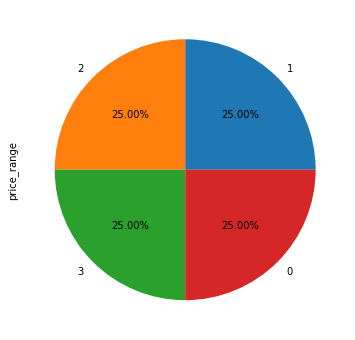

In [10]:
plt.figure(figsize=(10,6))
data['price_range'].value_counts().plot.pie(autopct='%.2f%%')

<AxesSubplot:>

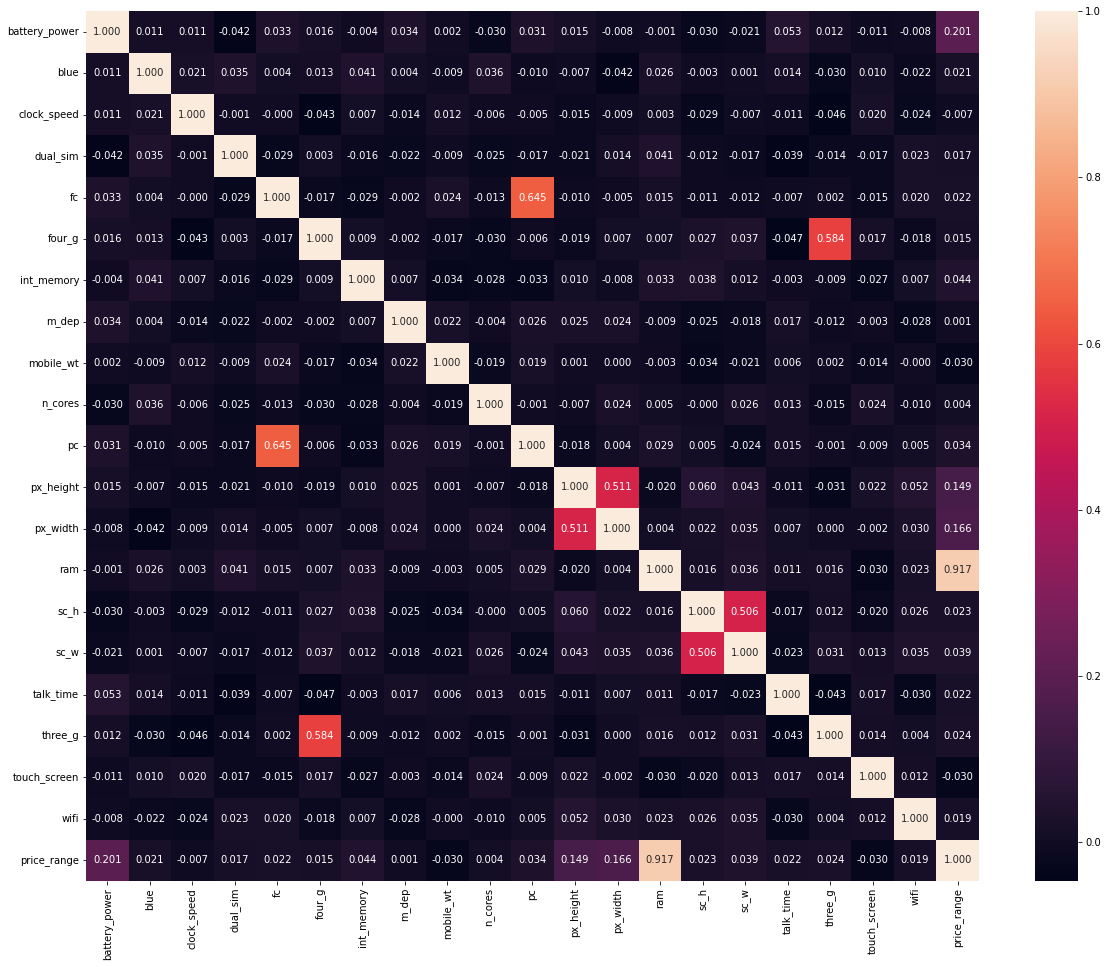

In [11]:
fig, ax = plt.subplots(figsize = (20, 16))
sns.heatmap(data.corr(), ax = ax, annot = True, fmt = ".3f")

Za zaklade heatmapy vidime, ze atribut price_range najviac koreluje s atributom ram, a preto predpokladame, ze cena mobilneho telefonu sa odvija najma od tohto atributu.

<AxesSubplot:xlabel='price_range', ylabel='ram'>

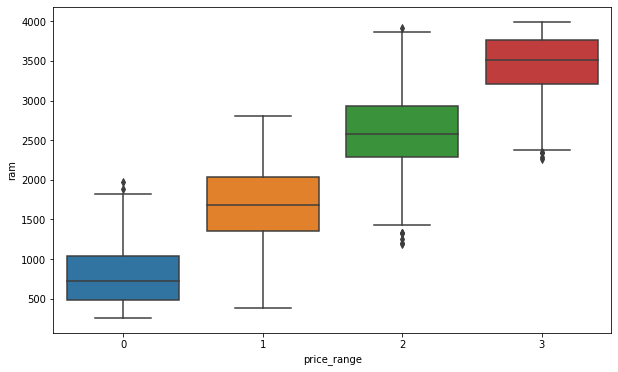

In [12]:
plt.figure(figsize=(10,6))
sns.boxplot(y=data['ram'],x=data['price_range'])

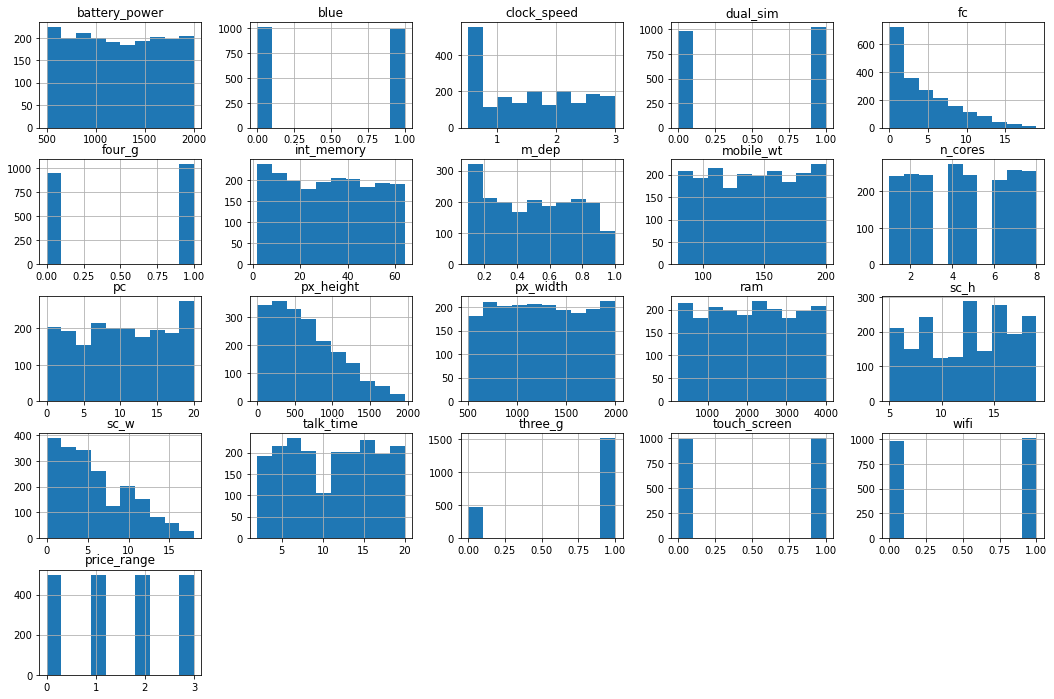

In [13]:
data_hist = data.hist(figsize=(18,12))

Vykreslime, ako su hodnoty distribuovane na zaklade atributov.

In [14]:
dataset = pd.read_csv("../data/train.csv")

for column in dataset.columns:
    dataset[column] = MinMaxNormalisation(dataset[column])

Normalizujeme data a nasledne ich zobrazime a zistime, ktore atributy obsahuju outliere. 

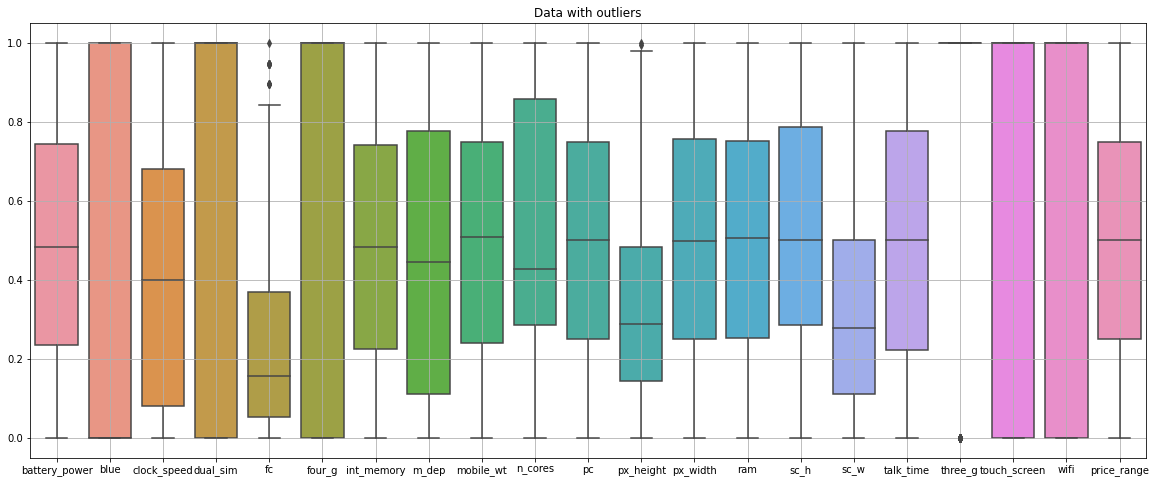

In [15]:
plt.figure(figsize=(20,8))
plt.title("Data with outliers")
sns.boxplot(data = dataset)
plt.grid()
plt.show()

Zistili sme, ze outliere sa nachadzaju v atributoch 'fc', 'px_height' a 'three_g'.

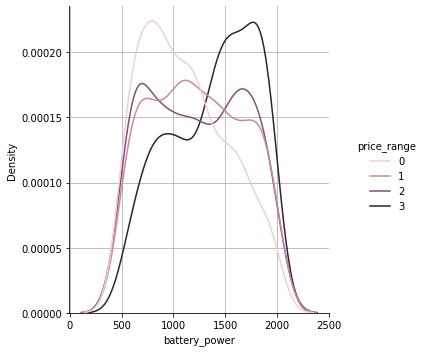

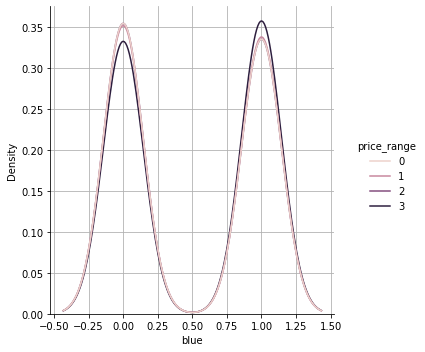

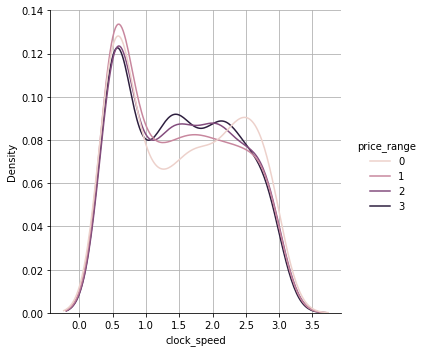

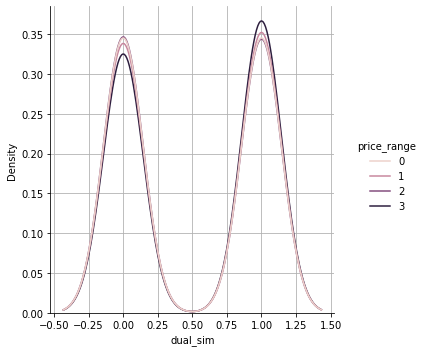

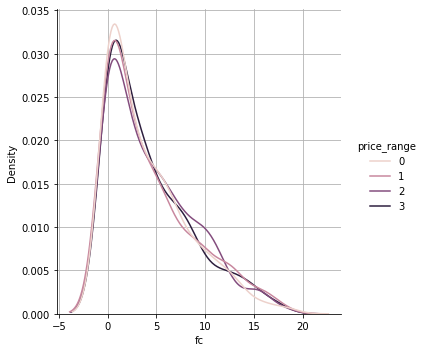

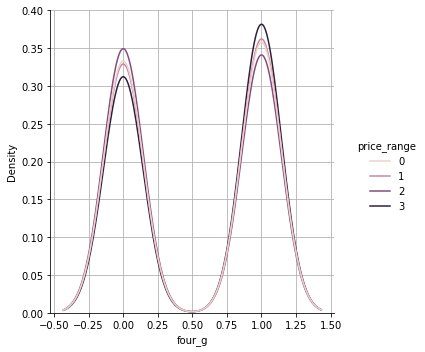

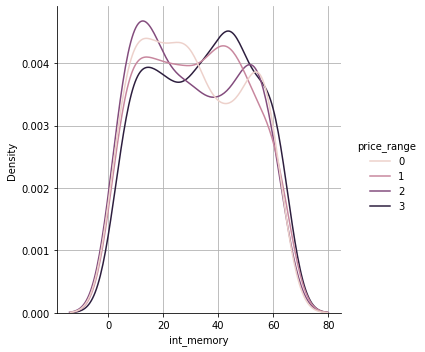

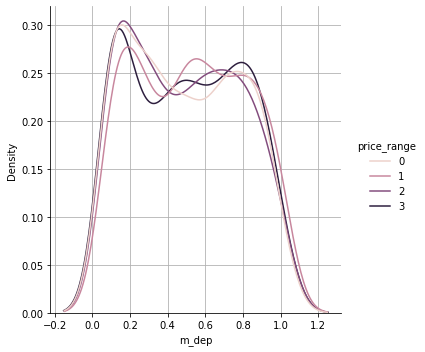

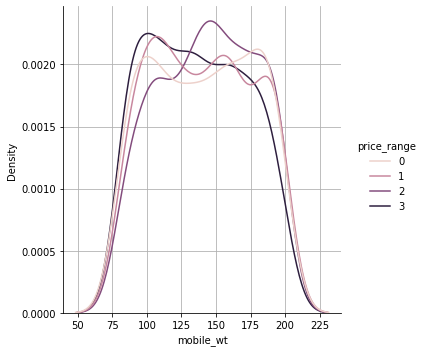

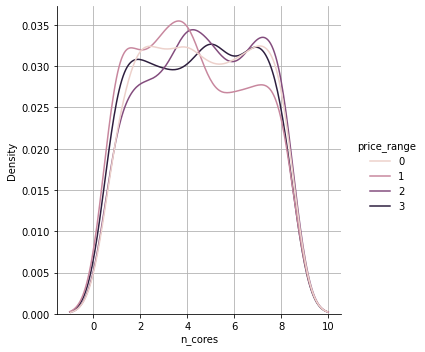

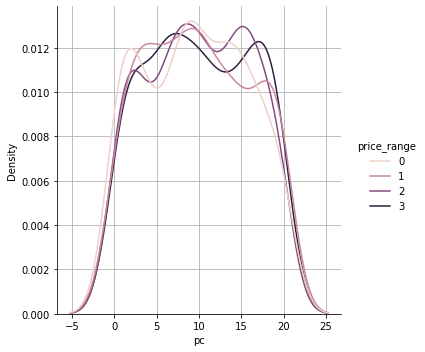

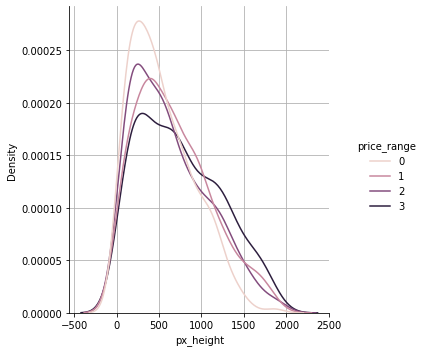

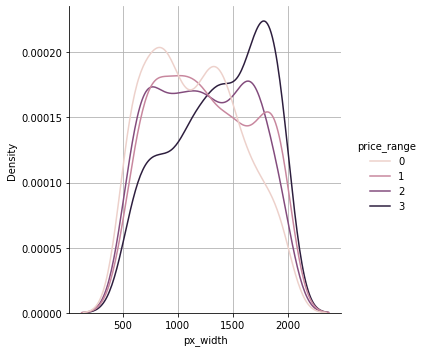

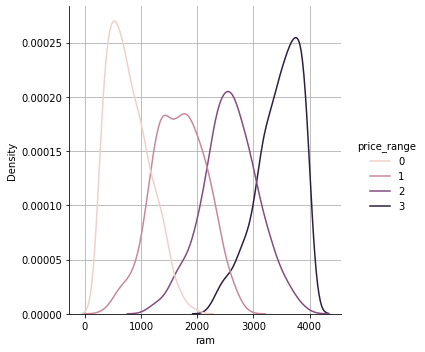

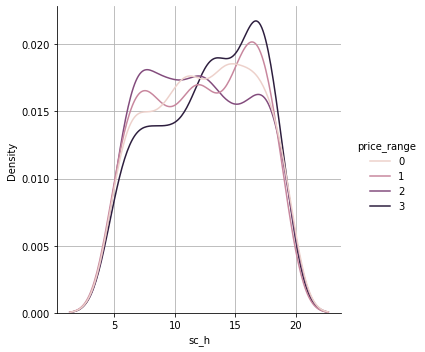

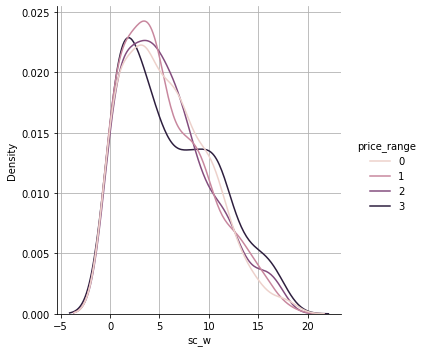

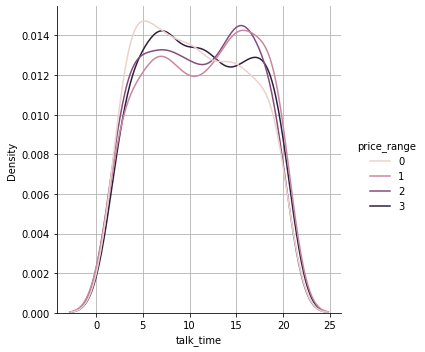

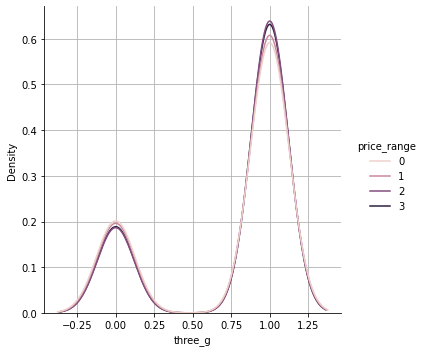

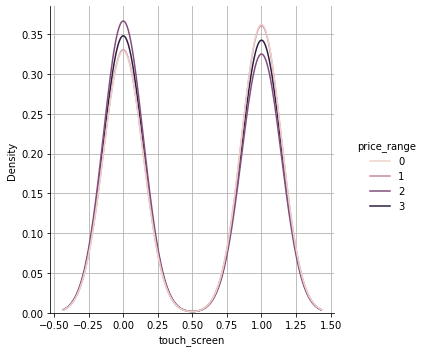

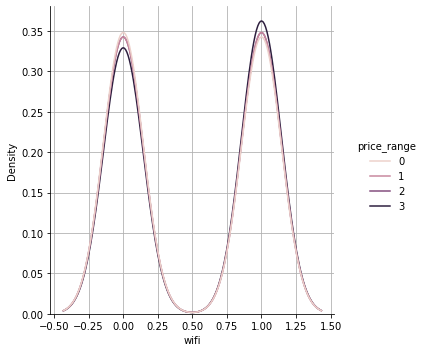

In [16]:
for colm in data.select_dtypes(np.number).columns[:-1]:
    sns.displot(data, x = colm,  hue="price_range", kind="kde", fill=False)
    plt.grid()
    plt.show()

In [17]:
dataset = pd.read_csv("../data/train.csv")
input_data = dataset.drop('price_range', axis=1)
for column in dataset.columns[:-1]:
    dataset[column] = MinMaxNormalisation(dataset[column])

In [18]:
dataset.describe()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
count,2000.000000,2000.0000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,...,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,0.492664,0.4950,0.408900,0.509500,0.226816,0.521500,0.484621,0.446389,0.502075,0.502929,...,0.329137,0.501679,0.499255,0.521893,0.320389,0.500611,0.761500,0.503000,0.507000,1.500000
std,0.293533,0.5001,0.326402,0.500035,0.228497,0.499662,0.292673,0.320462,0.294997,0.326834,...,0.226419,0.288518,0.289880,0.300946,0.242022,0.303553,0.426273,0.500116,0.500076,1.118314
min,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.234302,0.0000,0.080000,0.000000,0.052632,0.000000,0.225806,0.111111,0.241667,0.285714,...,0.144260,0.250167,0.254276,0.285714,0.111111,0.222222,1.000000,0.000000,0.000000,0.750000
50%,0.484302,0.0000,0.400000,1.000000,0.157895,1.000000,0.483871,0.444444,0.508333,0.428571,...,0.287755,0.498665,0.505211,0.500000,0.277778,0.500000,1.000000,1.000000,1.000000,1.500000
75%,0.744322,1.0000,0.680000,1.000000,0.368421,1.000000,0.741935,0.777778,0.750000,0.857143,...,0.483291,0.756342,0.750534,0.785714,0.500000,0.777778,1.000000,1.000000,1.000000,2.250000
max,1.000000,1.0000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.000000


Vidime, ze data su normalizovane v intervale 0 az 1.

### Tensorflow model

### Prvy nastrel siete

Architektura:
- 3 skryte vrstvy 
    - aktivacne fukcie: ReLU 
    - pocet neuronov: 256 - 128 - 64 
- vystupna vrstva
    - aktivacna fukcia: Softmax
    - pocet neuronov: 4

Hyperparametre:
- optimizer: Adam
- loss: sparse_categorical_crossentropy
- learning rate: 0.001 
- epochy: 200
- velkost batchu: 32

In [19]:
X_train, X_val, y_train, y_val = LoadData()
# tf.autograph.set_verbosity(0)

# Initialize WandB
wandb.init(project="neural-network")
wandb.run.name = "Nastrel"
config = wandb.config
config.learning_rate = 0.001
config.batch_size = 32
config.epochs = 200


model = tf.keras.Sequential([
    tf.keras.layers.Dense(256, activation='relu', input_shape=(20,)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(4, activation='softmax')
])

optimizer = tf.keras.optimizers.Adam(learning_rate=config.learning_rate)

# Compile the model
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=200, batch_size=32, validation_data=(X_val, y_val), callbacks=[WandbCallback()])

# Evaluate the model
val_loss, val_acc = model.evaluate(X_val, y_val, verbose=2)
print('Validation accuracy:', val_acc)
print('Validation loss:', val_loss)

# Make predictions
predictions = model.predict(X_val)
print('Predictions:', np.argmax(predictions, axis=1))

# Evaluate the model on the val set and log the results
wandb.log({'Validation loss': val_loss, 'Validation accuracy': val_acc})

wandb: Currently logged in as: xkukuckam (neural-netwok-nn). Use `wandb login --relogin` to force relogin


wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Epoch 1/200
37/54 [===================>..........] - ETA: 0s - loss: 1.2810 - accuracy: 0.4206

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_200943-rom1t6cd\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_200943-rom1t6cd\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_200943-rom1t6cd\files\model-best)... Done. 0.0s


54/54 [==============================] - 4s 43ms/step - loss: 1.1958 - accuracy: 0.4900 - val_loss: 0.8608 - val_accuracy: 0.6967
Epoch 2/200
37/54 [===================>..........] - ETA: 0s - loss: 0.7105 - accuracy: 0.7348

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_200943-rom1t6cd\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_200943-rom1t6cd\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_200943-rom1t6cd\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 34ms/step - loss: 0.6571 - accuracy: 0.7535 - val_loss: 0.4581 - val_accuracy: 0.8467
Epoch 3/200
38/54 [====================>.........] - ETA: 0s - loss: 0.4452 - accuracy: 0.8232

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_200943-rom1t6cd\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_200943-rom1t6cd\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_200943-rom1t6cd\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 34ms/step - loss: 0.4255 - accuracy: 0.8335 - val_loss: 0.3596 - val_accuracy: 0.8700
Epoch 4/200
37/54 [===================>..........] - ETA: 0s - loss: 0.2998 - accuracy: 0.8961

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_200943-rom1t6cd\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_200943-rom1t6cd\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_200943-rom1t6cd\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 42ms/step - loss: 0.3002 - accuracy: 0.8900 - val_loss: 0.2727 - val_accuracy: 0.8933
Epoch 5/200
54/54 [==============================] - 0s 4ms/step - loss: 0.2594 - accuracy: 0.8982 - val_loss: 0.3255 - val_accuracy: 0.8667
Epoch 6/200
54/54 [==============================] - 0s 4ms/step - loss: 0.2368 - accuracy: 0.8971 - val_loss: 0.3343 - val_accuracy: 0.8367
Epoch 7/200
36/54 [===================>..........] - ETA: 0s - loss: 0.2205 - accuracy: 0.9071

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_200943-rom1t6cd\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_200943-rom1t6cd\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_200943-rom1t6cd\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 37ms/step - loss: 0.2016 - accuracy: 0.9200 - val_loss: 0.2162 - val_accuracy: 0.9133
Epoch 8/200
35/54 [==================>...........] - ETA: 0s - loss: 0.2136 - accuracy: 0.9196

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_200943-rom1t6cd\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_200943-rom1t6cd\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_200943-rom1t6cd\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 40ms/step - loss: 0.1982 - accuracy: 0.9253 - val_loss: 0.2096 - val_accuracy: 0.9100
Epoch 9/200
54/54 [==============================] - 0s 4ms/step - loss: 0.1655 - accuracy: 0.9353 - val_loss: 0.2832 - val_accuracy: 0.8767
Epoch 10/200
54/54 [==============================] - 0s 4ms/step - loss: 0.1473 - accuracy: 0.9382 - val_loss: 0.2503 - val_accuracy: 0.8967
Epoch 11/200
54/54 [==============================] - 0s 4ms/step - loss: 0.1939 - accuracy: 0.9129 - val_loss: 0.2199 - val_accuracy: 0.9100
Epoch 12/200
54/54 [==============================] - ETA: 0s - loss: 0.1376 - accuracy: 0.9506

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_200943-rom1t6cd\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_200943-rom1t6cd\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_200943-rom1t6cd\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 34ms/step - loss: 0.1376 - accuracy: 0.9506 - val_loss: 0.1783 - val_accuracy: 0.9033
Epoch 13/200
49/54 [==========================>...] - ETA: 0s - loss: 0.0940 - accuracy: 0.9745

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_200943-rom1t6cd\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_200943-rom1t6cd\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_200943-rom1t6cd\files\model-best)... Done. 0.0s


54/54 [==============================] - 3s 66ms/step - loss: 0.0959 - accuracy: 0.9729 - val_loss: 0.1714 - val_accuracy: 0.9233
Epoch 14/200
54/54 [==============================] - 0s 4ms/step - loss: 0.1224 - accuracy: 0.9565 - val_loss: 0.1737 - val_accuracy: 0.9100
Epoch 15/200
54/54 [==============================] - 0s 4ms/step - loss: 0.0876 - accuracy: 0.9765 - val_loss: 0.1814 - val_accuracy: 0.9067
Epoch 16/200
54/54 [==============================] - 0s 4ms/step - loss: 0.0868 - accuracy: 0.9735 - val_loss: 0.1964 - val_accuracy: 0.8967
Epoch 17/200
54/54 [==============================] - 0s 4ms/step - loss: 0.0809 - accuracy: 0.9759 - val_loss: 0.2941 - val_accuracy: 0.8900
Epoch 18/200
54/54 [==============================] - 0s 5ms/step - loss: 0.1007 - accuracy: 0.9512 - val_loss: 0.2318 - val_accuracy: 0.8933
Epoch 19/200
54/54 [==============================] - 0s 4ms/step - loss: 0.0765 - accuracy: 0.9741 - val_loss: 0.1897 - val_accuracy: 0.9233
Epoch 20/200
54/54

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_200943-rom1t6cd\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_200943-rom1t6cd\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_200943-rom1t6cd\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 41ms/step - loss: 0.1277 - accuracy: 0.9406 - val_loss: 0.1707 - val_accuracy: 0.9133
Epoch 24/200
54/54 [==============================] - 0s 5ms/step - loss: 0.0568 - accuracy: 0.9812 - val_loss: 0.2135 - val_accuracy: 0.9000
Epoch 25/200
54/54 [==============================] - 0s 4ms/step - loss: 0.0485 - accuracy: 0.9871 - val_loss: 0.2060 - val_accuracy: 0.9167
Epoch 26/200
54/54 [==============================] - 0s 4ms/step - loss: 0.0346 - accuracy: 0.9947 - val_loss: 0.1745 - val_accuracy: 0.9100
Epoch 27/200
38/54 [====================>.........] - ETA: 0s - loss: 0.0403 - accuracy: 0.9910

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_200943-rom1t6cd\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_200943-rom1t6cd\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_200943-rom1t6cd\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 35ms/step - loss: 0.0394 - accuracy: 0.9906 - val_loss: 0.1664 - val_accuracy: 0.9267
Epoch 28/200
41/54 [=====================>........] - ETA: 0s - loss: 0.0296 - accuracy: 0.9947

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_200943-rom1t6cd\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_200943-rom1t6cd\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_200943-rom1t6cd\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 41ms/step - loss: 0.0298 - accuracy: 0.9947 - val_loss: 0.1651 - val_accuracy: 0.9333
Epoch 29/200
54/54 [==============================] - 0s 4ms/step - loss: 0.0335 - accuracy: 0.9941 - val_loss: 0.2037 - val_accuracy: 0.9100
Epoch 30/200
54/54 [==============================] - 0s 4ms/step - loss: 0.0324 - accuracy: 0.9918 - val_loss: 0.1857 - val_accuracy: 0.9133
Epoch 31/200
54/54 [==============================] - 0s 5ms/step - loss: 0.1284 - accuracy: 0.9506 - val_loss: 0.2332 - val_accuracy: 0.9100
Epoch 32/200
54/54 [==============================] - 0s 4ms/step - loss: 0.0522 - accuracy: 0.9771 - val_loss: 0.1953 - val_accuracy: 0.9200
Epoch 33/200
54/54 [==============================] - 0s 4ms/step - loss: 0.0280 - accuracy: 0.9900 - val_loss: 0.1670 - val_accuracy: 0.9167
Epoch 34/200
54/54 [==============================] - 0s 4ms/step - loss: 0.0315 - accuracy: 0.9924 - val_loss: 0.1741 - val_accuracy: 0.9367
Epoch 35/200
54/54

Epoch 141/200
54/54 [==============================] - 0s 4ms/step - loss: 7.6702e-05 - accuracy: 1.0000 - val_loss: 0.3207 - val_accuracy: 0.9267
Epoch 142/200
54/54 [==============================] - 0s 4ms/step - loss: 7.4593e-05 - accuracy: 1.0000 - val_loss: 0.3289 - val_accuracy: 0.9300
Epoch 143/200
54/54 [==============================] - 0s 4ms/step - loss: 7.0317e-05 - accuracy: 1.0000 - val_loss: 0.3346 - val_accuracy: 0.9300
Epoch 144/200
54/54 [==============================] - 0s 4ms/step - loss: 6.6994e-05 - accuracy: 1.0000 - val_loss: 0.3229 - val_accuracy: 0.9267
Epoch 145/200
54/54 [==============================] - 0s 4ms/step - loss: 6.5084e-05 - accuracy: 1.0000 - val_loss: 0.3263 - val_accuracy: 0.9267
Epoch 146/200
54/54 [==============================] - 0s 4ms/step - loss: 6.2720e-05 - accuracy: 1.0000 - val_loss: 0.3223 - val_accuracy: 0.9267
Epoch 147/200
54/54 [==============================] - 0s 4ms/step - loss: 6.1488e-05 - accuracy: 1.0000 - val_loss: 0

Epoch 197/200
54/54 [==============================] - 0s 4ms/step - loss: 1.1813e-05 - accuracy: 1.0000 - val_loss: 0.3934 - val_accuracy: 0.9300
Epoch 198/200
54/54 [==============================] - 0s 4ms/step - loss: 1.1917e-05 - accuracy: 1.0000 - val_loss: 0.3848 - val_accuracy: 0.9267
Epoch 199/200
54/54 [==============================] - 0s 4ms/step - loss: 1.1305e-05 - accuracy: 1.0000 - val_loss: 0.3854 - val_accuracy: 0.9267
Epoch 200/200
54/54 [==============================] - 0s 4ms/step - loss: 1.1068e-05 - accuracy: 1.0000 - val_loss: 0.3851 - val_accuracy: 0.9267
10/10 - 0s - loss: 0.3851 - accuracy: 0.9267 - 55ms/epoch - 6ms/step
Validation accuracy: 0.9266666769981384
Validation loss: 0.38511040806770325
10/10 [==============================] - 0s 2ms/step
Predictions: [0 0 0 0 0 2 2 2 2 3 1 3 2 3 3 3 3 3 1 0 3 0 1 2 0 0 0 0 3 2 2 1 0 2 3 2 2
 3 1 1 0 2 3 1 1 1 1 0 2 1 2 0 1 1 3 0 1 1 3 3 2 0 0 3 0 0 1 3 1 1 3 1 1 3
 1 3 3 1 2 0 2 3 2 3 0 2 0 3 3 1 2 3 0 1 2 1 3 2 0

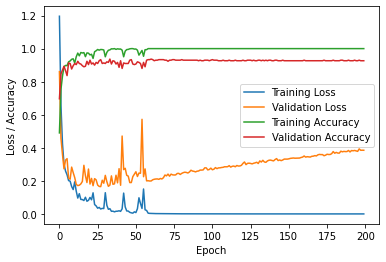

In [20]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss / Accuracy')
plt.legend()
plt.show()

### Pokus cislo 2

Architektura:
- 2 skryte vrstvy 
    - aktivacne fukcie: ReLU 
    - pocet neuronov: 64 - 16 
- vystupna vrstva
    - aktivacna fukcia: Softmax
    - pocet neuronov: 4

Hyperparametre:
- optimizer: Adam
- loss: sparse_categorical_crossentropy
- learnig rate: 0.001 
- epochy: 200
- velkost batchu: 32

In [21]:
X_train, X_val, y_train, y_val = LoadData()

# Define the model architecture
wandb.init(project="neural-network")
wandb.run.name = "Pokus cislo 2"
config = wandb.config
config.learning_rate = 0.001
config.batch_size = 32
config.epochs = 200

model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(20,)),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(4, activation='softmax')
])

optimizer = tf.keras.optimizers.Adam(learning_rate=config.learning_rate)

# Compile the model
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=config.epochs, batch_size=config.batch_size, validation_data=(X_val, y_val),callbacks=[WandbCallback()])

# Evaluate the model
val_loss, val_acc = model.evaluate(X_val, y_val, verbose=2)
print('Validation accuracy:', val_acc)
print('Validation loss:', val_loss)

# Make predictions
predictions = model.predict(X_val)
print('Predictions:', np.argmax(predictions, axis=1))

# Evaluate the model on the val set and log the results
wandb.log({'Validation loss': val_loss, 'Validation accuracy': val_acc})

Validation accuracy,▁
Validation loss,▁
accuracy,▁▅▇▇▇█▇████▇████████████████████████████
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▄▂▂▂▁▂▁▁▁▁▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▂▁▆▅▆▆▇█▄▆▇▇██▇█████████████████████████
val_loss,█▅▁▂▂▁▁▁█▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▆▆▆▆
Validation accuracy,0.92667
Validation loss,0.38511
accuracy,1.0
best_epoch,27


Epoch 1/200
 1/54 [..............................] - ETA: 59s - loss: 1.4064 - accuracy: 0.1875WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0022s vs `on_train_batch_end` time: 0.0027s). Check your callbacks.


45/54 [========================>.....] - ETA: 0s - loss: 1.3792 - accuracy: 0.3007

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201052-eyxuqg89\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201052-eyxuqg89\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201052-eyxuqg89\files\model-best)... Done. 0.0s


54/54 [==============================] - 3s 35ms/step - loss: 1.3734 - accuracy: 0.3024 - val_loss: 1.3329 - val_accuracy: 0.3533
Epoch 2/200
35/54 [==================>...........] - ETA: 0s - loss: 1.2935 - accuracy: 0.4241

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201052-eyxuqg89\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201052-eyxuqg89\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201052-eyxuqg89\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 36ms/step - loss: 1.2598 - accuracy: 0.4582 - val_loss: 1.1736 - val_accuracy: 0.5400
Epoch 3/200
47/54 [=========================>....] - ETA: 0s - loss: 1.0803 - accuracy: 0.5944

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201052-eyxuqg89\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201052-eyxuqg89\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201052-eyxuqg89\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 29ms/step - loss: 1.0706 - accuracy: 0.5953 - val_loss: 0.9681 - val_accuracy: 0.6600
Epoch 4/200
51/54 [===========================>..] - ETA: 0s - loss: 0.8963 - accuracy: 0.6667

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201052-eyxuqg89\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201052-eyxuqg89\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201052-eyxuqg89\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 29ms/step - loss: 0.8947 - accuracy: 0.6671 - val_loss: 0.7996 - val_accuracy: 0.7900
Epoch 5/200
43/54 [======================>.......] - ETA: 0s - loss: 0.7580 - accuracy: 0.7522

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201052-eyxuqg89\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201052-eyxuqg89\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201052-eyxuqg89\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 35ms/step - loss: 0.7491 - accuracy: 0.7571 - val_loss: 0.6793 - val_accuracy: 0.8367
Epoch 6/200
39/54 [====================>.........] - ETA: 0s - loss: 0.6592 - accuracy: 0.7917

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201052-eyxuqg89\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201052-eyxuqg89\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201052-eyxuqg89\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 29ms/step - loss: 0.6433 - accuracy: 0.8012 - val_loss: 0.5971 - val_accuracy: 0.8133
Epoch 7/200
49/54 [==========================>...] - ETA: 0s - loss: 0.5676 - accuracy: 0.8246

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201052-eyxuqg89\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201052-eyxuqg89\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201052-eyxuqg89\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 31ms/step - loss: 0.5669 - accuracy: 0.8229 - val_loss: 0.5230 - val_accuracy: 0.8433
Epoch 8/200
43/54 [======================>.......] - ETA: 0s - loss: 0.5074 - accuracy: 0.8459

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201052-eyxuqg89\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201052-eyxuqg89\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201052-eyxuqg89\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 36ms/step - loss: 0.5033 - accuracy: 0.8512 - val_loss: 0.4657 - val_accuracy: 0.8833
Epoch 9/200
43/54 [======================>.......] - ETA: 0s - loss: 0.4605 - accuracy: 0.8641

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201052-eyxuqg89\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201052-eyxuqg89\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201052-eyxuqg89\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 44ms/step - loss: 0.4587 - accuracy: 0.8606 - val_loss: 0.4246 - val_accuracy: 0.8800
Epoch 10/200
45/54 [========================>.....] - ETA: 0s - loss: 0.4111 - accuracy: 0.8875

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201052-eyxuqg89\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201052-eyxuqg89\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201052-eyxuqg89\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 30ms/step - loss: 0.4133 - accuracy: 0.8847 - val_loss: 0.4045 - val_accuracy: 0.8600
Epoch 11/200
44/54 [=======================>......] - ETA: 0s - loss: 0.3795 - accuracy: 0.8857

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201052-eyxuqg89\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201052-eyxuqg89\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201052-eyxuqg89\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 36ms/step - loss: 0.3768 - accuracy: 0.8876 - val_loss: 0.3751 - val_accuracy: 0.8733
Epoch 12/200
49/54 [==========================>...] - ETA: 0s - loss: 0.3463 - accuracy: 0.9050

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201052-eyxuqg89\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201052-eyxuqg89\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201052-eyxuqg89\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 34ms/step - loss: 0.3450 - accuracy: 0.9047 - val_loss: 0.3396 - val_accuracy: 0.8933
Epoch 13/200
51/54 [===========================>..] - ETA: 0s - loss: 0.3171 - accuracy: 0.9142

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201052-eyxuqg89\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201052-eyxuqg89\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201052-eyxuqg89\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 43ms/step - loss: 0.3174 - accuracy: 0.9147 - val_loss: 0.3303 - val_accuracy: 0.8833
Epoch 14/200
46/54 [========================>.....] - ETA: 0s - loss: 0.2944 - accuracy: 0.9178

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201052-eyxuqg89\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201052-eyxuqg89\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201052-eyxuqg89\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 30ms/step - loss: 0.2955 - accuracy: 0.9135 - val_loss: 0.2987 - val_accuracy: 0.8967
Epoch 15/200
44/54 [=======================>......] - ETA: 0s - loss: 0.2756 - accuracy: 0.9297

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201052-eyxuqg89\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201052-eyxuqg89\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201052-eyxuqg89\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 29ms/step - loss: 0.2746 - accuracy: 0.9265 - val_loss: 0.2862 - val_accuracy: 0.8967
Epoch 16/200
54/54 [==============================] - ETA: 0s - loss: 0.2566 - accuracy: 0.9300

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201052-eyxuqg89\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201052-eyxuqg89\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201052-eyxuqg89\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 29ms/step - loss: 0.2566 - accuracy: 0.9300 - val_loss: 0.2659 - val_accuracy: 0.9133
Epoch 17/200
52/54 [===========================>..] - ETA: 0s - loss: 0.2384 - accuracy: 0.9369

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201052-eyxuqg89\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201052-eyxuqg89\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201052-eyxuqg89\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 34ms/step - loss: 0.2373 - accuracy: 0.9376 - val_loss: 0.2556 - val_accuracy: 0.9067
Epoch 18/200
47/54 [=========================>....] - ETA: 0s - loss: 0.2337 - accuracy: 0.9322

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201052-eyxuqg89\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201052-eyxuqg89\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201052-eyxuqg89\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 30ms/step - loss: 0.2302 - accuracy: 0.9347 - val_loss: 0.2506 - val_accuracy: 0.9067
Epoch 19/200
49/54 [==========================>...] - ETA: 0s - loss: 0.2096 - accuracy: 0.9426

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201052-eyxuqg89\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201052-eyxuqg89\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201052-eyxuqg89\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 29ms/step - loss: 0.2099 - accuracy: 0.9418 - val_loss: 0.2273 - val_accuracy: 0.9167
Epoch 20/200
49/54 [==========================>...] - ETA: 0s - loss: 0.1967 - accuracy: 0.9547

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201052-eyxuqg89\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201052-eyxuqg89\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201052-eyxuqg89\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 34ms/step - loss: 0.1970 - accuracy: 0.9529 - val_loss: 0.2183 - val_accuracy: 0.9300
Epoch 21/200
46/54 [========================>.....] - ETA: 0s - loss: 0.1924 - accuracy: 0.9477

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201052-eyxuqg89\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201052-eyxuqg89\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201052-eyxuqg89\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 28ms/step - loss: 0.1927 - accuracy: 0.9447 - val_loss: 0.2163 - val_accuracy: 0.9267
Epoch 22/200
54/54 [==============================] - 0s 3ms/step - loss: 0.1791 - accuracy: 0.9553 - val_loss: 0.2164 - val_accuracy: 0.9167
Epoch 23/200
48/54 [=========================>....] - ETA: 0s - loss: 0.1753 - accuracy: 0.9583

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201052-eyxuqg89\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201052-eyxuqg89\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201052-eyxuqg89\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 29ms/step - loss: 0.1745 - accuracy: 0.9565 - val_loss: 0.2044 - val_accuracy: 0.9333
Epoch 24/200
50/54 [==========================>...] - ETA: 0s - loss: 0.1663 - accuracy: 0.9575

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201052-eyxuqg89\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201052-eyxuqg89\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201052-eyxuqg89\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 35ms/step - loss: 0.1655 - accuracy: 0.9576 - val_loss: 0.1969 - val_accuracy: 0.9200
Epoch 25/200
54/54 [==============================] - 0s 3ms/step - loss: 0.1587 - accuracy: 0.9624 - val_loss: 0.2014 - val_accuracy: 0.9333
Epoch 26/200
54/54 [==============================] - 0s 3ms/step - loss: 0.1483 - accuracy: 0.9647 - val_loss: 0.2157 - val_accuracy: 0.9133
Epoch 27/200
53/54 [============================>.] - ETA: 0s - loss: 0.1452 - accuracy: 0.9717

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201052-eyxuqg89\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201052-eyxuqg89\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201052-eyxuqg89\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 31ms/step - loss: 0.1453 - accuracy: 0.9718 - val_loss: 0.1951 - val_accuracy: 0.9133
Epoch 28/200
45/54 [========================>.....] - ETA: 0s - loss: 0.1446 - accuracy: 0.9583

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201052-eyxuqg89\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201052-eyxuqg89\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201052-eyxuqg89\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 37ms/step - loss: 0.1419 - accuracy: 0.9618 - val_loss: 0.1773 - val_accuracy: 0.9267
Epoch 29/200
54/54 [==============================] - 0s 3ms/step - loss: 0.1492 - accuracy: 0.9535 - val_loss: 0.1867 - val_accuracy: 0.9100
Epoch 30/200
54/54 [==============================] - 0s 3ms/step - loss: 0.1325 - accuracy: 0.9700 - val_loss: 0.1848 - val_accuracy: 0.9167
Epoch 31/200
49/54 [==========================>...] - ETA: 0s - loss: 0.1245 - accuracy: 0.9732

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201052-eyxuqg89\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201052-eyxuqg89\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201052-eyxuqg89\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 30ms/step - loss: 0.1254 - accuracy: 0.9706 - val_loss: 0.1765 - val_accuracy: 0.9267
Epoch 32/200
54/54 [==============================] - 0s 3ms/step - loss: 0.1237 - accuracy: 0.9700 - val_loss: 0.1851 - val_accuracy: 0.9200
Epoch 33/200
52/54 [===========================>..] - ETA: 0s - loss: 0.1145 - accuracy: 0.9760

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201052-eyxuqg89\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201052-eyxuqg89\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201052-eyxuqg89\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 30ms/step - loss: 0.1145 - accuracy: 0.9759 - val_loss: 0.1709 - val_accuracy: 0.9367
Epoch 34/200
54/54 [==============================] - 0s 3ms/step - loss: 0.1149 - accuracy: 0.9735 - val_loss: 0.1768 - val_accuracy: 0.9233
Epoch 35/200
53/54 [============================>.] - ETA: 0s - loss: 0.1100 - accuracy: 0.9782

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201052-eyxuqg89\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201052-eyxuqg89\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201052-eyxuqg89\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 33ms/step - loss: 0.1098 - accuracy: 0.9782 - val_loss: 0.1652 - val_accuracy: 0.9200
Epoch 36/200
54/54 [==============================] - 0s 3ms/step - loss: 0.1068 - accuracy: 0.9771 - val_loss: 0.1779 - val_accuracy: 0.9067
Epoch 37/200
53/54 [============================>.] - ETA: 0s - loss: 0.1054 - accuracy: 0.9741

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201052-eyxuqg89\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201052-eyxuqg89\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201052-eyxuqg89\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 29ms/step - loss: 0.1057 - accuracy: 0.9741 - val_loss: 0.1542 - val_accuracy: 0.9300
Epoch 38/200
54/54 [==============================] - 0s 3ms/step - loss: 0.0992 - accuracy: 0.9806 - val_loss: 0.1654 - val_accuracy: 0.9300
Epoch 39/200
54/54 [==============================] - 0s 6ms/step - loss: 0.1085 - accuracy: 0.9694 - val_loss: 0.1587 - val_accuracy: 0.9200
Epoch 40/200
54/54 [==============================] - 0s 5ms/step - loss: 0.1048 - accuracy: 0.9694 - val_loss: 0.1560 - val_accuracy: 0.9167
Epoch 41/200
54/54 [==============================] - 0s 4ms/step - loss: 0.0937 - accuracy: 0.9818 - val_loss: 0.1666 - val_accuracy: 0.9267
Epoch 42/200
54/54 [==============================] - 0s 3ms/step - loss: 0.0920 - accuracy: 0.9806 - val_loss: 0.1771 - val_accuracy: 0.9200
Epoch 43/200
53/54 [============================>.] - ETA: 0s - loss: 0.0930 - accuracy: 0.9788

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201052-eyxuqg89\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201052-eyxuqg89\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201052-eyxuqg89\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 37ms/step - loss: 0.0930 - accuracy: 0.9788 - val_loss: 0.1524 - val_accuracy: 0.9433
Epoch 44/200
54/54 [==============================] - 0s 5ms/step - loss: 0.0842 - accuracy: 0.9841 - val_loss: 0.1531 - val_accuracy: 0.9167
Epoch 45/200
51/54 [===========================>..] - ETA: 0s - loss: 0.0908 - accuracy: 0.9773

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201052-eyxuqg89\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201052-eyxuqg89\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201052-eyxuqg89\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 39ms/step - loss: 0.0897 - accuracy: 0.9782 - val_loss: 0.1478 - val_accuracy: 0.9367
Epoch 46/200
54/54 [==============================] - 0s 4ms/step - loss: 0.0852 - accuracy: 0.9824 - val_loss: 0.1735 - val_accuracy: 0.9000
Epoch 47/200
47/54 [=========================>....] - ETA: 0s - loss: 0.0803 - accuracy: 0.9847

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201052-eyxuqg89\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201052-eyxuqg89\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201052-eyxuqg89\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 38ms/step - loss: 0.0789 - accuracy: 0.9859 - val_loss: 0.1452 - val_accuracy: 0.9367
Epoch 48/200
54/54 [==============================] - 0s 4ms/step - loss: 0.0821 - accuracy: 0.9841 - val_loss: 0.1474 - val_accuracy: 0.9200
Epoch 49/200
54/54 [==============================] - 0s 3ms/step - loss: 0.0967 - accuracy: 0.9682 - val_loss: 0.1596 - val_accuracy: 0.9367
Epoch 50/200
54/54 [==============================] - 0s 3ms/step - loss: 0.0761 - accuracy: 0.9882 - val_loss: 0.1513 - val_accuracy: 0.9367
Epoch 51/200
54/54 [==============================] - 0s 3ms/step - loss: 0.0730 - accuracy: 0.9876 - val_loss: 0.1516 - val_accuracy: 0.9200
Epoch 52/200
54/54 [==============================] - 0s 4ms/step - loss: 0.0699 - accuracy: 0.9894 - val_loss: 0.1484 - val_accuracy: 0.9167
Epoch 53/200
54/54 [==============================] - 0s 4ms/step - loss: 0.0698 - accuracy: 0.9871 - val_loss: 0.1464 - val_accuracy: 0.9200
Epoch 54/200
54/54

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201052-eyxuqg89\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201052-eyxuqg89\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201052-eyxuqg89\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 44ms/step - loss: 0.0650 - accuracy: 0.9894 - val_loss: 0.1316 - val_accuracy: 0.9300
Epoch 57/200
54/54 [==============================] - 0s 4ms/step - loss: 0.0668 - accuracy: 0.9906 - val_loss: 0.1583 - val_accuracy: 0.9300
Epoch 58/200
54/54 [==============================] - 0s 4ms/step - loss: 0.0603 - accuracy: 0.9953 - val_loss: 0.1432 - val_accuracy: 0.9133
Epoch 59/200
50/54 [==========================>...] - ETA: 0s - loss: 0.0605 - accuracy: 0.9912

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201052-eyxuqg89\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201052-eyxuqg89\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201052-eyxuqg89\files\model-best)... Done. 0.0s


54/54 [==============================] - 3s 56ms/step - loss: 0.0615 - accuracy: 0.9912 - val_loss: 0.1296 - val_accuracy: 0.9400
Epoch 60/200
54/54 [==============================] - 0s 6ms/step - loss: 0.0628 - accuracy: 0.9871 - val_loss: 0.1328 - val_accuracy: 0.9267
Epoch 61/200
54/54 [==============================] - 0s 6ms/step - loss: 0.0561 - accuracy: 0.9912 - val_loss: 0.1400 - val_accuracy: 0.9300
Epoch 62/200
54/54 [==============================] - 0s 5ms/step - loss: 0.0559 - accuracy: 0.9918 - val_loss: 0.1598 - val_accuracy: 0.9333
Epoch 63/200
54/54 [==============================] - 0s 5ms/step - loss: 0.0583 - accuracy: 0.9924 - val_loss: 0.1444 - val_accuracy: 0.9233
Epoch 64/200
54/54 [==============================] - 0s 7ms/step - loss: 0.0575 - accuracy: 0.9900 - val_loss: 0.1425 - val_accuracy: 0.9333
Epoch 65/200
54/54 [==============================] - 0s 5ms/step - loss: 0.0586 - accuracy: 0.9871 - val_loss: 0.1588 - val_accuracy: 0.9167
Epoch 66/200
54/54

54/54 [==============================] - 0s 4ms/step - loss: 0.0072 - accuracy: 1.0000 - val_loss: 0.2019 - val_accuracy: 0.9233
Epoch 174/200
54/54 [==============================] - 0s 4ms/step - loss: 0.0070 - accuracy: 1.0000 - val_loss: 0.2089 - val_accuracy: 0.9167
Epoch 175/200
54/54 [==============================] - 0s 4ms/step - loss: 0.0066 - accuracy: 1.0000 - val_loss: 0.2123 - val_accuracy: 0.9200
Epoch 176/200
54/54 [==============================] - 0s 4ms/step - loss: 0.0075 - accuracy: 0.9994 - val_loss: 0.2266 - val_accuracy: 0.9333
Epoch 177/200
54/54 [==============================] - 0s 4ms/step - loss: 0.0066 - accuracy: 1.0000 - val_loss: 0.2081 - val_accuracy: 0.9200
Epoch 178/200
54/54 [==============================] - 0s 4ms/step - loss: 0.0069 - accuracy: 1.0000 - val_loss: 0.2169 - val_accuracy: 0.9200
Epoch 179/200
54/54 [==============================] - 0s 4ms/step - loss: 0.0062 - accuracy: 0.9994 - val_loss: 0.2141 - val_accuracy: 0.9200
Epoch 180/200

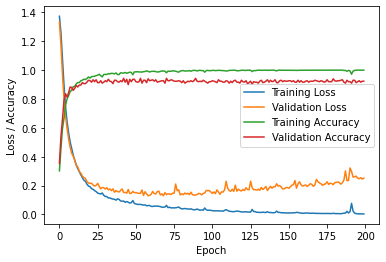

In [22]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss / Accuracy')
plt.legend()
plt.show()

### Pokus cislo 3

Architektura:
- 2 skryte vrstvy 
    - aktivacne fukcie: ReLU 
    - pocet neuronov: 64 - 16 
    - dropout: 0.5 na kazdu skrytu vrstvu
- vystupna vrstva
    - aktivacna fukcia: Softmax
    - pocet neuronov: 4

Hyperparametre:
- optimizer: Adam
- loss: sparse_categorical_crossentropy
- learnig rate: 0.001
    - strategia: ak sa neklesne loss po 5 epochach lr sa prenasobi 0.2 
- epochy: 200
- velkost batchu: 32

In [23]:
# Initialize WandB
wandb.init(project="neural-network")
wandb.run.name = "Pokus cislo 3"
config = wandb.config
config.learning_rate = 0.001
config.batch_size = 32
config.epochs = 200

# Define the model architecture
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(20,)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(4, activation='softmax')
])

learning_rate = 0.001
optimizer = tf.keras.optimizers.Adam(learning_rate=config.learning_rate)

# Train the model
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5)

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

# Train the model
history  = model.fit(X_train, y_train, epochs=config.epochs, batch_size=config.batch_size, validation_data=(X_val, y_val),callbacks=[lr_scheduler,WandbCallback()] )

# Evaluate the model
val_loss, val_acc = model.evaluate(X_val, y_val, verbose=2)
print('Validation accuracy:', val_acc)
print('Validation loss:', val_loss)

# Make predictions
predictions = model.predict(X_val)
print('Predictions:', np.argmax(predictions, axis=1))

# Evaluate the model on the val set and log the results
wandb.log({'Validation loss': val_loss, 'Validation accuracy': val_acc})

Validation accuracy,▁
Validation loss,▁
accuracy,▁▅▇▇▇███████████████████████████████████
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▅▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▆▇██████▇██████████████████████████████
val_loss,█▄▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▁▁▂▂▂▂▂▂
Validation accuracy,0.92333
Validation loss,0.25237
accuracy,1.0
best_epoch,58


Epoch 1/200
36/54 [===================>..........] - ETA: 0s - loss: 1.5188 - accuracy: 0.2535

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201240-w47nb1en\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201240-w47nb1en\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201240-w47nb1en\files\model-best)... Done. 0.0s


54/54 [==============================] - 4s 48ms/step - loss: 1.4930 - accuracy: 0.2547 - val_loss: 1.3849 - val_accuracy: 0.2700 - lr: 0.0010
Epoch 2/200
38/54 [====================>.........] - ETA: 0s - loss: 1.4163 - accuracy: 0.2508

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201240-w47nb1en\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201240-w47nb1en\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201240-w47nb1en\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 42ms/step - loss: 1.4110 - accuracy: 0.2506 - val_loss: 1.3721 - val_accuracy: 0.2733 - lr: 0.0010
Epoch 3/200
53/54 [============================>.] - ETA: 0s - loss: 1.3980 - accuracy: 0.2759

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201240-w47nb1en\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201240-w47nb1en\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201240-w47nb1en\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 40ms/step - loss: 1.3978 - accuracy: 0.2765 - val_loss: 1.3692 - val_accuracy: 0.2867 - lr: 0.0010
Epoch 4/200
53/54 [============================>.] - ETA: 0s - loss: 1.3801 - accuracy: 0.2659

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201240-w47nb1en\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201240-w47nb1en\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201240-w47nb1en\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 39ms/step - loss: 1.3797 - accuracy: 0.2659 - val_loss: 1.3659 - val_accuracy: 0.2967 - lr: 0.0010
Epoch 5/200
35/54 [==================>...........] - ETA: 0s - loss: 1.3785 - accuracy: 0.2732

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201240-w47nb1en\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201240-w47nb1en\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201240-w47nb1en\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 44ms/step - loss: 1.3717 - accuracy: 0.2718 - val_loss: 1.3510 - val_accuracy: 0.3433 - lr: 0.0010
Epoch 6/200
52/54 [===========================>..] - ETA: 0s - loss: 1.3564 - accuracy: 0.3179

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201240-w47nb1en\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201240-w47nb1en\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201240-w47nb1en\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 43ms/step - loss: 1.3564 - accuracy: 0.3176 - val_loss: 1.3190 - val_accuracy: 0.4133 - lr: 0.0010
Epoch 7/200
47/54 [=========================>....] - ETA: 0s - loss: 1.3217 - accuracy: 0.3491

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201240-w47nb1en\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201240-w47nb1en\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201240-w47nb1en\files\model-best)... Done. 0.0s


54/54 [==============================] - 3s 48ms/step - loss: 1.3204 - accuracy: 0.3529 - val_loss: 1.2556 - val_accuracy: 0.5567 - lr: 0.0010
Epoch 8/200
39/54 [====================>.........] - ETA: 0s - loss: 1.2694 - accuracy: 0.3862

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201240-w47nb1en\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201240-w47nb1en\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201240-w47nb1en\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 41ms/step - loss: 1.2705 - accuracy: 0.3765 - val_loss: 1.1751 - val_accuracy: 0.6167 - lr: 0.0010
Epoch 9/200
51/54 [===========================>..] - ETA: 0s - loss: 1.2246 - accuracy: 0.4093

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201240-w47nb1en\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201240-w47nb1en\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201240-w47nb1en\files\model-best)... Done. 0.0s


54/54 [==============================] - 3s 60ms/step - loss: 1.2238 - accuracy: 0.4112 - val_loss: 1.0969 - val_accuracy: 0.6600 - lr: 0.0010
Epoch 10/200
41/54 [=====================>........] - ETA: 0s - loss: 1.1930 - accuracy: 0.4238

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201240-w47nb1en\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201240-w47nb1en\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201240-w47nb1en\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 46ms/step - loss: 1.1818 - accuracy: 0.4347 - val_loss: 1.0031 - val_accuracy: 0.6900 - lr: 0.0010
Epoch 11/200
51/54 [===========================>..] - ETA: 0s - loss: 1.1394 - accuracy: 0.4626

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201240-w47nb1en\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201240-w47nb1en\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201240-w47nb1en\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 47ms/step - loss: 1.1398 - accuracy: 0.4635 - val_loss: 0.9421 - val_accuracy: 0.6867 - lr: 0.0010
Epoch 12/200
39/54 [====================>.........] - ETA: 0s - loss: 1.0634 - accuracy: 0.4960

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201240-w47nb1en\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201240-w47nb1en\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201240-w47nb1en\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 42ms/step - loss: 1.0681 - accuracy: 0.4859 - val_loss: 0.8773 - val_accuracy: 0.7600 - lr: 0.0010
Epoch 13/200
40/54 [=====================>........] - ETA: 0s - loss: 1.0046 - accuracy: 0.5289

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201240-w47nb1en\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201240-w47nb1en\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201240-w47nb1en\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 42ms/step - loss: 1.0119 - accuracy: 0.5241 - val_loss: 0.8115 - val_accuracy: 0.7600 - lr: 0.0010
Epoch 14/200
38/54 [====================>.........] - ETA: 0s - loss: 0.9650 - accuracy: 0.5584

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201240-w47nb1en\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201240-w47nb1en\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201240-w47nb1en\files\model-best)... Done. 0.0s


54/54 [==============================] - 3s 48ms/step - loss: 0.9565 - accuracy: 0.5653 - val_loss: 0.7600 - val_accuracy: 0.7700 - lr: 0.0010
Epoch 15/200
50/54 [==========================>...] - ETA: 0s - loss: 0.9401 - accuracy: 0.5612

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201240-w47nb1en\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201240-w47nb1en\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201240-w47nb1en\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 39ms/step - loss: 0.9419 - accuracy: 0.5588 - val_loss: 0.7187 - val_accuracy: 0.7733 - lr: 0.0010
Epoch 16/200
54/54 [==============================] - ETA: 0s - loss: 0.9145 - accuracy: 0.5612

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201240-w47nb1en\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201240-w47nb1en\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201240-w47nb1en\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 45ms/step - loss: 0.9145 - accuracy: 0.5612 - val_loss: 0.6987 - val_accuracy: 0.7933 - lr: 0.0010
Epoch 17/200
41/54 [=====================>........] - ETA: 0s - loss: 0.8733 - accuracy: 0.5991

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201240-w47nb1en\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201240-w47nb1en\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201240-w47nb1en\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 40ms/step - loss: 0.8733 - accuracy: 0.5888 - val_loss: 0.6690 - val_accuracy: 0.8000 - lr: 0.0010
Epoch 18/200
54/54 [==============================] - ETA: 0s - loss: 0.8605 - accuracy: 0.5788

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201240-w47nb1en\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201240-w47nb1en\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201240-w47nb1en\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 41ms/step - loss: 0.8605 - accuracy: 0.5788 - val_loss: 0.6563 - val_accuracy: 0.8133 - lr: 0.0010
Epoch 19/200
46/54 [========================>.....] - ETA: 0s - loss: 0.8358 - accuracy: 0.6005

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201240-w47nb1en\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201240-w47nb1en\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201240-w47nb1en\files\model-best)... Done. 0.0s


54/54 [==============================] - 3s 48ms/step - loss: 0.8303 - accuracy: 0.6076 - val_loss: 0.6289 - val_accuracy: 0.8167 - lr: 0.0010
Epoch 20/200
42/54 [======================>.......] - ETA: 0s - loss: 0.8141 - accuracy: 0.6176

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201240-w47nb1en\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201240-w47nb1en\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201240-w47nb1en\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 43ms/step - loss: 0.8076 - accuracy: 0.6235 - val_loss: 0.5957 - val_accuracy: 0.8267 - lr: 0.0010
Epoch 21/200
54/54 [==============================] - 0s 5ms/step - loss: 0.7894 - accuracy: 0.6412 - val_loss: 0.5965 - val_accuracy: 0.8533 - lr: 0.0010
Epoch 22/200
53/54 [============================>.] - ETA: 0s - loss: 0.7642 - accuracy: 0.6633

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201240-w47nb1en\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201240-w47nb1en\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201240-w47nb1en\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 46ms/step - loss: 0.7645 - accuracy: 0.6635 - val_loss: 0.5520 - val_accuracy: 0.8367 - lr: 0.0010
Epoch 23/200
46/54 [========================>.....] - ETA: 0s - loss: 0.7723 - accuracy: 0.6433

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201240-w47nb1en\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201240-w47nb1en\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201240-w47nb1en\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 42ms/step - loss: 0.7621 - accuracy: 0.6506 - val_loss: 0.5327 - val_accuracy: 0.8467 - lr: 0.0010
Epoch 24/200
51/54 [===========================>..] - ETA: 0s - loss: 0.7151 - accuracy: 0.6869

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201240-w47nb1en\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201240-w47nb1en\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201240-w47nb1en\files\model-best)... Done. 0.0s


54/54 [==============================] - 3s 51ms/step - loss: 0.7187 - accuracy: 0.6882 - val_loss: 0.5257 - val_accuracy: 0.8400 - lr: 0.0010
Epoch 25/200
45/54 [========================>.....] - ETA: 0s - loss: 0.7328 - accuracy: 0.6736

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201240-w47nb1en\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201240-w47nb1en\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201240-w47nb1en\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 46ms/step - loss: 0.7313 - accuracy: 0.6771 - val_loss: 0.5173 - val_accuracy: 0.8567 - lr: 0.0010
Epoch 26/200
47/54 [=========================>....] - ETA: 0s - loss: 0.7203 - accuracy: 0.6729

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201240-w47nb1en\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201240-w47nb1en\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201240-w47nb1en\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 42ms/step - loss: 0.7140 - accuracy: 0.6765 - val_loss: 0.4969 - val_accuracy: 0.8467 - lr: 0.0010
Epoch 27/200
43/54 [======================>.......] - ETA: 0s - loss: 0.6911 - accuracy: 0.6984

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201240-w47nb1en\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201240-w47nb1en\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201240-w47nb1en\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 41ms/step - loss: 0.6838 - accuracy: 0.7012 - val_loss: 0.4764 - val_accuracy: 0.8667 - lr: 0.0010
Epoch 28/200
36/54 [===================>..........] - ETA: 0s - loss: 0.6783 - accuracy: 0.6953

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201240-w47nb1en\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201240-w47nb1en\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201240-w47nb1en\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 36ms/step - loss: 0.6684 - accuracy: 0.7094 - val_loss: 0.4507 - val_accuracy: 0.8867 - lr: 0.0010
Epoch 29/200
54/54 [==============================] - 0s 4ms/step - loss: 0.6857 - accuracy: 0.6835 - val_loss: 0.4833 - val_accuracy: 0.8533 - lr: 0.0010
Epoch 30/200
54/54 [==============================] - 0s 3ms/step - loss: 0.6686 - accuracy: 0.7082 - val_loss: 0.4568 - val_accuracy: 0.8800 - lr: 0.0010
Epoch 31/200
44/54 [=======================>......] - ETA: 0s - loss: 0.6589 - accuracy: 0.7024

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201240-w47nb1en\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201240-w47nb1en\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201240-w47nb1en\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 47ms/step - loss: 0.6443 - accuracy: 0.7147 - val_loss: 0.4414 - val_accuracy: 0.8900 - lr: 0.0010
Epoch 32/200
45/54 [========================>.....] - ETA: 0s - loss: 0.6654 - accuracy: 0.7021

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201240-w47nb1en\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201240-w47nb1en\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201240-w47nb1en\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 38ms/step - loss: 0.6550 - accuracy: 0.7059 - val_loss: 0.4292 - val_accuracy: 0.8867 - lr: 0.0010
Epoch 33/200
42/54 [======================>.......] - ETA: 0s - loss: 0.6012 - accuracy: 0.7433

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201240-w47nb1en\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201240-w47nb1en\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201240-w47nb1en\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 45ms/step - loss: 0.6083 - accuracy: 0.7394 - val_loss: 0.3947 - val_accuracy: 0.9067 - lr: 0.0010
Epoch 34/200
54/54 [==============================] - 0s 4ms/step - loss: 0.6319 - accuracy: 0.7153 - val_loss: 0.4164 - val_accuracy: 0.8800 - lr: 0.0010
Epoch 35/200
54/54 [==============================] - 0s 3ms/step - loss: 0.6083 - accuracy: 0.7276 - val_loss: 0.4011 - val_accuracy: 0.8933 - lr: 0.0010
Epoch 36/200
48/54 [=========================>....] - ETA: 0s - loss: 0.5831 - accuracy: 0.7520

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201240-w47nb1en\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201240-w47nb1en\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201240-w47nb1en\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 35ms/step - loss: 0.5882 - accuracy: 0.7471 - val_loss: 0.3716 - val_accuracy: 0.8967 - lr: 0.0010
Epoch 37/200
43/54 [======================>.......] - ETA: 0s - loss: 0.5581 - accuracy: 0.7689

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201240-w47nb1en\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201240-w47nb1en\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201240-w47nb1en\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 35ms/step - loss: 0.5772 - accuracy: 0.7547 - val_loss: 0.3696 - val_accuracy: 0.9067 - lr: 0.0010
Epoch 38/200
54/54 [==============================] - ETA: 0s - loss: 0.5645 - accuracy: 0.7594

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201240-w47nb1en\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201240-w47nb1en\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201240-w47nb1en\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 42ms/step - loss: 0.5645 - accuracy: 0.7594 - val_loss: 0.3558 - val_accuracy: 0.9100 - lr: 0.0010
Epoch 39/200
54/54 [==============================] - 0s 4ms/step - loss: 0.5748 - accuracy: 0.7382 - val_loss: 0.3631 - val_accuracy: 0.9000 - lr: 0.0010
Epoch 40/200
47/54 [=========================>....] - ETA: 0s - loss: 0.5598 - accuracy: 0.7620

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201240-w47nb1en\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201240-w47nb1en\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201240-w47nb1en\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 36ms/step - loss: 0.5620 - accuracy: 0.7606 - val_loss: 0.3496 - val_accuracy: 0.9033 - lr: 0.0010
Epoch 41/200
54/54 [==============================] - 0s 4ms/step - loss: 0.5511 - accuracy: 0.7653 - val_loss: 0.3503 - val_accuracy: 0.9100 - lr: 0.0010
Epoch 42/200
43/54 [======================>.......] - ETA: 0s - loss: 0.5267 - accuracy: 0.7747

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201240-w47nb1en\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201240-w47nb1en\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201240-w47nb1en\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 46ms/step - loss: 0.5290 - accuracy: 0.7753 - val_loss: 0.3213 - val_accuracy: 0.9167 - lr: 0.0010
Epoch 43/200
54/54 [==============================] - 0s 3ms/step - loss: 0.5494 - accuracy: 0.7647 - val_loss: 0.3428 - val_accuracy: 0.9100 - lr: 0.0010
Epoch 44/200
54/54 [==============================] - 0s 4ms/step - loss: 0.5244 - accuracy: 0.7665 - val_loss: 0.3253 - val_accuracy: 0.9267 - lr: 0.0010
Epoch 45/200
45/54 [========================>.....] - ETA: 0s - loss: 0.5106 - accuracy: 0.7868

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201240-w47nb1en\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201240-w47nb1en\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201240-w47nb1en\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 36ms/step - loss: 0.5149 - accuracy: 0.7835 - val_loss: 0.3161 - val_accuracy: 0.9133 - lr: 0.0010
Epoch 46/200
54/54 [==============================] - 0s 4ms/step - loss: 0.4967 - accuracy: 0.7994 - val_loss: 0.3177 - val_accuracy: 0.9167 - lr: 0.0010
Epoch 47/200
44/54 [=======================>......] - ETA: 0s - loss: 0.5011 - accuracy: 0.7798

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201240-w47nb1en\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201240-w47nb1en\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201240-w47nb1en\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 35ms/step - loss: 0.5008 - accuracy: 0.7800 - val_loss: 0.3100 - val_accuracy: 0.9200 - lr: 0.0010
Epoch 48/200
54/54 [==============================] - 0s 3ms/step - loss: 0.5129 - accuracy: 0.7776 - val_loss: 0.3156 - val_accuracy: 0.9133 - lr: 0.0010
Epoch 49/200
47/54 [=========================>....] - ETA: 0s - loss: 0.5055 - accuracy: 0.7812

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201240-w47nb1en\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201240-w47nb1en\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201240-w47nb1en\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 41ms/step - loss: 0.5023 - accuracy: 0.7853 - val_loss: 0.2934 - val_accuracy: 0.9233 - lr: 0.0010
Epoch 50/200
54/54 [==============================] - 0s 4ms/step - loss: 0.4954 - accuracy: 0.7771 - val_loss: 0.3079 - val_accuracy: 0.9033 - lr: 0.0010
Epoch 51/200
54/54 [==============================] - 0s 3ms/step - loss: 0.4983 - accuracy: 0.7900 - val_loss: 0.3025 - val_accuracy: 0.9167 - lr: 0.0010
Epoch 52/200
46/54 [========================>.....] - ETA: 0s - loss: 0.4663 - accuracy: 0.7948

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201240-w47nb1en\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201240-w47nb1en\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201240-w47nb1en\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 38ms/step - loss: 0.4755 - accuracy: 0.7929 - val_loss: 0.2812 - val_accuracy: 0.9200 - lr: 0.0010
Epoch 53/200
47/54 [=========================>....] - ETA: 0s - loss: 0.4618 - accuracy: 0.8019

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201240-w47nb1en\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201240-w47nb1en\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201240-w47nb1en\files\model-best)... Done. 0.0s


54/54 [==============================] - 3s 47ms/step - loss: 0.4554 - accuracy: 0.8071 - val_loss: 0.2701 - val_accuracy: 0.9267 - lr: 0.0010
Epoch 54/200
54/54 [==============================] - 0s 5ms/step - loss: 0.4852 - accuracy: 0.8112 - val_loss: 0.2954 - val_accuracy: 0.9300 - lr: 0.0010
Epoch 55/200
54/54 [==============================] - 0s 4ms/step - loss: 0.4503 - accuracy: 0.8165 - val_loss: 0.2768 - val_accuracy: 0.9233 - lr: 0.0010
Epoch 56/200
43/54 [======================>.......] - ETA: 0s - loss: 0.4526 - accuracy: 0.8067

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201240-w47nb1en\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201240-w47nb1en\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201240-w47nb1en\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 43ms/step - loss: 0.4543 - accuracy: 0.8047 - val_loss: 0.2652 - val_accuracy: 0.9267 - lr: 0.0010
Epoch 57/200
54/54 [==============================] - 0s 5ms/step - loss: 0.4446 - accuracy: 0.8135 - val_loss: 0.2787 - val_accuracy: 0.9267 - lr: 0.0010
Epoch 58/200
54/54 [==============================] - 0s 4ms/step - loss: 0.4664 - accuracy: 0.8012 - val_loss: 0.2679 - val_accuracy: 0.9300 - lr: 0.0010
Epoch 59/200
54/54 [==============================] - 0s 5ms/step - loss: 0.4603 - accuracy: 0.8076 - val_loss: 0.2767 - val_accuracy: 0.9100 - lr: 0.0010
Epoch 60/200
47/54 [=========================>....] - ETA: 0s - loss: 0.4409 - accuracy: 0.8185

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201240-w47nb1en\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201240-w47nb1en\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201240-w47nb1en\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 47ms/step - loss: 0.4586 - accuracy: 0.8094 - val_loss: 0.2597 - val_accuracy: 0.9200 - lr: 0.0010
Epoch 61/200
54/54 [==============================] - 0s 4ms/step - loss: 0.4375 - accuracy: 0.8100 - val_loss: 0.2604 - val_accuracy: 0.9300 - lr: 0.0010
Epoch 62/200
39/54 [====================>.........] - ETA: 0s - loss: 0.4287 - accuracy: 0.8157

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201240-w47nb1en\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201240-w47nb1en\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201240-w47nb1en\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 42ms/step - loss: 0.4255 - accuracy: 0.8194 - val_loss: 0.2495 - val_accuracy: 0.9300 - lr: 0.0010
Epoch 63/200
41/54 [=====================>........] - ETA: 0s - loss: 0.4105 - accuracy: 0.8316

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201240-w47nb1en\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201240-w47nb1en\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201240-w47nb1en\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 45ms/step - loss: 0.4108 - accuracy: 0.8318 - val_loss: 0.2466 - val_accuracy: 0.9200 - lr: 0.0010
Epoch 64/200
35/54 [==================>...........] - ETA: 0s - loss: 0.4425 - accuracy: 0.8098

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201240-w47nb1en\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201240-w47nb1en\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201240-w47nb1en\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 43ms/step - loss: 0.4349 - accuracy: 0.8188 - val_loss: 0.2420 - val_accuracy: 0.9233 - lr: 0.0010
Epoch 65/200
54/54 [==============================] - 0s 4ms/step - loss: 0.4363 - accuracy: 0.8200 - val_loss: 0.2448 - val_accuracy: 0.9300 - lr: 0.0010
Epoch 66/200
54/54 [==============================] - 0s 4ms/step - loss: 0.4622 - accuracy: 0.8100 - val_loss: 0.2444 - val_accuracy: 0.9333 - lr: 0.0010
Epoch 67/200
54/54 [==============================] - ETA: 0s - loss: 0.4421 - accuracy: 0.8206

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201240-w47nb1en\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201240-w47nb1en\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201240-w47nb1en\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 46ms/step - loss: 0.4421 - accuracy: 0.8206 - val_loss: 0.2418 - val_accuracy: 0.9267 - lr: 0.0010
Epoch 68/200
54/54 [==============================] - 0s 4ms/step - loss: 0.4361 - accuracy: 0.8188 - val_loss: 0.2516 - val_accuracy: 0.9300 - lr: 0.0010
Epoch 69/200
42/54 [======================>.......] - ETA: 0s - loss: 0.4361 - accuracy: 0.8177

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201240-w47nb1en\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201240-w47nb1en\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201240-w47nb1en\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 47ms/step - loss: 0.4303 - accuracy: 0.8200 - val_loss: 0.2413 - val_accuracy: 0.9300 - lr: 0.0010
Epoch 70/200
40/54 [=====================>........] - ETA: 0s - loss: 0.4299 - accuracy: 0.8336

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201240-w47nb1en\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201240-w47nb1en\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201240-w47nb1en\files\model-best)... Done. 0.0s


54/54 [==============================] - 4s 70ms/step - loss: 0.4266 - accuracy: 0.8306 - val_loss: 0.2346 - val_accuracy: 0.9233 - lr: 0.0010
Epoch 71/200
54/54 [==============================] - 0s 7ms/step - loss: 0.4308 - accuracy: 0.8206 - val_loss: 0.2411 - val_accuracy: 0.9367 - lr: 0.0010
Epoch 72/200
40/54 [=====================>........] - ETA: 0s - loss: 0.3979 - accuracy: 0.8438

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201240-w47nb1en\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201240-w47nb1en\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201240-w47nb1en\files\model-best)... Done. 0.0s


54/54 [==============================] - 3s 65ms/step - loss: 0.4011 - accuracy: 0.8429 - val_loss: 0.2235 - val_accuracy: 0.9400 - lr: 0.0010
Epoch 73/200
54/54 [==============================] - 0s 6ms/step - loss: 0.3992 - accuracy: 0.8276 - val_loss: 0.2257 - val_accuracy: 0.9400 - lr: 0.0010
Epoch 74/200
54/54 [==============================] - 0s 5ms/step - loss: 0.4343 - accuracy: 0.8118 - val_loss: 0.2348 - val_accuracy: 0.9333 - lr: 0.0010
Epoch 75/200
54/54 [==============================] - 0s 6ms/step - loss: 0.4060 - accuracy: 0.8400 - val_loss: 0.2281 - val_accuracy: 0.9400 - lr: 0.0010
Epoch 76/200
54/54 [==============================] - 0s 5ms/step - loss: 0.4143 - accuracy: 0.8253 - val_loss: 0.2256 - val_accuracy: 0.9300 - lr: 0.0010
Epoch 77/200
54/54 [==============================] - 0s 5ms/step - loss: 0.4175 - accuracy: 0.8282 - val_loss: 0.2257 - val_accuracy: 0.9300 - lr: 0.0010
Epoch 78/200
47/54 [=========================>....] - ETA: 0s - loss: 0.3881 - acc

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201240-w47nb1en\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201240-w47nb1en\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201240-w47nb1en\files\model-best)... Done. 0.0s


54/54 [==============================] - 3s 63ms/step - loss: 0.3882 - accuracy: 0.8394 - val_loss: 0.2189 - val_accuracy: 0.9300 - lr: 2.0000e-04
Epoch 79/200
52/54 [===========================>..] - ETA: 0s - loss: 0.3861 - accuracy: 0.8425

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201240-w47nb1en\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201240-w47nb1en\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201240-w47nb1en\files\model-best)... Done. 0.0s


54/54 [==============================] - 4s 72ms/step - loss: 0.3870 - accuracy: 0.8418 - val_loss: 0.2145 - val_accuracy: 0.9333 - lr: 2.0000e-04
Epoch 80/200
53/54 [============================>.] - ETA: 0s - loss: 0.3845 - accuracy: 0.8438

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201240-w47nb1en\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201240-w47nb1en\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201240-w47nb1en\files\model-best)... Done. 0.0s


54/54 [==============================] - 4s 80ms/step - loss: 0.3852 - accuracy: 0.8435 - val_loss: 0.2130 - val_accuracy: 0.9367 - lr: 2.0000e-04
Epoch 81/200
54/54 [==============================] - 1s 11ms/step - loss: 0.3915 - accuracy: 0.8400 - val_loss: 0.2151 - val_accuracy: 0.9367 - lr: 2.0000e-04
Epoch 82/200
54/54 [==============================] - 1s 10ms/step - loss: 0.3974 - accuracy: 0.8406 - val_loss: 0.2142 - val_accuracy: 0.9400 - lr: 2.0000e-04
Epoch 83/200
48/54 [=========================>....] - ETA: 0s - loss: 0.3692 - accuracy: 0.8542

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201240-w47nb1en\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201240-w47nb1en\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201240-w47nb1en\files\model-best)... Done. 0.0s


54/54 [==============================] - 5s 90ms/step - loss: 0.3750 - accuracy: 0.8500 - val_loss: 0.2120 - val_accuracy: 0.9400 - lr: 2.0000e-04
Epoch 84/200
54/54 [==============================] - 0s 6ms/step - loss: 0.3981 - accuracy: 0.8453 - val_loss: 0.2125 - val_accuracy: 0.9400 - lr: 2.0000e-04
Epoch 85/200
52/54 [===========================>..] - ETA: 0s - loss: 0.3889 - accuracy: 0.8323

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201240-w47nb1en\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201240-w47nb1en\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201240-w47nb1en\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 45ms/step - loss: 0.3894 - accuracy: 0.8324 - val_loss: 0.2096 - val_accuracy: 0.9400 - lr: 2.0000e-04
Epoch 86/200
54/54 [==============================] - 0s 5ms/step - loss: 0.3830 - accuracy: 0.8494 - val_loss: 0.2100 - val_accuracy: 0.9400 - lr: 2.0000e-04
Epoch 87/200
54/54 [==============================] - 0s 6ms/step - loss: 0.3857 - accuracy: 0.8382 - val_loss: 0.2124 - val_accuracy: 0.9367 - lr: 2.0000e-04
Epoch 88/200
54/54 [==============================] - 1s 9ms/step - loss: 0.3567 - accuracy: 0.8594 - val_loss: 0.2130 - val_accuracy: 0.9367 - lr: 2.0000e-04
Epoch 89/200
54/54 [==============================] - 0s 6ms/step - loss: 0.3700 - accuracy: 0.8512 - val_loss: 0.2147 - val_accuracy: 0.9367 - lr: 2.0000e-04
Epoch 90/200
48/54 [=========================>....] - ETA: 0s - loss: 0.3690 - accuracy: 0.8535

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201240-w47nb1en\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201240-w47nb1en\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201240-w47nb1en\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 46ms/step - loss: 0.3742 - accuracy: 0.8500 - val_loss: 0.2088 - val_accuracy: 0.9367 - lr: 2.0000e-04
Epoch 91/200
38/54 [====================>.........] - ETA: 0s - loss: 0.3424 - accuracy: 0.8660

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201240-w47nb1en\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201240-w47nb1en\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201240-w47nb1en\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 45ms/step - loss: 0.3490 - accuracy: 0.8565 - val_loss: 0.2084 - val_accuracy: 0.9300 - lr: 2.0000e-04
Epoch 92/200
42/54 [======================>.......] - ETA: 0s - loss: 0.3867 - accuracy: 0.8415

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201240-w47nb1en\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201240-w47nb1en\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201240-w47nb1en\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 43ms/step - loss: 0.3862 - accuracy: 0.8406 - val_loss: 0.2079 - val_accuracy: 0.9333 - lr: 2.0000e-04
Epoch 93/200
40/54 [=====================>........] - ETA: 0s - loss: 0.3715 - accuracy: 0.8422

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201240-w47nb1en\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201240-w47nb1en\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201240-w47nb1en\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 38ms/step - loss: 0.3829 - accuracy: 0.8435 - val_loss: 0.2074 - val_accuracy: 0.9367 - lr: 2.0000e-04
Epoch 94/200
54/54 [==============================] - 0s 4ms/step - loss: 0.3555 - accuracy: 0.8559 - val_loss: 0.2076 - val_accuracy: 0.9400 - lr: 2.0000e-04
Epoch 95/200
54/54 [==============================] - 0s 4ms/step - loss: 0.3747 - accuracy: 0.8482 - val_loss: 0.2084 - val_accuracy: 0.9333 - lr: 2.0000e-04
Epoch 96/200
54/54 [==============================] - 0s 4ms/step - loss: 0.3815 - accuracy: 0.8400 - val_loss: 0.2078 - val_accuracy: 0.9367 - lr: 2.0000e-04
Epoch 97/200
39/54 [====================>.........] - ETA: 0s - loss: 0.3771 - accuracy: 0.8389

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201240-w47nb1en\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201240-w47nb1en\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201240-w47nb1en\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 44ms/step - loss: 0.3687 - accuracy: 0.8453 - val_loss: 0.2073 - val_accuracy: 0.9367 - lr: 2.0000e-04
Epoch 98/200
54/54 [==============================] - 0s 4ms/step - loss: 0.3744 - accuracy: 0.8465 - val_loss: 0.2116 - val_accuracy: 0.9367 - lr: 2.0000e-04
Epoch 99/200
54/54 [==============================] - 0s 4ms/step - loss: 0.3677 - accuracy: 0.8500 - val_loss: 0.2104 - val_accuracy: 0.9367 - lr: 2.0000e-04
Epoch 100/200
39/54 [====================>.........] - ETA: 0s - loss: 0.3814 - accuracy: 0.8381

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201240-w47nb1en\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201240-w47nb1en\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201240-w47nb1en\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 38ms/step - loss: 0.3745 - accuracy: 0.8429 - val_loss: 0.2057 - val_accuracy: 0.9367 - lr: 2.0000e-04
Epoch 101/200
54/54 [==============================] - 0s 4ms/step - loss: 0.3709 - accuracy: 0.8553 - val_loss: 0.2060 - val_accuracy: 0.9333 - lr: 2.0000e-04
Epoch 102/200
54/54 [==============================] - 0s 5ms/step - loss: 0.3726 - accuracy: 0.8441 - val_loss: 0.2079 - val_accuracy: 0.9367 - lr: 2.0000e-04
Epoch 103/200
54/54 [==============================] - 0s 4ms/step - loss: 0.3605 - accuracy: 0.8435 - val_loss: 0.2098 - val_accuracy: 0.9400 - lr: 2.0000e-04
Epoch 104/200
54/54 [==============================] - 0s 5ms/step - loss: 0.3602 - accuracy: 0.8635 - val_loss: 0.2087 - val_accuracy: 0.9333 - lr: 2.0000e-04
Epoch 105/200
54/54 [==============================] - 0s 5ms/step - loss: 0.3675 - accuracy: 0.8535 - val_loss: 0.2062 - val_accuracy: 0.9367 - lr: 2.0000e-04
Epoch 106/200
54/54 [==============================] 

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201240-w47nb1en\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201240-w47nb1en\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201240-w47nb1en\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 38ms/step - loss: 0.3481 - accuracy: 0.8618 - val_loss: 0.2056 - val_accuracy: 0.9333 - lr: 4.0000e-05
Epoch 108/200
39/54 [====================>.........] - ETA: 0s - loss: 0.3631 - accuracy: 0.8510

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201240-w47nb1en\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201240-w47nb1en\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201240-w47nb1en\files\model-best)... Done. 0.0s


54/54 [==============================] - 3s 47ms/step - loss: 0.3620 - accuracy: 0.8576 - val_loss: 0.2052 - val_accuracy: 0.9367 - lr: 4.0000e-05
Epoch 109/200
42/54 [======================>.......] - ETA: 0s - loss: 0.3555 - accuracy: 0.8564

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201240-w47nb1en\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201240-w47nb1en\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201240-w47nb1en\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 43ms/step - loss: 0.3526 - accuracy: 0.8582 - val_loss: 0.2047 - val_accuracy: 0.9367 - lr: 4.0000e-05
Epoch 110/200
54/54 [==============================] - 0s 4ms/step - loss: 0.3572 - accuracy: 0.8635 - val_loss: 0.2053 - val_accuracy: 0.9333 - lr: 4.0000e-05
Epoch 111/200
34/54 [=================>............] - ETA: 0s - loss: 0.3718 - accuracy: 0.8511

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201240-w47nb1en\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201240-w47nb1en\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201240-w47nb1en\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 38ms/step - loss: 0.3716 - accuracy: 0.8494 - val_loss: 0.2046 - val_accuracy: 0.9367 - lr: 4.0000e-05
Epoch 112/200
41/54 [=====================>........] - ETA: 0s - loss: 0.3846 - accuracy: 0.8369

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201240-w47nb1en\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201240-w47nb1en\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201240-w47nb1en\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 44ms/step - loss: 0.3839 - accuracy: 0.8359 - val_loss: 0.2043 - val_accuracy: 0.9367 - lr: 4.0000e-05
Epoch 113/200
54/54 [==============================] - 0s 4ms/step - loss: 0.3714 - accuracy: 0.8406 - val_loss: 0.2045 - val_accuracy: 0.9400 - lr: 4.0000e-05
Epoch 114/200
40/54 [=====================>........] - ETA: 0s - loss: 0.3638 - accuracy: 0.8594

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201240-w47nb1en\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201240-w47nb1en\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201240-w47nb1en\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 36ms/step - loss: 0.3593 - accuracy: 0.8612 - val_loss: 0.2042 - val_accuracy: 0.9400 - lr: 4.0000e-05
Epoch 115/200
41/54 [=====================>........] - ETA: 0s - loss: 0.3546 - accuracy: 0.8415

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201240-w47nb1en\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201240-w47nb1en\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201240-w47nb1en\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 43ms/step - loss: 0.3478 - accuracy: 0.8500 - val_loss: 0.2038 - val_accuracy: 0.9400 - lr: 4.0000e-05
Epoch 116/200
38/54 [====================>.........] - ETA: 0s - loss: 0.3583 - accuracy: 0.8569

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201240-w47nb1en\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201240-w47nb1en\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201240-w47nb1en\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 40ms/step - loss: 0.3561 - accuracy: 0.8529 - val_loss: 0.2035 - val_accuracy: 0.9367 - lr: 4.0000e-05
Epoch 117/200
53/54 [============================>.] - ETA: 0s - loss: 0.3676 - accuracy: 0.8532

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201240-w47nb1en\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201240-w47nb1en\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201240-w47nb1en\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 38ms/step - loss: 0.3671 - accuracy: 0.8535 - val_loss: 0.2029 - val_accuracy: 0.9333 - lr: 4.0000e-05
Epoch 118/200
37/54 [===================>..........] - ETA: 0s - loss: 0.3686 - accuracy: 0.8412

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201240-w47nb1en\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201240-w47nb1en\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201240-w47nb1en\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 42ms/step - loss: 0.3567 - accuracy: 0.8482 - val_loss: 0.2024 - val_accuracy: 0.9333 - lr: 4.0000e-05
Epoch 119/200
41/54 [=====================>........] - ETA: 0s - loss: 0.3588 - accuracy: 0.8643

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201240-w47nb1en\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201240-w47nb1en\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201240-w47nb1en\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 40ms/step - loss: 0.3506 - accuracy: 0.8706 - val_loss: 0.2021 - val_accuracy: 0.9367 - lr: 4.0000e-05
Epoch 120/200
54/54 [==============================] - 0s 4ms/step - loss: 0.3431 - accuracy: 0.8706 - val_loss: 0.2023 - val_accuracy: 0.9433 - lr: 4.0000e-05
Epoch 121/200
39/54 [====================>.........] - ETA: 0s - loss: 0.3433 - accuracy: 0.8702

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201240-w47nb1en\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201240-w47nb1en\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201240-w47nb1en\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 46ms/step - loss: 0.3467 - accuracy: 0.8647 - val_loss: 0.2019 - val_accuracy: 0.9400 - lr: 4.0000e-05
Epoch 122/200
37/54 [===================>..........] - ETA: 0s - loss: 0.3551 - accuracy: 0.8471

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201240-w47nb1en\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201240-w47nb1en\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201240-w47nb1en\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 38ms/step - loss: 0.3541 - accuracy: 0.8529 - val_loss: 0.2014 - val_accuracy: 0.9433 - lr: 4.0000e-05
Epoch 123/200
54/54 [==============================] - ETA: 0s - loss: 0.3504 - accuracy: 0.8624

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201240-w47nb1en\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201240-w47nb1en\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201240-w47nb1en\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 46ms/step - loss: 0.3504 - accuracy: 0.8624 - val_loss: 0.2013 - val_accuracy: 0.9400 - lr: 4.0000e-05
Epoch 124/200
54/54 [==============================] - 0s 4ms/step - loss: 0.3695 - accuracy: 0.8394 - val_loss: 0.2014 - val_accuracy: 0.9400 - lr: 4.0000e-05
Epoch 125/200
40/54 [=====================>........] - ETA: 0s - loss: 0.3508 - accuracy: 0.8602

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201240-w47nb1en\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201240-w47nb1en\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201240-w47nb1en\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 38ms/step - loss: 0.3538 - accuracy: 0.8547 - val_loss: 0.2011 - val_accuracy: 0.9433 - lr: 4.0000e-05
Epoch 126/200
54/54 [==============================] - 0s 4ms/step - loss: 0.3377 - accuracy: 0.8682 - val_loss: 0.2012 - val_accuracy: 0.9400 - lr: 4.0000e-05
Epoch 127/200
54/54 [==============================] - 0s 4ms/step - loss: 0.3573 - accuracy: 0.8624 - val_loss: 0.2013 - val_accuracy: 0.9367 - lr: 4.0000e-05
Epoch 128/200
54/54 [==============================] - 0s 4ms/step - loss: 0.3618 - accuracy: 0.8588 - val_loss: 0.2023 - val_accuracy: 0.9333 - lr: 4.0000e-05
Epoch 129/200
54/54 [==============================] - 0s 4ms/step - loss: 0.3824 - accuracy: 0.8429 - val_loss: 0.2016 - val_accuracy: 0.9367 - lr: 4.0000e-05
Epoch 130/200
42/54 [======================>.......] - ETA: 0s - loss: 0.3455 - accuracy: 0.8646

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201240-w47nb1en\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201240-w47nb1en\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201240-w47nb1en\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 43ms/step - loss: 0.3629 - accuracy: 0.8571 - val_loss: 0.2004 - val_accuracy: 0.9367 - lr: 4.0000e-05
Epoch 131/200
54/54 [==============================] - 0s 4ms/step - loss: 0.3476 - accuracy: 0.8494 - val_loss: 0.2007 - val_accuracy: 0.9400 - lr: 4.0000e-05
Epoch 132/200
54/54 [==============================] - 0s 4ms/step - loss: 0.3846 - accuracy: 0.8382 - val_loss: 0.2007 - val_accuracy: 0.9367 - lr: 4.0000e-05
Epoch 133/200
54/54 [==============================] - 0s 4ms/step - loss: 0.3638 - accuracy: 0.8535 - val_loss: 0.2014 - val_accuracy: 0.9367 - lr: 4.0000e-05
Epoch 134/200
54/54 [==============================] - 0s 4ms/step - loss: 0.3664 - accuracy: 0.8488 - val_loss: 0.2017 - val_accuracy: 0.9367 - lr: 4.0000e-05
Epoch 135/200
54/54 [==============================] - 0s 4ms/step - loss: 0.3383 - accuracy: 0.8588 - val_loss: 0.2009 - val_accuracy: 0.9400 - lr: 4.0000e-05
Epoch 136/200
54/54 [==============================] 

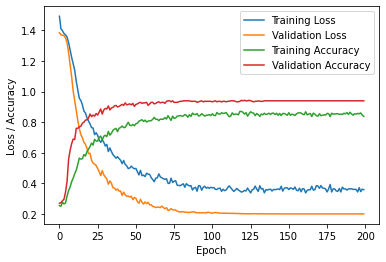

In [24]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss / Accuracy')
plt.legend()
plt.show()

## Pokus cislo 4

Architektura:
- 3 skryte vrstvy 
    - aktivacne fukcie: ReLU 
    - pocet neuronov: 16 - 16 - 8
    - dropout: 0.2 na 2. a 3. skrytu vrstvu
- vystupna vrstva
    - aktivacna fukcia: Softmax
    - pocet neuronov: 4

Hyperparametre:
- optimizer: Adam
- loss: sparse_categorical_crossentropy
- learnig rate: 0.001
    - strategia: ak neklesne loss po 5 epochach lr sa prenasobi 0.5 
- epochy: 200
- velkost batchu: 32

In [25]:
# Define the model architecture
# Initialize WandB
wandb.init(project="neural-network")
wandb.run.name = "Pokus cislo 4"
config = wandb.config
config.learning_rate = 0.001
config.batch_size = 32
config.epochs = 200

model = tf.keras.Sequential([
    tf.keras.layers.Dense(16, activation='relu', input_shape=(20,)),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(4, activation='softmax')
])

learning_rate = 0.001
optimizer = tf.keras.optimizers.Adam(learning_rate=config.learning_rate)

# Train the model
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

# Train the model
history  = model.fit(X_train, y_train, epochs=config.epochs, batch_size=config.batch_size, validation_data=(X_val, y_val),callbacks=[lr_scheduler,WandbCallback()] )


# Evaluate the model
val_loss, val_acc = model.evaluate(X_val, y_val, verbose=2)
print('Validation accuracy:', val_acc)
print('Validation loss:', val_loss)

# Make predictions
predictions = model.predict(X_val)
print('Predictions:', np.argmax(predictions, axis=1))

# Evaluate the model on the val set and log the results
wandb.log({'Validation loss': val_loss, 'Validation accuracy': val_acc})

Validation accuracy,▁
Validation loss,▁
accuracy,▁▂▄▅▆▆▆▇▇▇▇▇████████████████████████████
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,██▆▅▄▃▃▃▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr,███████████████▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▂▆▆▇▇▇█████████████████████████████████
val_loss,██▅▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation accuracy,0.94
Validation loss,0.20054
accuracy,0.83824


Epoch 1/200
50/54 [==========================>...] - ETA: 0s - loss: 1.4311 - accuracy: 0.2531

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201623-tcmjr8pf\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201623-tcmjr8pf\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201623-tcmjr8pf\files\model-best)... Done. 0.0s


54/54 [==============================] - 6s 70ms/step - loss: 1.4260 - accuracy: 0.2571 - val_loss: 1.3806 - val_accuracy: 0.2800 - lr: 0.0010
Epoch 2/200
42/54 [======================>.......] - ETA: 0s - loss: 1.3815 - accuracy: 0.2887

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201623-tcmjr8pf\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201623-tcmjr8pf\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201623-tcmjr8pf\files\model-best)... Done. 0.0s


54/54 [==============================] - 3s 49ms/step - loss: 1.3818 - accuracy: 0.2812 - val_loss: 1.3632 - val_accuracy: 0.3300 - lr: 0.0010
Epoch 3/200
52/54 [===========================>..] - ETA: 0s - loss: 1.3541 - accuracy: 0.3113

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201623-tcmjr8pf\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201623-tcmjr8pf\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201623-tcmjr8pf\files\model-best)... Done. 0.0s


54/54 [==============================] - 3s 52ms/step - loss: 1.3542 - accuracy: 0.3100 - val_loss: 1.3271 - val_accuracy: 0.3933 - lr: 0.0010
Epoch 4/200
37/54 [===================>..........] - ETA: 0s - loss: 1.3180 - accuracy: 0.3767

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201623-tcmjr8pf\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201623-tcmjr8pf\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201623-tcmjr8pf\files\model-best)... Done. 0.0s


54/54 [==============================] - 3s 63ms/step - loss: 1.3125 - accuracy: 0.3706 - val_loss: 1.2579 - val_accuracy: 0.4733 - lr: 0.0010
Epoch 5/200
50/54 [==========================>...] - ETA: 0s - loss: 1.2570 - accuracy: 0.4219

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201623-tcmjr8pf\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201623-tcmjr8pf\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201623-tcmjr8pf\files\model-best)... Done. 0.0s


54/54 [==============================] - 3s 64ms/step - loss: 1.2508 - accuracy: 0.4276 - val_loss: 1.1540 - val_accuracy: 0.5733 - lr: 0.0010
Epoch 6/200
47/54 [=========================>....] - ETA: 0s - loss: 1.1606 - accuracy: 0.4814

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201623-tcmjr8pf\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201623-tcmjr8pf\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201623-tcmjr8pf\files\model-best)... Done. 0.0s


54/54 [==============================] - 3s 63ms/step - loss: 1.1544 - accuracy: 0.4876 - val_loss: 1.0134 - val_accuracy: 0.6167 - lr: 0.0010
Epoch 7/200
44/54 [=======================>......] - ETA: 0s - loss: 1.0508 - accuracy: 0.5355

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201623-tcmjr8pf\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201623-tcmjr8pf\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201623-tcmjr8pf\files\model-best)... Done. 0.0s


54/54 [==============================] - 4s 73ms/step - loss: 1.0456 - accuracy: 0.5335 - val_loss: 0.8829 - val_accuracy: 0.6900 - lr: 0.0010
Epoch 8/200
45/54 [========================>.....] - ETA: 0s - loss: 0.9870 - accuracy: 0.5653

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201623-tcmjr8pf\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201623-tcmjr8pf\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201623-tcmjr8pf\files\model-best)... Done. 0.1s


54/54 [==============================] - 5s 91ms/step - loss: 0.9737 - accuracy: 0.5718 - val_loss: 0.7868 - val_accuracy: 0.7633 - lr: 0.0010
Epoch 9/200
45/54 [========================>.....] - ETA: 0s - loss: 0.9092 - accuracy: 0.6042

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201623-tcmjr8pf\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201623-tcmjr8pf\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201623-tcmjr8pf\files\model-best)... Done. 0.2s


54/54 [==============================] - 5s 91ms/step - loss: 0.9073 - accuracy: 0.5982 - val_loss: 0.7197 - val_accuracy: 0.8100 - lr: 0.0010
Epoch 10/200
50/54 [==========================>...] - ETA: 0s - loss: 0.8492 - accuracy: 0.6187

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201623-tcmjr8pf\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201623-tcmjr8pf\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201623-tcmjr8pf\files\model-best)... Done. 0.1s


54/54 [==============================] - 7s 129ms/step - loss: 0.8469 - accuracy: 0.6218 - val_loss: 0.6589 - val_accuracy: 0.8433 - lr: 0.0010
Epoch 11/200
46/54 [========================>.....] - ETA: 0s - loss: 0.7913 - accuracy: 0.6447

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201623-tcmjr8pf\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201623-tcmjr8pf\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201623-tcmjr8pf\files\model-best)... Done. 0.0s


54/54 [==============================] - 4s 71ms/step - loss: 0.7885 - accuracy: 0.6500 - val_loss: 0.6090 - val_accuracy: 0.8300 - lr: 0.0010
Epoch 12/200
52/54 [===========================>..] - ETA: 0s - loss: 0.7516 - accuracy: 0.6797

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201623-tcmjr8pf\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201623-tcmjr8pf\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201623-tcmjr8pf\files\model-best)... Done. 0.0s


54/54 [==============================] - 3s 56ms/step - loss: 0.7500 - accuracy: 0.6812 - val_loss: 0.5702 - val_accuracy: 0.8267 - lr: 0.0010
Epoch 13/200
36/54 [===================>..........] - ETA: 0s - loss: 0.7116 - accuracy: 0.7057

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201623-tcmjr8pf\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201623-tcmjr8pf\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201623-tcmjr8pf\files\model-best)... Done. 0.0s


54/54 [==============================] - 3s 51ms/step - loss: 0.7044 - accuracy: 0.7029 - val_loss: 0.5178 - val_accuracy: 0.8600 - lr: 0.0010
Epoch 14/200
40/54 [=====================>........] - ETA: 0s - loss: 0.7063 - accuracy: 0.6852

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201623-tcmjr8pf\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201623-tcmjr8pf\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201623-tcmjr8pf\files\model-best)... Done. 0.0s


54/54 [==============================] - 3s 56ms/step - loss: 0.7031 - accuracy: 0.6847 - val_loss: 0.4941 - val_accuracy: 0.8700 - lr: 0.0010
Epoch 15/200
50/54 [==========================>...] - ETA: 0s - loss: 0.6627 - accuracy: 0.7231

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201623-tcmjr8pf\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201623-tcmjr8pf\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201623-tcmjr8pf\files\model-best)... Done. 0.0s


54/54 [==============================] - 3s 48ms/step - loss: 0.6616 - accuracy: 0.7218 - val_loss: 0.4659 - val_accuracy: 0.8733 - lr: 0.0010
Epoch 16/200
54/54 [==============================] - ETA: 0s - loss: 0.6387 - accuracy: 0.7359

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201623-tcmjr8pf\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201623-tcmjr8pf\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201623-tcmjr8pf\files\model-best)... Done. 0.0s


54/54 [==============================] - 3s 49ms/step - loss: 0.6387 - accuracy: 0.7359 - val_loss: 0.4429 - val_accuracy: 0.8800 - lr: 0.0010
Epoch 17/200
41/54 [=====================>........] - ETA: 0s - loss: 0.6161 - accuracy: 0.7439

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201623-tcmjr8pf\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201623-tcmjr8pf\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201623-tcmjr8pf\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 44ms/step - loss: 0.6124 - accuracy: 0.7465 - val_loss: 0.4126 - val_accuracy: 0.8800 - lr: 0.0010
Epoch 18/200
39/54 [====================>.........] - ETA: 0s - loss: 0.5827 - accuracy: 0.7604

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201623-tcmjr8pf\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201623-tcmjr8pf\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201623-tcmjr8pf\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 43ms/step - loss: 0.5853 - accuracy: 0.7553 - val_loss: 0.3977 - val_accuracy: 0.8833 - lr: 0.0010
Epoch 19/200
39/54 [====================>.........] - ETA: 0s - loss: 0.5562 - accuracy: 0.7772

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201623-tcmjr8pf\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201623-tcmjr8pf\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201623-tcmjr8pf\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 43ms/step - loss: 0.5562 - accuracy: 0.7788 - val_loss: 0.3785 - val_accuracy: 0.8933 - lr: 0.0010
Epoch 20/200
54/54 [==============================] - 0s 4ms/step - loss: 0.5683 - accuracy: 0.7600 - val_loss: 0.3797 - val_accuracy: 0.8800 - lr: 0.0010
Epoch 21/200
45/54 [========================>.....] - ETA: 0s - loss: 0.5144 - accuracy: 0.7958

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201623-tcmjr8pf\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201623-tcmjr8pf\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201623-tcmjr8pf\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 40ms/step - loss: 0.5218 - accuracy: 0.7882 - val_loss: 0.3538 - val_accuracy: 0.8933 - lr: 0.0010
Epoch 22/200
42/54 [======================>.......] - ETA: 0s - loss: 0.5259 - accuracy: 0.7783

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201623-tcmjr8pf\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201623-tcmjr8pf\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201623-tcmjr8pf\files\model-best)... Done. 0.0s


54/54 [==============================] - 4s 71ms/step - loss: 0.5184 - accuracy: 0.7847 - val_loss: 0.3517 - val_accuracy: 0.9000 - lr: 0.0010
Epoch 23/200
42/54 [======================>.......] - ETA: 0s - loss: 0.5131 - accuracy: 0.7999

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201623-tcmjr8pf\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201623-tcmjr8pf\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201623-tcmjr8pf\files\model-best)... Done. 0.0s


54/54 [==============================] - 3s 54ms/step - loss: 0.5028 - accuracy: 0.8006 - val_loss: 0.3259 - val_accuracy: 0.9000 - lr: 0.0010
Epoch 24/200
54/54 [==============================] - 0s 4ms/step - loss: 0.5009 - accuracy: 0.7929 - val_loss: 0.3268 - val_accuracy: 0.8800 - lr: 0.0010
Epoch 25/200
42/54 [======================>.......] - ETA: 0s - loss: 0.4632 - accuracy: 0.8073

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201623-tcmjr8pf\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201623-tcmjr8pf\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201623-tcmjr8pf\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 41ms/step - loss: 0.4608 - accuracy: 0.8071 - val_loss: 0.3037 - val_accuracy: 0.9067 - lr: 0.0010
Epoch 26/200
43/54 [======================>.......] - ETA: 0s - loss: 0.4787 - accuracy: 0.8074

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201623-tcmjr8pf\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201623-tcmjr8pf\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201623-tcmjr8pf\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 43ms/step - loss: 0.4661 - accuracy: 0.8165 - val_loss: 0.2966 - val_accuracy: 0.9067 - lr: 0.0010
Epoch 27/200
48/54 [=========================>....] - ETA: 0s - loss: 0.4488 - accuracy: 0.8229

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201623-tcmjr8pf\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201623-tcmjr8pf\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201623-tcmjr8pf\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 46ms/step - loss: 0.4492 - accuracy: 0.8188 - val_loss: 0.2883 - val_accuracy: 0.9033 - lr: 0.0010
Epoch 28/200
42/54 [======================>.......] - ETA: 0s - loss: 0.4280 - accuracy: 0.8318

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201623-tcmjr8pf\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201623-tcmjr8pf\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201623-tcmjr8pf\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 46ms/step - loss: 0.4285 - accuracy: 0.8306 - val_loss: 0.2740 - val_accuracy: 0.9100 - lr: 0.0010
Epoch 29/200
54/54 [==============================] - 0s 5ms/step - loss: 0.4445 - accuracy: 0.8182 - val_loss: 0.2864 - val_accuracy: 0.9133 - lr: 0.0010
Epoch 30/200
52/54 [===========================>..] - ETA: 0s - loss: 0.4421 - accuracy: 0.8191

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201623-tcmjr8pf\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201623-tcmjr8pf\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201623-tcmjr8pf\files\model-best)... Done. 0.0s


54/54 [==============================] - 3s 53ms/step - loss: 0.4414 - accuracy: 0.8188 - val_loss: 0.2668 - val_accuracy: 0.9267 - lr: 0.0010
Epoch 31/200
54/54 [==============================] - 0s 4ms/step - loss: 0.3986 - accuracy: 0.8553 - val_loss: 0.2709 - val_accuracy: 0.9000 - lr: 0.0010
Epoch 32/200
41/54 [=====================>........] - ETA: 0s - loss: 0.3828 - accuracy: 0.8483

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201623-tcmjr8pf\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201623-tcmjr8pf\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201623-tcmjr8pf\files\model-best)... Done. 0.0s


54/54 [==============================] - 3s 52ms/step - loss: 0.3905 - accuracy: 0.8459 - val_loss: 0.2509 - val_accuracy: 0.9200 - lr: 0.0010
Epoch 33/200
43/54 [======================>.......] - ETA: 0s - loss: 0.3977 - accuracy: 0.8423

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201623-tcmjr8pf\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201623-tcmjr8pf\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201623-tcmjr8pf\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 43ms/step - loss: 0.4041 - accuracy: 0.8347 - val_loss: 0.2473 - val_accuracy: 0.9300 - lr: 0.0010
Epoch 34/200
49/54 [==========================>...] - ETA: 0s - loss: 0.3846 - accuracy: 0.8520

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201623-tcmjr8pf\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201623-tcmjr8pf\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201623-tcmjr8pf\files\model-best)... Done. 0.1s


54/54 [==============================] - 2s 43ms/step - loss: 0.3837 - accuracy: 0.8524 - val_loss: 0.2429 - val_accuracy: 0.9400 - lr: 0.0010
Epoch 35/200
48/54 [=========================>....] - ETA: 0s - loss: 0.3900 - accuracy: 0.8496

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201623-tcmjr8pf\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201623-tcmjr8pf\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201623-tcmjr8pf\files\model-best)... Done. 0.0s


54/54 [==============================] - 3s 62ms/step - loss: 0.3893 - accuracy: 0.8524 - val_loss: 0.2407 - val_accuracy: 0.9367 - lr: 0.0010
Epoch 36/200
54/54 [==============================] - 0s 4ms/step - loss: 0.4041 - accuracy: 0.8400 - val_loss: 0.2470 - val_accuracy: 0.9200 - lr: 0.0010
Epoch 37/200
54/54 [==============================] - 0s 4ms/step - loss: 0.3862 - accuracy: 0.8441 - val_loss: 0.2412 - val_accuracy: 0.9233 - lr: 0.0010
Epoch 38/200
43/54 [======================>.......] - ETA: 0s - loss: 0.3680 - accuracy: 0.8583

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201623-tcmjr8pf\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201623-tcmjr8pf\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201623-tcmjr8pf\files\model-best)... Done. 0.0s


54/54 [==============================] - 3s 51ms/step - loss: 0.3736 - accuracy: 0.8553 - val_loss: 0.2245 - val_accuracy: 0.9367 - lr: 0.0010
Epoch 39/200
43/54 [======================>.......] - ETA: 0s - loss: 0.3627 - accuracy: 0.8605

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201623-tcmjr8pf\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201623-tcmjr8pf\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201623-tcmjr8pf\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 45ms/step - loss: 0.3595 - accuracy: 0.8641 - val_loss: 0.2195 - val_accuracy: 0.9433 - lr: 0.0010
Epoch 40/200
54/54 [==============================] - 0s 4ms/step - loss: 0.3651 - accuracy: 0.8512 - val_loss: 0.2376 - val_accuracy: 0.9133 - lr: 0.0010
Epoch 41/200
53/54 [============================>.] - ETA: 0s - loss: 0.3594 - accuracy: 0.8520

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201623-tcmjr8pf\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201623-tcmjr8pf\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201623-tcmjr8pf\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 42ms/step - loss: 0.3600 - accuracy: 0.8518 - val_loss: 0.2189 - val_accuracy: 0.9300 - lr: 0.0010
Epoch 42/200
54/54 [==============================] - 0s 4ms/step - loss: 0.3351 - accuracy: 0.8706 - val_loss: 0.2206 - val_accuracy: 0.9233 - lr: 0.0010
Epoch 43/200
54/54 [==============================] - 0s 4ms/step - loss: 0.3597 - accuracy: 0.8635 - val_loss: 0.2357 - val_accuracy: 0.8900 - lr: 0.0010
Epoch 44/200
54/54 [==============================] - 0s 4ms/step - loss: 0.3385 - accuracy: 0.8665 - val_loss: 0.2270 - val_accuracy: 0.9167 - lr: 0.0010
Epoch 45/200
41/54 [=====================>........] - ETA: 0s - loss: 0.3386 - accuracy: 0.8643

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201623-tcmjr8pf\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201623-tcmjr8pf\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201623-tcmjr8pf\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 46ms/step - loss: 0.3437 - accuracy: 0.8629 - val_loss: 0.1966 - val_accuracy: 0.9400 - lr: 0.0010
Epoch 46/200
54/54 [==============================] - 0s 4ms/step - loss: 0.3483 - accuracy: 0.8688 - val_loss: 0.2068 - val_accuracy: 0.9300 - lr: 0.0010
Epoch 47/200
54/54 [==============================] - 0s 4ms/step - loss: 0.3418 - accuracy: 0.8635 - val_loss: 0.2096 - val_accuracy: 0.9333 - lr: 0.0010
Epoch 48/200
54/54 [==============================] - 0s 4ms/step - loss: 0.3224 - accuracy: 0.8771 - val_loss: 0.2025 - val_accuracy: 0.9267 - lr: 0.0010
Epoch 49/200
54/54 [==============================] - 0s 4ms/step - loss: 0.3451 - accuracy: 0.8635 - val_loss: 0.2006 - val_accuracy: 0.9400 - lr: 0.0010
Epoch 50/200
54/54 [==============================] - 0s 4ms/step - loss: 0.3200 - accuracy: 0.8747 - val_loss: 0.2073 - val_accuracy: 0.9233 - lr: 0.0010
Epoch 51/200
54/54 [==============================] - 0s 4ms/step - loss: 0.3177 -

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201623-tcmjr8pf\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201623-tcmjr8pf\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201623-tcmjr8pf\files\model-best)... Done. 0.0s


54/54 [==============================] - 3s 51ms/step - loss: 0.3120 - accuracy: 0.8765 - val_loss: 0.1946 - val_accuracy: 0.9367 - lr: 5.0000e-04
Epoch 53/200
54/54 [==============================] - 0s 4ms/step - loss: 0.3069 - accuracy: 0.8818 - val_loss: 0.1971 - val_accuracy: 0.9267 - lr: 5.0000e-04
Epoch 54/200
54/54 [==============================] - 0s 4ms/step - loss: 0.3237 - accuracy: 0.8671 - val_loss: 0.1980 - val_accuracy: 0.9333 - lr: 5.0000e-04
Epoch 55/200
54/54 [==============================] - 0s 4ms/step - loss: 0.2997 - accuracy: 0.8841 - val_loss: 0.1967 - val_accuracy: 0.9233 - lr: 5.0000e-04
Epoch 56/200
54/54 [==============================] - 0s 4ms/step - loss: 0.2833 - accuracy: 0.8935 - val_loss: 0.1963 - val_accuracy: 0.9267 - lr: 5.0000e-04
Epoch 57/200
54/54 [==============================] - 0s 4ms/step - loss: 0.2967 - accuracy: 0.8829 - val_loss: 0.1969 - val_accuracy: 0.9233 - lr: 5.0000e-04
Epoch 58/200
54/54 [==============================] - 0s 4

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201623-tcmjr8pf\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201623-tcmjr8pf\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201623-tcmjr8pf\files\model-best)... Done. 0.0s


54/54 [==============================] - 3s 50ms/step - loss: 0.3082 - accuracy: 0.8829 - val_loss: 0.1879 - val_accuracy: 0.9367 - lr: 2.5000e-04
Epoch 60/200
54/54 [==============================] - 0s 4ms/step - loss: 0.2968 - accuracy: 0.8847 - val_loss: 0.1891 - val_accuracy: 0.9367 - lr: 2.5000e-04
Epoch 61/200
39/54 [====================>.........] - ETA: 0s - loss: 0.3105 - accuracy: 0.8750

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201623-tcmjr8pf\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201623-tcmjr8pf\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201623-tcmjr8pf\files\model-best)... Done. 0.0s


54/54 [==============================] - 3s 51ms/step - loss: 0.3104 - accuracy: 0.8747 - val_loss: 0.1860 - val_accuracy: 0.9367 - lr: 2.5000e-04
Epoch 62/200
54/54 [==============================] - 0s 5ms/step - loss: 0.2966 - accuracy: 0.8859 - val_loss: 0.1889 - val_accuracy: 0.9367 - lr: 2.5000e-04
Epoch 63/200
54/54 [==============================] - 0s 6ms/step - loss: 0.2960 - accuracy: 0.8894 - val_loss: 0.1895 - val_accuracy: 0.9300 - lr: 2.5000e-04
Epoch 64/200
54/54 [==============================] - 0s 5ms/step - loss: 0.2821 - accuracy: 0.8982 - val_loss: 0.1873 - val_accuracy: 0.9333 - lr: 2.5000e-04
Epoch 65/200
54/54 [==============================] - 0s 4ms/step - loss: 0.2879 - accuracy: 0.8912 - val_loss: 0.1881 - val_accuracy: 0.9300 - lr: 2.5000e-04
Epoch 66/200
54/54 [==============================] - 0s 4ms/step - loss: 0.3119 - accuracy: 0.8859 - val_loss: 0.1946 - val_accuracy: 0.9367 - lr: 2.5000e-04
Epoch 67/200
45/54 [========================>.....] - ETA:

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201623-tcmjr8pf\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201623-tcmjr8pf\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201623-tcmjr8pf\files\model-best)... Done. 0.0s


54/54 [==============================] - 3s 63ms/step - loss: 0.2960 - accuracy: 0.8924 - val_loss: 0.1821 - val_accuracy: 0.9333 - lr: 1.2500e-04
Epoch 68/200
45/54 [========================>.....] - ETA: 0s - loss: 0.2963 - accuracy: 0.8813

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201623-tcmjr8pf\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201623-tcmjr8pf\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201623-tcmjr8pf\files\model-best)... Done. 0.0s


54/54 [==============================] - 4s 75ms/step - loss: 0.2822 - accuracy: 0.8912 - val_loss: 0.1807 - val_accuracy: 0.9367 - lr: 1.2500e-04
Epoch 69/200
53/54 [============================>.] - ETA: 0s - loss: 0.3011 - accuracy: 0.8874

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201623-tcmjr8pf\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201623-tcmjr8pf\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201623-tcmjr8pf\files\model-best)... Done. 0.0s


54/54 [==============================] - 3s 63ms/step - loss: 0.3006 - accuracy: 0.8876 - val_loss: 0.1792 - val_accuracy: 0.9433 - lr: 1.2500e-04
Epoch 70/200
54/54 [==============================] - 0s 4ms/step - loss: 0.2890 - accuracy: 0.8894 - val_loss: 0.1809 - val_accuracy: 0.9400 - lr: 1.2500e-04
Epoch 71/200
54/54 [==============================] - 0s 5ms/step - loss: 0.3025 - accuracy: 0.8812 - val_loss: 0.1819 - val_accuracy: 0.9433 - lr: 1.2500e-04
Epoch 72/200
54/54 [==============================] - 0s 4ms/step - loss: 0.2938 - accuracy: 0.8871 - val_loss: 0.1845 - val_accuracy: 0.9333 - lr: 1.2500e-04
Epoch 73/200
46/54 [========================>.....] - ETA: 0s - loss: 0.2639 - accuracy: 0.9062

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201623-tcmjr8pf\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201623-tcmjr8pf\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201623-tcmjr8pf\files\model-best)... Done. 0.0s


54/54 [==============================] - 4s 78ms/step - loss: 0.2727 - accuracy: 0.9012 - val_loss: 0.1791 - val_accuracy: 0.9400 - lr: 1.2500e-04
Epoch 74/200
54/54 [==============================] - 0s 5ms/step - loss: 0.2804 - accuracy: 0.9029 - val_loss: 0.1811 - val_accuracy: 0.9333 - lr: 1.2500e-04
Epoch 75/200
39/54 [====================>.........] - ETA: 0s - loss: 0.2804 - accuracy: 0.9014

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201623-tcmjr8pf\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201623-tcmjr8pf\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201623-tcmjr8pf\files\model-best)... Done. 0.0s


54/54 [==============================] - 3s 51ms/step - loss: 0.2882 - accuracy: 0.8988 - val_loss: 0.1779 - val_accuracy: 0.9433 - lr: 1.2500e-04
Epoch 76/200
54/54 [==============================] - 0s 5ms/step - loss: 0.2995 - accuracy: 0.8835 - val_loss: 0.1782 - val_accuracy: 0.9400 - lr: 1.2500e-04
Epoch 77/200
54/54 [==============================] - 0s 5ms/step - loss: 0.2961 - accuracy: 0.8918 - val_loss: 0.1790 - val_accuracy: 0.9400 - lr: 1.2500e-04
Epoch 78/200
54/54 [==============================] - 0s 5ms/step - loss: 0.2865 - accuracy: 0.8894 - val_loss: 0.1797 - val_accuracy: 0.9433 - lr: 1.2500e-04
Epoch 79/200
54/54 [==============================] - 0s 4ms/step - loss: 0.2805 - accuracy: 0.8871 - val_loss: 0.1807 - val_accuracy: 0.9400 - lr: 1.2500e-04
Epoch 80/200
54/54 [==============================] - 0s 5ms/step - loss: 0.2666 - accuracy: 0.9035 - val_loss: 0.1791 - val_accuracy: 0.9400 - lr: 1.2500e-04
Epoch 81/200
54/54 [==============================] - 0s 5

54/54 [==============================] - 0s 4ms/step - loss: 0.3058 - accuracy: 0.8806 - val_loss: 0.1787 - val_accuracy: 0.9367 - lr: 1.1921e-10
Epoch 178/200
54/54 [==============================] - 0s 4ms/step - loss: 0.2697 - accuracy: 0.9006 - val_loss: 0.1787 - val_accuracy: 0.9367 - lr: 1.1921e-10
Epoch 179/200
54/54 [==============================] - 0s 4ms/step - loss: 0.2827 - accuracy: 0.8941 - val_loss: 0.1787 - val_accuracy: 0.9367 - lr: 1.1921e-10
Epoch 180/200
54/54 [==============================] - 0s 4ms/step - loss: 0.2767 - accuracy: 0.8906 - val_loss: 0.1787 - val_accuracy: 0.9367 - lr: 1.1921e-10
Epoch 181/200
54/54 [==============================] - 0s 4ms/step - loss: 0.2827 - accuracy: 0.8906 - val_loss: 0.1787 - val_accuracy: 0.9367 - lr: 5.9605e-11
Epoch 182/200
54/54 [==============================] - 0s 4ms/step - loss: 0.2850 - accuracy: 0.8959 - val_loss: 0.1787 - val_accuracy: 0.9367 - lr: 5.9605e-11
Epoch 183/200
54/54 [==============================] -

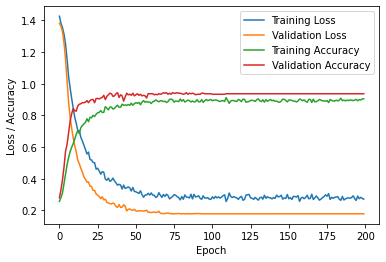

In [26]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss / Accuracy')
plt.legend()
plt.show()

## Pokus cislo 5


Architektura:
- 2 skryte vrstvy 
    - aktivacne fukcie: ReLU 
    - pocet neuronov: 16 - 8
- vystupna vrstva
    - aktivacna fukcia: Softmax
    - pocet neuronov: 4

Hyperparametre:
- optimizer: Adam
- loss: sparse_categorical_crossentropy
- learnig rate: 0.001
    - strategia: ak neklesne loss po 5 epochach lr sa prenasobi 0.5 
- epochy: 150
- velkost batchu: 32

In [27]:
# Define the model architecture
# Initialize WandB
wandb.init(project="neural-network")
wandb.run.name = "Pokus cislo 5"
config = wandb.config
config.learning_rate = 0.001
config.batch_size = 32
config.epochs = 150

model = tf.keras.Sequential([
    tf.keras.layers.Dense(16, activation='relu', input_shape=(20,)),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(4, activation='softmax')
])

learning_rate = 0.001
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

# Train the model
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5)

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

# Train the model
history  = model.fit(X_train, y_train, epochs=config.epochs, batch_size=config.batch_size, validation_data=(X_val, y_val),callbacks=[lr_scheduler,WandbCallback()] )

# Evaluate the model
val_loss, val_acc = model.evaluate(X_val, y_val, verbose=2)
print('Validation accuracy:', val_acc)
print('Validation loss:', val_loss)

# Make predictions
predictions = model.predict(X_val)
print('Predictions:', np.argmax(predictions, axis=1))

# Evaluate the model on the val set and log the results
wandb.log({'Validation loss': val_loss, 'Validation accuracy': val_acc})

Validation accuracy,▁
Validation loss,▁
accuracy,▁▃▅▆▇▇▇▇████████████████████████████████
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▇▄▃▃▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr,██████████▄▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▄▇▇████████████████████████████████████
val_loss,█▆▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation accuracy,0.93667
Validation loss,0.17866
accuracy,0.90529


Epoch 1/150
 1/54 [..............................] - ETA: 1:04 - loss: 1.4118 - accuracy: 0.1875WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0024s vs `on_train_batch_end` time: 0.0028s). Check your callbacks.


53/54 [============================>.] - ETA: 0s - loss: 1.3936 - accuracy: 0.2294

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201921-iun9uiys\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201921-iun9uiys\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201921-iun9uiys\files\model-best)... Done. 0.0s


54/54 [==============================] - 3s 42ms/step - loss: 1.3936 - accuracy: 0.2294 - val_loss: 1.3866 - val_accuracy: 0.2467 - lr: 0.0010
Epoch 2/150
54/54 [==============================] - ETA: 0s - loss: 1.3837 - accuracy: 0.2818

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201921-iun9uiys\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201921-iun9uiys\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201921-iun9uiys\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 31ms/step - loss: 1.3837 - accuracy: 0.2818 - val_loss: 1.3826 - val_accuracy: 0.2900 - lr: 0.0010
Epoch 3/150
38/54 [====================>.........] - ETA: 0s - loss: 1.3768 - accuracy: 0.3117

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201921-iun9uiys\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201921-iun9uiys\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201921-iun9uiys\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 36ms/step - loss: 1.3768 - accuracy: 0.3082 - val_loss: 1.3781 - val_accuracy: 0.2733 - lr: 0.0010
Epoch 4/150
49/54 [==========================>...] - ETA: 0s - loss: 1.3688 - accuracy: 0.3253

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201921-iun9uiys\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201921-iun9uiys\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201921-iun9uiys\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 30ms/step - loss: 1.3673 - accuracy: 0.3259 - val_loss: 1.3684 - val_accuracy: 0.2933 - lr: 0.0010
Epoch 5/150
35/54 [==================>...........] - ETA: 0s - loss: 1.3496 - accuracy: 0.3384

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201921-iun9uiys\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201921-iun9uiys\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201921-iun9uiys\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 34ms/step - loss: 1.3442 - accuracy: 0.3335 - val_loss: 1.3259 - val_accuracy: 0.3633 - lr: 0.0010
Epoch 6/150
42/54 [======================>.......] - ETA: 0s - loss: 1.2944 - accuracy: 0.4226

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201921-iun9uiys\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201921-iun9uiys\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201921-iun9uiys\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 35ms/step - loss: 1.2858 - accuracy: 0.4335 - val_loss: 1.2484 - val_accuracy: 0.4800 - lr: 0.0010
Epoch 7/150
48/54 [=========================>....] - ETA: 0s - loss: 1.2046 - accuracy: 0.5215

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201921-iun9uiys\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201921-iun9uiys\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201921-iun9uiys\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 31ms/step - loss: 1.2008 - accuracy: 0.5224 - val_loss: 1.1495 - val_accuracy: 0.6067 - lr: 0.0010
Epoch 8/150
48/54 [=========================>....] - ETA: 0s - loss: 1.1078 - accuracy: 0.5853

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201921-iun9uiys\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201921-iun9uiys\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201921-iun9uiys\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 43ms/step - loss: 1.1009 - accuracy: 0.5900 - val_loss: 1.0488 - val_accuracy: 0.6767 - lr: 0.0010
Epoch 9/150
40/54 [=====================>........] - ETA: 0s - loss: 1.0113 - accuracy: 0.6133

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201921-iun9uiys\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201921-iun9uiys\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201921-iun9uiys\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 38ms/step - loss: 1.0062 - accuracy: 0.6106 - val_loss: 0.9616 - val_accuracy: 0.7033 - lr: 0.0010
Epoch 10/150
48/54 [=========================>....] - ETA: 0s - loss: 0.9213 - accuracy: 0.6706

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201921-iun9uiys\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201921-iun9uiys\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201921-iun9uiys\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 32ms/step - loss: 0.9186 - accuracy: 0.6735 - val_loss: 0.8733 - val_accuracy: 0.7633 - lr: 0.0010
Epoch 11/150
45/54 [========================>.....] - ETA: 0s - loss: 0.8543 - accuracy: 0.7229

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201921-iun9uiys\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201921-iun9uiys\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201921-iun9uiys\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 39ms/step - loss: 0.8439 - accuracy: 0.7300 - val_loss: 0.8018 - val_accuracy: 0.7967 - lr: 0.0010
Epoch 12/150
44/54 [=======================>......] - ETA: 0s - loss: 0.7814 - accuracy: 0.7443

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201921-iun9uiys\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201921-iun9uiys\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201921-iun9uiys\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 34ms/step - loss: 0.7793 - accuracy: 0.7500 - val_loss: 0.7438 - val_accuracy: 0.7867 - lr: 0.0010
Epoch 13/150
45/54 [========================>.....] - ETA: 0s - loss: 0.7305 - accuracy: 0.7778

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201921-iun9uiys\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201921-iun9uiys\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201921-iun9uiys\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 40ms/step - loss: 0.7245 - accuracy: 0.7824 - val_loss: 0.6855 - val_accuracy: 0.8367 - lr: 0.0010
Epoch 14/150
50/54 [==========================>...] - ETA: 0s - loss: 0.6772 - accuracy: 0.8069

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201921-iun9uiys\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201921-iun9uiys\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201921-iun9uiys\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 36ms/step - loss: 0.6732 - accuracy: 0.8076 - val_loss: 0.6377 - val_accuracy: 0.8433 - lr: 0.0010
Epoch 15/150
51/54 [===========================>..] - ETA: 0s - loss: 0.6289 - accuracy: 0.8150

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201921-iun9uiys\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201921-iun9uiys\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201921-iun9uiys\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 30ms/step - loss: 0.6291 - accuracy: 0.8159 - val_loss: 0.5945 - val_accuracy: 0.8533 - lr: 0.0010
Epoch 16/150
52/54 [===========================>..] - ETA: 0s - loss: 0.5875 - accuracy: 0.8305

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201921-iun9uiys\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201921-iun9uiys\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201921-iun9uiys\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 30ms/step - loss: 0.5881 - accuracy: 0.8306 - val_loss: 0.5577 - val_accuracy: 0.8667 - lr: 0.0010
Epoch 17/150
44/54 [=======================>......] - ETA: 0s - loss: 0.5528 - accuracy: 0.8366

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201921-iun9uiys\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201921-iun9uiys\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201921-iun9uiys\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 35ms/step - loss: 0.5537 - accuracy: 0.8353 - val_loss: 0.5336 - val_accuracy: 0.8500 - lr: 0.0010
Epoch 18/150
47/54 [=========================>....] - ETA: 0s - loss: 0.5225 - accuracy: 0.8438

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201921-iun9uiys\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201921-iun9uiys\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201921-iun9uiys\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 32ms/step - loss: 0.5247 - accuracy: 0.8441 - val_loss: 0.4950 - val_accuracy: 0.8800 - lr: 0.0010
Epoch 19/150
45/54 [========================>.....] - ETA: 0s - loss: 0.5023 - accuracy: 0.8438

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201921-iun9uiys\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201921-iun9uiys\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201921-iun9uiys\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 32ms/step - loss: 0.4968 - accuracy: 0.8459 - val_loss: 0.4715 - val_accuracy: 0.8733 - lr: 0.0010
Epoch 20/150
42/54 [======================>.......] - ETA: 0s - loss: 0.4719 - accuracy: 0.8661

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201921-iun9uiys\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201921-iun9uiys\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201921-iun9uiys\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 39ms/step - loss: 0.4691 - accuracy: 0.8682 - val_loss: 0.4477 - val_accuracy: 0.8867 - lr: 0.0010
Epoch 21/150
40/54 [=====================>........] - ETA: 0s - loss: 0.4463 - accuracy: 0.8719

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201921-iun9uiys\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201921-iun9uiys\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201921-iun9uiys\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 33ms/step - loss: 0.4479 - accuracy: 0.8712 - val_loss: 0.4311 - val_accuracy: 0.8867 - lr: 0.0010
Epoch 22/150
43/54 [======================>.......] - ETA: 0s - loss: 0.4366 - accuracy: 0.8794

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201921-iun9uiys\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201921-iun9uiys\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201921-iun9uiys\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 36ms/step - loss: 0.4282 - accuracy: 0.8835 - val_loss: 0.4144 - val_accuracy: 0.8833 - lr: 0.0010
Epoch 23/150
45/54 [========================>.....] - ETA: 0s - loss: 0.4090 - accuracy: 0.8826

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201921-iun9uiys\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201921-iun9uiys\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201921-iun9uiys\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 35ms/step - loss: 0.4073 - accuracy: 0.8853 - val_loss: 0.3993 - val_accuracy: 0.8933 - lr: 0.0010
Epoch 24/150
42/54 [======================>.......] - ETA: 0s - loss: 0.4000 - accuracy: 0.8839

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201921-iun9uiys\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201921-iun9uiys\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201921-iun9uiys\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 30ms/step - loss: 0.3903 - accuracy: 0.8882 - val_loss: 0.3784 - val_accuracy: 0.8900 - lr: 0.0010
Epoch 25/150
46/54 [========================>.....] - ETA: 0s - loss: 0.3705 - accuracy: 0.9022

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201921-iun9uiys\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201921-iun9uiys\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201921-iun9uiys\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 36ms/step - loss: 0.3750 - accuracy: 0.9024 - val_loss: 0.3635 - val_accuracy: 0.8900 - lr: 0.0010
Epoch 26/150
47/54 [=========================>....] - ETA: 0s - loss: 0.3608 - accuracy: 0.9016

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201921-iun9uiys\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201921-iun9uiys\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201921-iun9uiys\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 32ms/step - loss: 0.3599 - accuracy: 0.9012 - val_loss: 0.3496 - val_accuracy: 0.9067 - lr: 0.0010
Epoch 27/150
46/54 [========================>.....] - ETA: 0s - loss: 0.3467 - accuracy: 0.9056

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201921-iun9uiys\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201921-iun9uiys\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201921-iun9uiys\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 32ms/step - loss: 0.3457 - accuracy: 0.9059 - val_loss: 0.3424 - val_accuracy: 0.8967 - lr: 0.0010
Epoch 28/150
35/54 [==================>...........] - ETA: 0s - loss: 0.3324 - accuracy: 0.9045

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201921-iun9uiys\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201921-iun9uiys\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201921-iun9uiys\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 36ms/step - loss: 0.3366 - accuracy: 0.8971 - val_loss: 0.3329 - val_accuracy: 0.9000 - lr: 0.0010
Epoch 29/150
48/54 [=========================>....] - ETA: 0s - loss: 0.3268 - accuracy: 0.9030

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201921-iun9uiys\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201921-iun9uiys\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201921-iun9uiys\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 31ms/step - loss: 0.3256 - accuracy: 0.9053 - val_loss: 0.3270 - val_accuracy: 0.9000 - lr: 0.0010
Epoch 30/150
47/54 [=========================>....] - ETA: 0s - loss: 0.3140 - accuracy: 0.9082

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201921-iun9uiys\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201921-iun9uiys\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201921-iun9uiys\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 33ms/step - loss: 0.3136 - accuracy: 0.9094 - val_loss: 0.3116 - val_accuracy: 0.8967 - lr: 0.0010
Epoch 31/150
42/54 [======================>.......] - ETA: 0s - loss: 0.2981 - accuracy: 0.9167

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201921-iun9uiys\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201921-iun9uiys\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201921-iun9uiys\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 38ms/step - loss: 0.3038 - accuracy: 0.9106 - val_loss: 0.3042 - val_accuracy: 0.9000 - lr: 0.0010
Epoch 32/150
35/54 [==================>...........] - ETA: 0s - loss: 0.2946 - accuracy: 0.9205

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201921-iun9uiys\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201921-iun9uiys\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201921-iun9uiys\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 32ms/step - loss: 0.2932 - accuracy: 0.9171 - val_loss: 0.2921 - val_accuracy: 0.9100 - lr: 0.0010
Epoch 33/150
50/54 [==========================>...] - ETA: 0s - loss: 0.2862 - accuracy: 0.9187

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201921-iun9uiys\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201921-iun9uiys\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201921-iun9uiys\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 31ms/step - loss: 0.2892 - accuracy: 0.9165 - val_loss: 0.2846 - val_accuracy: 0.9067 - lr: 0.0010
Epoch 34/150
47/54 [=========================>....] - ETA: 0s - loss: 0.2823 - accuracy: 0.9156

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201921-iun9uiys\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201921-iun9uiys\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201921-iun9uiys\files\model-best)... Done. 0.0s


54/54 [==============================] - 3s 48ms/step - loss: 0.2803 - accuracy: 0.9147 - val_loss: 0.2800 - val_accuracy: 0.9133 - lr: 0.0010
Epoch 35/150
51/54 [===========================>..] - ETA: 0s - loss: 0.2712 - accuracy: 0.9179

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201921-iun9uiys\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201921-iun9uiys\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201921-iun9uiys\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 30ms/step - loss: 0.2709 - accuracy: 0.9188 - val_loss: 0.2736 - val_accuracy: 0.9000 - lr: 0.0010
Epoch 36/150
52/54 [===========================>..] - ETA: 0s - loss: 0.2650 - accuracy: 0.9237

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201921-iun9uiys\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201921-iun9uiys\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201921-iun9uiys\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 30ms/step - loss: 0.2647 - accuracy: 0.9241 - val_loss: 0.2672 - val_accuracy: 0.9100 - lr: 0.0010
Epoch 37/150
45/54 [========================>.....] - ETA: 0s - loss: 0.2612 - accuracy: 0.9187

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201921-iun9uiys\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201921-iun9uiys\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201921-iun9uiys\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 35ms/step - loss: 0.2578 - accuracy: 0.9212 - val_loss: 0.2632 - val_accuracy: 0.9067 - lr: 0.0010
Epoch 38/150
43/54 [======================>.......] - ETA: 0s - loss: 0.2570 - accuracy: 0.9172

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201921-iun9uiys\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201921-iun9uiys\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201921-iun9uiys\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 30ms/step - loss: 0.2555 - accuracy: 0.9200 - val_loss: 0.2604 - val_accuracy: 0.9133 - lr: 0.0010
Epoch 39/150
48/54 [=========================>....] - ETA: 0s - loss: 0.2493 - accuracy: 0.9212

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201921-iun9uiys\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201921-iun9uiys\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201921-iun9uiys\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 29ms/step - loss: 0.2488 - accuracy: 0.9224 - val_loss: 0.2557 - val_accuracy: 0.9133 - lr: 0.0010
Epoch 40/150
45/54 [========================>.....] - ETA: 0s - loss: 0.2429 - accuracy: 0.9243

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201921-iun9uiys\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201921-iun9uiys\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201921-iun9uiys\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 34ms/step - loss: 0.2430 - accuracy: 0.9253 - val_loss: 0.2498 - val_accuracy: 0.9067 - lr: 0.0010
Epoch 41/150
48/54 [=========================>....] - ETA: 0s - loss: 0.2401 - accuracy: 0.9212

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201921-iun9uiys\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201921-iun9uiys\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201921-iun9uiys\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 30ms/step - loss: 0.2373 - accuracy: 0.9235 - val_loss: 0.2484 - val_accuracy: 0.9133 - lr: 0.0010
Epoch 42/150
40/54 [=====================>........] - ETA: 0s - loss: 0.2240 - accuracy: 0.9312

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201921-iun9uiys\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201921-iun9uiys\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201921-iun9uiys\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 29ms/step - loss: 0.2311 - accuracy: 0.9265 - val_loss: 0.2394 - val_accuracy: 0.9200 - lr: 0.0010
Epoch 43/150
54/54 [==============================] - 0s 3ms/step - loss: 0.2277 - accuracy: 0.9235 - val_loss: 0.2438 - val_accuracy: 0.9000 - lr: 0.0010
Epoch 44/150
52/54 [===========================>..] - ETA: 0s - loss: 0.2227 - accuracy: 0.9273

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201921-iun9uiys\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201921-iun9uiys\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201921-iun9uiys\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 35ms/step - loss: 0.2230 - accuracy: 0.9271 - val_loss: 0.2316 - val_accuracy: 0.9100 - lr: 0.0010
Epoch 45/150
40/54 [=====================>........] - ETA: 0s - loss: 0.2166 - accuracy: 0.9352

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201921-iun9uiys\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201921-iun9uiys\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201921-iun9uiys\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 34ms/step - loss: 0.2208 - accuracy: 0.9335 - val_loss: 0.2311 - val_accuracy: 0.9067 - lr: 0.0010
Epoch 46/150
54/54 [==============================] - 0s 4ms/step - loss: 0.2141 - accuracy: 0.9282 - val_loss: 0.2338 - val_accuracy: 0.9133 - lr: 0.0010
Epoch 47/150
35/54 [==================>...........] - ETA: 0s - loss: 0.2149 - accuracy: 0.9268

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201921-iun9uiys\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201921-iun9uiys\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201921-iun9uiys\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 36ms/step - loss: 0.2117 - accuracy: 0.9335 - val_loss: 0.2242 - val_accuracy: 0.9167 - lr: 0.0010
Epoch 48/150
39/54 [====================>.........] - ETA: 0s - loss: 0.2143 - accuracy: 0.9263

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201921-iun9uiys\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201921-iun9uiys\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201921-iun9uiys\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 39ms/step - loss: 0.2089 - accuracy: 0.9300 - val_loss: 0.2182 - val_accuracy: 0.9267 - lr: 0.0010
Epoch 49/150
42/54 [======================>.......] - ETA: 0s - loss: 0.2129 - accuracy: 0.9271

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201921-iun9uiys\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201921-iun9uiys\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201921-iun9uiys\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 33ms/step - loss: 0.2074 - accuracy: 0.9306 - val_loss: 0.2161 - val_accuracy: 0.9200 - lr: 0.0010
Epoch 50/150
39/54 [====================>.........] - ETA: 0s - loss: 0.1997 - accuracy: 0.9327

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201921-iun9uiys\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201921-iun9uiys\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201921-iun9uiys\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 35ms/step - loss: 0.2010 - accuracy: 0.9341 - val_loss: 0.2125 - val_accuracy: 0.9233 - lr: 0.0010
Epoch 51/150
37/54 [===================>..........] - ETA: 0s - loss: 0.1945 - accuracy: 0.9451

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201921-iun9uiys\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201921-iun9uiys\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201921-iun9uiys\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 31ms/step - loss: 0.1948 - accuracy: 0.9406 - val_loss: 0.2093 - val_accuracy: 0.9233 - lr: 0.0010
Epoch 52/150
54/54 [==============================] - 0s 3ms/step - loss: 0.1947 - accuracy: 0.9312 - val_loss: 0.2107 - val_accuracy: 0.9167 - lr: 0.0010
Epoch 53/150
48/54 [=========================>....] - ETA: 0s - loss: 0.1972 - accuracy: 0.9362

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201921-iun9uiys\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201921-iun9uiys\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201921-iun9uiys\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 32ms/step - loss: 0.1936 - accuracy: 0.9388 - val_loss: 0.2066 - val_accuracy: 0.9200 - lr: 0.0010
Epoch 54/150
49/54 [==========================>...] - ETA: 0s - loss: 0.1877 - accuracy: 0.9407

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201921-iun9uiys\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201921-iun9uiys\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201921-iun9uiys\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 45ms/step - loss: 0.1882 - accuracy: 0.9394 - val_loss: 0.2040 - val_accuracy: 0.9233 - lr: 0.0010
Epoch 55/150
43/54 [======================>.......] - ETA: 0s - loss: 0.1833 - accuracy: 0.9440

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201921-iun9uiys\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201921-iun9uiys\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201921-iun9uiys\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 34ms/step - loss: 0.1847 - accuracy: 0.9435 - val_loss: 0.1999 - val_accuracy: 0.9267 - lr: 0.0010
Epoch 56/150
54/54 [==============================] - 0s 4ms/step - loss: 0.1818 - accuracy: 0.9400 - val_loss: 0.2007 - val_accuracy: 0.9133 - lr: 0.0010
Epoch 57/150
54/54 [==============================] - 0s 4ms/step - loss: 0.1815 - accuracy: 0.9418 - val_loss: 0.2007 - val_accuracy: 0.9133 - lr: 0.0010
Epoch 58/150
44/54 [=======================>......] - ETA: 0s - loss: 0.1811 - accuracy: 0.9403

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201921-iun9uiys\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201921-iun9uiys\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201921-iun9uiys\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 30ms/step - loss: 0.1844 - accuracy: 0.9376 - val_loss: 0.1980 - val_accuracy: 0.9167 - lr: 0.0010
Epoch 59/150
45/54 [========================>.....] - ETA: 0s - loss: 0.1779 - accuracy: 0.9444

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201921-iun9uiys\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201921-iun9uiys\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201921-iun9uiys\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 39ms/step - loss: 0.1753 - accuracy: 0.9447 - val_loss: 0.1897 - val_accuracy: 0.9433 - lr: 0.0010
Epoch 60/150
52/54 [===========================>..] - ETA: 0s - loss: 0.1707 - accuracy: 0.9471

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201921-iun9uiys\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201921-iun9uiys\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201921-iun9uiys\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 31ms/step - loss: 0.1732 - accuracy: 0.9453 - val_loss: 0.1882 - val_accuracy: 0.9333 - lr: 0.0010
Epoch 61/150
54/54 [==============================] - 0s 4ms/step - loss: 0.1698 - accuracy: 0.9453 - val_loss: 0.1892 - val_accuracy: 0.9367 - lr: 0.0010
Epoch 62/150
49/54 [==========================>...] - ETA: 0s - loss: 0.1662 - accuracy: 0.9503

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201921-iun9uiys\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201921-iun9uiys\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201921-iun9uiys\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 32ms/step - loss: 0.1681 - accuracy: 0.9482 - val_loss: 0.1867 - val_accuracy: 0.9333 - lr: 0.0010
Epoch 63/150
49/54 [==========================>...] - ETA: 0s - loss: 0.1640 - accuracy: 0.9515

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201921-iun9uiys\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201921-iun9uiys\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201921-iun9uiys\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 29ms/step - loss: 0.1654 - accuracy: 0.9500 - val_loss: 0.1811 - val_accuracy: 0.9400 - lr: 0.0010
Epoch 64/150
54/54 [==============================] - 0s 4ms/step - loss: 0.1675 - accuracy: 0.9471 - val_loss: 0.1851 - val_accuracy: 0.9233 - lr: 0.0010
Epoch 65/150
51/54 [===========================>..] - ETA: 0s - loss: 0.1598 - accuracy: 0.9479

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201921-iun9uiys\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201921-iun9uiys\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201921-iun9uiys\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 30ms/step - loss: 0.1622 - accuracy: 0.9471 - val_loss: 0.1770 - val_accuracy: 0.9400 - lr: 0.0010
Epoch 66/150
54/54 [==============================] - 0s 3ms/step - loss: 0.1591 - accuracy: 0.9535 - val_loss: 0.1806 - val_accuracy: 0.9433 - lr: 0.0010
Epoch 67/150
54/54 [==============================] - 0s 3ms/step - loss: 0.1593 - accuracy: 0.9506 - val_loss: 0.1874 - val_accuracy: 0.9200 - lr: 0.0010
Epoch 68/150
54/54 [==============================] - 0s 3ms/step - loss: 0.1574 - accuracy: 0.9541 - val_loss: 0.1773 - val_accuracy: 0.9500 - lr: 0.0010
Epoch 69/150
54/54 [==============================] - 0s 3ms/step - loss: 0.1536 - accuracy: 0.9565 - val_loss: 0.2019 - val_accuracy: 0.9100 - lr: 0.0010
Epoch 70/150
51/54 [===========================>..] - ETA: 0s - loss: 0.1571 - accuracy: 0.9473

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201921-iun9uiys\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201921-iun9uiys\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201921-iun9uiys\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 35ms/step - loss: 0.1561 - accuracy: 0.9482 - val_loss: 0.1715 - val_accuracy: 0.9500 - lr: 0.0010
Epoch 71/150
54/54 [==============================] - 0s 4ms/step - loss: 0.1492 - accuracy: 0.9571 - val_loss: 0.1719 - val_accuracy: 0.9400 - lr: 0.0010
Epoch 72/150
49/54 [==========================>...] - ETA: 0s - loss: 0.1483 - accuracy: 0.9534

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201921-iun9uiys\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201921-iun9uiys\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201921-iun9uiys\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 40ms/step - loss: 0.1480 - accuracy: 0.9535 - val_loss: 0.1672 - val_accuracy: 0.9467 - lr: 0.0010
Epoch 73/150
54/54 [==============================] - 0s 3ms/step - loss: 0.1488 - accuracy: 0.9529 - val_loss: 0.1732 - val_accuracy: 0.9333 - lr: 0.0010
Epoch 74/150
54/54 [==============================] - 0s 4ms/step - loss: 0.1489 - accuracy: 0.9524 - val_loss: 0.1686 - val_accuracy: 0.9500 - lr: 0.0010
Epoch 75/150
54/54 [==============================] - 0s 4ms/step - loss: 0.1444 - accuracy: 0.9559 - val_loss: 0.1787 - val_accuracy: 0.9333 - lr: 0.0010
Epoch 76/150
54/54 [==============================] - 0s 4ms/step - loss: 0.1427 - accuracy: 0.9576 - val_loss: 0.1696 - val_accuracy: 0.9467 - lr: 0.0010
Epoch 77/150
49/54 [==========================>...] - ETA: 0s - loss: 0.1390 - accuracy: 0.9605

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201921-iun9uiys\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201921-iun9uiys\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201921-iun9uiys\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 34ms/step - loss: 0.1413 - accuracy: 0.9582 - val_loss: 0.1630 - val_accuracy: 0.9333 - lr: 0.0010
Epoch 78/150
38/54 [====================>.........] - ETA: 0s - loss: 0.1412 - accuracy: 0.9556

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201921-iun9uiys\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201921-iun9uiys\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201921-iun9uiys\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 33ms/step - loss: 0.1410 - accuracy: 0.9559 - val_loss: 0.1596 - val_accuracy: 0.9500 - lr: 0.0010
Epoch 79/150
54/54 [==============================] - 0s 4ms/step - loss: 0.1378 - accuracy: 0.9582 - val_loss: 0.1622 - val_accuracy: 0.9333 - lr: 0.0010
Epoch 80/150
54/54 [==============================] - 0s 4ms/step - loss: 0.1403 - accuracy: 0.9553 - val_loss: 0.1683 - val_accuracy: 0.9200 - lr: 0.0010
Epoch 81/150
44/54 [=======================>......] - ETA: 0s - loss: 0.1351 - accuracy: 0.9581

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201921-iun9uiys\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201921-iun9uiys\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201921-iun9uiys\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 33ms/step - loss: 0.1340 - accuracy: 0.9588 - val_loss: 0.1583 - val_accuracy: 0.9500 - lr: 0.0010
Epoch 82/150
54/54 [==============================] - 0s 4ms/step - loss: 0.1338 - accuracy: 0.9582 - val_loss: 0.1616 - val_accuracy: 0.9433 - lr: 0.0010
Epoch 83/150
44/54 [=======================>......] - ETA: 0s - loss: 0.1260 - accuracy: 0.9631

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201921-iun9uiys\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201921-iun9uiys\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201921-iun9uiys\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 39ms/step - loss: 0.1308 - accuracy: 0.9594 - val_loss: 0.1554 - val_accuracy: 0.9400 - lr: 0.0010
Epoch 84/150
54/54 [==============================] - 0s 4ms/step - loss: 0.1295 - accuracy: 0.9600 - val_loss: 0.1668 - val_accuracy: 0.9233 - lr: 0.0010
Epoch 85/150
43/54 [======================>.......] - ETA: 0s - loss: 0.1310 - accuracy: 0.9666

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201921-iun9uiys\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201921-iun9uiys\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201921-iun9uiys\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 33ms/step - loss: 0.1280 - accuracy: 0.9676 - val_loss: 0.1538 - val_accuracy: 0.9467 - lr: 0.0010
Epoch 86/150
54/54 [==============================] - 0s 4ms/step - loss: 0.1246 - accuracy: 0.9653 - val_loss: 0.1627 - val_accuracy: 0.9233 - lr: 0.0010
Epoch 87/150
54/54 [==============================] - 0s 4ms/step - loss: 0.1249 - accuracy: 0.9665 - val_loss: 0.1564 - val_accuracy: 0.9500 - lr: 0.0010
Epoch 88/150
42/54 [======================>.......] - ETA: 0s - loss: 0.1246 - accuracy: 0.9621

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201921-iun9uiys\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201921-iun9uiys\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201921-iun9uiys\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 40ms/step - loss: 0.1264 - accuracy: 0.9624 - val_loss: 0.1538 - val_accuracy: 0.9400 - lr: 0.0010
Epoch 89/150
54/54 [==============================] - 0s 4ms/step - loss: 0.1208 - accuracy: 0.9641 - val_loss: 0.1567 - val_accuracy: 0.9467 - lr: 0.0010
Epoch 90/150
43/54 [======================>.......] - ETA: 0s - loss: 0.1210 - accuracy: 0.9608

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201921-iun9uiys\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201921-iun9uiys\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201921-iun9uiys\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 42ms/step - loss: 0.1209 - accuracy: 0.9635 - val_loss: 0.1511 - val_accuracy: 0.9467 - lr: 0.0010
Epoch 91/150
38/54 [====================>.........] - ETA: 0s - loss: 0.1151 - accuracy: 0.9729

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201921-iun9uiys\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201921-iun9uiys\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201921-iun9uiys\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 40ms/step - loss: 0.1178 - accuracy: 0.9688 - val_loss: 0.1493 - val_accuracy: 0.9433 - lr: 0.0010
Epoch 92/150
41/54 [=====================>........] - ETA: 0s - loss: 0.1164 - accuracy: 0.9726

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201921-iun9uiys\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201921-iun9uiys\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201921-iun9uiys\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 33ms/step - loss: 0.1230 - accuracy: 0.9676 - val_loss: 0.1477 - val_accuracy: 0.9533 - lr: 0.0010
Epoch 93/150
54/54 [==============================] - 0s 4ms/step - loss: 0.1223 - accuracy: 0.9565 - val_loss: 0.1491 - val_accuracy: 0.9467 - lr: 0.0010
Epoch 94/150
54/54 [==============================] - 0s 4ms/step - loss: 0.1144 - accuracy: 0.9682 - val_loss: 0.1606 - val_accuracy: 0.9267 - lr: 0.0010
Epoch 95/150
54/54 [==============================] - 0s 4ms/step - loss: 0.1153 - accuracy: 0.9700 - val_loss: 0.1574 - val_accuracy: 0.9467 - lr: 0.0010
Epoch 96/150
54/54 [==============================] - 0s 4ms/step - loss: 0.1118 - accuracy: 0.9700 - val_loss: 0.1501 - val_accuracy: 0.9467 - lr: 0.0010
Epoch 97/150
54/54 [==============================] - 0s 4ms/step - loss: 0.1133 - accuracy: 0.9671 - val_loss: 0.1491 - val_accuracy: 0.9467 - lr: 0.0010
Epoch 98/150
54/54 [==============================] - 0s 4ms/step - loss: 0.1081 -

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201921-iun9uiys\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201921-iun9uiys\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201921-iun9uiys\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 36ms/step - loss: 0.1063 - accuracy: 0.9753 - val_loss: 0.1474 - val_accuracy: 0.9500 - lr: 2.0000e-04
Epoch 102/150
54/54 [==============================] - 0s 3ms/step - loss: 0.1062 - accuracy: 0.9765 - val_loss: 0.1479 - val_accuracy: 0.9500 - lr: 2.0000e-04
Epoch 103/150
50/54 [==========================>...] - ETA: 0s - loss: 0.1072 - accuracy: 0.9719

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201921-iun9uiys\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201921-iun9uiys\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201921-iun9uiys\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 31ms/step - loss: 0.1059 - accuracy: 0.9729 - val_loss: 0.1464 - val_accuracy: 0.9500 - lr: 2.0000e-04
Epoch 104/150
54/54 [==============================] - 0s 3ms/step - loss: 0.1066 - accuracy: 0.9700 - val_loss: 0.1465 - val_accuracy: 0.9500 - lr: 2.0000e-04
Epoch 105/150
50/54 [==========================>...] - ETA: 0s - loss: 0.1052 - accuracy: 0.9769

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201921-iun9uiys\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201921-iun9uiys\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201921-iun9uiys\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 30ms/step - loss: 0.1060 - accuracy: 0.9776 - val_loss: 0.1459 - val_accuracy: 0.9500 - lr: 2.0000e-04
Epoch 106/150
54/54 [==============================] - 0s 3ms/step - loss: 0.1056 - accuracy: 0.9747 - val_loss: 0.1473 - val_accuracy: 0.9500 - lr: 2.0000e-04
Epoch 107/150
43/54 [======================>.......] - ETA: 0s - loss: 0.1053 - accuracy: 0.9760

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201921-iun9uiys\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201921-iun9uiys\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201921-iun9uiys\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 36ms/step - loss: 0.1050 - accuracy: 0.9771 - val_loss: 0.1450 - val_accuracy: 0.9500 - lr: 2.0000e-04
Epoch 108/150
54/54 [==============================] - 0s 4ms/step - loss: 0.1050 - accuracy: 0.9771 - val_loss: 0.1461 - val_accuracy: 0.9500 - lr: 2.0000e-04
Epoch 109/150
54/54 [==============================] - 0s 3ms/step - loss: 0.1050 - accuracy: 0.9729 - val_loss: 0.1452 - val_accuracy: 0.9500 - lr: 2.0000e-04
Epoch 110/150
54/54 [==============================] - 0s 3ms/step - loss: 0.1051 - accuracy: 0.9747 - val_loss: 0.1456 - val_accuracy: 0.9467 - lr: 2.0000e-04
Epoch 111/150
54/54 [==============================] - 0s 3ms/step - loss: 0.1037 - accuracy: 0.9747 - val_loss: 0.1470 - val_accuracy: 0.9433 - lr: 2.0000e-04
Epoch 112/150
53/54 [============================>.] - ETA: 0s - loss: 0.1044 - accuracy: 0.9723

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201921-iun9uiys\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201921-iun9uiys\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201921-iun9uiys\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 43ms/step - loss: 0.1042 - accuracy: 0.9724 - val_loss: 0.1447 - val_accuracy: 0.9500 - lr: 2.0000e-04
Epoch 113/150
54/54 [==============================] - 0s 4ms/step - loss: 0.1037 - accuracy: 0.9782 - val_loss: 0.1492 - val_accuracy: 0.9400 - lr: 2.0000e-04
Epoch 114/150
48/54 [=========================>....] - ETA: 0s - loss: 0.1037 - accuracy: 0.9772

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201921-iun9uiys\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201921-iun9uiys\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201921-iun9uiys\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 38ms/step - loss: 0.1036 - accuracy: 0.9771 - val_loss: 0.1442 - val_accuracy: 0.9500 - lr: 2.0000e-04
Epoch 115/150
45/54 [========================>.....] - ETA: 0s - loss: 0.1028 - accuracy: 0.9771

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201921-iun9uiys\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201921-iun9uiys\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201921-iun9uiys\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 34ms/step - loss: 0.1042 - accuracy: 0.9771 - val_loss: 0.1429 - val_accuracy: 0.9533 - lr: 2.0000e-04
Epoch 116/150
54/54 [==============================] - 0s 7ms/step - loss: 0.1034 - accuracy: 0.9771 - val_loss: 0.1439 - val_accuracy: 0.9500 - lr: 2.0000e-04
Epoch 117/150
54/54 [==============================] - 0s 7ms/step - loss: 0.1035 - accuracy: 0.9765 - val_loss: 0.1433 - val_accuracy: 0.9500 - lr: 2.0000e-04
Epoch 118/150
54/54 [==============================] - 0s 7ms/step - loss: 0.1030 - accuracy: 0.9718 - val_loss: 0.1434 - val_accuracy: 0.9500 - lr: 2.0000e-04
Epoch 119/150
54/54 [==============================] - 0s 5ms/step - loss: 0.1026 - accuracy: 0.9782 - val_loss: 0.1431 - val_accuracy: 0.9500 - lr: 2.0000e-04
Epoch 120/150
48/54 [=========================>....] - ETA: 0s - loss: 0.1001 - accuracy: 0.9785

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201921-iun9uiys\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201921-iun9uiys\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_201921-iun9uiys\files\model-best)... Done. 0.0s


54/54 [==============================] - 3s 48ms/step - loss: 0.1023 - accuracy: 0.9776 - val_loss: 0.1427 - val_accuracy: 0.9500 - lr: 2.0000e-04
Epoch 121/150
54/54 [==============================] - 0s 4ms/step - loss: 0.1021 - accuracy: 0.9771 - val_loss: 0.1450 - val_accuracy: 0.9500 - lr: 2.0000e-04
Epoch 122/150
54/54 [==============================] - 0s 4ms/step - loss: 0.1022 - accuracy: 0.9741 - val_loss: 0.1435 - val_accuracy: 0.9500 - lr: 2.0000e-04
Epoch 123/150
54/54 [==============================] - 0s 4ms/step - loss: 0.1016 - accuracy: 0.9771 - val_loss: 0.1455 - val_accuracy: 0.9467 - lr: 2.0000e-04
Epoch 124/150
54/54 [==============================] - 0s 4ms/step - loss: 0.1017 - accuracy: 0.9759 - val_loss: 0.1444 - val_accuracy: 0.9500 - lr: 2.0000e-04
Epoch 125/150
54/54 [==============================] - 0s 4ms/step - loss: 0.1011 - accuracy: 0.9776 - val_loss: 0.1438 - val_accuracy: 0.9500 - lr: 2.0000e-04
Epoch 126/150
54/54 [==============================] 

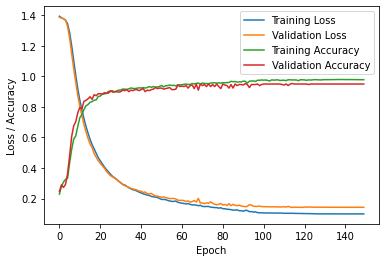

In [28]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss / Accuracy')
plt.legend()
plt.show()

## Pokus cislo 6


Architektura:
- 1 skryta vrstva 
    - aktivacne fukcie: LeakyReLU 
    - pocet neuronov: 16
    - dropout: 0.5
- vystupna vrstva
    - aktivacna fukcia: Softmax
    - pocet neuronov: 4

Hyperparametre:
- optimizer: Adam
- loss: sparse_categorical_crossentropy
- learnig rate: 0.001
    - strategia: ak neklesne loss po 6 epochach lr sa prenasobi 0.8 
- epochy: 300
- velkost batchu: 32

In [29]:
# Initialize WandB
wandb.init(project="neural-network")
wandb.run.name = "Pokus cislo 6 - res"
config = wandb.config
config.learning_rate = 0.001
config.batch_size = 32
config.epochs = 300

# Define the model architecture
model = tf.keras.Sequential([
    tf.keras.layers.Dense(16, activation='LeakyReLU', input_shape=(20,)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(4, activation='softmax')
])

# Compile the model

optimizer = tf.keras.optimizers.Adam(learning_rate=config.learning_rate)

model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=9)
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=6)

history  = model.fit(X_train, y_train, epochs=300, batch_size=config.batch_size, validation_data=(X_val, y_val), callbacks=[lr_scheduler,early_stop,WandbCallback()])

# Evaluate the model
val_loss, val_acc = model.evaluate(X_val, y_val, verbose=2)
print('Validation accuracy:', val_acc)
print('Validation loss:', val_loss)

# Make predictions
predictions = model.predict(X_val)
print('Predictions:', np.argmax(predictions, axis=1))

# Evaluate the model on the val set and log the results
wandb.log({'Validation loss': val_loss, 'Validation accuracy': val_acc})

Validation accuracy,▁
Validation loss,▁
accuracy,▁▁▄▆▇▇▇▇▇▇▇▇▇███████████████████████████
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,██▆▅▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr,██████████████████████████▂▂▂▂▂▂▂▁▁▁▁▁▁▁
val_accuracy,▁▁▅▆▇▇▇▇████████████████████████████████
val_loss,██▆▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation accuracy,0.95
Validation loss,0.14332
accuracy,0.97824


Epoch 1/300
 1/54 [..............................] - ETA: 44s - loss: 1.8377 - accuracy: 0.1875WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0022s vs `on_train_batch_end` time: 0.0025s). Check your callbacks.


47/54 [=========================>....] - ETA: 0s - loss: 1.6169 - accuracy: 0.2547

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best)... Done. 0.0s


54/54 [==============================] - 3s 34ms/step - loss: 1.6130 - accuracy: 0.2506 - val_loss: 1.4436 - val_accuracy: 0.2100 - lr: 0.0010
Epoch 2/300
50/54 [==========================>...] - ETA: 0s - loss: 1.4494 - accuracy: 0.2856

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 34ms/step - loss: 1.4498 - accuracy: 0.2865 - val_loss: 1.3996 - val_accuracy: 0.2500 - lr: 0.0010
Epoch 3/300
48/54 [=========================>....] - ETA: 0s - loss: 1.4248 - accuracy: 0.2734

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best)... Done. 0.0s


54/54 [==============================] - 1s 28ms/step - loss: 1.4305 - accuracy: 0.2706 - val_loss: 1.3738 - val_accuracy: 0.2933 - lr: 0.0010
Epoch 4/300
27/54 [==============>...............] - ETA: 0s - loss: 1.3826 - accuracy: 0.3125

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 29ms/step - loss: 1.3796 - accuracy: 0.3135 - val_loss: 1.3541 - val_accuracy: 0.3100 - lr: 0.0010
Epoch 5/300
45/54 [========================>.....] - ETA: 0s - loss: 1.3494 - accuracy: 0.3354

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 41ms/step - loss: 1.3501 - accuracy: 0.3347 - val_loss: 1.3323 - val_accuracy: 0.3467 - lr: 0.0010
Epoch 6/300
35/54 [==================>...........] - ETA: 0s - loss: 1.3288 - accuracy: 0.3607

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 30ms/step - loss: 1.3318 - accuracy: 0.3594 - val_loss: 1.3011 - val_accuracy: 0.3967 - lr: 0.0010
Epoch 7/300
51/54 [===========================>..] - ETA: 0s - loss: 1.3108 - accuracy: 0.3707

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 31ms/step - loss: 1.3077 - accuracy: 0.3735 - val_loss: 1.2688 - val_accuracy: 0.4567 - lr: 0.0010
Epoch 8/300
53/54 [============================>.] - ETA: 0s - loss: 1.2762 - accuracy: 0.3962

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 29ms/step - loss: 1.2760 - accuracy: 0.3965 - val_loss: 1.2424 - val_accuracy: 0.4700 - lr: 0.0010
Epoch 9/300
48/54 [=========================>....] - ETA: 0s - loss: 1.2508 - accuracy: 0.4238

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best)... Done. 0.0s


54/54 [==============================] - 1s 28ms/step - loss: 1.2543 - accuracy: 0.4206 - val_loss: 1.2067 - val_accuracy: 0.5133 - lr: 0.0010
Epoch 10/300
44/54 [=======================>......] - ETA: 0s - loss: 1.2378 - accuracy: 0.4325

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 29ms/step - loss: 1.2374 - accuracy: 0.4200 - val_loss: 1.1780 - val_accuracy: 0.5300 - lr: 0.0010
Epoch 11/300
52/54 [===========================>..] - ETA: 0s - loss: 1.1940 - accuracy: 0.4549

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 33ms/step - loss: 1.1961 - accuracy: 0.4553 - val_loss: 1.1456 - val_accuracy: 0.5433 - lr: 0.0010
Epoch 12/300
50/54 [==========================>...] - ETA: 0s - loss: 1.1828 - accuracy: 0.4538

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 30ms/step - loss: 1.1818 - accuracy: 0.4553 - val_loss: 1.1191 - val_accuracy: 0.5667 - lr: 0.0010
Epoch 13/300
51/54 [===========================>..] - ETA: 0s - loss: 1.1516 - accuracy: 0.4767

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 28ms/step - loss: 1.1534 - accuracy: 0.4729 - val_loss: 1.0824 - val_accuracy: 0.6200 - lr: 0.0010
Epoch 14/300
46/54 [========================>.....] - ETA: 0s - loss: 1.1233 - accuracy: 0.4837

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 38ms/step - loss: 1.1228 - accuracy: 0.4812 - val_loss: 1.0462 - val_accuracy: 0.6600 - lr: 0.0010
Epoch 15/300
50/54 [==========================>...] - ETA: 0s - loss: 1.0959 - accuracy: 0.5113

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 30ms/step - loss: 1.0945 - accuracy: 0.5100 - val_loss: 1.0082 - val_accuracy: 0.6800 - lr: 0.0010
Epoch 16/300
48/54 [=========================>....] - ETA: 0s - loss: 1.0658 - accuracy: 0.5098

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 30ms/step - loss: 1.0664 - accuracy: 0.5094 - val_loss: 0.9843 - val_accuracy: 0.6933 - lr: 0.0010
Epoch 17/300
43/54 [======================>.......] - ETA: 0s - loss: 1.0333 - accuracy: 0.5276

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 36ms/step - loss: 1.0438 - accuracy: 0.5194 - val_loss: 0.9571 - val_accuracy: 0.7167 - lr: 0.0010
Epoch 18/300
44/54 [=======================>......] - ETA: 0s - loss: 1.0163 - accuracy: 0.5518

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 34ms/step - loss: 1.0120 - accuracy: 0.5529 - val_loss: 0.9264 - val_accuracy: 0.7300 - lr: 0.0010
Epoch 19/300
50/54 [==========================>...] - ETA: 0s - loss: 1.0006 - accuracy: 0.5437

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 30ms/step - loss: 1.0004 - accuracy: 0.5435 - val_loss: 0.9028 - val_accuracy: 0.7233 - lr: 0.0010
Epoch 20/300
42/54 [======================>.......] - ETA: 0s - loss: 0.9828 - accuracy: 0.5528

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 34ms/step - loss: 0.9843 - accuracy: 0.5576 - val_loss: 0.8809 - val_accuracy: 0.7400 - lr: 0.0010
Epoch 21/300
41/54 [=====================>........] - ETA: 0s - loss: 0.9582 - accuracy: 0.5709

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 34ms/step - loss: 0.9495 - accuracy: 0.5865 - val_loss: 0.8572 - val_accuracy: 0.7567 - lr: 0.0010
Epoch 22/300
46/54 [========================>.....] - ETA: 0s - loss: 0.9321 - accuracy: 0.5842

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 47ms/step - loss: 0.9319 - accuracy: 0.5782 - val_loss: 0.8405 - val_accuracy: 0.7467 - lr: 0.0010
Epoch 23/300
52/54 [===========================>..] - ETA: 0s - loss: 0.9121 - accuracy: 0.5901

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 30ms/step - loss: 0.9102 - accuracy: 0.5935 - val_loss: 0.8190 - val_accuracy: 0.7767 - lr: 0.0010
Epoch 24/300
46/54 [========================>.....] - ETA: 0s - loss: 0.8939 - accuracy: 0.6107

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 29ms/step - loss: 0.8944 - accuracy: 0.6082 - val_loss: 0.8021 - val_accuracy: 0.7800 - lr: 0.0010
Epoch 25/300
48/54 [=========================>....] - ETA: 0s - loss: 0.8825 - accuracy: 0.6374

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 35ms/step - loss: 0.8829 - accuracy: 0.6365 - val_loss: 0.7823 - val_accuracy: 0.7933 - lr: 0.0010
Epoch 26/300
49/54 [==========================>...] - ETA: 0s - loss: 0.8711 - accuracy: 0.6231

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 36ms/step - loss: 0.8697 - accuracy: 0.6241 - val_loss: 0.7643 - val_accuracy: 0.7867 - lr: 0.0010
Epoch 27/300
53/54 [============================>.] - ETA: 0s - loss: 0.8441 - accuracy: 0.6215

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 33ms/step - loss: 0.8441 - accuracy: 0.6218 - val_loss: 0.7464 - val_accuracy: 0.7967 - lr: 0.0010
Epoch 28/300
38/54 [====================>.........] - ETA: 0s - loss: 0.8319 - accuracy: 0.6472

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 40ms/step - loss: 0.8313 - accuracy: 0.6482 - val_loss: 0.7347 - val_accuracy: 0.8067 - lr: 0.0010
Epoch 29/300
50/54 [==========================>...] - ETA: 0s - loss: 0.8257 - accuracy: 0.6400

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 30ms/step - loss: 0.8231 - accuracy: 0.6476 - val_loss: 0.7220 - val_accuracy: 0.8000 - lr: 0.0010
Epoch 30/300
52/54 [===========================>..] - ETA: 0s - loss: 0.8127 - accuracy: 0.6526

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 29ms/step - loss: 0.8113 - accuracy: 0.6541 - val_loss: 0.7045 - val_accuracy: 0.8167 - lr: 0.0010
Epoch 31/300
49/54 [==========================>...] - ETA: 0s - loss: 0.7873 - accuracy: 0.6639

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 34ms/step - loss: 0.7893 - accuracy: 0.6635 - val_loss: 0.6903 - val_accuracy: 0.8100 - lr: 0.0010
Epoch 32/300
51/54 [===========================>..] - ETA: 0s - loss: 0.7757 - accuracy: 0.6918

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 28ms/step - loss: 0.7738 - accuracy: 0.6912 - val_loss: 0.6800 - val_accuracy: 0.8133 - lr: 0.0010
Epoch 33/300
52/54 [===========================>..] - ETA: 0s - loss: 0.7657 - accuracy: 0.6935

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best)... Done. 0.0s


54/54 [==============================] - 1s 28ms/step - loss: 0.7666 - accuracy: 0.6941 - val_loss: 0.6604 - val_accuracy: 0.8233 - lr: 0.0010
Epoch 34/300
49/54 [==========================>...] - ETA: 0s - loss: 0.7579 - accuracy: 0.6805

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best)... Done. 0.0s


54/54 [==============================] - 3s 49ms/step - loss: 0.7539 - accuracy: 0.6853 - val_loss: 0.6475 - val_accuracy: 0.8333 - lr: 0.0010
Epoch 35/300
44/54 [=======================>......] - ETA: 0s - loss: 0.7503 - accuracy: 0.7031

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 32ms/step - loss: 0.7561 - accuracy: 0.6924 - val_loss: 0.6426 - val_accuracy: 0.8200 - lr: 0.0010
Epoch 36/300
53/54 [============================>.] - ETA: 0s - loss: 0.7290 - accuracy: 0.6969

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best)... Done. 0.0s


54/54 [==============================] - 1s 28ms/step - loss: 0.7288 - accuracy: 0.6971 - val_loss: 0.6272 - val_accuracy: 0.8333 - lr: 0.0010
Epoch 37/300
53/54 [============================>.] - ETA: 0s - loss: 0.7089 - accuracy: 0.7217

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 39ms/step - loss: 0.7096 - accuracy: 0.7212 - val_loss: 0.6163 - val_accuracy: 0.8300 - lr: 0.0010
Epoch 38/300
52/54 [===========================>..] - ETA: 0s - loss: 0.7026 - accuracy: 0.7175

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best)... Done. 0.0s


54/54 [==============================] - 1s 28ms/step - loss: 0.7033 - accuracy: 0.7159 - val_loss: 0.6069 - val_accuracy: 0.8400 - lr: 0.0010
Epoch 39/300
42/54 [======================>.......] - ETA: 0s - loss: 0.7134 - accuracy: 0.7128

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 30ms/step - loss: 0.7065 - accuracy: 0.7165 - val_loss: 0.5963 - val_accuracy: 0.8467 - lr: 0.0010
Epoch 40/300
50/54 [==========================>...] - ETA: 0s - loss: 0.6915 - accuracy: 0.7337

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 34ms/step - loss: 0.6909 - accuracy: 0.7371 - val_loss: 0.5884 - val_accuracy: 0.8400 - lr: 0.0010
Epoch 41/300
45/54 [========================>.....] - ETA: 0s - loss: 0.6761 - accuracy: 0.7222

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 33ms/step - loss: 0.6773 - accuracy: 0.7206 - val_loss: 0.5800 - val_accuracy: 0.8500 - lr: 0.0010
Epoch 42/300
42/54 [======================>.......] - ETA: 0s - loss: 0.6750 - accuracy: 0.7254

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 33ms/step - loss: 0.6742 - accuracy: 0.7235 - val_loss: 0.5749 - val_accuracy: 0.8467 - lr: 0.0010
Epoch 43/300
40/54 [=====================>........] - ETA: 0s - loss: 0.6640 - accuracy: 0.7406

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 32ms/step - loss: 0.6639 - accuracy: 0.7376 - val_loss: 0.5648 - val_accuracy: 0.8600 - lr: 0.0010
Epoch 44/300
43/54 [======================>.......] - ETA: 0s - loss: 0.6449 - accuracy: 0.7384

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 32ms/step - loss: 0.6431 - accuracy: 0.7382 - val_loss: 0.5526 - val_accuracy: 0.8633 - lr: 0.0010
Epoch 45/300
45/54 [========================>.....] - ETA: 0s - loss: 0.6454 - accuracy: 0.7514

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 32ms/step - loss: 0.6421 - accuracy: 0.7529 - val_loss: 0.5409 - val_accuracy: 0.8500 - lr: 0.0010
Epoch 46/300
51/54 [===========================>..] - ETA: 0s - loss: 0.6365 - accuracy: 0.7445

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 39ms/step - loss: 0.6321 - accuracy: 0.7494 - val_loss: 0.5399 - val_accuracy: 0.8533 - lr: 0.0010
Epoch 47/300
45/54 [========================>.....] - ETA: 0s - loss: 0.6250 - accuracy: 0.7569

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 30ms/step - loss: 0.6263 - accuracy: 0.7535 - val_loss: 0.5294 - val_accuracy: 0.8533 - lr: 0.0010
Epoch 48/300
49/54 [==========================>...] - ETA: 0s - loss: 0.6183 - accuracy: 0.7513

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 29ms/step - loss: 0.6206 - accuracy: 0.7459 - val_loss: 0.5201 - val_accuracy: 0.8533 - lr: 0.0010
Epoch 49/300
53/54 [============================>.] - ETA: 0s - loss: 0.6176 - accuracy: 0.7612

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 33ms/step - loss: 0.6177 - accuracy: 0.7612 - val_loss: 0.5181 - val_accuracy: 0.8500 - lr: 0.0010
Epoch 50/300
52/54 [===========================>..] - ETA: 0s - loss: 0.6065 - accuracy: 0.7578

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 29ms/step - loss: 0.6051 - accuracy: 0.7582 - val_loss: 0.5046 - val_accuracy: 0.8600 - lr: 0.0010
Epoch 51/300
52/54 [===========================>..] - ETA: 0s - loss: 0.5946 - accuracy: 0.7680

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best)... Done. 0.0s


54/54 [==============================] - 1s 28ms/step - loss: 0.5965 - accuracy: 0.7659 - val_loss: 0.4967 - val_accuracy: 0.8700 - lr: 0.0010
Epoch 52/300
49/54 [==========================>...] - ETA: 0s - loss: 0.5879 - accuracy: 0.7647

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 37ms/step - loss: 0.5848 - accuracy: 0.7682 - val_loss: 0.4964 - val_accuracy: 0.8700 - lr: 0.0010
Epoch 53/300
52/54 [===========================>..] - ETA: 0s - loss: 0.5992 - accuracy: 0.7584

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 39ms/step - loss: 0.5982 - accuracy: 0.7582 - val_loss: 0.4899 - val_accuracy: 0.8633 - lr: 0.0010
Epoch 54/300
49/54 [==========================>...] - ETA: 0s - loss: 0.5667 - accuracy: 0.7736

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 34ms/step - loss: 0.5663 - accuracy: 0.7753 - val_loss: 0.4816 - val_accuracy: 0.8667 - lr: 0.0010
Epoch 55/300
51/54 [===========================>..] - ETA: 0s - loss: 0.5697 - accuracy: 0.7770

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 29ms/step - loss: 0.5676 - accuracy: 0.7782 - val_loss: 0.4704 - val_accuracy: 0.8700 - lr: 0.0010
Epoch 56/300
44/54 [=======================>......] - ETA: 0s - loss: 0.5584 - accuracy: 0.7940

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 34ms/step - loss: 0.5633 - accuracy: 0.7865 - val_loss: 0.4630 - val_accuracy: 0.8667 - lr: 0.0010
Epoch 57/300
46/54 [========================>.....] - ETA: 0s - loss: 0.5580 - accuracy: 0.7928

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 34ms/step - loss: 0.5552 - accuracy: 0.7924 - val_loss: 0.4607 - val_accuracy: 0.8700 - lr: 0.0010
Epoch 58/300
45/54 [========================>.....] - ETA: 0s - loss: 0.5413 - accuracy: 0.7903

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 34ms/step - loss: 0.5476 - accuracy: 0.7871 - val_loss: 0.4601 - val_accuracy: 0.8533 - lr: 0.0010
Epoch 59/300
40/54 [=====================>........] - ETA: 0s - loss: 0.5450 - accuracy: 0.7883

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 36ms/step - loss: 0.5472 - accuracy: 0.7906 - val_loss: 0.4498 - val_accuracy: 0.8933 - lr: 0.0010
Epoch 60/300
52/54 [===========================>..] - ETA: 0s - loss: 0.5439 - accuracy: 0.7867

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 36ms/step - loss: 0.5430 - accuracy: 0.7871 - val_loss: 0.4426 - val_accuracy: 0.8767 - lr: 0.0010
Epoch 61/300
42/54 [======================>.......] - ETA: 0s - loss: 0.5280 - accuracy: 0.8080

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 33ms/step - loss: 0.5260 - accuracy: 0.8053 - val_loss: 0.4345 - val_accuracy: 0.8867 - lr: 0.0010
Epoch 62/300
47/54 [=========================>....] - ETA: 0s - loss: 0.5381 - accuracy: 0.7926

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 35ms/step - loss: 0.5335 - accuracy: 0.7959 - val_loss: 0.4300 - val_accuracy: 0.8867 - lr: 0.0010
Epoch 63/300
40/54 [=====================>........] - ETA: 0s - loss: 0.5187 - accuracy: 0.8086

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 45ms/step - loss: 0.5166 - accuracy: 0.8135 - val_loss: 0.4255 - val_accuracy: 0.8767 - lr: 0.0010
Epoch 64/300
53/54 [============================>.] - ETA: 0s - loss: 0.5160 - accuracy: 0.8013

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 34ms/step - loss: 0.5165 - accuracy: 0.8012 - val_loss: 0.4220 - val_accuracy: 0.8833 - lr: 0.0010
Epoch 65/300
53/54 [============================>.] - ETA: 0s - loss: 0.5235 - accuracy: 0.7989

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 41ms/step - loss: 0.5227 - accuracy: 0.7994 - val_loss: 0.4174 - val_accuracy: 0.8867 - lr: 0.0010
Epoch 66/300
39/54 [====================>.........] - ETA: 0s - loss: 0.5161 - accuracy: 0.8021

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 34ms/step - loss: 0.5097 - accuracy: 0.8041 - val_loss: 0.4139 - val_accuracy: 0.8833 - lr: 0.0010
Epoch 67/300
41/54 [=====================>........] - ETA: 0s - loss: 0.5088 - accuracy: 0.8011

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 33ms/step - loss: 0.5013 - accuracy: 0.8041 - val_loss: 0.4060 - val_accuracy: 0.8967 - lr: 0.0010
Epoch 68/300
35/54 [==================>...........] - ETA: 0s - loss: 0.5046 - accuracy: 0.8116

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 37ms/step - loss: 0.4980 - accuracy: 0.8118 - val_loss: 0.4008 - val_accuracy: 0.8867 - lr: 0.0010
Epoch 69/300
39/54 [====================>.........] - ETA: 0s - loss: 0.4801 - accuracy: 0.8157

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 43ms/step - loss: 0.4796 - accuracy: 0.8224 - val_loss: 0.3957 - val_accuracy: 0.8900 - lr: 0.0010
Epoch 70/300
38/54 [====================>.........] - ETA: 0s - loss: 0.4863 - accuracy: 0.8174

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 35ms/step - loss: 0.4893 - accuracy: 0.8129 - val_loss: 0.3888 - val_accuracy: 0.9000 - lr: 0.0010
Epoch 71/300
54/54 [==============================] - 0s 4ms/step - loss: 0.4894 - accuracy: 0.8082 - val_loss: 0.3895 - val_accuracy: 0.8933 - lr: 0.0010
Epoch 72/300
49/54 [==========================>...] - ETA: 0s - loss: 0.4682 - accuracy: 0.8233

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 41ms/step - loss: 0.4716 - accuracy: 0.8194 - val_loss: 0.3843 - val_accuracy: 0.9033 - lr: 0.0010
Epoch 73/300
48/54 [=========================>....] - ETA: 0s - loss: 0.4729 - accuracy: 0.8105

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 31ms/step - loss: 0.4712 - accuracy: 0.8106 - val_loss: 0.3807 - val_accuracy: 0.9100 - lr: 0.0010
Epoch 74/300
38/54 [====================>.........] - ETA: 0s - loss: 0.4710 - accuracy: 0.8240

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 33ms/step - loss: 0.4746 - accuracy: 0.8229 - val_loss: 0.3747 - val_accuracy: 0.9100 - lr: 0.0010
Epoch 75/300
49/54 [==========================>...] - ETA: 0s - loss: 0.4553 - accuracy: 0.8284

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 31ms/step - loss: 0.4608 - accuracy: 0.8212 - val_loss: 0.3684 - val_accuracy: 0.9033 - lr: 0.0010
Epoch 76/300
53/54 [============================>.] - ETA: 0s - loss: 0.4499 - accuracy: 0.8343

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 29ms/step - loss: 0.4502 - accuracy: 0.8341 - val_loss: 0.3640 - val_accuracy: 0.9000 - lr: 0.0010
Epoch 77/300
54/54 [==============================] - ETA: 0s - loss: 0.4557 - accuracy: 0.8259

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 30ms/step - loss: 0.4557 - accuracy: 0.8259 - val_loss: 0.3600 - val_accuracy: 0.9033 - lr: 0.0010
Epoch 78/300
50/54 [==========================>...] - ETA: 0s - loss: 0.4483 - accuracy: 0.8263

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 35ms/step - loss: 0.4521 - accuracy: 0.8247 - val_loss: 0.3565 - val_accuracy: 0.9033 - lr: 0.0010
Epoch 79/300
42/54 [======================>.......] - ETA: 0s - loss: 0.4288 - accuracy: 0.8482

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 32ms/step - loss: 0.4399 - accuracy: 0.8388 - val_loss: 0.3543 - val_accuracy: 0.9033 - lr: 0.0010
Epoch 80/300
41/54 [=====================>........] - ETA: 0s - loss: 0.4372 - accuracy: 0.8384

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 31ms/step - loss: 0.4367 - accuracy: 0.8424 - val_loss: 0.3476 - val_accuracy: 0.9100 - lr: 0.0010
Epoch 81/300
49/54 [==========================>...] - ETA: 0s - loss: 0.4397 - accuracy: 0.8367

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 34ms/step - loss: 0.4430 - accuracy: 0.8318 - val_loss: 0.3417 - val_accuracy: 0.9067 - lr: 0.0010
Epoch 82/300
44/54 [=======================>......] - ETA: 0s - loss: 0.4308 - accuracy: 0.8331

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 31ms/step - loss: 0.4299 - accuracy: 0.8371 - val_loss: 0.3396 - val_accuracy: 0.9100 - lr: 0.0010
Epoch 83/300
41/54 [=====================>........] - ETA: 0s - loss: 0.4333 - accuracy: 0.8323

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 31ms/step - loss: 0.4298 - accuracy: 0.8312 - val_loss: 0.3382 - val_accuracy: 0.9067 - lr: 0.0010
Epoch 84/300
50/54 [==========================>...] - ETA: 0s - loss: 0.4310 - accuracy: 0.8444

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 30ms/step - loss: 0.4287 - accuracy: 0.8447 - val_loss: 0.3331 - val_accuracy: 0.9133 - lr: 0.0010
Epoch 85/300
52/54 [===========================>..] - ETA: 0s - loss: 0.4371 - accuracy: 0.8317

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 31ms/step - loss: 0.4353 - accuracy: 0.8324 - val_loss: 0.3288 - val_accuracy: 0.9167 - lr: 0.0010
Epoch 86/300
54/54 [==============================] - 0s 3ms/step - loss: 0.4249 - accuracy: 0.8359 - val_loss: 0.3305 - val_accuracy: 0.9167 - lr: 0.0010
Epoch 87/300
53/54 [============================>.] - ETA: 0s - loss: 0.4092 - accuracy: 0.8496

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 30ms/step - loss: 0.4103 - accuracy: 0.8482 - val_loss: 0.3259 - val_accuracy: 0.9133 - lr: 0.0010
Epoch 88/300
41/54 [=====================>........] - ETA: 0s - loss: 0.4094 - accuracy: 0.8369

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 33ms/step - loss: 0.4121 - accuracy: 0.8435 - val_loss: 0.3237 - val_accuracy: 0.9033 - lr: 0.0010
Epoch 89/300
54/54 [==============================] - 0s 3ms/step - loss: 0.4152 - accuracy: 0.8447 - val_loss: 0.3237 - val_accuracy: 0.9133 - lr: 0.0010
Epoch 90/300
46/54 [========================>.....] - ETA: 0s - loss: 0.4103 - accuracy: 0.8526

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 35ms/step - loss: 0.4099 - accuracy: 0.8535 - val_loss: 0.3186 - val_accuracy: 0.9133 - lr: 0.0010
Epoch 91/300
37/54 [===================>..........] - ETA: 0s - loss: 0.4110 - accuracy: 0.8421

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 32ms/step - loss: 0.4077 - accuracy: 0.8488 - val_loss: 0.3153 - val_accuracy: 0.9100 - lr: 0.0010
Epoch 92/300
37/54 [===================>..........] - ETA: 0s - loss: 0.4032 - accuracy: 0.8454

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 36ms/step - loss: 0.4008 - accuracy: 0.8465 - val_loss: 0.3145 - val_accuracy: 0.9133 - lr: 0.0010
Epoch 93/300
45/54 [========================>.....] - ETA: 0s - loss: 0.3944 - accuracy: 0.8632

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 30ms/step - loss: 0.3934 - accuracy: 0.8612 - val_loss: 0.3074 - val_accuracy: 0.9100 - lr: 0.0010
Epoch 94/300
53/54 [============================>.] - ETA: 0s - loss: 0.3903 - accuracy: 0.8544

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 29ms/step - loss: 0.3901 - accuracy: 0.8541 - val_loss: 0.3028 - val_accuracy: 0.9167 - lr: 0.0010
Epoch 95/300
48/54 [=========================>....] - ETA: 0s - loss: 0.3934 - accuracy: 0.8561

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 29ms/step - loss: 0.3920 - accuracy: 0.8559 - val_loss: 0.3001 - val_accuracy: 0.9100 - lr: 0.0010
Epoch 96/300
27/54 [==============>...............] - ETA: 0s - loss: 0.3948 - accuracy: 0.8414

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 32ms/step - loss: 0.3897 - accuracy: 0.8506 - val_loss: 0.2978 - val_accuracy: 0.9167 - lr: 0.0010
Epoch 97/300
54/54 [==============================] - 0s 3ms/step - loss: 0.3822 - accuracy: 0.8571 - val_loss: 0.2992 - val_accuracy: 0.9133 - lr: 0.0010
Epoch 98/300
45/54 [========================>.....] - ETA: 0s - loss: 0.3888 - accuracy: 0.8507

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 30ms/step - loss: 0.3850 - accuracy: 0.8547 - val_loss: 0.2935 - val_accuracy: 0.9167 - lr: 0.0010
Epoch 99/300
48/54 [=========================>....] - ETA: 0s - loss: 0.3759 - accuracy: 0.8620

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 32ms/step - loss: 0.3783 - accuracy: 0.8612 - val_loss: 0.2919 - val_accuracy: 0.9133 - lr: 0.0010
Epoch 100/300
41/54 [=====================>........] - ETA: 0s - loss: 0.3749 - accuracy: 0.8552

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 35ms/step - loss: 0.3794 - accuracy: 0.8500 - val_loss: 0.2889 - val_accuracy: 0.9233 - lr: 0.0010
Epoch 101/300
48/54 [=========================>....] - ETA: 0s - loss: 0.3669 - accuracy: 0.8646

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 30ms/step - loss: 0.3698 - accuracy: 0.8618 - val_loss: 0.2863 - val_accuracy: 0.9233 - lr: 0.0010
Epoch 102/300
39/54 [====================>.........] - ETA: 0s - loss: 0.3676 - accuracy: 0.8542

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 30ms/step - loss: 0.3658 - accuracy: 0.8565 - val_loss: 0.2811 - val_accuracy: 0.9167 - lr: 0.0010
Epoch 103/300
36/54 [===================>..........] - ETA: 0s - loss: 0.3685 - accuracy: 0.8637

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 33ms/step - loss: 0.3586 - accuracy: 0.8682 - val_loss: 0.2780 - val_accuracy: 0.9200 - lr: 0.0010
Epoch 104/300
47/54 [=========================>....] - ETA: 0s - loss: 0.3640 - accuracy: 0.8577

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 29ms/step - loss: 0.3647 - accuracy: 0.8565 - val_loss: 0.2770 - val_accuracy: 0.9133 - lr: 0.0010
Epoch 105/300
42/54 [======================>.......] - ETA: 0s - loss: 0.3576 - accuracy: 0.8705

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 32ms/step - loss: 0.3614 - accuracy: 0.8606 - val_loss: 0.2730 - val_accuracy: 0.9267 - lr: 0.0010
Epoch 106/300
47/54 [=========================>....] - ETA: 0s - loss: 0.3602 - accuracy: 0.8743

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 34ms/step - loss: 0.3603 - accuracy: 0.8741 - val_loss: 0.2724 - val_accuracy: 0.9167 - lr: 0.0010
Epoch 107/300
44/54 [=======================>......] - ETA: 0s - loss: 0.3625 - accuracy: 0.8693

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 36ms/step - loss: 0.3582 - accuracy: 0.8688 - val_loss: 0.2668 - val_accuracy: 0.9200 - lr: 0.0010
Epoch 108/300
47/54 [=========================>....] - ETA: 0s - loss: 0.3542 - accuracy: 0.8544

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 30ms/step - loss: 0.3559 - accuracy: 0.8559 - val_loss: 0.2661 - val_accuracy: 0.9267 - lr: 0.0010
Epoch 109/300
52/54 [===========================>..] - ETA: 0s - loss: 0.3498 - accuracy: 0.8744

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 34ms/step - loss: 0.3485 - accuracy: 0.8759 - val_loss: 0.2629 - val_accuracy: 0.9300 - lr: 0.0010
Epoch 110/300
38/54 [====================>.........] - ETA: 0s - loss: 0.3369 - accuracy: 0.8750

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 31ms/step - loss: 0.3345 - accuracy: 0.8794 - val_loss: 0.2611 - val_accuracy: 0.9333 - lr: 0.0010
Epoch 111/300
54/54 [==============================] - 0s 4ms/step - loss: 0.3525 - accuracy: 0.8665 - val_loss: 0.2619 - val_accuracy: 0.9267 - lr: 0.0010
Epoch 112/300
38/54 [====================>.........] - ETA: 0s - loss: 0.3394 - accuracy: 0.8857

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 30ms/step - loss: 0.3419 - accuracy: 0.8824 - val_loss: 0.2588 - val_accuracy: 0.9300 - lr: 0.0010
Epoch 113/300
51/54 [===========================>..] - ETA: 0s - loss: 0.3384 - accuracy: 0.8848

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 36ms/step - loss: 0.3408 - accuracy: 0.8800 - val_loss: 0.2515 - val_accuracy: 0.9367 - lr: 0.0010
Epoch 114/300
52/54 [===========================>..] - ETA: 0s - loss: 0.3398 - accuracy: 0.8804

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 29ms/step - loss: 0.3399 - accuracy: 0.8806 - val_loss: 0.2510 - val_accuracy: 0.9333 - lr: 0.0010
Epoch 115/300
54/54 [==============================] - 0s 4ms/step - loss: 0.3315 - accuracy: 0.8706 - val_loss: 0.2515 - val_accuracy: 0.9367 - lr: 0.0010
Epoch 116/300
45/54 [========================>.....] - ETA: 0s - loss: 0.3284 - accuracy: 0.8826

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 31ms/step - loss: 0.3360 - accuracy: 0.8782 - val_loss: 0.2482 - val_accuracy: 0.9300 - lr: 0.0010
Epoch 117/300
47/54 [=========================>....] - ETA: 0s - loss: 0.3353 - accuracy: 0.8783

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 36ms/step - loss: 0.3365 - accuracy: 0.8794 - val_loss: 0.2456 - val_accuracy: 0.9300 - lr: 0.0010
Epoch 118/300
50/54 [==========================>...] - ETA: 0s - loss: 0.3315 - accuracy: 0.8756

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 31ms/step - loss: 0.3291 - accuracy: 0.8782 - val_loss: 0.2425 - val_accuracy: 0.9367 - lr: 0.0010
Epoch 119/300
54/54 [==============================] - 0s 4ms/step - loss: 0.3422 - accuracy: 0.8647 - val_loss: 0.2435 - val_accuracy: 0.9333 - lr: 0.0010
Epoch 120/300
43/54 [======================>.......] - ETA: 0s - loss: 0.3151 - accuracy: 0.8852

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 31ms/step - loss: 0.3154 - accuracy: 0.8859 - val_loss: 0.2407 - val_accuracy: 0.9367 - lr: 0.0010
Epoch 121/300
49/54 [==========================>...] - ETA: 0s - loss: 0.3170 - accuracy: 0.8858

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 37ms/step - loss: 0.3149 - accuracy: 0.8847 - val_loss: 0.2362 - val_accuracy: 0.9367 - lr: 0.0010
Epoch 122/300
54/54 [==============================] - 0s 3ms/step - loss: 0.3284 - accuracy: 0.8759 - val_loss: 0.2407 - val_accuracy: 0.9333 - lr: 0.0010
Epoch 123/300
44/54 [=======================>......] - ETA: 0s - loss: 0.3185 - accuracy: 0.8821

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 30ms/step - loss: 0.3197 - accuracy: 0.8812 - val_loss: 0.2353 - val_accuracy: 0.9433 - lr: 0.0010
Epoch 124/300
46/54 [========================>.....] - ETA: 0s - loss: 0.3065 - accuracy: 0.8899

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 33ms/step - loss: 0.3055 - accuracy: 0.8929 - val_loss: 0.2296 - val_accuracy: 0.9467 - lr: 0.0010
Epoch 125/300
54/54 [==============================] - 0s 4ms/step - loss: 0.3172 - accuracy: 0.8812 - val_loss: 0.2305 - val_accuracy: 0.9333 - lr: 0.0010
Epoch 126/300
54/54 [==============================] - 0s 4ms/step - loss: 0.3123 - accuracy: 0.8965 - val_loss: 0.2303 - val_accuracy: 0.9467 - lr: 0.0010
Epoch 127/300
45/54 [========================>.....] - ETA: 0s - loss: 0.3118 - accuracy: 0.8806

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 32ms/step - loss: 0.3136 - accuracy: 0.8812 - val_loss: 0.2296 - val_accuracy: 0.9500 - lr: 0.0010
Epoch 128/300
51/54 [===========================>..] - ETA: 0s - loss: 0.3109 - accuracy: 0.8854

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 30ms/step - loss: 0.3081 - accuracy: 0.8871 - val_loss: 0.2248 - val_accuracy: 0.9400 - lr: 0.0010
Epoch 129/300
45/54 [========================>.....] - ETA: 0s - loss: 0.3069 - accuracy: 0.8847

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 42ms/step - loss: 0.3142 - accuracy: 0.8765 - val_loss: 0.2239 - val_accuracy: 0.9433 - lr: 0.0010
Epoch 130/300
51/54 [===========================>..] - ETA: 0s - loss: 0.3082 - accuracy: 0.8873

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 32ms/step - loss: 0.3074 - accuracy: 0.8882 - val_loss: 0.2213 - val_accuracy: 0.9433 - lr: 0.0010
Epoch 131/300
54/54 [==============================] - 0s 3ms/step - loss: 0.2970 - accuracy: 0.8953 - val_loss: 0.2242 - val_accuracy: 0.9367 - lr: 0.0010
Epoch 132/300
51/54 [===========================>..] - ETA: 0s - loss: 0.2981 - accuracy: 0.8879

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 34ms/step - loss: 0.2968 - accuracy: 0.8912 - val_loss: 0.2206 - val_accuracy: 0.9400 - lr: 0.0010
Epoch 133/300
54/54 [==============================] - ETA: 0s - loss: 0.2994 - accuracy: 0.8965

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 40ms/step - loss: 0.2994 - accuracy: 0.8965 - val_loss: 0.2161 - val_accuracy: 0.9533 - lr: 0.0010
Epoch 134/300
40/54 [=====================>........] - ETA: 0s - loss: 0.2948 - accuracy: 0.8914

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 32ms/step - loss: 0.2901 - accuracy: 0.8965 - val_loss: 0.2148 - val_accuracy: 0.9500 - lr: 0.0010
Epoch 135/300
47/54 [=========================>....] - ETA: 0s - loss: 0.2837 - accuracy: 0.9009

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 31ms/step - loss: 0.2868 - accuracy: 0.8971 - val_loss: 0.2130 - val_accuracy: 0.9533 - lr: 0.0010
Epoch 136/300
54/54 [==============================] - 0s 3ms/step - loss: 0.2923 - accuracy: 0.8924 - val_loss: 0.2147 - val_accuracy: 0.9367 - lr: 0.0010
Epoch 137/300
54/54 [==============================] - 0s 3ms/step - loss: 0.2877 - accuracy: 0.8988 - val_loss: 0.2163 - val_accuracy: 0.9367 - lr: 0.0010
Epoch 138/300
54/54 [==============================] - 0s 3ms/step - loss: 0.2952 - accuracy: 0.8935 - val_loss: 0.2163 - val_accuracy: 0.9367 - lr: 0.0010
Epoch 139/300
45/54 [========================>.....] - ETA: 0s - loss: 0.2811 - accuracy: 0.8993

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 33ms/step - loss: 0.2845 - accuracy: 0.8982 - val_loss: 0.2075 - val_accuracy: 0.9533 - lr: 0.0010
Epoch 140/300
49/54 [==========================>...] - ETA: 0s - loss: 0.2865 - accuracy: 0.9018

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 30ms/step - loss: 0.2849 - accuracy: 0.9035 - val_loss: 0.2027 - val_accuracy: 0.9567 - lr: 0.0010
Epoch 141/300
54/54 [==============================] - 0s 4ms/step - loss: 0.2825 - accuracy: 0.8988 - val_loss: 0.2041 - val_accuracy: 0.9433 - lr: 0.0010
Epoch 142/300
54/54 [==============================] - 0s 3ms/step - loss: 0.2800 - accuracy: 0.8941 - val_loss: 0.2033 - val_accuracy: 0.9467 - lr: 0.0010
Epoch 143/300
50/54 [==========================>...] - ETA: 0s - loss: 0.2833 - accuracy: 0.8894

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 34ms/step - loss: 0.2854 - accuracy: 0.8906 - val_loss: 0.2014 - val_accuracy: 0.9567 - lr: 0.0010
Epoch 144/300
54/54 [==============================] - 0s 3ms/step - loss: 0.2727 - accuracy: 0.9124 - val_loss: 0.2021 - val_accuracy: 0.9500 - lr: 0.0010
Epoch 145/300
51/54 [===========================>..] - ETA: 0s - loss: 0.2707 - accuracy: 0.9056

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 31ms/step - loss: 0.2715 - accuracy: 0.9047 - val_loss: 0.2006 - val_accuracy: 0.9567 - lr: 0.0010
Epoch 146/300
49/54 [==========================>...] - ETA: 0s - loss: 0.2620 - accuracy: 0.9094

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 30ms/step - loss: 0.2630 - accuracy: 0.9088 - val_loss: 0.1959 - val_accuracy: 0.9600 - lr: 0.0010
Epoch 147/300
54/54 [==============================] - 0s 4ms/step - loss: 0.2740 - accuracy: 0.8982 - val_loss: 0.2016 - val_accuracy: 0.9433 - lr: 0.0010
Epoch 148/300
47/54 [=========================>....] - ETA: 0s - loss: 0.2680 - accuracy: 0.9023

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 42ms/step - loss: 0.2715 - accuracy: 0.9000 - val_loss: 0.1926 - val_accuracy: 0.9467 - lr: 0.0010
Epoch 149/300
54/54 [==============================] - 0s 3ms/step - loss: 0.2659 - accuracy: 0.8971 - val_loss: 0.1939 - val_accuracy: 0.9533 - lr: 0.0010
Epoch 150/300
54/54 [==============================] - 0s 4ms/step - loss: 0.2689 - accuracy: 0.9012 - val_loss: 0.1953 - val_accuracy: 0.9433 - lr: 0.0010
Epoch 151/300
44/54 [=======================>......] - ETA: 0s - loss: 0.2805 - accuracy: 0.8928

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 35ms/step - loss: 0.2781 - accuracy: 0.8947 - val_loss: 0.1918 - val_accuracy: 0.9600 - lr: 0.0010
Epoch 152/300
54/54 [==============================] - 0s 5ms/step - loss: 0.2727 - accuracy: 0.8912 - val_loss: 0.1922 - val_accuracy: 0.9667 - lr: 0.0010
Epoch 153/300
54/54 [==============================] - 0s 4ms/step - loss: 0.2412 - accuracy: 0.9218 - val_loss: 0.1956 - val_accuracy: 0.9367 - lr: 0.0010
Epoch 154/300
43/54 [======================>.......] - ETA: 0s - loss: 0.2596 - accuracy: 0.9004

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best)... Done. 0.1s


54/54 [==============================] - 2s 37ms/step - loss: 0.2622 - accuracy: 0.8988 - val_loss: 0.1886 - val_accuracy: 0.9567 - lr: 0.0010
Epoch 155/300
54/54 [==============================] - 0s 4ms/step - loss: 0.2582 - accuracy: 0.9065 - val_loss: 0.1924 - val_accuracy: 0.9633 - lr: 0.0010
Epoch 156/300
54/54 [==============================] - 0s 3ms/step - loss: 0.2689 - accuracy: 0.9024 - val_loss: 0.1906 - val_accuracy: 0.9400 - lr: 0.0010
Epoch 157/300
49/54 [==========================>...] - ETA: 0s - loss: 0.2651 - accuracy: 0.9037

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best)... Done. 0.0s


54/54 [==============================] - 1s 28ms/step - loss: 0.2617 - accuracy: 0.9059 - val_loss: 0.1885 - val_accuracy: 0.9567 - lr: 0.0010
Epoch 158/300
38/54 [====================>.........] - ETA: 0s - loss: 0.2531 - accuracy: 0.9087

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 31ms/step - loss: 0.2558 - accuracy: 0.9076 - val_loss: 0.1861 - val_accuracy: 0.9500 - lr: 0.0010
Epoch 159/300
47/54 [=========================>....] - ETA: 0s - loss: 0.2492 - accuracy: 0.9136

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 44ms/step - loss: 0.2535 - accuracy: 0.9112 - val_loss: 0.1803 - val_accuracy: 0.9667 - lr: 0.0010
Epoch 160/300
54/54 [==============================] - 0s 4ms/step - loss: 0.2554 - accuracy: 0.9118 - val_loss: 0.1807 - val_accuracy: 0.9633 - lr: 0.0010
Epoch 161/300
45/54 [========================>.....] - ETA: 0s - loss: 0.2347 - accuracy: 0.9181

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 31ms/step - loss: 0.2391 - accuracy: 0.9153 - val_loss: 0.1796 - val_accuracy: 0.9600 - lr: 0.0010
Epoch 162/300
51/54 [===========================>..] - ETA: 0s - loss: 0.2573 - accuracy: 0.9038

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 30ms/step - loss: 0.2553 - accuracy: 0.9047 - val_loss: 0.1787 - val_accuracy: 0.9633 - lr: 0.0010
Epoch 163/300
54/54 [==============================] - 0s 3ms/step - loss: 0.2460 - accuracy: 0.9141 - val_loss: 0.1794 - val_accuracy: 0.9667 - lr: 0.0010
Epoch 164/300
53/54 [============================>.] - ETA: 0s - loss: 0.2500 - accuracy: 0.9033

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 35ms/step - loss: 0.2503 - accuracy: 0.9035 - val_loss: 0.1772 - val_accuracy: 0.9633 - lr: 0.0010
Epoch 165/300
43/54 [======================>.......] - ETA: 0s - loss: 0.2562 - accuracy: 0.9157

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 29ms/step - loss: 0.2593 - accuracy: 0.9129 - val_loss: 0.1746 - val_accuracy: 0.9533 - lr: 0.0010
Epoch 166/300
54/54 [==============================] - 0s 3ms/step - loss: 0.2452 - accuracy: 0.9124 - val_loss: 0.1751 - val_accuracy: 0.9667 - lr: 0.0010
Epoch 167/300
49/54 [==========================>...] - ETA: 0s - loss: 0.2383 - accuracy: 0.9139

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 34ms/step - loss: 0.2419 - accuracy: 0.9106 - val_loss: 0.1735 - val_accuracy: 0.9667 - lr: 0.0010
Epoch 168/300
54/54 [==============================] - 0s 4ms/step - loss: 0.2437 - accuracy: 0.9171 - val_loss: 0.1756 - val_accuracy: 0.9600 - lr: 0.0010
Epoch 169/300
54/54 [==============================] - 0s 4ms/step - loss: 0.2420 - accuracy: 0.9129 - val_loss: 0.1769 - val_accuracy: 0.9667 - lr: 0.0010
Epoch 170/300
54/54 [==============================] - 0s 3ms/step - loss: 0.2375 - accuracy: 0.9194 - val_loss: 0.1759 - val_accuracy: 0.9533 - lr: 0.0010
Epoch 171/300
51/54 [===========================>..] - ETA: 0s - loss: 0.2335 - accuracy: 0.9173

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 33ms/step - loss: 0.2357 - accuracy: 0.9159 - val_loss: 0.1716 - val_accuracy: 0.9567 - lr: 0.0010
Epoch 172/300
54/54 [==============================] - 0s 4ms/step - loss: 0.2431 - accuracy: 0.9129 - val_loss: 0.1718 - val_accuracy: 0.9667 - lr: 0.0010
Epoch 173/300
37/54 [===================>..........] - ETA: 0s - loss: 0.2310 - accuracy: 0.9231

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 32ms/step - loss: 0.2300 - accuracy: 0.9235 - val_loss: 0.1715 - val_accuracy: 0.9733 - lr: 0.0010
Epoch 174/300
39/54 [====================>.........] - ETA: 0s - loss: 0.2365 - accuracy: 0.9127

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 37ms/step - loss: 0.2331 - accuracy: 0.9147 - val_loss: 0.1658 - val_accuracy: 0.9767 - lr: 0.0010
Epoch 175/300
54/54 [==============================] - 0s 3ms/step - loss: 0.2431 - accuracy: 0.9159 - val_loss: 0.1680 - val_accuracy: 0.9667 - lr: 0.0010
Epoch 176/300
54/54 [==============================] - 0s 3ms/step - loss: 0.2303 - accuracy: 0.9235 - val_loss: 0.1724 - val_accuracy: 0.9500 - lr: 0.0010
Epoch 177/300
54/54 [==============================] - 0s 3ms/step - loss: 0.2368 - accuracy: 0.9229 - val_loss: 0.1659 - val_accuracy: 0.9700 - lr: 0.0010
Epoch 178/300
49/54 [==========================>...] - ETA: 0s - loss: 0.2246 - accuracy: 0.9267

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 31ms/step - loss: 0.2278 - accuracy: 0.9241 - val_loss: 0.1639 - val_accuracy: 0.9700 - lr: 0.0010
Epoch 179/300
49/54 [==========================>...] - ETA: 0s - loss: 0.2343 - accuracy: 0.9209

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best)... Done. 0.0s


54/54 [==============================] - 3s 56ms/step - loss: 0.2335 - accuracy: 0.9206 - val_loss: 0.1596 - val_accuracy: 0.9700 - lr: 0.0010
Epoch 180/300
54/54 [==============================] - 0s 4ms/step - loss: 0.2379 - accuracy: 0.9088 - val_loss: 0.1658 - val_accuracy: 0.9600 - lr: 0.0010
Epoch 181/300
54/54 [==============================] - 0s 3ms/step - loss: 0.2288 - accuracy: 0.9182 - val_loss: 0.1607 - val_accuracy: 0.9667 - lr: 0.0010
Epoch 182/300
54/54 [==============================] - 0s 3ms/step - loss: 0.2329 - accuracy: 0.9153 - val_loss: 0.1639 - val_accuracy: 0.9567 - lr: 0.0010
Epoch 183/300
52/54 [===========================>..] - ETA: 0s - loss: 0.2210 - accuracy: 0.9273

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 30ms/step - loss: 0.2229 - accuracy: 0.9271 - val_loss: 0.1564 - val_accuracy: 0.9767 - lr: 0.0010
Epoch 184/300
54/54 [==============================] - 0s 4ms/step - loss: 0.2313 - accuracy: 0.9206 - val_loss: 0.1568 - val_accuracy: 0.9700 - lr: 0.0010
Epoch 185/300
54/54 [==============================] - 0s 3ms/step - loss: 0.2270 - accuracy: 0.9159 - val_loss: 0.1587 - val_accuracy: 0.9733 - lr: 0.0010
Epoch 186/300
54/54 [==============================] - 0s 3ms/step - loss: 0.2338 - accuracy: 0.9112 - val_loss: 0.1603 - val_accuracy: 0.9700 - lr: 0.0010
Epoch 187/300
54/54 [==============================] - 0s 3ms/step - loss: 0.2271 - accuracy: 0.9194 - val_loss: 0.1623 - val_accuracy: 0.9733 - lr: 0.0010
Epoch 188/300
53/54 [============================>.] - ETA: 0s - loss: 0.2213 - accuracy: 0.9245

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 33ms/step - loss: 0.2211 - accuracy: 0.9247 - val_loss: 0.1558 - val_accuracy: 0.9767 - lr: 0.0010
Epoch 189/300
54/54 [==============================] - 0s 3ms/step - loss: 0.2242 - accuracy: 0.9141 - val_loss: 0.1563 - val_accuracy: 0.9667 - lr: 0.0010
Epoch 190/300
54/54 [==============================] - 0s 3ms/step - loss: 0.2192 - accuracy: 0.9212 - val_loss: 0.1578 - val_accuracy: 0.9567 - lr: 0.0010
Epoch 191/300
54/54 [==============================] - ETA: 0s - loss: 0.2325 - accuracy: 0.9176

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 30ms/step - loss: 0.2325 - accuracy: 0.9176 - val_loss: 0.1534 - val_accuracy: 0.9700 - lr: 0.0010
Epoch 192/300
54/54 [==============================] - 0s 4ms/step - loss: 0.2176 - accuracy: 0.9241 - val_loss: 0.1543 - val_accuracy: 0.9767 - lr: 0.0010
Epoch 193/300
54/54 [==============================] - 0s 3ms/step - loss: 0.2241 - accuracy: 0.9165 - val_loss: 0.1582 - val_accuracy: 0.9567 - lr: 0.0010
Epoch 194/300
54/54 [==============================] - 0s 3ms/step - loss: 0.2217 - accuracy: 0.9300 - val_loss: 0.1553 - val_accuracy: 0.9667 - lr: 0.0010
Epoch 195/300
50/54 [==========================>...] - ETA: 0s - loss: 0.2150 - accuracy: 0.9281

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 28ms/step - loss: 0.2172 - accuracy: 0.9265 - val_loss: 0.1523 - val_accuracy: 0.9800 - lr: 0.0010
Epoch 196/300
54/54 [==============================] - 0s 4ms/step - loss: 0.2135 - accuracy: 0.9265 - val_loss: 0.1527 - val_accuracy: 0.9733 - lr: 0.0010
Epoch 197/300
51/54 [===========================>..] - ETA: 0s - loss: 0.2111 - accuracy: 0.9326

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 33ms/step - loss: 0.2126 - accuracy: 0.9288 - val_loss: 0.1506 - val_accuracy: 0.9733 - lr: 0.0010
Epoch 198/300
49/54 [==========================>...] - ETA: 0s - loss: 0.2041 - accuracy: 0.9337

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 32ms/step - loss: 0.2034 - accuracy: 0.9347 - val_loss: 0.1451 - val_accuracy: 0.9767 - lr: 0.0010
Epoch 199/300
54/54 [==============================] - 1s 14ms/step - loss: 0.2170 - accuracy: 0.9276 - val_loss: 0.1481 - val_accuracy: 0.9733 - lr: 0.0010
Epoch 200/300
54/54 [==============================] - 0s 4ms/step - loss: 0.2085 - accuracy: 0.9282 - val_loss: 0.1512 - val_accuracy: 0.9600 - lr: 0.0010
Epoch 201/300
54/54 [==============================] - 0s 4ms/step - loss: 0.2127 - accuracy: 0.9224 - val_loss: 0.1452 - val_accuracy: 0.9800 - lr: 0.0010
Epoch 202/300
54/54 [==============================] - 0s 4ms/step - loss: 0.2181 - accuracy: 0.9235 - val_loss: 0.1493 - val_accuracy: 0.9633 - lr: 0.0010
Epoch 203/300
54/54 [==============================] - 0s 4ms/step - loss: 0.2079 - accuracy: 0.9271 - val_loss: 0.1455 - val_accuracy: 0.9733 - lr: 0.0010
Epoch 204/300
46/54 [========================>.....] - ETA: 0s - loss: 0.202

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 37ms/step - loss: 0.1994 - accuracy: 0.9294 - val_loss: 0.1450 - val_accuracy: 0.9600 - lr: 0.0010
Epoch 205/300
39/54 [====================>.........] - ETA: 0s - loss: 0.2090 - accuracy: 0.9223

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 33ms/step - loss: 0.2052 - accuracy: 0.9253 - val_loss: 0.1437 - val_accuracy: 0.9767 - lr: 8.0000e-04
Epoch 206/300
54/54 [==============================] - 0s 4ms/step - loss: 0.2023 - accuracy: 0.9265 - val_loss: 0.1437 - val_accuracy: 0.9800 - lr: 8.0000e-04
Epoch 207/300
43/54 [======================>.......] - ETA: 0s - loss: 0.1990 - accuracy: 0.9266

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 30ms/step - loss: 0.2032 - accuracy: 0.9253 - val_loss: 0.1386 - val_accuracy: 0.9767 - lr: 8.0000e-04
Epoch 208/300
54/54 [==============================] - 0s 4ms/step - loss: 0.2073 - accuracy: 0.9241 - val_loss: 0.1402 - val_accuracy: 0.9733 - lr: 8.0000e-04
Epoch 209/300
54/54 [==============================] - 0s 3ms/step - loss: 0.2050 - accuracy: 0.9300 - val_loss: 0.1391 - val_accuracy: 0.9700 - lr: 8.0000e-04
Epoch 210/300
54/54 [==============================] - 0s 3ms/step - loss: 0.2091 - accuracy: 0.9224 - val_loss: 0.1398 - val_accuracy: 0.9767 - lr: 8.0000e-04
Epoch 211/300
54/54 [==============================] - 0s 3ms/step - loss: 0.2001 - accuracy: 0.9271 - val_loss: 0.1496 - val_accuracy: 0.9633 - lr: 8.0000e-04
Epoch 212/300
54/54 [==============================] - 0s 3ms/step - loss: 0.2039 - accuracy: 0.9312 - val_loss: 0.1425 - val_accuracy: 0.9733 - lr: 8.0000e-04
Epoch 213/300
54/54 [==============================] 

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best)... Done. 0.1s


54/54 [==============================] - 2s 35ms/step - loss: 0.2017 - accuracy: 0.9335 - val_loss: 0.1380 - val_accuracy: 0.9833 - lr: 6.4000e-04
Epoch 217/300
54/54 [==============================] - 0s 4ms/step - loss: 0.2056 - accuracy: 0.9182 - val_loss: 0.1387 - val_accuracy: 0.9667 - lr: 6.4000e-04
Epoch 218/300
54/54 [==============================] - 0s 3ms/step - loss: 0.1992 - accuracy: 0.9359 - val_loss: 0.1381 - val_accuracy: 0.9767 - lr: 6.4000e-04
Epoch 219/300
54/54 [==============================] - 0s 4ms/step - loss: 0.1999 - accuracy: 0.9294 - val_loss: 0.1388 - val_accuracy: 0.9800 - lr: 6.4000e-04
Epoch 220/300
54/54 [==============================] - 0s 5ms/step - loss: 0.1941 - accuracy: 0.9318 - val_loss: 0.1393 - val_accuracy: 0.9767 - lr: 6.4000e-04
Epoch 221/300
54/54 [==============================] - 0s 4ms/step - loss: 0.1915 - accuracy: 0.9282 - val_loss: 0.1386 - val_accuracy: 0.9733 - lr: 6.4000e-04
Epoch 222/300
41/54 [=====================>........] 

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 33ms/step - loss: 0.1920 - accuracy: 0.9329 - val_loss: 0.1375 - val_accuracy: 0.9733 - lr: 6.4000e-04
Epoch 223/300
54/54 [==============================] - 0s 4ms/step - loss: 0.1982 - accuracy: 0.9312 - val_loss: 0.1394 - val_accuracy: 0.9633 - lr: 6.4000e-04
Epoch 224/300
37/54 [===================>..........] - ETA: 0s - loss: 0.1986 - accuracy: 0.9248

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 34ms/step - loss: 0.1959 - accuracy: 0.9276 - val_loss: 0.1341 - val_accuracy: 0.9700 - lr: 6.4000e-04
Epoch 225/300
47/54 [=========================>....] - ETA: 0s - loss: 0.1942 - accuracy: 0.9355

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 32ms/step - loss: 0.1922 - accuracy: 0.9359 - val_loss: 0.1329 - val_accuracy: 0.9767 - lr: 6.4000e-04
Epoch 226/300
54/54 [==============================] - 0s 4ms/step - loss: 0.2022 - accuracy: 0.9265 - val_loss: 0.1350 - val_accuracy: 0.9700 - lr: 6.4000e-04
Epoch 227/300
54/54 [==============================] - 0s 4ms/step - loss: 0.1961 - accuracy: 0.9300 - val_loss: 0.1356 - val_accuracy: 0.9767 - lr: 6.4000e-04
Epoch 228/300
54/54 [==============================] - 0s 4ms/step - loss: 0.1928 - accuracy: 0.9224 - val_loss: 0.1390 - val_accuracy: 0.9767 - lr: 6.4000e-04
Epoch 229/300
54/54 [==============================] - 0s 4ms/step - loss: 0.1956 - accuracy: 0.9306 - val_loss: 0.1363 - val_accuracy: 0.9733 - lr: 6.4000e-04
Epoch 230/300
54/54 [==============================] - 0s 4ms/step - loss: 0.1919 - accuracy: 0.9329 - val_loss: 0.1343 - val_accuracy: 0.9700 - lr: 6.4000e-04
Epoch 231/300
54/54 [==============================] 

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 34ms/step - loss: 0.1889 - accuracy: 0.9371 - val_loss: 0.1322 - val_accuracy: 0.9700 - lr: 5.1200e-04
Epoch 235/300
53/54 [============================>.] - ETA: 0s - loss: 0.1936 - accuracy: 0.9340

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 35ms/step - loss: 0.1938 - accuracy: 0.9335 - val_loss: 0.1315 - val_accuracy: 0.9733 - lr: 5.1200e-04
Epoch 236/300
52/54 [===========================>..] - ETA: 0s - loss: 0.1851 - accuracy: 0.9297

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 36ms/step - loss: 0.1858 - accuracy: 0.9294 - val_loss: 0.1290 - val_accuracy: 0.9700 - lr: 5.1200e-04
Epoch 237/300
54/54 [==============================] - 0s 4ms/step - loss: 0.2005 - accuracy: 0.9341 - val_loss: 0.1300 - val_accuracy: 0.9767 - lr: 5.1200e-04
Epoch 238/300
54/54 [==============================] - 0s 3ms/step - loss: 0.1808 - accuracy: 0.9406 - val_loss: 0.1304 - val_accuracy: 0.9700 - lr: 5.1200e-04
Epoch 239/300
54/54 [==============================] - 0s 3ms/step - loss: 0.1939 - accuracy: 0.9353 - val_loss: 0.1327 - val_accuracy: 0.9733 - lr: 5.1200e-04
Epoch 240/300
54/54 [==============================] - 0s 3ms/step - loss: 0.1890 - accuracy: 0.9394 - val_loss: 0.1324 - val_accuracy: 0.9667 - lr: 5.1200e-04
Epoch 241/300
54/54 [==============================] - 0s 3ms/step - loss: 0.1891 - accuracy: 0.9318 - val_loss: 0.1315 - val_accuracy: 0.9767 - lr: 5.1200e-04
Epoch 242/300
54/54 [==============================] 

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 32ms/step - loss: 0.1829 - accuracy: 0.9376 - val_loss: 0.1284 - val_accuracy: 0.9700 - lr: 4.0960e-04
Epoch 246/300
54/54 [==============================] - 0s 3ms/step - loss: 0.1956 - accuracy: 0.9276 - val_loss: 0.1300 - val_accuracy: 0.9767 - lr: 4.0960e-04
Epoch 247/300
54/54 [==============================] - 0s 3ms/step - loss: 0.1753 - accuracy: 0.9429 - val_loss: 0.1296 - val_accuracy: 0.9733 - lr: 4.0960e-04
Epoch 248/300
54/54 [==============================] - 0s 4ms/step - loss: 0.1926 - accuracy: 0.9341 - val_loss: 0.1287 - val_accuracy: 0.9700 - lr: 4.0960e-04
Epoch 249/300
35/54 [==================>...........] - ETA: 0s - loss: 0.1930 - accuracy: 0.9268

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 33ms/step - loss: 0.1857 - accuracy: 0.9318 - val_loss: 0.1278 - val_accuracy: 0.9700 - lr: 4.0960e-04
Epoch 250/300
47/54 [=========================>....] - ETA: 0s - loss: 0.1822 - accuracy: 0.9368

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 31ms/step - loss: 0.1845 - accuracy: 0.9359 - val_loss: 0.1275 - val_accuracy: 0.9700 - lr: 4.0960e-04
Epoch 251/300
54/54 [==============================] - 0s 4ms/step - loss: 0.1826 - accuracy: 0.9335 - val_loss: 0.1297 - val_accuracy: 0.9767 - lr: 4.0960e-04
Epoch 252/300
54/54 [==============================] - 0s 4ms/step - loss: 0.1869 - accuracy: 0.9306 - val_loss: 0.1287 - val_accuracy: 0.9767 - lr: 4.0960e-04
Epoch 253/300
54/54 [==============================] - 0s 4ms/step - loss: 0.1860 - accuracy: 0.9329 - val_loss: 0.1304 - val_accuracy: 0.9733 - lr: 4.0960e-04
Epoch 254/300
54/54 [==============================] - 0s 5ms/step - loss: 0.1819 - accuracy: 0.9365 - val_loss: 0.1283 - val_accuracy: 0.9700 - lr: 4.0960e-04
Epoch 255/300
54/54 [==============================] - 0s 4ms/step - loss: 0.1905 - accuracy: 0.9276 - val_loss: 0.1302 - val_accuracy: 0.9767 - lr: 4.0960e-04
Epoch 256/300
46/54 [========================>.....] 

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 35ms/step - loss: 0.1890 - accuracy: 0.9347 - val_loss: 0.1273 - val_accuracy: 0.9833 - lr: 4.0960e-04
Epoch 257/300
42/54 [======================>.......] - ETA: 0s - loss: 0.1849 - accuracy: 0.9308

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 35ms/step - loss: 0.1848 - accuracy: 0.9294 - val_loss: 0.1273 - val_accuracy: 0.9800 - lr: 4.0960e-04
Epoch 258/300
54/54 [==============================] - 0s 4ms/step - loss: 0.1831 - accuracy: 0.9347 - val_loss: 0.1277 - val_accuracy: 0.9733 - lr: 4.0960e-04
Epoch 259/300
49/54 [==========================>...] - ETA: 0s - loss: 0.1887 - accuracy: 0.9356

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 42ms/step - loss: 0.1891 - accuracy: 0.9365 - val_loss: 0.1270 - val_accuracy: 0.9833 - lr: 4.0960e-04
Epoch 260/300
39/54 [====================>.........] - ETA: 0s - loss: 0.1722 - accuracy: 0.9407

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 33ms/step - loss: 0.1769 - accuracy: 0.9394 - val_loss: 0.1269 - val_accuracy: 0.9833 - lr: 4.0960e-04
Epoch 261/300
54/54 [==============================] - 0s 4ms/step - loss: 0.1778 - accuracy: 0.9406 - val_loss: 0.1276 - val_accuracy: 0.9733 - lr: 4.0960e-04
Epoch 262/300
47/54 [=========================>....] - ETA: 0s - loss: 0.1779 - accuracy: 0.9375

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 36ms/step - loss: 0.1829 - accuracy: 0.9353 - val_loss: 0.1256 - val_accuracy: 0.9833 - lr: 4.0960e-04
Epoch 263/300
54/54 [==============================] - 0s 4ms/step - loss: 0.1869 - accuracy: 0.9335 - val_loss: 0.1273 - val_accuracy: 0.9733 - lr: 4.0960e-04
Epoch 264/300
52/54 [===========================>..] - ETA: 0s - loss: 0.1766 - accuracy: 0.9405

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 41ms/step - loss: 0.1776 - accuracy: 0.9406 - val_loss: 0.1253 - val_accuracy: 0.9733 - lr: 4.0960e-04
Epoch 265/300
40/54 [=====================>........] - ETA: 0s - loss: 0.1794 - accuracy: 0.9352

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 35ms/step - loss: 0.1746 - accuracy: 0.9394 - val_loss: 0.1240 - val_accuracy: 0.9833 - lr: 4.0960e-04
Epoch 266/300
54/54 [==============================] - 0s 5ms/step - loss: 0.1824 - accuracy: 0.9394 - val_loss: 0.1251 - val_accuracy: 0.9733 - lr: 4.0960e-04
Epoch 267/300
54/54 [==============================] - 0s 4ms/step - loss: 0.1804 - accuracy: 0.9359 - val_loss: 0.1258 - val_accuracy: 0.9700 - lr: 4.0960e-04
Epoch 268/300
54/54 [==============================] - 0s 4ms/step - loss: 0.1757 - accuracy: 0.9376 - val_loss: 0.1274 - val_accuracy: 0.9667 - lr: 4.0960e-04
Epoch 269/300
54/54 [==============================] - 0s 4ms/step - loss: 0.1847 - accuracy: 0.9347 - val_loss: 0.1265 - val_accuracy: 0.9767 - lr: 4.0960e-04
Epoch 270/300
40/54 [=====================>........] - ETA: 0s - loss: 0.1693 - accuracy: 0.9500

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 43ms/step - loss: 0.1716 - accuracy: 0.9482 - val_loss: 0.1231 - val_accuracy: 0.9800 - lr: 4.0960e-04
Epoch 271/300
37/54 [===================>..........] - ETA: 0s - loss: 0.1845 - accuracy: 0.9324

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 36ms/step - loss: 0.1820 - accuracy: 0.9347 - val_loss: 0.1227 - val_accuracy: 0.9767 - lr: 4.0960e-04
Epoch 272/300
54/54 [==============================] - 0s 5ms/step - loss: 0.1764 - accuracy: 0.9376 - val_loss: 0.1236 - val_accuracy: 0.9733 - lr: 4.0960e-04
Epoch 273/300
54/54 [==============================] - 0s 5ms/step - loss: 0.1826 - accuracy: 0.9306 - val_loss: 0.1241 - val_accuracy: 0.9833 - lr: 4.0960e-04
Epoch 274/300
52/54 [===========================>..] - ETA: 0s - loss: 0.1710 - accuracy: 0.9459

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 39ms/step - loss: 0.1714 - accuracy: 0.9441 - val_loss: 0.1222 - val_accuracy: 0.9800 - lr: 4.0960e-04
Epoch 275/300
54/54 [==============================] - 0s 4ms/step - loss: 0.1733 - accuracy: 0.9424 - val_loss: 0.1232 - val_accuracy: 0.9767 - lr: 4.0960e-04
Epoch 276/300
54/54 [==============================] - 0s 4ms/step - loss: 0.1675 - accuracy: 0.9459 - val_loss: 0.1240 - val_accuracy: 0.9700 - lr: 4.0960e-04
Epoch 277/300
54/54 [==============================] - 0s 4ms/step - loss: 0.1768 - accuracy: 0.9376 - val_loss: 0.1235 - val_accuracy: 0.9800 - lr: 4.0960e-04
Epoch 278/300
47/54 [=========================>....] - ETA: 0s - loss: 0.1780 - accuracy: 0.9289

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 33ms/step - loss: 0.1830 - accuracy: 0.9241 - val_loss: 0.1220 - val_accuracy: 0.9767 - lr: 4.0960e-04
Epoch 279/300
54/54 [==============================] - 0s 4ms/step - loss: 0.1853 - accuracy: 0.9382 - val_loss: 0.1231 - val_accuracy: 0.9700 - lr: 4.0960e-04
Epoch 280/300
54/54 [==============================] - 0s 4ms/step - loss: 0.1797 - accuracy: 0.9365 - val_loss: 0.1245 - val_accuracy: 0.9767 - lr: 4.0960e-04
Epoch 281/300
54/54 [==============================] - 0s 4ms/step - loss: 0.1815 - accuracy: 0.9312 - val_loss: 0.1233 - val_accuracy: 0.9767 - lr: 4.0960e-04
Epoch 282/300
54/54 [==============================] - 0s 4ms/step - loss: 0.1665 - accuracy: 0.9441 - val_loss: 0.1224 - val_accuracy: 0.9833 - lr: 4.0960e-04
Epoch 283/300
46/54 [========================>.....] - ETA: 0s - loss: 0.1736 - accuracy: 0.9389

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 37ms/step - loss: 0.1739 - accuracy: 0.9382 - val_loss: 0.1215 - val_accuracy: 0.9767 - lr: 4.0960e-04
Epoch 284/300
42/54 [======================>.......] - ETA: 0s - loss: 0.1847 - accuracy: 0.9308

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 32ms/step - loss: 0.1877 - accuracy: 0.9271 - val_loss: 0.1214 - val_accuracy: 0.9700 - lr: 4.0960e-04
Epoch 285/300
54/54 [==============================] - 0s 4ms/step - loss: 0.1748 - accuracy: 0.9388 - val_loss: 0.1214 - val_accuracy: 0.9833 - lr: 4.0960e-04
Epoch 286/300
43/54 [======================>.......] - ETA: 0s - loss: 0.1658 - accuracy: 0.9433

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 32ms/step - loss: 0.1695 - accuracy: 0.9406 - val_loss: 0.1200 - val_accuracy: 0.9833 - lr: 4.0960e-04
Epoch 287/300
45/54 [========================>.....] - ETA: 0s - loss: 0.1743 - accuracy: 0.9382

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 36ms/step - loss: 0.1743 - accuracy: 0.9394 - val_loss: 0.1198 - val_accuracy: 0.9733 - lr: 4.0960e-04
Epoch 288/300
54/54 [==============================] - 0s 4ms/step - loss: 0.1770 - accuracy: 0.9347 - val_loss: 0.1208 - val_accuracy: 0.9767 - lr: 4.0960e-04
Epoch 289/300
46/54 [========================>.....] - ETA: 0s - loss: 0.1756 - accuracy: 0.9375

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 32ms/step - loss: 0.1776 - accuracy: 0.9376 - val_loss: 0.1187 - val_accuracy: 0.9700 - lr: 4.0960e-04
Epoch 290/300
54/54 [==============================] - 0s 5ms/step - loss: 0.1757 - accuracy: 0.9429 - val_loss: 0.1200 - val_accuracy: 0.9733 - lr: 4.0960e-04
Epoch 291/300
54/54 [==============================] - 0s 4ms/step - loss: 0.1799 - accuracy: 0.9376 - val_loss: 0.1216 - val_accuracy: 0.9733 - lr: 4.0960e-04
Epoch 292/300
46/54 [========================>.....] - ETA: 0s - loss: 0.1705 - accuracy: 0.9450

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 36ms/step - loss: 0.1694 - accuracy: 0.9459 - val_loss: 0.1182 - val_accuracy: 0.9733 - lr: 4.0960e-04
Epoch 293/300
46/54 [========================>.....] - ETA: 0s - loss: 0.1658 - accuracy: 0.9429

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 31ms/step - loss: 0.1656 - accuracy: 0.9441 - val_loss: 0.1177 - val_accuracy: 0.9733 - lr: 4.0960e-04
Epoch 294/300
54/54 [==============================] - 0s 4ms/step - loss: 0.1657 - accuracy: 0.9347 - val_loss: 0.1208 - val_accuracy: 0.9733 - lr: 4.0960e-04
Epoch 295/300
54/54 [==============================] - 0s 3ms/step - loss: 0.1793 - accuracy: 0.9394 - val_loss: 0.1184 - val_accuracy: 0.9733 - lr: 4.0960e-04
Epoch 296/300
54/54 [==============================] - 0s 3ms/step - loss: 0.1697 - accuracy: 0.9388 - val_loss: 0.1185 - val_accuracy: 0.9767 - lr: 4.0960e-04
Epoch 297/300
54/54 [==============================] - 0s 4ms/step - loss: 0.1731 - accuracy: 0.9406 - val_loss: 0.1203 - val_accuracy: 0.9733 - lr: 4.0960e-04
Epoch 298/300
54/54 [==============================] - 0s 4ms/step - loss: 0.1739 - accuracy: 0.9376 - val_loss: 0.1197 - val_accuracy: 0.9733 - lr: 4.0960e-04
Epoch 299/300
54/54 [==============================] 

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202210-1qbx5orj\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 46ms/step - loss: 0.1785 - accuracy: 0.9329 - val_loss: 0.1158 - val_accuracy: 0.9733 - lr: 3.2768e-04
10/10 - 0s - loss: 0.1158 - accuracy: 0.9733 - 56ms/epoch - 6ms/step
Validation accuracy: 0.9733333587646484
Validation loss: 0.11576498299837112
10/10 [==============================] - 0s 2ms/step
Predictions: [0 3 3 1 1 3 2 1 2 1 2 1 0 1 0 2 3 0 3 1 2 0 1 1 3 1 0 3 2 3 1 2 3 3 3 0 1
 3 3 2 3 2 3 0 1 3 1 1 0 3 0 0 2 2 3 0 2 0 3 2 0 1 0 0 1 1 2 2 1 0 0 2 3 3
 1 1 0 1 0 2 3 3 0 1 0 1 1 2 3 2 0 3 3 0 1 1 1 1 0 1 3 0 3 0 0 1 2 2 1 3 3
 3 2 1 0 3 1 2 1 3 2 3 1 2 2 3 0 3 3 1 1 1 0 1 0 0 0 3 3 3 2 0 3 0 2 3 0 0
 0 2 3 2 1 1 1 2 1 1 2 2 0 0 3 3 3 3 0 3 2 0 0 3 2 1 2 2 3 1 3 1 1 1 2 3 3
 0 3 1 0 0 0 3 3 3 1 0 2 3 3 2 0 0 0 3 3 3 2 3 1 0 1 3 0 3 3 2 0 2 3 1 0 2
 2 0 1 2 3 1 0 0 3 1 3 2 3 1 3 3 0 3 0 3 3 3 0 0 2 1 3 0 3 0 1 3 1 3 2 2 1
 0 0 2 2 3 3 3 3 2 2 1 2 2 3 2 1 1 3 1 2 2 2 0 2 1 0 1 3 0 1 0 0 3 2 3 2 3
 2 0 2 0]


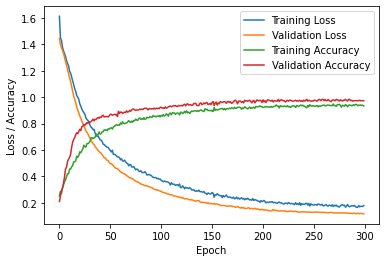

In [30]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss / Accuracy')
plt.legend()
plt.show()

## Pokus cislo 7


Architektura:
- 1 skryta vrstva 
    - aktivacne fukcie: Tanh 
    - pocet neuronov: 16
    - dropout: 0.5
- vystupna vrstva
    - aktivacna fukcia: Softmax
    - pocet neuronov: 4

Hyperparametre:
- optimizer: Adam
- loss: sparse_categorical_crossentropy
- learnig rate: 0.001
    - strategia: ak neklesne loss po 6 epochach lr sa prenasobi 0.8 
- epochy: 300
    - early stop: ak sa po 9 epochach loss nezlepsi vypne sa trenovanie
- velkost batchu: 32

In [31]:
# Initialize WandB
wandb.init(project="neural-network")
wandb.run.name = "Pokus cislo 7 res"
config = wandb.config
config.learning_rate = 0.001
config.batch_size = 32
config.epochs = 300

# Define the model architecture
model = tf.keras.Sequential([
    tf.keras.layers.Dense(16, activation='tanh', input_shape=(20,)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(4, activation='softmax')
])

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=config.learning_rate)

model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=9)
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=6)

history  = model.fit(X_train, y_train, epochs=config.epochs, batch_size=config.batch_size, validation_data=(X_val, y_val), callbacks=[lr_scheduler,early_stop,WandbCallback()])

# Evaluate the model
val_loss, val_acc = model.evaluate(X_val, y_val, verbose=2)
print('Validation accuracy:', val_acc)
print('Validation loss:', val_loss)

# Make predictions
predictions = model.predict(X_val)
print('Predictions:', np.argmax(predictions, axis=1))

# Evaluate the model on the val set and log the results
wandb.log({'Validation loss': val_loss, 'Validation accuracy': val_acc})

Validation accuracy,▁
Validation loss,▁
accuracy,▁▂▃▄▅▆▆▆▆▇▇▇▇▇▇▇▇▇█▇▇███████████████████
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▇▆▅▅▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr,███████████████████████████▆▄▄▄▃▂▂▂▂▂▂▂▁
val_accuracy,▁▃▅▆▆▇▇▇▇▇▇▇▇▇▇▇████████████████████████
val_loss,█▇▆▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation accuracy,0.97333
Validation loss,0.11576
accuracy,0.93294


Epoch 1/300
 1/54 [..............................] - ETA: 46s - loss: 1.4970 - accuracy: 0.1875WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0022s vs `on_train_batch_end` time: 0.0027s). Check your callbacks.


44/54 [=======================>......] - ETA: 0s - loss: 1.4999 - accuracy: 0.2955

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best)... Done. 0.0s


54/54 [==============================] - 3s 34ms/step - loss: 1.4962 - accuracy: 0.2871 - val_loss: 1.3584 - val_accuracy: 0.3167 - lr: 0.0010
Epoch 2/300
32/54 [================>.............] - ETA: 0s - loss: 1.4669 - accuracy: 0.2930

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 39ms/step - loss: 1.4496 - accuracy: 0.3000 - val_loss: 1.3263 - val_accuracy: 0.3600 - lr: 0.0010
Epoch 3/300
52/54 [===========================>..] - ETA: 0s - loss: 1.3874 - accuracy: 0.3347

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 31ms/step - loss: 1.3877 - accuracy: 0.3341 - val_loss: 1.2999 - val_accuracy: 0.3833 - lr: 0.0010
Epoch 4/300
42/54 [======================>.......] - ETA: 0s - loss: 1.3404 - accuracy: 0.3690

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 37ms/step - loss: 1.3513 - accuracy: 0.3582 - val_loss: 1.2599 - val_accuracy: 0.4267 - lr: 0.0010
Epoch 5/300
54/54 [==============================] - ETA: 0s - loss: 1.2966 - accuracy: 0.3782

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 37ms/step - loss: 1.2966 - accuracy: 0.3782 - val_loss: 1.2223 - val_accuracy: 0.4600 - lr: 0.0010
Epoch 6/300
49/54 [==========================>...] - ETA: 0s - loss: 1.2564 - accuracy: 0.4056

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 29ms/step - loss: 1.2538 - accuracy: 0.4094 - val_loss: 1.1869 - val_accuracy: 0.5233 - lr: 0.0010
Epoch 7/300
49/54 [==========================>...] - ETA: 0s - loss: 1.2268 - accuracy: 0.4305

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 33ms/step - loss: 1.2277 - accuracy: 0.4312 - val_loss: 1.1455 - val_accuracy: 0.5567 - lr: 0.0010
Epoch 8/300
30/54 [===============>..............] - ETA: 0s - loss: 1.1769 - accuracy: 0.4708

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 35ms/step - loss: 1.1852 - accuracy: 0.4665 - val_loss: 1.1050 - val_accuracy: 0.6067 - lr: 0.0010
Epoch 9/300
51/54 [===========================>..] - ETA: 0s - loss: 1.1345 - accuracy: 0.5031

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 29ms/step - loss: 1.1353 - accuracy: 0.5024 - val_loss: 1.0684 - val_accuracy: 0.6433 - lr: 0.0010
Epoch 10/300
40/54 [=====================>........] - ETA: 0s - loss: 1.0978 - accuracy: 0.5242

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 31ms/step - loss: 1.0951 - accuracy: 0.5229 - val_loss: 1.0250 - val_accuracy: 0.6600 - lr: 0.0010
Epoch 11/300
44/54 [=======================>......] - ETA: 0s - loss: 1.0773 - accuracy: 0.5249

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 34ms/step - loss: 1.0663 - accuracy: 0.5429 - val_loss: 0.9904 - val_accuracy: 0.6767 - lr: 0.0010
Epoch 12/300
49/54 [==========================>...] - ETA: 0s - loss: 1.0503 - accuracy: 0.5332

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 29ms/step - loss: 1.0516 - accuracy: 0.5294 - val_loss: 0.9540 - val_accuracy: 0.6967 - lr: 0.0010
Epoch 13/300
40/54 [=====================>........] - ETA: 0s - loss: 1.0220 - accuracy: 0.5508

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 30ms/step - loss: 1.0140 - accuracy: 0.5576 - val_loss: 0.9204 - val_accuracy: 0.7200 - lr: 0.0010
Epoch 14/300
45/54 [========================>.....] - ETA: 0s - loss: 0.9734 - accuracy: 0.5806

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 38ms/step - loss: 0.9694 - accuracy: 0.5871 - val_loss: 0.8882 - val_accuracy: 0.7167 - lr: 0.0010
Epoch 15/300
50/54 [==========================>...] - ETA: 0s - loss: 0.9559 - accuracy: 0.5863

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best)... Done. 0.0s


54/54 [==============================] - 1s 28ms/step - loss: 0.9534 - accuracy: 0.5882 - val_loss: 0.8582 - val_accuracy: 0.7400 - lr: 0.0010
Epoch 16/300
47/54 [=========================>....] - ETA: 0s - loss: 0.9280 - accuracy: 0.6024

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 36ms/step - loss: 0.9194 - accuracy: 0.6112 - val_loss: 0.8324 - val_accuracy: 0.7433 - lr: 0.0010
Epoch 17/300
42/54 [======================>.......] - ETA: 0s - loss: 0.9003 - accuracy: 0.6034

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 36ms/step - loss: 0.8941 - accuracy: 0.6088 - val_loss: 0.8103 - val_accuracy: 0.7467 - lr: 0.0010
Epoch 18/300
53/54 [============================>.] - ETA: 0s - loss: 0.8708 - accuracy: 0.6392

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 31ms/step - loss: 0.8708 - accuracy: 0.6394 - val_loss: 0.7864 - val_accuracy: 0.7667 - lr: 0.0010
Epoch 19/300
45/54 [========================>.....] - ETA: 0s - loss: 0.8668 - accuracy: 0.6306

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 29ms/step - loss: 0.8601 - accuracy: 0.6371 - val_loss: 0.7655 - val_accuracy: 0.7600 - lr: 0.0010
Epoch 20/300
47/54 [=========================>....] - ETA: 0s - loss: 0.8450 - accuracy: 0.6436

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 33ms/step - loss: 0.8380 - accuracy: 0.6535 - val_loss: 0.7436 - val_accuracy: 0.7533 - lr: 0.0010
Epoch 21/300
51/54 [===========================>..] - ETA: 0s - loss: 0.8158 - accuracy: 0.6562

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best)... Done. 0.0s


54/54 [==============================] - 1s 28ms/step - loss: 0.8141 - accuracy: 0.6594 - val_loss: 0.7269 - val_accuracy: 0.7833 - lr: 0.0010
Epoch 22/300
45/54 [========================>.....] - ETA: 0s - loss: 0.8111 - accuracy: 0.6569

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 29ms/step - loss: 0.8037 - accuracy: 0.6635 - val_loss: 0.7074 - val_accuracy: 0.7967 - lr: 0.0010
Epoch 23/300
50/54 [==========================>...] - ETA: 0s - loss: 0.7911 - accuracy: 0.6794

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 33ms/step - loss: 0.7868 - accuracy: 0.6841 - val_loss: 0.6928 - val_accuracy: 0.8067 - lr: 0.0010
Epoch 24/300
42/54 [======================>.......] - ETA: 0s - loss: 0.7719 - accuracy: 0.6860

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best)... Done. 0.0s


54/54 [==============================] - 1s 28ms/step - loss: 0.7703 - accuracy: 0.6841 - val_loss: 0.6789 - val_accuracy: 0.8167 - lr: 0.0010
Epoch 25/300
49/54 [==========================>...] - ETA: 0s - loss: 0.7566 - accuracy: 0.7047

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 30ms/step - loss: 0.7533 - accuracy: 0.7053 - val_loss: 0.6651 - val_accuracy: 0.8200 - lr: 0.0010
Epoch 26/300
49/54 [==========================>...] - ETA: 0s - loss: 0.7230 - accuracy: 0.7130

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best)... Done. 0.0s


54/54 [==============================] - 1s 27ms/step - loss: 0.7239 - accuracy: 0.7088 - val_loss: 0.6491 - val_accuracy: 0.8267 - lr: 0.0010
Epoch 27/300
53/54 [============================>.] - ETA: 0s - loss: 0.7182 - accuracy: 0.7217

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 34ms/step - loss: 0.7186 - accuracy: 0.7206 - val_loss: 0.6339 - val_accuracy: 0.8233 - lr: 0.0010
Epoch 28/300
51/54 [===========================>..] - ETA: 0s - loss: 0.7132 - accuracy: 0.7169

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 29ms/step - loss: 0.7112 - accuracy: 0.7165 - val_loss: 0.6219 - val_accuracy: 0.8400 - lr: 0.0010
Epoch 29/300
27/54 [==============>...............] - ETA: 0s - loss: 0.6915 - accuracy: 0.7315

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 32ms/step - loss: 0.6964 - accuracy: 0.7282 - val_loss: 0.6116 - val_accuracy: 0.8467 - lr: 0.0010
Epoch 30/300
46/54 [========================>.....] - ETA: 0s - loss: 0.6800 - accuracy: 0.7310

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 37ms/step - loss: 0.6821 - accuracy: 0.7271 - val_loss: 0.5972 - val_accuracy: 0.8367 - lr: 0.0010
Epoch 31/300
45/54 [========================>.....] - ETA: 0s - loss: 0.6822 - accuracy: 0.7389

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 35ms/step - loss: 0.6811 - accuracy: 0.7441 - val_loss: 0.5870 - val_accuracy: 0.8433 - lr: 0.0010
Epoch 32/300
43/54 [======================>.......] - ETA: 0s - loss: 0.6679 - accuracy: 0.7297

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 40ms/step - loss: 0.6606 - accuracy: 0.7359 - val_loss: 0.5776 - val_accuracy: 0.8567 - lr: 0.0010
Epoch 33/300
43/54 [======================>.......] - ETA: 0s - loss: 0.6542 - accuracy: 0.7427

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best)... Done. 0.0s


54/54 [==============================] - 3s 55ms/step - loss: 0.6547 - accuracy: 0.7471 - val_loss: 0.5672 - val_accuracy: 0.8533 - lr: 0.0010
Epoch 34/300
42/54 [======================>.......] - ETA: 0s - loss: 0.6379 - accuracy: 0.7604

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 31ms/step - loss: 0.6345 - accuracy: 0.7565 - val_loss: 0.5561 - val_accuracy: 0.8567 - lr: 0.0010
Epoch 35/300
43/54 [======================>.......] - ETA: 0s - loss: 0.6337 - accuracy: 0.7580

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 38ms/step - loss: 0.6288 - accuracy: 0.7624 - val_loss: 0.5469 - val_accuracy: 0.8700 - lr: 0.0010
Epoch 36/300
42/54 [======================>.......] - ETA: 0s - loss: 0.6120 - accuracy: 0.7760

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 32ms/step - loss: 0.6181 - accuracy: 0.7718 - val_loss: 0.5370 - val_accuracy: 0.8700 - lr: 0.0010
Epoch 37/300
46/54 [========================>.....] - ETA: 0s - loss: 0.6025 - accuracy: 0.7751

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 32ms/step - loss: 0.6074 - accuracy: 0.7694 - val_loss: 0.5257 - val_accuracy: 0.8767 - lr: 0.0010
Epoch 38/300
44/54 [=======================>......] - ETA: 0s - loss: 0.6074 - accuracy: 0.7656

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 40ms/step - loss: 0.6043 - accuracy: 0.7700 - val_loss: 0.5190 - val_accuracy: 0.8700 - lr: 0.0010
Epoch 39/300
53/54 [============================>.] - ETA: 0s - loss: 0.5880 - accuracy: 0.7842

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 34ms/step - loss: 0.5877 - accuracy: 0.7841 - val_loss: 0.5083 - val_accuracy: 0.8733 - lr: 0.0010
Epoch 40/300
32/54 [================>.............] - ETA: 0s - loss: 0.5879 - accuracy: 0.7861

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 35ms/step - loss: 0.5794 - accuracy: 0.7900 - val_loss: 0.4986 - val_accuracy: 0.8833 - lr: 0.0010
Epoch 41/300
38/54 [====================>.........] - ETA: 0s - loss: 0.5871 - accuracy: 0.7697

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 32ms/step - loss: 0.5884 - accuracy: 0.7682 - val_loss: 0.4910 - val_accuracy: 0.8867 - lr: 0.0010
Epoch 42/300
50/54 [==========================>...] - ETA: 0s - loss: 0.5624 - accuracy: 0.7962

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 30ms/step - loss: 0.5598 - accuracy: 0.8000 - val_loss: 0.4857 - val_accuracy: 0.8833 - lr: 0.0010
Epoch 43/300
43/54 [======================>.......] - ETA: 0s - loss: 0.5520 - accuracy: 0.7980

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 36ms/step - loss: 0.5500 - accuracy: 0.8065 - val_loss: 0.4761 - val_accuracy: 0.8900 - lr: 0.0010
Epoch 44/300
49/54 [==========================>...] - ETA: 0s - loss: 0.5414 - accuracy: 0.8106

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best)... Done. 0.0s


54/54 [==============================] - 1s 28ms/step - loss: 0.5437 - accuracy: 0.8082 - val_loss: 0.4711 - val_accuracy: 0.8767 - lr: 0.0010
Epoch 45/300
52/54 [===========================>..] - ETA: 0s - loss: 0.5430 - accuracy: 0.8059

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 28ms/step - loss: 0.5430 - accuracy: 0.8053 - val_loss: 0.4596 - val_accuracy: 0.8767 - lr: 0.0010
Epoch 46/300
50/54 [==========================>...] - ETA: 0s - loss: 0.5361 - accuracy: 0.8037

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 28ms/step - loss: 0.5364 - accuracy: 0.8047 - val_loss: 0.4541 - val_accuracy: 0.8967 - lr: 0.0010
Epoch 47/300
48/54 [=========================>....] - ETA: 0s - loss: 0.5228 - accuracy: 0.8190

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 30ms/step - loss: 0.5251 - accuracy: 0.8200 - val_loss: 0.4491 - val_accuracy: 0.8800 - lr: 0.0010
Epoch 48/300
47/54 [=========================>....] - ETA: 0s - loss: 0.5121 - accuracy: 0.8092

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 29ms/step - loss: 0.5193 - accuracy: 0.8047 - val_loss: 0.4439 - val_accuracy: 0.8900 - lr: 0.0010
Epoch 49/300
46/54 [========================>.....] - ETA: 0s - loss: 0.5164 - accuracy: 0.8173

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 33ms/step - loss: 0.5205 - accuracy: 0.8135 - val_loss: 0.4314 - val_accuracy: 0.8967 - lr: 0.0010
Epoch 50/300
48/54 [=========================>....] - ETA: 0s - loss: 0.5017 - accuracy: 0.8190

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 37ms/step - loss: 0.5073 - accuracy: 0.8141 - val_loss: 0.4280 - val_accuracy: 0.8967 - lr: 0.0010
Epoch 51/300
51/54 [===========================>..] - ETA: 0s - loss: 0.4979 - accuracy: 0.8186

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 38ms/step - loss: 0.4966 - accuracy: 0.8206 - val_loss: 0.4199 - val_accuracy: 0.9033 - lr: 0.0010
Epoch 52/300
39/54 [====================>.........] - ETA: 0s - loss: 0.5042 - accuracy: 0.8261

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 32ms/step - loss: 0.4972 - accuracy: 0.8259 - val_loss: 0.4135 - val_accuracy: 0.9033 - lr: 0.0010
Epoch 53/300
46/54 [========================>.....] - ETA: 0s - loss: 0.4890 - accuracy: 0.8274

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 35ms/step - loss: 0.4885 - accuracy: 0.8253 - val_loss: 0.4099 - val_accuracy: 0.9000 - lr: 0.0010
Epoch 54/300
45/54 [========================>.....] - ETA: 0s - loss: 0.4748 - accuracy: 0.8354

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 30ms/step - loss: 0.4767 - accuracy: 0.8329 - val_loss: 0.4017 - val_accuracy: 0.9033 - lr: 0.0010
Epoch 55/300
49/54 [==========================>...] - ETA: 0s - loss: 0.4802 - accuracy: 0.8304

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 31ms/step - loss: 0.4771 - accuracy: 0.8324 - val_loss: 0.3959 - val_accuracy: 0.9100 - lr: 0.0010
Epoch 56/300
40/54 [=====================>........] - ETA: 0s - loss: 0.4710 - accuracy: 0.8375

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 37ms/step - loss: 0.4690 - accuracy: 0.8347 - val_loss: 0.3892 - val_accuracy: 0.9067 - lr: 0.0010
Epoch 57/300
50/54 [==========================>...] - ETA: 0s - loss: 0.4578 - accuracy: 0.8531

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 32ms/step - loss: 0.4584 - accuracy: 0.8529 - val_loss: 0.3842 - val_accuracy: 0.9167 - lr: 0.0010
Epoch 58/300
42/54 [======================>.......] - ETA: 0s - loss: 0.4518 - accuracy: 0.8504

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 37ms/step - loss: 0.4551 - accuracy: 0.8471 - val_loss: 0.3792 - val_accuracy: 0.9100 - lr: 0.0010
Epoch 59/300
47/54 [=========================>....] - ETA: 0s - loss: 0.4478 - accuracy: 0.8504

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 39ms/step - loss: 0.4487 - accuracy: 0.8471 - val_loss: 0.3727 - val_accuracy: 0.9133 - lr: 0.0010
Epoch 60/300
50/54 [==========================>...] - ETA: 0s - loss: 0.4392 - accuracy: 0.8438

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 29ms/step - loss: 0.4405 - accuracy: 0.8435 - val_loss: 0.3688 - val_accuracy: 0.9167 - lr: 0.0010
Epoch 61/300
41/54 [=====================>........] - ETA: 0s - loss: 0.4395 - accuracy: 0.8537

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best)... Done. 0.1s


54/54 [==============================] - 2s 34ms/step - loss: 0.4444 - accuracy: 0.8465 - val_loss: 0.3663 - val_accuracy: 0.9067 - lr: 0.0010
Epoch 62/300
49/54 [==========================>...] - ETA: 0s - loss: 0.4308 - accuracy: 0.8597

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 30ms/step - loss: 0.4289 - accuracy: 0.8600 - val_loss: 0.3578 - val_accuracy: 0.9133 - lr: 0.0010
Epoch 63/300
44/54 [=======================>......] - ETA: 0s - loss: 0.4317 - accuracy: 0.8551

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 31ms/step - loss: 0.4341 - accuracy: 0.8524 - val_loss: 0.3514 - val_accuracy: 0.9200 - lr: 0.0010
Epoch 64/300
48/54 [=========================>....] - ETA: 0s - loss: 0.4251 - accuracy: 0.8483

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 39ms/step - loss: 0.4248 - accuracy: 0.8476 - val_loss: 0.3491 - val_accuracy: 0.9167 - lr: 0.0010
Epoch 65/300
52/54 [===========================>..] - ETA: 0s - loss: 0.4255 - accuracy: 0.8504

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 32ms/step - loss: 0.4247 - accuracy: 0.8518 - val_loss: 0.3442 - val_accuracy: 0.9233 - lr: 0.0010
Epoch 66/300
42/54 [======================>.......] - ETA: 0s - loss: 0.4151 - accuracy: 0.8564

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 35ms/step - loss: 0.4117 - accuracy: 0.8594 - val_loss: 0.3415 - val_accuracy: 0.9167 - lr: 0.0010
Epoch 67/300
39/54 [====================>.........] - ETA: 0s - loss: 0.4065 - accuracy: 0.8638

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 38ms/step - loss: 0.4097 - accuracy: 0.8576 - val_loss: 0.3336 - val_accuracy: 0.9267 - lr: 0.0010
Epoch 68/300
53/54 [============================>.] - ETA: 0s - loss: 0.4107 - accuracy: 0.8656

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 32ms/step - loss: 0.4108 - accuracy: 0.8659 - val_loss: 0.3316 - val_accuracy: 0.9200 - lr: 0.0010
Epoch 69/300
49/54 [==========================>...] - ETA: 0s - loss: 0.4127 - accuracy: 0.8527

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 46ms/step - loss: 0.4110 - accuracy: 0.8547 - val_loss: 0.3243 - val_accuracy: 0.9300 - lr: 0.0010
Epoch 70/300
54/54 [==============================] - 0s 3ms/step - loss: 0.4063 - accuracy: 0.8453 - val_loss: 0.3251 - val_accuracy: 0.9167 - lr: 0.0010
Epoch 71/300
49/54 [==========================>...] - ETA: 0s - loss: 0.3945 - accuracy: 0.8540

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 34ms/step - loss: 0.3979 - accuracy: 0.8518 - val_loss: 0.3192 - val_accuracy: 0.9167 - lr: 0.0010
Epoch 72/300
38/54 [====================>.........] - ETA: 0s - loss: 0.3891 - accuracy: 0.8577

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 32ms/step - loss: 0.3887 - accuracy: 0.8565 - val_loss: 0.3149 - val_accuracy: 0.9200 - lr: 0.0010
Epoch 73/300
44/54 [=======================>......] - ETA: 0s - loss: 0.3860 - accuracy: 0.8672

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 34ms/step - loss: 0.3844 - accuracy: 0.8659 - val_loss: 0.3086 - val_accuracy: 0.9267 - lr: 0.0010
Epoch 74/300
46/54 [========================>.....] - ETA: 0s - loss: 0.3794 - accuracy: 0.8635

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 32ms/step - loss: 0.3770 - accuracy: 0.8682 - val_loss: 0.3074 - val_accuracy: 0.9233 - lr: 0.0010
Epoch 75/300
51/54 [===========================>..] - ETA: 0s - loss: 0.3764 - accuracy: 0.8719

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 30ms/step - loss: 0.3744 - accuracy: 0.8759 - val_loss: 0.3049 - val_accuracy: 0.9167 - lr: 0.0010
Epoch 76/300
32/54 [================>.............] - ETA: 0s - loss: 0.3861 - accuracy: 0.8613

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 35ms/step - loss: 0.3755 - accuracy: 0.8671 - val_loss: 0.2993 - val_accuracy: 0.9300 - lr: 0.0010
Epoch 77/300
52/54 [===========================>..] - ETA: 0s - loss: 0.3724 - accuracy: 0.8726

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 31ms/step - loss: 0.3700 - accuracy: 0.8741 - val_loss: 0.2938 - val_accuracy: 0.9333 - lr: 0.0010
Epoch 78/300
47/54 [=========================>....] - ETA: 0s - loss: 0.3688 - accuracy: 0.8710

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 29ms/step - loss: 0.3685 - accuracy: 0.8706 - val_loss: 0.2926 - val_accuracy: 0.9300 - lr: 0.0010
Epoch 79/300
45/54 [========================>.....] - ETA: 0s - loss: 0.3688 - accuracy: 0.8792

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 29ms/step - loss: 0.3656 - accuracy: 0.8800 - val_loss: 0.2925 - val_accuracy: 0.9267 - lr: 0.0010
Epoch 80/300
50/54 [==========================>...] - ETA: 0s - loss: 0.3636 - accuracy: 0.8744

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 31ms/step - loss: 0.3612 - accuracy: 0.8765 - val_loss: 0.2864 - val_accuracy: 0.9300 - lr: 0.0010
Epoch 81/300
49/54 [==========================>...] - ETA: 0s - loss: 0.3555 - accuracy: 0.8814

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best)... Done. 0.0s


54/54 [==============================] - 1s 28ms/step - loss: 0.3586 - accuracy: 0.8806 - val_loss: 0.2815 - val_accuracy: 0.9367 - lr: 0.0010
Epoch 82/300
47/54 [=========================>....] - ETA: 0s - loss: 0.3607 - accuracy: 0.8876

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 29ms/step - loss: 0.3571 - accuracy: 0.8888 - val_loss: 0.2791 - val_accuracy: 0.9333 - lr: 0.0010
Epoch 83/300
48/54 [=========================>....] - ETA: 0s - loss: 0.3549 - accuracy: 0.8711

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 34ms/step - loss: 0.3537 - accuracy: 0.8741 - val_loss: 0.2786 - val_accuracy: 0.9367 - lr: 0.0010
Epoch 84/300
54/54 [==============================] - ETA: 0s - loss: 0.3455 - accuracy: 0.8824

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 28ms/step - loss: 0.3455 - accuracy: 0.8824 - val_loss: 0.2740 - val_accuracy: 0.9400 - lr: 0.0010
Epoch 85/300
49/54 [==========================>...] - ETA: 0s - loss: 0.3533 - accuracy: 0.8769

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 31ms/step - loss: 0.3496 - accuracy: 0.8782 - val_loss: 0.2684 - val_accuracy: 0.9400 - lr: 0.0010
Epoch 86/300
49/54 [==========================>...] - ETA: 0s - loss: 0.3400 - accuracy: 0.8903

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 32ms/step - loss: 0.3392 - accuracy: 0.8906 - val_loss: 0.2671 - val_accuracy: 0.9433 - lr: 0.0010
Epoch 87/300
48/54 [=========================>....] - ETA: 0s - loss: 0.3414 - accuracy: 0.8770

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 29ms/step - loss: 0.3407 - accuracy: 0.8794 - val_loss: 0.2623 - val_accuracy: 0.9467 - lr: 0.0010
Epoch 88/300
49/54 [==========================>...] - ETA: 0s - loss: 0.3312 - accuracy: 0.8871

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 42ms/step - loss: 0.3296 - accuracy: 0.8882 - val_loss: 0.2590 - val_accuracy: 0.9467 - lr: 0.0010
Epoch 89/300
54/54 [==============================] - 0s 3ms/step - loss: 0.3164 - accuracy: 0.9059 - val_loss: 0.2612 - val_accuracy: 0.9400 - lr: 0.0010
Epoch 90/300
49/54 [==========================>...] - ETA: 0s - loss: 0.3256 - accuracy: 0.8948

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 29ms/step - loss: 0.3264 - accuracy: 0.8929 - val_loss: 0.2586 - val_accuracy: 0.9400 - lr: 0.0010
Epoch 91/300
47/54 [=========================>....] - ETA: 0s - loss: 0.3287 - accuracy: 0.8876

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 29ms/step - loss: 0.3288 - accuracy: 0.8865 - val_loss: 0.2541 - val_accuracy: 0.9467 - lr: 0.0010
Epoch 92/300
41/54 [=====================>........] - ETA: 0s - loss: 0.3248 - accuracy: 0.8918

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 29ms/step - loss: 0.3219 - accuracy: 0.8941 - val_loss: 0.2526 - val_accuracy: 0.9367 - lr: 0.0010
Epoch 93/300
48/54 [=========================>....] - ETA: 0s - loss: 0.3134 - accuracy: 0.9004

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 34ms/step - loss: 0.3143 - accuracy: 0.8988 - val_loss: 0.2476 - val_accuracy: 0.9467 - lr: 0.0010
Epoch 94/300
40/54 [=====================>........] - ETA: 0s - loss: 0.3094 - accuracy: 0.8984

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 30ms/step - loss: 0.3154 - accuracy: 0.8918 - val_loss: 0.2469 - val_accuracy: 0.9467 - lr: 0.0010
Epoch 95/300
28/54 [==============>...............] - ETA: 0s - loss: 0.3164 - accuracy: 0.8917

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 29ms/step - loss: 0.3126 - accuracy: 0.8965 - val_loss: 0.2443 - val_accuracy: 0.9433 - lr: 0.0010
Epoch 96/300
33/54 [=================>............] - ETA: 0s - loss: 0.3101 - accuracy: 0.8958

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 38ms/step - loss: 0.3083 - accuracy: 0.8929 - val_loss: 0.2413 - val_accuracy: 0.9433 - lr: 0.0010
Epoch 97/300
45/54 [========================>.....] - ETA: 0s - loss: 0.3155 - accuracy: 0.8917

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 31ms/step - loss: 0.3107 - accuracy: 0.8929 - val_loss: 0.2386 - val_accuracy: 0.9500 - lr: 0.0010
Epoch 98/300
41/54 [=====================>........] - ETA: 0s - loss: 0.3046 - accuracy: 0.8933

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 29ms/step - loss: 0.3051 - accuracy: 0.8965 - val_loss: 0.2362 - val_accuracy: 0.9533 - lr: 0.0010
Epoch 99/300
54/54 [==============================] - 0s 3ms/step - loss: 0.3034 - accuracy: 0.8971 - val_loss: 0.2383 - val_accuracy: 0.9567 - lr: 0.0010
Epoch 100/300
43/54 [======================>.......] - ETA: 0s - loss: 0.3008 - accuracy: 0.8968

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 31ms/step - loss: 0.3012 - accuracy: 0.8976 - val_loss: 0.2343 - val_accuracy: 0.9567 - lr: 0.0010
Epoch 101/300
42/54 [======================>.......] - ETA: 0s - loss: 0.3086 - accuracy: 0.8921

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 34ms/step - loss: 0.3041 - accuracy: 0.8947 - val_loss: 0.2289 - val_accuracy: 0.9600 - lr: 0.0010
Epoch 102/300
49/54 [==========================>...] - ETA: 0s - loss: 0.2986 - accuracy: 0.8967

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 31ms/step - loss: 0.2973 - accuracy: 0.8971 - val_loss: 0.2271 - val_accuracy: 0.9500 - lr: 0.0010
Epoch 103/300
52/54 [===========================>..] - ETA: 0s - loss: 0.3013 - accuracy: 0.9008

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 33ms/step - loss: 0.3031 - accuracy: 0.8994 - val_loss: 0.2228 - val_accuracy: 0.9633 - lr: 0.0010
Epoch 104/300
54/54 [==============================] - 0s 3ms/step - loss: 0.2875 - accuracy: 0.9059 - val_loss: 0.2279 - val_accuracy: 0.9467 - lr: 0.0010
Epoch 105/300
51/54 [===========================>..] - ETA: 0s - loss: 0.2863 - accuracy: 0.9062

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 30ms/step - loss: 0.2829 - accuracy: 0.9088 - val_loss: 0.2192 - val_accuracy: 0.9667 - lr: 0.0010
Epoch 106/300
54/54 [==============================] - 0s 4ms/step - loss: 0.2896 - accuracy: 0.9076 - val_loss: 0.2223 - val_accuracy: 0.9567 - lr: 0.0010
Epoch 107/300
42/54 [======================>.......] - ETA: 0s - loss: 0.2787 - accuracy: 0.9144

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 31ms/step - loss: 0.2839 - accuracy: 0.9076 - val_loss: 0.2187 - val_accuracy: 0.9667 - lr: 0.0010
Epoch 108/300
42/54 [======================>.......] - ETA: 0s - loss: 0.2885 - accuracy: 0.9144

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 32ms/step - loss: 0.2868 - accuracy: 0.9147 - val_loss: 0.2130 - val_accuracy: 0.9667 - lr: 0.0010
Epoch 109/300
50/54 [==========================>...] - ETA: 0s - loss: 0.2960 - accuracy: 0.8975

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 38ms/step - loss: 0.2962 - accuracy: 0.8971 - val_loss: 0.2122 - val_accuracy: 0.9633 - lr: 0.0010
Epoch 110/300
54/54 [==============================] - ETA: 0s - loss: 0.2746 - accuracy: 0.9159

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 28ms/step - loss: 0.2746 - accuracy: 0.9159 - val_loss: 0.2117 - val_accuracy: 0.9600 - lr: 0.0010
Epoch 111/300
48/54 [=========================>....] - ETA: 0s - loss: 0.2743 - accuracy: 0.9134

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 29ms/step - loss: 0.2755 - accuracy: 0.9147 - val_loss: 0.2110 - val_accuracy: 0.9667 - lr: 0.0010
Epoch 112/300
48/54 [=========================>....] - ETA: 0s - loss: 0.2722 - accuracy: 0.9173

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 29ms/step - loss: 0.2715 - accuracy: 0.9188 - val_loss: 0.2072 - val_accuracy: 0.9633 - lr: 0.0010
Epoch 113/300
52/54 [===========================>..] - ETA: 0s - loss: 0.2691 - accuracy: 0.9087

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 29ms/step - loss: 0.2682 - accuracy: 0.9094 - val_loss: 0.2040 - val_accuracy: 0.9600 - lr: 0.0010
Epoch 114/300
46/54 [========================>.....] - ETA: 0s - loss: 0.2759 - accuracy: 0.9103

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 34ms/step - loss: 0.2734 - accuracy: 0.9100 - val_loss: 0.2024 - val_accuracy: 0.9667 - lr: 0.0010
Epoch 115/300
50/54 [==========================>...] - ETA: 0s - loss: 0.2637 - accuracy: 0.9144

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 31ms/step - loss: 0.2624 - accuracy: 0.9153 - val_loss: 0.1996 - val_accuracy: 0.9667 - lr: 0.0010
Epoch 116/300
43/54 [======================>.......] - ETA: 0s - loss: 0.2671 - accuracy: 0.9106

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 34ms/step - loss: 0.2763 - accuracy: 0.9047 - val_loss: 0.1985 - val_accuracy: 0.9667 - lr: 0.0010
Epoch 117/300
54/54 [==============================] - 0s 5ms/step - loss: 0.2668 - accuracy: 0.9147 - val_loss: 0.1995 - val_accuracy: 0.9667 - lr: 0.0010
Epoch 118/300
49/54 [==========================>...] - ETA: 0s - loss: 0.2687 - accuracy: 0.9024

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 38ms/step - loss: 0.2692 - accuracy: 0.9035 - val_loss: 0.1983 - val_accuracy: 0.9467 - lr: 0.0010
Epoch 119/300
40/54 [=====================>........] - ETA: 0s - loss: 0.2676 - accuracy: 0.9156

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 33ms/step - loss: 0.2685 - accuracy: 0.9124 - val_loss: 0.1958 - val_accuracy: 0.9600 - lr: 0.0010
Epoch 120/300
43/54 [======================>.......] - ETA: 0s - loss: 0.2639 - accuracy: 0.9092

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 33ms/step - loss: 0.2595 - accuracy: 0.9129 - val_loss: 0.1941 - val_accuracy: 0.9633 - lr: 0.0010
Epoch 121/300
54/54 [==============================] - 0s 3ms/step - loss: 0.2569 - accuracy: 0.9224 - val_loss: 0.1947 - val_accuracy: 0.9633 - lr: 0.0010
Epoch 122/300
51/54 [===========================>..] - ETA: 0s - loss: 0.2528 - accuracy: 0.9185

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 34ms/step - loss: 0.2530 - accuracy: 0.9194 - val_loss: 0.1914 - val_accuracy: 0.9667 - lr: 0.0010
Epoch 123/300
54/54 [==============================] - 0s 4ms/step - loss: 0.2572 - accuracy: 0.9165 - val_loss: 0.1943 - val_accuracy: 0.9667 - lr: 0.0010
Epoch 124/300
54/54 [==============================] - 0s 3ms/step - loss: 0.2573 - accuracy: 0.9159 - val_loss: 0.1977 - val_accuracy: 0.9467 - lr: 0.0010
Epoch 125/300
49/54 [==========================>...] - ETA: 0s - loss: 0.2452 - accuracy: 0.9260

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 29ms/step - loss: 0.2464 - accuracy: 0.9282 - val_loss: 0.1897 - val_accuracy: 0.9567 - lr: 0.0010
Epoch 126/300
54/54 [==============================] - 0s 3ms/step - loss: 0.2439 - accuracy: 0.9288 - val_loss: 0.1919 - val_accuracy: 0.9600 - lr: 0.0010
Epoch 127/300
52/54 [===========================>..] - ETA: 0s - loss: 0.2456 - accuracy: 0.9261

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 32ms/step - loss: 0.2470 - accuracy: 0.9253 - val_loss: 0.1853 - val_accuracy: 0.9700 - lr: 0.0010
Epoch 128/300
54/54 [==============================] - 0s 3ms/step - loss: 0.2466 - accuracy: 0.9171 - val_loss: 0.1858 - val_accuracy: 0.9600 - lr: 0.0010
Epoch 129/300
46/54 [========================>.....] - ETA: 0s - loss: 0.2451 - accuracy: 0.9192

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 29ms/step - loss: 0.2443 - accuracy: 0.9206 - val_loss: 0.1840 - val_accuracy: 0.9600 - lr: 0.0010
Epoch 130/300
52/54 [===========================>..] - ETA: 0s - loss: 0.2399 - accuracy: 0.9261

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 29ms/step - loss: 0.2398 - accuracy: 0.9265 - val_loss: 0.1820 - val_accuracy: 0.9733 - lr: 0.0010
Epoch 131/300
54/54 [==============================] - 0s 3ms/step - loss: 0.2416 - accuracy: 0.9229 - val_loss: 0.1825 - val_accuracy: 0.9633 - lr: 0.0010
Epoch 132/300
49/54 [==========================>...] - ETA: 0s - loss: 0.2406 - accuracy: 0.9184

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 36ms/step - loss: 0.2395 - accuracy: 0.9194 - val_loss: 0.1793 - val_accuracy: 0.9767 - lr: 0.0010
Epoch 133/300
42/54 [======================>.......] - ETA: 0s - loss: 0.2342 - accuracy: 0.9249

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 33ms/step - loss: 0.2359 - accuracy: 0.9265 - val_loss: 0.1766 - val_accuracy: 0.9700 - lr: 0.0010
Epoch 134/300
50/54 [==========================>...] - ETA: 0s - loss: 0.2381 - accuracy: 0.9162

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 37ms/step - loss: 0.2353 - accuracy: 0.9194 - val_loss: 0.1765 - val_accuracy: 0.9733 - lr: 0.0010
Epoch 135/300
49/54 [==========================>...] - ETA: 0s - loss: 0.2351 - accuracy: 0.9216

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 34ms/step - loss: 0.2314 - accuracy: 0.9259 - val_loss: 0.1758 - val_accuracy: 0.9767 - lr: 0.0010
Epoch 136/300
54/54 [==============================] - 0s 4ms/step - loss: 0.2353 - accuracy: 0.9188 - val_loss: 0.1829 - val_accuracy: 0.9500 - lr: 0.0010
Epoch 137/300
54/54 [==============================] - ETA: 0s - loss: 0.2299 - accuracy: 0.9276

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 29ms/step - loss: 0.2299 - accuracy: 0.9276 - val_loss: 0.1755 - val_accuracy: 0.9667 - lr: 0.0010
Epoch 138/300
42/54 [======================>.......] - ETA: 0s - loss: 0.2231 - accuracy: 0.9338

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 32ms/step - loss: 0.2304 - accuracy: 0.9282 - val_loss: 0.1749 - val_accuracy: 0.9767 - lr: 0.0010
Epoch 139/300
54/54 [==============================] - 0s 4ms/step - loss: 0.2253 - accuracy: 0.9371 - val_loss: 0.1755 - val_accuracy: 0.9667 - lr: 0.0010
Epoch 140/300
45/54 [========================>.....] - ETA: 0s - loss: 0.2193 - accuracy: 0.9354

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 35ms/step - loss: 0.2220 - accuracy: 0.9335 - val_loss: 0.1697 - val_accuracy: 0.9633 - lr: 0.0010
Epoch 141/300
54/54 [==============================] - 0s 4ms/step - loss: 0.2332 - accuracy: 0.9176 - val_loss: 0.1778 - val_accuracy: 0.9433 - lr: 0.0010
Epoch 142/300
54/54 [==============================] - 0s 3ms/step - loss: 0.2409 - accuracy: 0.9135 - val_loss: 0.1752 - val_accuracy: 0.9600 - lr: 0.0010
Epoch 143/300
54/54 [==============================] - 0s 4ms/step - loss: 0.2303 - accuracy: 0.9318 - val_loss: 0.1764 - val_accuracy: 0.9533 - lr: 0.0010
Epoch 144/300
38/54 [====================>.........] - ETA: 0s - loss: 0.2194 - accuracy: 0.9309

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 30ms/step - loss: 0.2196 - accuracy: 0.9329 - val_loss: 0.1685 - val_accuracy: 0.9700 - lr: 0.0010
Epoch 145/300
49/54 [==========================>...] - ETA: 0s - loss: 0.2233 - accuracy: 0.9286

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 35ms/step - loss: 0.2227 - accuracy: 0.9300 - val_loss: 0.1672 - val_accuracy: 0.9733 - lr: 0.0010
Epoch 146/300
48/54 [=========================>....] - ETA: 0s - loss: 0.2319 - accuracy: 0.9238

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 29ms/step - loss: 0.2293 - accuracy: 0.9247 - val_loss: 0.1636 - val_accuracy: 0.9733 - lr: 0.0010
Epoch 147/300
54/54 [==============================] - 0s 4ms/step - loss: 0.2195 - accuracy: 0.9253 - val_loss: 0.1651 - val_accuracy: 0.9700 - lr: 0.0010
Epoch 148/300
54/54 [==============================] - 0s 4ms/step - loss: 0.2247 - accuracy: 0.9218 - val_loss: 0.1671 - val_accuracy: 0.9567 - lr: 0.0010
Epoch 149/300
54/54 [==============================] - 0s 3ms/step - loss: 0.2212 - accuracy: 0.9241 - val_loss: 0.1656 - val_accuracy: 0.9667 - lr: 0.0010
Epoch 150/300
54/54 [==============================] - ETA: 0s - loss: 0.2194 - accuracy: 0.9282

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 29ms/step - loss: 0.2194 - accuracy: 0.9282 - val_loss: 0.1620 - val_accuracy: 0.9700 - lr: 0.0010
Epoch 151/300
46/54 [========================>.....] - ETA: 0s - loss: 0.2208 - accuracy: 0.9226

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 35ms/step - loss: 0.2154 - accuracy: 0.9271 - val_loss: 0.1604 - val_accuracy: 0.9700 - lr: 0.0010
Epoch 152/300
54/54 [==============================] - 0s 3ms/step - loss: 0.2173 - accuracy: 0.9300 - val_loss: 0.1638 - val_accuracy: 0.9633 - lr: 0.0010
Epoch 153/300
49/54 [==========================>...] - ETA: 0s - loss: 0.2156 - accuracy: 0.9369

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 30ms/step - loss: 0.2126 - accuracy: 0.9388 - val_loss: 0.1557 - val_accuracy: 0.9767 - lr: 0.0010
Epoch 154/300
54/54 [==============================] - 0s 4ms/step - loss: 0.2198 - accuracy: 0.9259 - val_loss: 0.1606 - val_accuracy: 0.9600 - lr: 0.0010
Epoch 155/300
43/54 [======================>.......] - ETA: 0s - loss: 0.2238 - accuracy: 0.9273

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 30ms/step - loss: 0.2195 - accuracy: 0.9300 - val_loss: 0.1550 - val_accuracy: 0.9800 - lr: 0.0010
Epoch 156/300
54/54 [==============================] - 0s 3ms/step - loss: 0.2077 - accuracy: 0.9324 - val_loss: 0.1570 - val_accuracy: 0.9767 - lr: 0.0010
Epoch 157/300
54/54 [==============================] - 0s 4ms/step - loss: 0.2146 - accuracy: 0.9288 - val_loss: 0.1658 - val_accuracy: 0.9500 - lr: 0.0010
Epoch 158/300
54/54 [==============================] - 0s 4ms/step - loss: 0.2119 - accuracy: 0.9271 - val_loss: 0.1585 - val_accuracy: 0.9633 - lr: 0.0010
Epoch 159/300
54/54 [==============================] - 0s 4ms/step - loss: 0.2059 - accuracy: 0.9318 - val_loss: 0.1565 - val_accuracy: 0.9633 - lr: 0.0010
Epoch 160/300
54/54 [==============================] - 0s 4ms/step - loss: 0.2095 - accuracy: 0.9371 - val_loss: 0.1570 - val_accuracy: 0.9700 - lr: 0.0010
Epoch 161/300
45/54 [========================>.....] - ETA: 0s - loss: 0.2045

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 38ms/step - loss: 0.2047 - accuracy: 0.9359 - val_loss: 0.1525 - val_accuracy: 0.9600 - lr: 0.0010
Epoch 162/300
52/54 [===========================>..] - ETA: 0s - loss: 0.2002 - accuracy: 0.9345

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 29ms/step - loss: 0.2002 - accuracy: 0.9353 - val_loss: 0.1510 - val_accuracy: 0.9700 - lr: 0.0010
Epoch 163/300
48/54 [=========================>....] - ETA: 0s - loss: 0.2052 - accuracy: 0.9342

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 29ms/step - loss: 0.2028 - accuracy: 0.9365 - val_loss: 0.1477 - val_accuracy: 0.9733 - lr: 0.0010
Epoch 164/300
54/54 [==============================] - 0s 4ms/step - loss: 0.2058 - accuracy: 0.9329 - val_loss: 0.1546 - val_accuracy: 0.9700 - lr: 0.0010
Epoch 165/300
54/54 [==============================] - 0s 5ms/step - loss: 0.2068 - accuracy: 0.9235 - val_loss: 0.1488 - val_accuracy: 0.9767 - lr: 0.0010
Epoch 166/300
42/54 [======================>.......] - ETA: 0s - loss: 0.1953 - accuracy: 0.9397

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 34ms/step - loss: 0.1947 - accuracy: 0.9400 - val_loss: 0.1467 - val_accuracy: 0.9767 - lr: 0.0010
Epoch 167/300
54/54 [==============================] - 0s 4ms/step - loss: 0.1944 - accuracy: 0.9388 - val_loss: 0.1481 - val_accuracy: 0.9700 - lr: 0.0010
Epoch 168/300
54/54 [==============================] - 0s 4ms/step - loss: 0.1969 - accuracy: 0.9353 - val_loss: 0.1484 - val_accuracy: 0.9733 - lr: 0.0010
Epoch 169/300
54/54 [==============================] - 0s 4ms/step - loss: 0.1939 - accuracy: 0.9471 - val_loss: 0.1482 - val_accuracy: 0.9700 - lr: 0.0010
Epoch 170/300
54/54 [==============================] - 0s 4ms/step - loss: 0.2005 - accuracy: 0.9335 - val_loss: 0.1474 - val_accuracy: 0.9733 - lr: 0.0010
Epoch 171/300
37/54 [===================>..........] - ETA: 0s - loss: 0.1880 - accuracy: 0.9434

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 28ms/step - loss: 0.1906 - accuracy: 0.9394 - val_loss: 0.1450 - val_accuracy: 0.9700 - lr: 0.0010
Epoch 172/300
49/54 [==========================>...] - ETA: 0s - loss: 0.2102 - accuracy: 0.9254

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 34ms/step - loss: 0.2087 - accuracy: 0.9265 - val_loss: 0.1442 - val_accuracy: 0.9667 - lr: 0.0010
Epoch 173/300
44/54 [=======================>......] - ETA: 0s - loss: 0.1915 - accuracy: 0.9325

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 40ms/step - loss: 0.1967 - accuracy: 0.9312 - val_loss: 0.1392 - val_accuracy: 0.9733 - lr: 0.0010
Epoch 174/300
54/54 [==============================] - 0s 4ms/step - loss: 0.2022 - accuracy: 0.9276 - val_loss: 0.1405 - val_accuracy: 0.9767 - lr: 0.0010
Epoch 175/300
46/54 [========================>.....] - ETA: 0s - loss: 0.1891 - accuracy: 0.9443

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 29ms/step - loss: 0.1889 - accuracy: 0.9435 - val_loss: 0.1388 - val_accuracy: 0.9767 - lr: 0.0010
Epoch 176/300
54/54 [==============================] - 0s 3ms/step - loss: 0.1886 - accuracy: 0.9353 - val_loss: 0.1399 - val_accuracy: 0.9767 - lr: 0.0010
Epoch 177/300
50/54 [==========================>...] - ETA: 0s - loss: 0.1930 - accuracy: 0.9294

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 34ms/step - loss: 0.1928 - accuracy: 0.9288 - val_loss: 0.1386 - val_accuracy: 0.9700 - lr: 0.0010
Epoch 178/300
54/54 [==============================] - 0s 6ms/step - loss: 0.1805 - accuracy: 0.9424 - val_loss: 0.1404 - val_accuracy: 0.9733 - lr: 0.0010
Epoch 179/300
46/54 [========================>.....] - ETA: 0s - loss: 0.1816 - accuracy: 0.9436

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 28ms/step - loss: 0.1857 - accuracy: 0.9412 - val_loss: 0.1362 - val_accuracy: 0.9733 - lr: 0.0010
Epoch 180/300
54/54 [==============================] - 0s 4ms/step - loss: 0.1911 - accuracy: 0.9418 - val_loss: 0.1366 - val_accuracy: 0.9733 - lr: 0.0010
Epoch 181/300
49/54 [==========================>...] - ETA: 0s - loss: 0.1894 - accuracy: 0.9394

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 34ms/step - loss: 0.1871 - accuracy: 0.9418 - val_loss: 0.1353 - val_accuracy: 0.9733 - lr: 0.0010
Epoch 182/300
54/54 [==============================] - 0s 4ms/step - loss: 0.1861 - accuracy: 0.9435 - val_loss: 0.1366 - val_accuracy: 0.9800 - lr: 0.0010
Epoch 183/300
54/54 [==============================] - 0s 4ms/step - loss: 0.1840 - accuracy: 0.9335 - val_loss: 0.1382 - val_accuracy: 0.9667 - lr: 0.0010
Epoch 184/300
54/54 [==============================] - ETA: 0s - loss: 0.1887 - accuracy: 0.9406

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 32ms/step - loss: 0.1887 - accuracy: 0.9406 - val_loss: 0.1348 - val_accuracy: 0.9733 - lr: 0.0010
Epoch 185/300
54/54 [==============================] - 0s 3ms/step - loss: 0.1899 - accuracy: 0.9324 - val_loss: 0.1362 - val_accuracy: 0.9700 - lr: 0.0010
Epoch 186/300
54/54 [==============================] - 0s 4ms/step - loss: 0.1753 - accuracy: 0.9429 - val_loss: 0.1456 - val_accuracy: 0.9433 - lr: 0.0010
Epoch 187/300
51/54 [===========================>..] - ETA: 0s - loss: 0.1864 - accuracy: 0.9381

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 30ms/step - loss: 0.1857 - accuracy: 0.9376 - val_loss: 0.1342 - val_accuracy: 0.9733 - lr: 0.0010
Epoch 188/300
54/54 [==============================] - 0s 3ms/step - loss: 0.1748 - accuracy: 0.9482 - val_loss: 0.1410 - val_accuracy: 0.9600 - lr: 0.0010
Epoch 189/300
50/54 [==========================>...] - ETA: 0s - loss: 0.1842 - accuracy: 0.9394

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 34ms/step - loss: 0.1838 - accuracy: 0.9406 - val_loss: 0.1318 - val_accuracy: 0.9767 - lr: 0.0010
Epoch 190/300
39/54 [====================>.........] - ETA: 0s - loss: 0.1703 - accuracy: 0.9471

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 30ms/step - loss: 0.1748 - accuracy: 0.9424 - val_loss: 0.1308 - val_accuracy: 0.9767 - lr: 0.0010
Epoch 191/300
54/54 [==============================] - 0s 4ms/step - loss: 0.1849 - accuracy: 0.9412 - val_loss: 0.1321 - val_accuracy: 0.9767 - lr: 0.0010
Epoch 192/300
54/54 [==============================] - 0s 4ms/step - loss: 0.1797 - accuracy: 0.9418 - val_loss: 0.1322 - val_accuracy: 0.9700 - lr: 0.0010
Epoch 193/300
54/54 [==============================] - 0s 4ms/step - loss: 0.1803 - accuracy: 0.9371 - val_loss: 0.1333 - val_accuracy: 0.9733 - lr: 0.0010
Epoch 194/300
47/54 [=========================>....] - ETA: 0s - loss: 0.1722 - accuracy: 0.9475

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 34ms/step - loss: 0.1773 - accuracy: 0.9435 - val_loss: 0.1288 - val_accuracy: 0.9800 - lr: 0.0010
Epoch 195/300
54/54 [==============================] - 0s 4ms/step - loss: 0.1740 - accuracy: 0.9435 - val_loss: 0.1299 - val_accuracy: 0.9567 - lr: 0.0010
Epoch 196/300
54/54 [==============================] - 0s 5ms/step - loss: 0.1808 - accuracy: 0.9394 - val_loss: 0.1315 - val_accuracy: 0.9767 - lr: 0.0010
Epoch 197/300
48/54 [=========================>....] - ETA: 0s - loss: 0.1755 - accuracy: 0.9440

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 36ms/step - loss: 0.1742 - accuracy: 0.9471 - val_loss: 0.1258 - val_accuracy: 0.9700 - lr: 0.0010
Epoch 198/300
54/54 [==============================] - 0s 4ms/step - loss: 0.1757 - accuracy: 0.9447 - val_loss: 0.1314 - val_accuracy: 0.9667 - lr: 0.0010
Epoch 199/300
54/54 [==============================] - 0s 4ms/step - loss: 0.1742 - accuracy: 0.9424 - val_loss: 0.1354 - val_accuracy: 0.9600 - lr: 0.0010
Epoch 200/300
54/54 [==============================] - 0s 4ms/step - loss: 0.1808 - accuracy: 0.9324 - val_loss: 0.1277 - val_accuracy: 0.9700 - lr: 0.0010
Epoch 201/300
54/54 [==============================] - 0s 4ms/step - loss: 0.1692 - accuracy: 0.9465 - val_loss: 0.1296 - val_accuracy: 0.9767 - lr: 0.0010
Epoch 202/300
54/54 [==============================] - 0s 3ms/step - loss: 0.1669 - accuracy: 0.9500 - val_loss: 0.1330 - val_accuracy: 0.9600 - lr: 0.0010
Epoch 203/300
52/54 [===========================>..] - ETA: 0s - loss: 0.1684

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 33ms/step - loss: 0.1676 - accuracy: 0.9471 - val_loss: 0.1230 - val_accuracy: 0.9767 - lr: 0.0010
Epoch 204/300
54/54 [==============================] - 0s 3ms/step - loss: 0.1850 - accuracy: 0.9359 - val_loss: 0.1265 - val_accuracy: 0.9733 - lr: 0.0010
Epoch 205/300
54/54 [==============================] - 0s 3ms/step - loss: 0.1857 - accuracy: 0.9376 - val_loss: 0.1270 - val_accuracy: 0.9733 - lr: 0.0010
Epoch 206/300
54/54 [==============================] - 0s 3ms/step - loss: 0.1701 - accuracy: 0.9471 - val_loss: 0.1254 - val_accuracy: 0.9767 - lr: 0.0010
Epoch 207/300
54/54 [==============================] - 0s 3ms/step - loss: 0.1676 - accuracy: 0.9453 - val_loss: 0.1235 - val_accuracy: 0.9733 - lr: 0.0010
Epoch 208/300
52/54 [===========================>..] - ETA: 0s - loss: 0.1733 - accuracy: 0.9447

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 35ms/step - loss: 0.1722 - accuracy: 0.9453 - val_loss: 0.1228 - val_accuracy: 0.9767 - lr: 0.0010
Epoch 209/300
46/54 [========================>.....] - ETA: 0s - loss: 0.1761 - accuracy: 0.9355

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 28ms/step - loss: 0.1737 - accuracy: 0.9394 - val_loss: 0.1223 - val_accuracy: 0.9833 - lr: 0.0010
Epoch 210/300
41/54 [=====================>........] - ETA: 0s - loss: 0.1699 - accuracy: 0.9421

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 31ms/step - loss: 0.1741 - accuracy: 0.9400 - val_loss: 0.1215 - val_accuracy: 0.9700 - lr: 0.0010
Epoch 211/300
54/54 [==============================] - 0s 4ms/step - loss: 0.1649 - accuracy: 0.9459 - val_loss: 0.1240 - val_accuracy: 0.9700 - lr: 0.0010
Epoch 212/300
54/54 [==============================] - 0s 4ms/step - loss: 0.1572 - accuracy: 0.9506 - val_loss: 0.1254 - val_accuracy: 0.9767 - lr: 0.0010
Epoch 213/300
51/54 [===========================>..] - ETA: 0s - loss: 0.1617 - accuracy: 0.9510

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 34ms/step - loss: 0.1622 - accuracy: 0.9512 - val_loss: 0.1207 - val_accuracy: 0.9833 - lr: 0.0010
Epoch 214/300
54/54 [==============================] - 0s 3ms/step - loss: 0.1568 - accuracy: 0.9512 - val_loss: 0.1288 - val_accuracy: 0.9667 - lr: 0.0010
Epoch 215/300
54/54 [==============================] - 0s 3ms/step - loss: 0.1615 - accuracy: 0.9494 - val_loss: 0.1210 - val_accuracy: 0.9700 - lr: 0.0010
Epoch 216/300
48/54 [=========================>....] - ETA: 0s - loss: 0.1659 - accuracy: 0.9460

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 29ms/step - loss: 0.1652 - accuracy: 0.9459 - val_loss: 0.1206 - val_accuracy: 0.9733 - lr: 0.0010
Epoch 217/300
54/54 [==============================] - 0s 4ms/step - loss: 0.1663 - accuracy: 0.9488 - val_loss: 0.1236 - val_accuracy: 0.9667 - lr: 0.0010
Epoch 218/300
28/54 [==============>...............] - ETA: 0s - loss: 0.1618 - accuracy: 0.9475

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_202859-97hy3tjz\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 37ms/step - loss: 0.1625 - accuracy: 0.9476 - val_loss: 0.1160 - val_accuracy: 0.9700 - lr: 0.0010
Epoch 219/300
54/54 [==============================] - 0s 4ms/step - loss: 0.1606 - accuracy: 0.9488 - val_loss: 0.1230 - val_accuracy: 0.9567 - lr: 0.0010
Epoch 220/300
54/54 [==============================] - 0s 3ms/step - loss: 0.1650 - accuracy: 0.9518 - val_loss: 0.1174 - val_accuracy: 0.9800 - lr: 0.0010
Epoch 221/300
54/54 [==============================] - 0s 4ms/step - loss: 0.1693 - accuracy: 0.9453 - val_loss: 0.1205 - val_accuracy: 0.9767 - lr: 0.0010
Epoch 222/300
54/54 [==============================] - 0s 4ms/step - loss: 0.1635 - accuracy: 0.9476 - val_loss: 0.1164 - val_accuracy: 0.9767 - lr: 0.0010
Epoch 223/300
54/54 [==============================] - 0s 4ms/step - loss: 0.1630 - accuracy: 0.9459 - val_loss: 0.1191 - val_accuracy: 0.9633 - lr: 0.0010
Epoch 224/300
54/54 [==============================] - 0s 4ms/step - loss: 0.

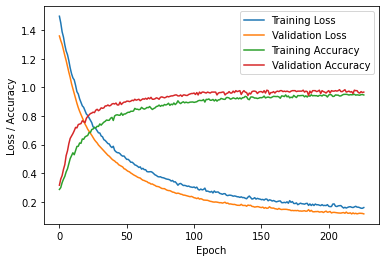

In [32]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss / Accuracy')
plt.legend()
plt.show()

## Pokus cislo 8


Architektura:
- 2 skryta vrstva 
    - aktivacne fukcie: Tanh 
    - pocet neuronov: 64 - 16
    - dropout: 0.5 aplikovany na obe skryte vsrtvy
- vystupna vrstva
    - aktivacna fukcia: Softmax
    - pocet neuronov: 4

Hyperparametre:
- optimizer: Adam
- loss: sparse_categorical_crossentropy
- learnig rate: 0.001
    - strategia: ak neklesne loss po 6 epochach lr sa prenasobi 0.8 
- epochy: 300
    - early stop: ak sa po 9 epochach loss nezlepsi vypne sa trenovanie
- velkost batchu: 64

In [33]:
# Initialize WandB
wandb.init(project="neural-network")
wandb.run.name = "Pokus cislo 8"
config = wandb.config
config.learning_rate = 0.001
config.batch_size = 64
config.epochs = 300

# Define the model architecture
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='tanh', input_shape=(20,)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(16, activation='tanh'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(4, activation='softmax')
])

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=config.learning_rate)

model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=9)
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=6)

history  = model.fit(X_train, y_train, epochs=config.epochs, batch_size=config.batch_size, validation_data=(X_val, y_val), callbacks=[lr_scheduler,early_stop,WandbCallback()])

# Evaluate the model
val_loss, val_acc = model.evaluate(X_val, y_val, verbose=2)
print('Validation accuracy:', val_acc)
print('Validation loss:', val_loss)

# Make predictions
predictions = model.predict(X_val)
print('Predictions:', np.argmax(predictions, axis=1))

# Evaluate the model on the val set and log the results
wandb.log({'Validation loss': val_loss, 'Validation accuracy': val_acc})

Validation accuracy,▁
Validation loss,▁
accuracy,▁▂▃▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇██▇███████████████████
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▇▆▅▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr,███████████████████████████████████████▁
val_accuracy,▁▃▅▆▆▆▇▇▇▇▇▇▇▇▇█████████████████████████
val_loss,█▇▆▅▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation accuracy,0.96667
Validation loss,0.11632
accuracy,0.94647


Epoch 1/300
19/27 [====================>.........] - ETA: 0s - loss: 1.5762 - accuracy: 0.2648 

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best)... Done. 0.0s


27/27 [==============================] - 4s 91ms/step - loss: 1.5752 - accuracy: 0.2665 - val_loss: 1.3549 - val_accuracy: 0.3033 - lr: 0.0010
Epoch 2/300
18/27 [===================>..........] - ETA: 0s - loss: 1.4833 - accuracy: 0.2934

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best)... Done. 0.0s


27/27 [==============================] - 2s 72ms/step - loss: 1.4693 - accuracy: 0.3018 - val_loss: 1.2815 - val_accuracy: 0.4400 - lr: 0.0010
Epoch 3/300
19/27 [====================>.........] - ETA: 0s - loss: 1.4032 - accuracy: 0.3125

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best)... Done. 0.0s


27/27 [==============================] - 2s 83ms/step - loss: 1.3989 - accuracy: 0.3147 - val_loss: 1.2228 - val_accuracy: 0.5433 - lr: 0.0010
Epoch 4/300
19/27 [====================>.........] - ETA: 0s - loss: 1.3604 - accuracy: 0.3281

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best)... Done. 0.0s


27/27 [==============================] - 2s 76ms/step - loss: 1.3579 - accuracy: 0.3347 - val_loss: 1.1673 - val_accuracy: 0.5667 - lr: 0.0010
Epoch 5/300
20/27 [=====================>........] - ETA: 0s - loss: 1.2915 - accuracy: 0.3812

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best)... Done. 0.0s


27/27 [==============================] - 2s 92ms/step - loss: 1.2751 - accuracy: 0.3953 - val_loss: 1.1133 - val_accuracy: 0.6100 - lr: 0.0010
Epoch 6/300
14/27 [==============>...............] - ETA: 0s - loss: 1.2136 - accuracy: 0.4319

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best)... Done. 0.0s


27/27 [==============================] - 2s 95ms/step - loss: 1.2064 - accuracy: 0.4347 - val_loss: 1.0473 - val_accuracy: 0.6467 - lr: 0.0010
Epoch 7/300
16/27 [================>.............] - ETA: 0s - loss: 1.1757 - accuracy: 0.4521

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best)... Done. 0.0s


27/27 [==============================] - 2s 76ms/step - loss: 1.1671 - accuracy: 0.4529 - val_loss: 0.9930 - val_accuracy: 0.6667 - lr: 0.0010
Epoch 8/300
19/27 [====================>.........] - ETA: 0s - loss: 1.1104 - accuracy: 0.4868

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best)... Done. 0.0s


27/27 [==============================] - 2s 84ms/step - loss: 1.1061 - accuracy: 0.4835 - val_loss: 0.9313 - val_accuracy: 0.6767 - lr: 0.0010
Epoch 9/300
20/27 [=====================>........] - ETA: 0s - loss: 1.0655 - accuracy: 0.5008

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best)... Done. 0.0s


27/27 [==============================] - 2s 76ms/step - loss: 1.0631 - accuracy: 0.5000 - val_loss: 0.8812 - val_accuracy: 0.7000 - lr: 0.0010
Epoch 10/300
20/27 [=====================>........] - ETA: 0s - loss: 1.0278 - accuracy: 0.5391

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best)... Done. 0.0s


27/27 [==============================] - 2s 84ms/step - loss: 1.0291 - accuracy: 0.5253 - val_loss: 0.8379 - val_accuracy: 0.6933 - lr: 0.0010
Epoch 11/300
20/27 [=====================>........] - ETA: 0s - loss: 0.9726 - accuracy: 0.5570

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best)... Done. 0.0s


27/27 [==============================] - 2s 90ms/step - loss: 0.9594 - accuracy: 0.5612 - val_loss: 0.8000 - val_accuracy: 0.7233 - lr: 0.0010
Epoch 12/300
14/27 [==============>...............] - ETA: 0s - loss: 0.9527 - accuracy: 0.5446

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best)... Done. 0.0s


27/27 [==============================] - 2s 70ms/step - loss: 0.9532 - accuracy: 0.5506 - val_loss: 0.7643 - val_accuracy: 0.7600 - lr: 0.0010
Epoch 13/300
19/27 [====================>.........] - ETA: 0s - loss: 0.8929 - accuracy: 0.5979

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best)... Done. 0.0s


27/27 [==============================] - 2s 79ms/step - loss: 0.9006 - accuracy: 0.5918 - val_loss: 0.7347 - val_accuracy: 0.7333 - lr: 0.0010
Epoch 14/300
18/27 [===================>..........] - ETA: 0s - loss: 0.8737 - accuracy: 0.5920

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best)... Done. 0.0s


27/27 [==============================] - 2s 70ms/step - loss: 0.8647 - accuracy: 0.5959 - val_loss: 0.7081 - val_accuracy: 0.8033 - lr: 0.0010
Epoch 15/300
17/27 [=================>............] - ETA: 0s - loss: 0.8461 - accuracy: 0.6085

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best)... Done. 0.0s


27/27 [==============================] - 2s 71ms/step - loss: 0.8464 - accuracy: 0.6159 - val_loss: 0.6808 - val_accuracy: 0.8067 - lr: 0.0010
Epoch 16/300
20/27 [=====================>........] - ETA: 0s - loss: 0.8228 - accuracy: 0.6242

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best)... Done. 0.0s


27/27 [==============================] - 2s 81ms/step - loss: 0.8124 - accuracy: 0.6376 - val_loss: 0.6565 - val_accuracy: 0.8167 - lr: 0.0010
Epoch 17/300
16/27 [================>.............] - ETA: 0s - loss: 0.7847 - accuracy: 0.6309

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best)... Done. 0.0s


27/27 [==============================] - 2s 73ms/step - loss: 0.7972 - accuracy: 0.6294 - val_loss: 0.6341 - val_accuracy: 0.8167 - lr: 0.0010
Epoch 18/300
19/27 [====================>.........] - ETA: 0s - loss: 0.7865 - accuracy: 0.6340

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best)... Done. 0.0s


27/27 [==============================] - 2s 69ms/step - loss: 0.7814 - accuracy: 0.6394 - val_loss: 0.6156 - val_accuracy: 0.8200 - lr: 0.0010
Epoch 19/300
19/27 [====================>.........] - ETA: 0s - loss: 0.7483 - accuracy: 0.6661

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best)... Done. 0.0s


27/27 [==============================] - 2s 83ms/step - loss: 0.7522 - accuracy: 0.6635 - val_loss: 0.5948 - val_accuracy: 0.8400 - lr: 0.0010
Epoch 20/300
21/27 [======================>.......] - ETA: 0s - loss: 0.7388 - accuracy: 0.6734

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best)... Done. 0.0s


27/27 [==============================] - 2s 71ms/step - loss: 0.7386 - accuracy: 0.6759 - val_loss: 0.5747 - val_accuracy: 0.8433 - lr: 0.0010
Epoch 21/300
14/27 [==============>...............] - ETA: 0s - loss: 0.7161 - accuracy: 0.6763

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best)... Done. 0.0s


27/27 [==============================] - 2s 82ms/step - loss: 0.7231 - accuracy: 0.6635 - val_loss: 0.5551 - val_accuracy: 0.8467 - lr: 0.0010
Epoch 22/300
18/27 [===================>..........] - ETA: 0s - loss: 0.6845 - accuracy: 0.6962

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best)... Done. 0.0s


27/27 [==============================] - 2s 88ms/step - loss: 0.6942 - accuracy: 0.6853 - val_loss: 0.5401 - val_accuracy: 0.8633 - lr: 0.0010
Epoch 23/300
20/27 [=====================>........] - ETA: 0s - loss: 0.6875 - accuracy: 0.7039

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best)... Done. 0.0s


27/27 [==============================] - 2s 70ms/step - loss: 0.6965 - accuracy: 0.6982 - val_loss: 0.5314 - val_accuracy: 0.8433 - lr: 0.0010
Epoch 24/300
18/27 [===================>..........] - ETA: 0s - loss: 0.6771 - accuracy: 0.6970

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best)... Done. 0.0s


27/27 [==============================] - 2s 84ms/step - loss: 0.6647 - accuracy: 0.7071 - val_loss: 0.5064 - val_accuracy: 0.8700 - lr: 0.0010
Epoch 25/300
19/27 [====================>.........] - ETA: 0s - loss: 0.6433 - accuracy: 0.7344

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best)... Done. 0.0s


27/27 [==============================] - 2s 77ms/step - loss: 0.6477 - accuracy: 0.7200 - val_loss: 0.4880 - val_accuracy: 0.8800 - lr: 0.0010
Epoch 26/300
20/27 [=====================>........] - ETA: 0s - loss: 0.6232 - accuracy: 0.7422

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best)... Done. 0.0s


27/27 [==============================] - 2s 69ms/step - loss: 0.6279 - accuracy: 0.7353 - val_loss: 0.4736 - val_accuracy: 0.9000 - lr: 0.0010
Epoch 27/300
16/27 [================>.............] - ETA: 0s - loss: 0.6170 - accuracy: 0.7432

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best)... Done. 0.0s


27/27 [==============================] - 2s 81ms/step - loss: 0.6229 - accuracy: 0.7406 - val_loss: 0.4618 - val_accuracy: 0.8867 - lr: 0.0010
Epoch 28/300
20/27 [=====================>........] - ETA: 0s - loss: 0.6188 - accuracy: 0.7195

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best)... Done. 0.0s


27/27 [==============================] - 2s 68ms/step - loss: 0.6059 - accuracy: 0.7247 - val_loss: 0.4514 - val_accuracy: 0.8867 - lr: 0.0010
Epoch 29/300
22/27 [=======================>......] - ETA: 0s - loss: 0.5990 - accuracy: 0.7564

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best)... Done. 0.0s


27/27 [==============================] - 2s 78ms/step - loss: 0.6021 - accuracy: 0.7547 - val_loss: 0.4323 - val_accuracy: 0.8933 - lr: 0.0010
Epoch 30/300
21/27 [======================>.......] - ETA: 0s - loss: 0.5935 - accuracy: 0.7537

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best)... Done. 0.0s


27/27 [==============================] - 2s 70ms/step - loss: 0.5875 - accuracy: 0.7571 - val_loss: 0.4207 - val_accuracy: 0.9000 - lr: 0.0010
Epoch 31/300
22/27 [=======================>......] - ETA: 0s - loss: 0.5830 - accuracy: 0.7564

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best)... Done. 0.0s


27/27 [==============================] - 2s 67ms/step - loss: 0.5794 - accuracy: 0.7559 - val_loss: 0.4122 - val_accuracy: 0.9067 - lr: 0.0010
Epoch 32/300
17/27 [=================>............] - ETA: 0s - loss: 0.5447 - accuracy: 0.7904

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best)... Done. 0.0s


27/27 [==============================] - 2s 76ms/step - loss: 0.5386 - accuracy: 0.7935 - val_loss: 0.4007 - val_accuracy: 0.9100 - lr: 0.0010
Epoch 33/300
19/27 [====================>.........] - ETA: 0s - loss: 0.5725 - accuracy: 0.7648

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best)... Done. 0.0s


27/27 [==============================] - 3s 96ms/step - loss: 0.5618 - accuracy: 0.7688 - val_loss: 0.3880 - val_accuracy: 0.9133 - lr: 0.0010
Epoch 34/300
14/27 [==============>...............] - ETA: 0s - loss: 0.5334 - accuracy: 0.7812

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best)... Done. 0.0s


27/27 [==============================] - 2s 74ms/step - loss: 0.5300 - accuracy: 0.7806 - val_loss: 0.3785 - val_accuracy: 0.9167 - lr: 0.0010
Epoch 35/300
23/27 [========================>.....] - ETA: 0s - loss: 0.5206 - accuracy: 0.8043

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best)... Done. 0.0s


27/27 [==============================] - 2s 79ms/step - loss: 0.5214 - accuracy: 0.7971 - val_loss: 0.3710 - val_accuracy: 0.9000 - lr: 0.0010
Epoch 36/300
27/27 [==============================] - 0s 5ms/step - loss: 0.5277 - accuracy: 0.7841 - val_loss: 0.3752 - val_accuracy: 0.8967 - lr: 0.0010
Epoch 37/300
20/27 [=====================>........] - ETA: 0s - loss: 0.5348 - accuracy: 0.7656

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best)... Done. 0.0s


27/27 [==============================] - 2s 71ms/step - loss: 0.5361 - accuracy: 0.7682 - val_loss: 0.3531 - val_accuracy: 0.9200 - lr: 0.0010
Epoch 38/300
21/27 [======================>.......] - ETA: 0s - loss: 0.5040 - accuracy: 0.8036

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best)... Done. 0.0s


27/27 [==============================] - 2s 72ms/step - loss: 0.5060 - accuracy: 0.7988 - val_loss: 0.3452 - val_accuracy: 0.9033 - lr: 0.0010
Epoch 39/300
22/27 [=======================>......] - ETA: 0s - loss: 0.4983 - accuracy: 0.7898

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best)... Done. 0.0s


27/27 [==============================] - 2s 82ms/step - loss: 0.4960 - accuracy: 0.7924 - val_loss: 0.3379 - val_accuracy: 0.9200 - lr: 0.0010
Epoch 40/300
21/27 [======================>.......] - ETA: 0s - loss: 0.5055 - accuracy: 0.8013

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best)... Done. 0.0s


27/27 [==============================] - 2s 74ms/step - loss: 0.5103 - accuracy: 0.7918 - val_loss: 0.3260 - val_accuracy: 0.9233 - lr: 0.0010
Epoch 41/300
21/27 [======================>.......] - ETA: 0s - loss: 0.4833 - accuracy: 0.7894

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best)... Done. 0.0s


27/27 [==============================] - 2s 82ms/step - loss: 0.4923 - accuracy: 0.7841 - val_loss: 0.3210 - val_accuracy: 0.9200 - lr: 0.0010
Epoch 42/300
17/27 [=================>............] - ETA: 0s - loss: 0.4854 - accuracy: 0.7950

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best)... Done. 0.0s


27/27 [==============================] - 2s 73ms/step - loss: 0.4818 - accuracy: 0.7976 - val_loss: 0.3136 - val_accuracy: 0.9200 - lr: 0.0010
Epoch 43/300
21/27 [======================>.......] - ETA: 0s - loss: 0.4381 - accuracy: 0.8199

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best)... Done. 0.0s


27/27 [==============================] - 2s 70ms/step - loss: 0.4365 - accuracy: 0.8212 - val_loss: 0.3053 - val_accuracy: 0.9200 - lr: 0.0010
Epoch 44/300
17/27 [=================>............] - ETA: 0s - loss: 0.4504 - accuracy: 0.8143

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best)... Done. 0.0s


27/27 [==============================] - 2s 82ms/step - loss: 0.4621 - accuracy: 0.8118 - val_loss: 0.2988 - val_accuracy: 0.9233 - lr: 0.0010
Epoch 45/300
20/27 [=====================>........] - ETA: 0s - loss: 0.4617 - accuracy: 0.8094

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best)... Done. 0.0s


27/27 [==============================] - 2s 92ms/step - loss: 0.4658 - accuracy: 0.8041 - val_loss: 0.2939 - val_accuracy: 0.9267 - lr: 0.0010
Epoch 46/300
22/27 [=======================>......] - ETA: 0s - loss: 0.4410 - accuracy: 0.8068

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best)... Done. 0.0s


27/27 [==============================] - 2s 74ms/step - loss: 0.4427 - accuracy: 0.8118 - val_loss: 0.2850 - val_accuracy: 0.9300 - lr: 0.0010
Epoch 47/300
21/27 [======================>.......] - ETA: 0s - loss: 0.4398 - accuracy: 0.8147

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best)... Done. 0.0s


27/27 [==============================] - 2s 70ms/step - loss: 0.4361 - accuracy: 0.8182 - val_loss: 0.2779 - val_accuracy: 0.9367 - lr: 0.0010
Epoch 48/300
27/27 [==============================] - 0s 6ms/step - loss: 0.4374 - accuracy: 0.8353 - val_loss: 0.2830 - val_accuracy: 0.9200 - lr: 0.0010
Epoch 49/300
21/27 [======================>.......] - ETA: 0s - loss: 0.4324 - accuracy: 0.8266

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best)... Done. 0.0s


27/27 [==============================] - 2s 72ms/step - loss: 0.4322 - accuracy: 0.8282 - val_loss: 0.2716 - val_accuracy: 0.9300 - lr: 0.0010
Epoch 50/300
19/27 [====================>.........] - ETA: 0s - loss: 0.4363 - accuracy: 0.8125

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best)... Done. 0.0s


27/27 [==============================] - 2s 82ms/step - loss: 0.4334 - accuracy: 0.8112 - val_loss: 0.2699 - val_accuracy: 0.9433 - lr: 0.0010
Epoch 51/300
21/27 [======================>.......] - ETA: 0s - loss: 0.4362 - accuracy: 0.8132

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best)... Done. 0.0s


27/27 [==============================] - 2s 69ms/step - loss: 0.4308 - accuracy: 0.8212 - val_loss: 0.2576 - val_accuracy: 0.9367 - lr: 0.0010
Epoch 52/300
20/27 [=====================>........] - ETA: 0s - loss: 0.4051 - accuracy: 0.8359

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best)... Done. 0.0s


27/27 [==============================] - 2s 70ms/step - loss: 0.4024 - accuracy: 0.8406 - val_loss: 0.2554 - val_accuracy: 0.9333 - lr: 0.0010
Epoch 53/300
27/27 [==============================] - 0s 5ms/step - loss: 0.4061 - accuracy: 0.8371 - val_loss: 0.2626 - val_accuracy: 0.9100 - lr: 0.0010
Epoch 54/300
20/27 [=====================>........] - ETA: 0s - loss: 0.4071 - accuracy: 0.8445

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best)... Done. 0.0s


27/27 [==============================] - 2s 80ms/step - loss: 0.4104 - accuracy: 0.8394 - val_loss: 0.2506 - val_accuracy: 0.9233 - lr: 0.0010
Epoch 55/300
19/27 [====================>.........] - ETA: 0s - loss: 0.3942 - accuracy: 0.8388

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best)... Done. 0.0s


27/27 [==============================] - 2s 70ms/step - loss: 0.4025 - accuracy: 0.8335 - val_loss: 0.2406 - val_accuracy: 0.9433 - lr: 0.0010
Epoch 56/300
27/27 [==============================] - 0s 5ms/step - loss: 0.3786 - accuracy: 0.8494 - val_loss: 0.2407 - val_accuracy: 0.9400 - lr: 0.0010
Epoch 57/300
21/27 [======================>.......] - ETA: 0s - loss: 0.3983 - accuracy: 0.8385

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best)... Done. 0.0s


27/27 [==============================] - 2s 78ms/step - loss: 0.4019 - accuracy: 0.8353 - val_loss: 0.2345 - val_accuracy: 0.9400 - lr: 0.0010
Epoch 58/300
27/27 [==============================] - 0s 4ms/step - loss: 0.3893 - accuracy: 0.8459 - val_loss: 0.2362 - val_accuracy: 0.9400 - lr: 0.0010
Epoch 59/300
27/27 [==============================] - 0s 5ms/step - loss: 0.3852 - accuracy: 0.8412 - val_loss: 0.2451 - val_accuracy: 0.9433 - lr: 0.0010
Epoch 60/300
23/27 [========================>.....] - ETA: 0s - loss: 0.3741 - accuracy: 0.8404

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best)... Done. 0.0s


27/27 [==============================] - 2s 73ms/step - loss: 0.3742 - accuracy: 0.8388 - val_loss: 0.2265 - val_accuracy: 0.9467 - lr: 0.0010
Epoch 61/300
27/27 [==============================] - 0s 5ms/step - loss: 0.3753 - accuracy: 0.8476 - val_loss: 0.2310 - val_accuracy: 0.9133 - lr: 0.0010
Epoch 62/300
19/27 [====================>.........] - ETA: 0s - loss: 0.3576 - accuracy: 0.8660

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best)... Done. 0.0s


27/27 [==============================] - 2s 78ms/step - loss: 0.3542 - accuracy: 0.8618 - val_loss: 0.2246 - val_accuracy: 0.9200 - lr: 0.0010
Epoch 63/300
19/27 [====================>.........] - ETA: 0s - loss: 0.3706 - accuracy: 0.8594

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best)... Done. 0.0s


27/27 [==============================] - 2s 92ms/step - loss: 0.3768 - accuracy: 0.8541 - val_loss: 0.2139 - val_accuracy: 0.9567 - lr: 0.0010
Epoch 64/300
27/27 [==============================] - 0s 5ms/step - loss: 0.3514 - accuracy: 0.8629 - val_loss: 0.2215 - val_accuracy: 0.9333 - lr: 0.0010
Epoch 65/300
22/27 [=======================>......] - ETA: 0s - loss: 0.3568 - accuracy: 0.8516

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best)... Done. 0.0s


27/27 [==============================] - 2s 76ms/step - loss: 0.3585 - accuracy: 0.8500 - val_loss: 0.2109 - val_accuracy: 0.9567 - lr: 0.0010
Epoch 66/300
18/27 [===================>..........] - ETA: 0s - loss: 0.3444 - accuracy: 0.8655

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best)... Done. 0.0s


27/27 [==============================] - 2s 82ms/step - loss: 0.3490 - accuracy: 0.8600 - val_loss: 0.2017 - val_accuracy: 0.9600 - lr: 0.0010
Epoch 67/300
22/27 [=======================>......] - ETA: 0s - loss: 0.3486 - accuracy: 0.8615

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best)... Done. 0.0s


27/27 [==============================] - 2s 73ms/step - loss: 0.3427 - accuracy: 0.8665 - val_loss: 0.2012 - val_accuracy: 0.9567 - lr: 0.0010
Epoch 68/300
20/27 [=====================>........] - ETA: 0s - loss: 0.3457 - accuracy: 0.8586

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best)... Done. 0.0s


27/27 [==============================] - 2s 68ms/step - loss: 0.3514 - accuracy: 0.8529 - val_loss: 0.1966 - val_accuracy: 0.9600 - lr: 0.0010
Epoch 69/300
27/27 [==============================] - 0s 5ms/step - loss: 0.3355 - accuracy: 0.8582 - val_loss: 0.2042 - val_accuracy: 0.9367 - lr: 0.0010
Epoch 70/300
22/27 [=======================>......] - ETA: 0s - loss: 0.3602 - accuracy: 0.8551

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best)... Done. 0.0s


27/27 [==============================] - 2s 78ms/step - loss: 0.3546 - accuracy: 0.8559 - val_loss: 0.1912 - val_accuracy: 0.9567 - lr: 0.0010
Epoch 71/300
23/27 [========================>.....] - ETA: 0s - loss: 0.3433 - accuracy: 0.8648

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best)... Done. 0.0s


27/27 [==============================] - 2s 72ms/step - loss: 0.3479 - accuracy: 0.8624 - val_loss: 0.1882 - val_accuracy: 0.9667 - lr: 0.0010
Epoch 72/300
19/27 [====================>.........] - ETA: 0s - loss: 0.3341 - accuracy: 0.8586

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best)... Done. 0.0s


27/27 [==============================] - 2s 80ms/step - loss: 0.3362 - accuracy: 0.8576 - val_loss: 0.1874 - val_accuracy: 0.9533 - lr: 0.0010
Epoch 73/300
27/27 [==============================] - 0s 6ms/step - loss: 0.3183 - accuracy: 0.8747 - val_loss: 0.1896 - val_accuracy: 0.9600 - lr: 0.0010
Epoch 74/300
27/27 [==============================] - 0s 5ms/step - loss: 0.3397 - accuracy: 0.8494 - val_loss: 0.1919 - val_accuracy: 0.9500 - lr: 0.0010
Epoch 75/300
21/27 [======================>.......] - ETA: 0s - loss: 0.3385 - accuracy: 0.8690

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best)... Done. 0.0s


27/27 [==============================] - 2s 70ms/step - loss: 0.3305 - accuracy: 0.8735 - val_loss: 0.1775 - val_accuracy: 0.9667 - lr: 0.0010
Epoch 76/300
27/27 [==============================] - 0s 5ms/step - loss: 0.3230 - accuracy: 0.8800 - val_loss: 0.1776 - val_accuracy: 0.9633 - lr: 0.0010
Epoch 77/300
27/27 [==============================] - 0s 5ms/step - loss: 0.3241 - accuracy: 0.8653 - val_loss: 0.1788 - val_accuracy: 0.9600 - lr: 0.0010
Epoch 78/300
20/27 [=====================>........] - ETA: 0s - loss: 0.3130 - accuracy: 0.8695

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best)... Done. 0.0s


27/27 [==============================] - 2s 79ms/step - loss: 0.3093 - accuracy: 0.8747 - val_loss: 0.1701 - val_accuracy: 0.9667 - lr: 0.0010
Epoch 79/300
27/27 [==============================] - 0s 5ms/step - loss: 0.3065 - accuracy: 0.8824 - val_loss: 0.1719 - val_accuracy: 0.9600 - lr: 0.0010
Epoch 80/300
27/27 [==============================] - 0s 5ms/step - loss: 0.3019 - accuracy: 0.8806 - val_loss: 0.1749 - val_accuracy: 0.9367 - lr: 0.0010
Epoch 81/300
23/27 [========================>.....] - ETA: 0s - loss: 0.3100 - accuracy: 0.8757

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best)... Done. 0.0s


27/27 [==============================] - 2s 73ms/step - loss: 0.3110 - accuracy: 0.8765 - val_loss: 0.1678 - val_accuracy: 0.9567 - lr: 0.0010
Epoch 82/300
21/27 [======================>.......] - ETA: 0s - loss: 0.3344 - accuracy: 0.8504

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best)... Done. 0.0s


27/27 [==============================] - 2s 85ms/step - loss: 0.3237 - accuracy: 0.8565 - val_loss: 0.1648 - val_accuracy: 0.9533 - lr: 0.0010
Epoch 83/300
21/27 [======================>.......] - ETA: 0s - loss: 0.2900 - accuracy: 0.8936

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best)... Done. 0.0s


27/27 [==============================] - 2s 79ms/step - loss: 0.3006 - accuracy: 0.8876 - val_loss: 0.1596 - val_accuracy: 0.9633 - lr: 0.0010
Epoch 84/300
27/27 [==============================] - 0s 5ms/step - loss: 0.3056 - accuracy: 0.8800 - val_loss: 0.1633 - val_accuracy: 0.9633 - lr: 0.0010
Epoch 85/300
27/27 [==============================] - 0s 5ms/step - loss: 0.2919 - accuracy: 0.8888 - val_loss: 0.1638 - val_accuracy: 0.9633 - lr: 0.0010
Epoch 86/300
27/27 [==============================] - 0s 5ms/step - loss: 0.3025 - accuracy: 0.8806 - val_loss: 0.1667 - val_accuracy: 0.9467 - lr: 0.0010
Epoch 87/300
20/27 [=====================>........] - ETA: 0s - loss: 0.2970 - accuracy: 0.8828

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best)... Done. 0.0s


27/27 [==============================] - 2s 68ms/step - loss: 0.3083 - accuracy: 0.8800 - val_loss: 0.1566 - val_accuracy: 0.9567 - lr: 0.0010
Epoch 88/300
20/27 [=====================>........] - ETA: 0s - loss: 0.2990 - accuracy: 0.8750

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best)... Done. 0.0s


27/27 [==============================] - 2s 77ms/step - loss: 0.2989 - accuracy: 0.8771 - val_loss: 0.1522 - val_accuracy: 0.9767 - lr: 0.0010
Epoch 89/300
27/27 [==============================] - 0s 5ms/step - loss: 0.2921 - accuracy: 0.8818 - val_loss: 0.1543 - val_accuracy: 0.9633 - lr: 0.0010
Epoch 90/300
27/27 [==============================] - 0s 5ms/step - loss: 0.2844 - accuracy: 0.8965 - val_loss: 0.1658 - val_accuracy: 0.9400 - lr: 0.0010
Epoch 91/300
27/27 [==============================] - 0s 4ms/step - loss: 0.2844 - accuracy: 0.8812 - val_loss: 0.1558 - val_accuracy: 0.9533 - lr: 0.0010
Epoch 92/300
27/27 [==============================] - 0s 5ms/step - loss: 0.2806 - accuracy: 0.8888 - val_loss: 0.1588 - val_accuracy: 0.9633 - lr: 0.0010
Epoch 93/300
21/27 [======================>.......] - ETA: 0s - loss: 0.2714 - accuracy: 0.8936

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best)... Done. 0.0s


27/27 [==============================] - 2s 68ms/step - loss: 0.2735 - accuracy: 0.8924 - val_loss: 0.1511 - val_accuracy: 0.9533 - lr: 0.0010
Epoch 94/300
19/27 [====================>.........] - ETA: 0s - loss: 0.2846 - accuracy: 0.8832

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best)... Done. 0.0s


27/27 [==============================] - 2s 67ms/step - loss: 0.2797 - accuracy: 0.8847 - val_loss: 0.1445 - val_accuracy: 0.9700 - lr: 0.0010
Epoch 95/300
20/27 [=====================>........] - ETA: 0s - loss: 0.2783 - accuracy: 0.8852

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best)... Done. 0.0s


27/27 [==============================] - 2s 79ms/step - loss: 0.2681 - accuracy: 0.8935 - val_loss: 0.1410 - val_accuracy: 0.9733 - lr: 0.0010
Epoch 96/300
17/27 [=================>............] - ETA: 0s - loss: 0.2674 - accuracy: 0.8897

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best)... Done. 0.0s


27/27 [==============================] - 2s 72ms/step - loss: 0.2750 - accuracy: 0.8876 - val_loss: 0.1401 - val_accuracy: 0.9667 - lr: 0.0010
Epoch 97/300
22/27 [=======================>......] - ETA: 0s - loss: 0.2780 - accuracy: 0.8963

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best)... Done. 0.0s


27/27 [==============================] - 2s 72ms/step - loss: 0.2892 - accuracy: 0.8918 - val_loss: 0.1381 - val_accuracy: 0.9700 - lr: 0.0010
Epoch 98/300
27/27 [==============================] - 0s 5ms/step - loss: 0.2920 - accuracy: 0.8741 - val_loss: 0.1507 - val_accuracy: 0.9533 - lr: 0.0010
Epoch 99/300
27/27 [==============================] - 0s 5ms/step - loss: 0.2508 - accuracy: 0.9041 - val_loss: 0.1388 - val_accuracy: 0.9600 - lr: 0.0010
Epoch 100/300
22/27 [=======================>......] - ETA: 0s - loss: 0.2664 - accuracy: 0.8956

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best)... Done. 0.0s


27/27 [==============================] - 2s 77ms/step - loss: 0.2702 - accuracy: 0.8935 - val_loss: 0.1348 - val_accuracy: 0.9767 - lr: 0.0010
Epoch 101/300
27/27 [==============================] - 0s 5ms/step - loss: 0.2675 - accuracy: 0.8918 - val_loss: 0.1404 - val_accuracy: 0.9500 - lr: 0.0010
Epoch 102/300
27/27 [==============================] - 0s 5ms/step - loss: 0.2568 - accuracy: 0.9053 - val_loss: 0.1358 - val_accuracy: 0.9700 - lr: 0.0010
Epoch 103/300
22/27 [=======================>......] - ETA: 0s - loss: 0.2743 - accuracy: 0.8920

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best)... Done. 0.0s


27/27 [==============================] - 2s 70ms/step - loss: 0.2751 - accuracy: 0.8918 - val_loss: 0.1332 - val_accuracy: 0.9667 - lr: 0.0010
Epoch 104/300
21/27 [======================>.......] - ETA: 0s - loss: 0.2626 - accuracy: 0.8958

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best)... Done. 0.0s


27/27 [==============================] - 3s 96ms/step - loss: 0.2583 - accuracy: 0.8982 - val_loss: 0.1293 - val_accuracy: 0.9600 - lr: 0.0010
Epoch 105/300
27/27 [==============================] - 0s 5ms/step - loss: 0.2592 - accuracy: 0.8994 - val_loss: 0.1430 - val_accuracy: 0.9467 - lr: 0.0010
Epoch 106/300
27/27 [==============================] - 0s 4ms/step - loss: 0.2493 - accuracy: 0.8982 - val_loss: 0.1312 - val_accuracy: 0.9633 - lr: 0.0010
Epoch 107/300
22/27 [=======================>......] - ETA: 0s - loss: 0.2514 - accuracy: 0.9070

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best)... Done. 0.0s


27/27 [==============================] - 2s 71ms/step - loss: 0.2438 - accuracy: 0.9082 - val_loss: 0.1286 - val_accuracy: 0.9633 - lr: 0.0010
Epoch 108/300
27/27 [==============================] - 0s 6ms/step - loss: 0.2584 - accuracy: 0.8994 - val_loss: 0.1315 - val_accuracy: 0.9633 - lr: 0.0010
Epoch 109/300
22/27 [=======================>......] - ETA: 0s - loss: 0.2681 - accuracy: 0.8920

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best)... Done. 0.0s


27/27 [==============================] - 2s 84ms/step - loss: 0.2658 - accuracy: 0.8929 - val_loss: 0.1255 - val_accuracy: 0.9600 - lr: 0.0010
Epoch 110/300
21/27 [======================>.......] - ETA: 0s - loss: 0.2371 - accuracy: 0.9092

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best)... Done. 0.0s


27/27 [==============================] - 2s 73ms/step - loss: 0.2401 - accuracy: 0.9100 - val_loss: 0.1232 - val_accuracy: 0.9733 - lr: 0.0010
Epoch 111/300
19/27 [====================>.........] - ETA: 0s - loss: 0.2574 - accuracy: 0.8939

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best)... Done. 0.0s


27/27 [==============================] - 2s 71ms/step - loss: 0.2605 - accuracy: 0.8965 - val_loss: 0.1229 - val_accuracy: 0.9633 - lr: 0.0010
Epoch 112/300
27/27 [==============================] - 0s 5ms/step - loss: 0.2390 - accuracy: 0.9076 - val_loss: 0.1265 - val_accuracy: 0.9667 - lr: 0.0010
Epoch 113/300
27/27 [==============================] - 0s 5ms/step - loss: 0.2406 - accuracy: 0.9118 - val_loss: 0.1349 - val_accuracy: 0.9500 - lr: 0.0010
Epoch 114/300
27/27 [==============================] - 0s 5ms/step - loss: 0.2368 - accuracy: 0.9100 - val_loss: 0.1283 - val_accuracy: 0.9533 - lr: 0.0010
Epoch 115/300
23/27 [========================>.....] - ETA: 0s - loss: 0.2534 - accuracy: 0.9042

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best)... Done. 0.0s


27/27 [==============================] - 2s 79ms/step - loss: 0.2472 - accuracy: 0.9071 - val_loss: 0.1206 - val_accuracy: 0.9633 - lr: 0.0010
Epoch 116/300
27/27 [==============================] - 0s 5ms/step - loss: 0.2682 - accuracy: 0.8894 - val_loss: 0.1265 - val_accuracy: 0.9600 - lr: 0.0010
Epoch 117/300
27/27 [==============================] - 0s 5ms/step - loss: 0.2417 - accuracy: 0.9076 - val_loss: 0.1245 - val_accuracy: 0.9533 - lr: 0.0010
Epoch 118/300
27/27 [==============================] - 0s 5ms/step - loss: 0.2265 - accuracy: 0.9141 - val_loss: 0.1237 - val_accuracy: 0.9633 - lr: 0.0010
Epoch 119/300
27/27 [==============================] - 0s 4ms/step - loss: 0.2108 - accuracy: 0.9229 - val_loss: 0.1239 - val_accuracy: 0.9667 - lr: 0.0010
Epoch 120/300
21/27 [======================>.......] - ETA: 0s - loss: 0.2415 - accuracy: 0.9107

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best)... Done. 0.0s


27/27 [==============================] - 2s 74ms/step - loss: 0.2360 - accuracy: 0.9124 - val_loss: 0.1160 - val_accuracy: 0.9633 - lr: 0.0010
Epoch 121/300
27/27 [==============================] - 0s 5ms/step - loss: 0.2425 - accuracy: 0.9059 - val_loss: 0.1176 - val_accuracy: 0.9567 - lr: 0.0010
Epoch 122/300
27/27 [==============================] - 0s 5ms/step - loss: 0.2361 - accuracy: 0.9035 - val_loss: 0.1161 - val_accuracy: 0.9633 - lr: 0.0010
Epoch 123/300
27/27 [==============================] - 0s 5ms/step - loss: 0.2212 - accuracy: 0.9212 - val_loss: 0.1306 - val_accuracy: 0.9367 - lr: 0.0010
Epoch 124/300
27/27 [==============================] - 0s 5ms/step - loss: 0.2260 - accuracy: 0.9171 - val_loss: 0.1190 - val_accuracy: 0.9567 - lr: 0.0010
Epoch 125/300
27/27 [==============================] - 0s 5ms/step - loss: 0.2192 - accuracy: 0.9124 - val_loss: 0.1228 - val_accuracy: 0.9533 - lr: 0.0010
Epoch 126/300
20/27 [=====================>........] - ETA: 0s - loss: 0.2341

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best)... Done. 0.0s


27/27 [==============================] - 2s 80ms/step - loss: 0.2236 - accuracy: 0.9106 - val_loss: 0.1092 - val_accuracy: 0.9700 - lr: 0.0010
Epoch 127/300
27/27 [==============================] - 0s 5ms/step - loss: 0.2327 - accuracy: 0.9100 - val_loss: 0.1134 - val_accuracy: 0.9700 - lr: 0.0010
Epoch 128/300
27/27 [==============================] - 0s 5ms/step - loss: 0.2374 - accuracy: 0.8959 - val_loss: 0.1129 - val_accuracy: 0.9600 - lr: 0.0010
Epoch 129/300
22/27 [=======================>......] - ETA: 0s - loss: 0.2227 - accuracy: 0.9169

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best)... Done. 0.0s


27/27 [==============================] - 2s 72ms/step - loss: 0.2227 - accuracy: 0.9171 - val_loss: 0.1070 - val_accuracy: 0.9767 - lr: 0.0010
Epoch 130/300
20/27 [=====================>........] - ETA: 0s - loss: 0.2255 - accuracy: 0.9102

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_203621-9rhbogx3\files\model-best)... Done. 0.0s


27/27 [==============================] - 2s 83ms/step - loss: 0.2225 - accuracy: 0.9141 - val_loss: 0.1034 - val_accuracy: 0.9733 - lr: 0.0010
Epoch 131/300
27/27 [==============================] - 0s 5ms/step - loss: 0.2034 - accuracy: 0.9194 - val_loss: 0.1053 - val_accuracy: 0.9600 - lr: 0.0010
Epoch 132/300
27/27 [==============================] - 0s 5ms/step - loss: 0.2135 - accuracy: 0.9235 - val_loss: 0.1082 - val_accuracy: 0.9700 - lr: 0.0010
Epoch 133/300
27/27 [==============================] - 0s 5ms/step - loss: 0.2153 - accuracy: 0.9194 - val_loss: 0.1042 - val_accuracy: 0.9667 - lr: 0.0010
Epoch 134/300
27/27 [==============================] - 0s 5ms/step - loss: 0.2284 - accuracy: 0.9100 - val_loss: 0.1204 - val_accuracy: 0.9500 - lr: 0.0010
Epoch 135/300
27/27 [==============================] - 0s 5ms/step - loss: 0.2287 - accuracy: 0.9065 - val_loss: 0.1056 - val_accuracy: 0.9633 - lr: 0.0010
Epoch 136/300
27/27 [==============================] - 0s 5ms/step - loss: 0.

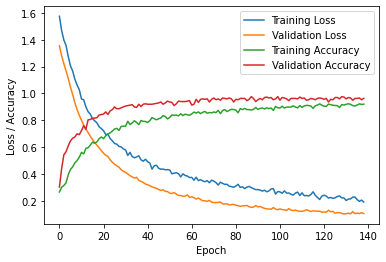

In [34]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss / Accuracy')
plt.legend()
plt.show()

## Pokus cislo 9


Architektura:
- 2 skryte vrstvy
    - aktivacne fukcie: Elu 
    - pocet neuronov: 64 - 16
    - dropout: 0.5 aplikovany na obe skryte vsrtvy
- vystupna vrstva
    - aktivacna fukcia: Softmax
    - pocet neuronov: 4

Hyperparametre:
- optimizer: Adam
- loss: sparse_categorical_crossentropy
- learnig rate: 0.001
    - strategia: ak neklesne loss po 6 epochach lr sa prenasobi 0.8
- epochy: 300
    - early stop: ak sa po 9 epochach loss nezlepsi vypne sa trenovanie
- velkost batchu: 64

In [35]:
# Initialize WandB
wandb.init(project="neural-network")
wandb.run.name = "Pokus cislo 9"
config = wandb.config
config.learning_rate = 0.001
config.batch_size = 64
config.epochs = 300

# Define the model architecture
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='elu', input_shape=(20,)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(16, activation='elu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(4, activation='softmax')
])

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=config.learning_rate)

model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=9)
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=6)

history  = model.fit(X_train, y_train, epochs=config.epochs, batch_size=config.batch_size, validation_data=(X_val, y_val), callbacks=[lr_scheduler,early_stop, WandbCallback()])

# Evaluate the model
val_loss, val_acc = model.evaluate(X_val, y_val, verbose=2)
print('Validation accuracy:', val_acc)
print('Validation loss:', val_loss)

# Make predictions
predictions = model.predict(X_val)
print('Predictions:', np.argmax(predictions, axis=1))

# Evaluate the model on the val set and log the results
wandb.log({'Validation loss': val_loss, 'Validation accuracy': val_acc})

Validation accuracy,▁
Validation loss,▁
accuracy,▁▁▃▄▄▅▅▆▆▇▆▇▇▇▇▇▇▇▇▇▇▇▇▇████▇███████████
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▇▆▅▅▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr,███████████████████████████████████████▁
val_accuracy,▁▃▄▅▆▆▇▇▇▇▇▇▇▇█▇██▇█████████████████████
val_loss,█▇▆▅▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation accuracy,0.96333
Validation loss,0.10611
accuracy,0.92059


Epoch 1/300
19/27 [====================>.........] - ETA: 0s - loss: 1.6817 - accuracy: 0.2640 

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best)... Done. 0.0s


27/27 [==============================] - 4s 96ms/step - loss: 1.6633 - accuracy: 0.2500 - val_loss: 1.3355 - val_accuracy: 0.3233 - lr: 0.0010
Epoch 2/300
19/27 [====================>.........] - ETA: 0s - loss: 1.5020 - accuracy: 0.2673

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best)... Done. 0.0s


27/27 [==============================] - 2s 71ms/step - loss: 1.4905 - accuracy: 0.2747 - val_loss: 1.2869 - val_accuracy: 0.3933 - lr: 0.0010
Epoch 3/300
17/27 [=================>............] - ETA: 0s - loss: 1.4335 - accuracy: 0.2886

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best)... Done. 0.0s


27/27 [==============================] - 2s 80ms/step - loss: 1.4174 - accuracy: 0.3000 - val_loss: 1.2365 - val_accuracy: 0.4400 - lr: 0.0010
Epoch 4/300
17/27 [=================>............] - ETA: 0s - loss: 1.3636 - accuracy: 0.3244

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best)... Done. 0.0s


27/27 [==============================] - 2s 70ms/step - loss: 1.3449 - accuracy: 0.3376 - val_loss: 1.1815 - val_accuracy: 0.5167 - lr: 0.0010
Epoch 5/300
16/27 [================>.............] - ETA: 0s - loss: 1.2746 - accuracy: 0.3740

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best)... Done. 0.0s


27/27 [==============================] - 2s 83ms/step - loss: 1.2666 - accuracy: 0.3818 - val_loss: 1.1319 - val_accuracy: 0.5367 - lr: 0.0010
Epoch 6/300
21/27 [======================>.......] - ETA: 0s - loss: 1.2609 - accuracy: 0.3899

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best)... Done. 0.0s


27/27 [==============================] - 2s 70ms/step - loss: 1.2466 - accuracy: 0.4071 - val_loss: 1.0721 - val_accuracy: 0.5767 - lr: 0.0010
Epoch 7/300
16/27 [================>.............] - ETA: 0s - loss: 1.1689 - accuracy: 0.4492

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best)... Done. 0.0s


27/27 [==============================] - 2s 68ms/step - loss: 1.1661 - accuracy: 0.4494 - val_loss: 1.0171 - val_accuracy: 0.6200 - lr: 0.0010
Epoch 8/300
20/27 [=====================>........] - ETA: 0s - loss: 1.1255 - accuracy: 0.4734

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best)... Done. 0.0s


27/27 [==============================] - 2s 77ms/step - loss: 1.1160 - accuracy: 0.4718 - val_loss: 0.9649 - val_accuracy: 0.6700 - lr: 0.0010
Epoch 9/300
22/27 [=======================>......] - ETA: 0s - loss: 1.0654 - accuracy: 0.4943

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best)... Done. 0.0s


27/27 [==============================] - 2s 68ms/step - loss: 1.0641 - accuracy: 0.5000 - val_loss: 0.9139 - val_accuracy: 0.6967 - lr: 0.0010
Epoch 10/300
21/27 [======================>.......] - ETA: 0s - loss: 1.0352 - accuracy: 0.5037

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best)... Done. 0.0s


27/27 [==============================] - 2s 69ms/step - loss: 1.0261 - accuracy: 0.5071 - val_loss: 0.8611 - val_accuracy: 0.7133 - lr: 0.0010
Epoch 11/300
20/27 [=====================>........] - ETA: 0s - loss: 0.9833 - accuracy: 0.5461

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best)... Done. 0.0s


27/27 [==============================] - 2s 83ms/step - loss: 0.9850 - accuracy: 0.5453 - val_loss: 0.8214 - val_accuracy: 0.7267 - lr: 0.0010
Epoch 12/300
20/27 [=====================>........] - ETA: 0s - loss: 0.9594 - accuracy: 0.5437

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best)... Done. 0.0s


27/27 [==============================] - 2s 92ms/step - loss: 0.9536 - accuracy: 0.5476 - val_loss: 0.7876 - val_accuracy: 0.7400 - lr: 0.0010
Epoch 13/300
20/27 [=====================>........] - ETA: 0s - loss: 0.9069 - accuracy: 0.5773

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best)... Done. 0.0s


27/27 [==============================] - 2s 73ms/step - loss: 0.9138 - accuracy: 0.5700 - val_loss: 0.7554 - val_accuracy: 0.7333 - lr: 0.0010
Epoch 14/300
21/27 [======================>.......] - ETA: 0s - loss: 0.9143 - accuracy: 0.5640

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best)... Done. 0.0s


27/27 [==============================] - 2s 80ms/step - loss: 0.9101 - accuracy: 0.5659 - val_loss: 0.7348 - val_accuracy: 0.7733 - lr: 0.0010
Epoch 15/300
20/27 [=====================>........] - ETA: 0s - loss: 0.8888 - accuracy: 0.5992

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best)... Done. 0.0s


27/27 [==============================] - 2s 70ms/step - loss: 0.8876 - accuracy: 0.6035 - val_loss: 0.7058 - val_accuracy: 0.7667 - lr: 0.0010
Epoch 16/300
21/27 [======================>.......] - ETA: 0s - loss: 0.8431 - accuracy: 0.6027

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best)... Done. 0.0s


27/27 [==============================] - 2s 85ms/step - loss: 0.8524 - accuracy: 0.5994 - val_loss: 0.6832 - val_accuracy: 0.7867 - lr: 0.0010
Epoch 17/300
19/27 [====================>.........] - ETA: 0s - loss: 0.8140 - accuracy: 0.6332

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best)... Done. 0.0s


27/27 [==============================] - 2s 73ms/step - loss: 0.8016 - accuracy: 0.6424 - val_loss: 0.6630 - val_accuracy: 0.8200 - lr: 0.0010
Epoch 18/300
19/27 [====================>.........] - ETA: 0s - loss: 0.8102 - accuracy: 0.6192

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best)... Done. 0.0s


27/27 [==============================] - 2s 74ms/step - loss: 0.8187 - accuracy: 0.6212 - val_loss: 0.6353 - val_accuracy: 0.8133 - lr: 0.0010
Epoch 19/300
21/27 [======================>.......] - ETA: 0s - loss: 0.7918 - accuracy: 0.6362

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best)... Done. 0.0s


27/27 [==============================] - 2s 80ms/step - loss: 0.7927 - accuracy: 0.6359 - val_loss: 0.6222 - val_accuracy: 0.8167 - lr: 0.0010
Epoch 20/300
21/27 [======================>.......] - ETA: 0s - loss: 0.7538 - accuracy: 0.6682

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best)... Done. 0.0s


27/27 [==============================] - 2s 70ms/step - loss: 0.7517 - accuracy: 0.6671 - val_loss: 0.5995 - val_accuracy: 0.8333 - lr: 0.0010
Epoch 21/300
18/27 [===================>..........] - ETA: 0s - loss: 0.7397 - accuracy: 0.6806

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best)... Done. 0.0s


27/27 [==============================] - 2s 81ms/step - loss: 0.7285 - accuracy: 0.6835 - val_loss: 0.5802 - val_accuracy: 0.8433 - lr: 0.0010
Epoch 22/300
20/27 [=====================>........] - ETA: 0s - loss: 0.7154 - accuracy: 0.6867

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best)... Done. 0.0s


27/27 [==============================] - 2s 77ms/step - loss: 0.7194 - accuracy: 0.6771 - val_loss: 0.5645 - val_accuracy: 0.8500 - lr: 0.0010
Epoch 23/300
19/27 [====================>.........] - ETA: 0s - loss: 0.7106 - accuracy: 0.6859

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best)... Done. 0.0s


27/27 [==============================] - 2s 84ms/step - loss: 0.7105 - accuracy: 0.6794 - val_loss: 0.5409 - val_accuracy: 0.8533 - lr: 0.0010
Epoch 24/300
16/27 [================>.............] - ETA: 0s - loss: 0.6830 - accuracy: 0.7148

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best)... Done. 0.0s


27/27 [==============================] - 3s 103ms/step - loss: 0.6881 - accuracy: 0.7082 - val_loss: 0.5250 - val_accuracy: 0.8567 - lr: 0.0010
Epoch 25/300
18/27 [===================>..........] - ETA: 0s - loss: 0.6848 - accuracy: 0.7066

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best)... Done. 0.0s


27/27 [==============================] - 2s 74ms/step - loss: 0.6840 - accuracy: 0.7029 - val_loss: 0.5113 - val_accuracy: 0.8633 - lr: 0.0010
Epoch 26/300
21/27 [======================>.......] - ETA: 0s - loss: 0.6335 - accuracy: 0.7455

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best)... Done. 0.0s


27/27 [==============================] - 2s 68ms/step - loss: 0.6378 - accuracy: 0.7412 - val_loss: 0.4928 - val_accuracy: 0.8667 - lr: 0.0010
Epoch 27/300
20/27 [=====================>........] - ETA: 0s - loss: 0.6594 - accuracy: 0.7125

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best)... Done. 0.0s


27/27 [==============================] - 2s 82ms/step - loss: 0.6451 - accuracy: 0.7176 - val_loss: 0.4791 - val_accuracy: 0.8700 - lr: 0.0010
Epoch 28/300
19/27 [====================>.........] - ETA: 0s - loss: 0.6244 - accuracy: 0.7360

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best)... Done. 0.0s


27/27 [==============================] - 2s 70ms/step - loss: 0.6312 - accuracy: 0.7353 - val_loss: 0.4691 - val_accuracy: 0.8767 - lr: 0.0010
Epoch 29/300
22/27 [=======================>......] - ETA: 0s - loss: 0.6245 - accuracy: 0.7344

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best)... Done. 0.0s


27/27 [==============================] - 2s 70ms/step - loss: 0.6227 - accuracy: 0.7276 - val_loss: 0.4594 - val_accuracy: 0.8633 - lr: 0.0010
Epoch 30/300
21/27 [======================>.......] - ETA: 0s - loss: 0.5989 - accuracy: 0.7448

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best)... Done. 0.0s


27/27 [==============================] - 2s 77ms/step - loss: 0.6108 - accuracy: 0.7324 - val_loss: 0.4401 - val_accuracy: 0.8833 - lr: 0.0010
Epoch 31/300
16/27 [================>.............] - ETA: 0s - loss: 0.6078 - accuracy: 0.7334

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best)... Done. 0.0s


27/27 [==============================] - 2s 73ms/step - loss: 0.5901 - accuracy: 0.7535 - val_loss: 0.4253 - val_accuracy: 0.9000 - lr: 0.0010
Epoch 32/300
16/27 [================>.............] - ETA: 0s - loss: 0.5615 - accuracy: 0.7812

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best)... Done. 0.0s


27/27 [==============================] - 2s 80ms/step - loss: 0.5729 - accuracy: 0.7647 - val_loss: 0.4200 - val_accuracy: 0.8933 - lr: 0.0010
Epoch 33/300
19/27 [====================>.........] - ETA: 0s - loss: 0.5592 - accuracy: 0.7632

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best)... Done. 0.0s


27/27 [==============================] - 2s 77ms/step - loss: 0.5675 - accuracy: 0.7594 - val_loss: 0.4020 - val_accuracy: 0.9033 - lr: 0.0010
Epoch 34/300
19/27 [====================>.........] - ETA: 0s - loss: 0.5462 - accuracy: 0.7738

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best)... Done. 0.0s


27/27 [==============================] - 2s 68ms/step - loss: 0.5401 - accuracy: 0.7759 - val_loss: 0.3923 - val_accuracy: 0.9067 - lr: 0.0010
Epoch 35/300
19/27 [====================>.........] - ETA: 0s - loss: 0.5377 - accuracy: 0.7664

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best)... Done. 0.0s


27/27 [==============================] - 2s 84ms/step - loss: 0.5416 - accuracy: 0.7647 - val_loss: 0.3832 - val_accuracy: 0.9067 - lr: 0.0010
Epoch 36/300
21/27 [======================>.......] - ETA: 0s - loss: 0.5338 - accuracy: 0.7746

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best)... Done. 0.0s


27/27 [==============================] - 2s 85ms/step - loss: 0.5352 - accuracy: 0.7800 - val_loss: 0.3725 - val_accuracy: 0.9000 - lr: 0.0010
Epoch 37/300
21/27 [======================>.......] - ETA: 0s - loss: 0.5127 - accuracy: 0.7887

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best)... Done. 0.0s


27/27 [==============================] - 2s 67ms/step - loss: 0.5148 - accuracy: 0.7888 - val_loss: 0.3635 - val_accuracy: 0.9067 - lr: 0.0010
Epoch 38/300
21/27 [======================>.......] - ETA: 0s - loss: 0.5145 - accuracy: 0.7932

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best)... Done. 0.0s


27/27 [==============================] - 2s 90ms/step - loss: 0.5149 - accuracy: 0.7876 - val_loss: 0.3598 - val_accuracy: 0.8967 - lr: 0.0010
Epoch 39/300
18/27 [===================>..........] - ETA: 0s - loss: 0.5129 - accuracy: 0.7821

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best)... Done. 0.0s


27/27 [==============================] - 2s 69ms/step - loss: 0.5125 - accuracy: 0.7776 - val_loss: 0.3495 - val_accuracy: 0.8967 - lr: 0.0010
Epoch 40/300
18/27 [===================>..........] - ETA: 0s - loss: 0.4954 - accuracy: 0.8099

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best)... Done. 0.0s


27/27 [==============================] - 2s 81ms/step - loss: 0.4936 - accuracy: 0.8018 - val_loss: 0.3348 - val_accuracy: 0.9200 - lr: 0.0010
Epoch 41/300
22/27 [=======================>......] - ETA: 0s - loss: 0.5042 - accuracy: 0.7884

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best)... Done. 0.0s


27/27 [==============================] - 2s 65ms/step - loss: 0.4996 - accuracy: 0.7871 - val_loss: 0.3280 - val_accuracy: 0.9200 - lr: 0.0010
Epoch 42/300
27/27 [==============================] - 0s 5ms/step - loss: 0.4878 - accuracy: 0.8035 - val_loss: 0.3304 - val_accuracy: 0.9000 - lr: 0.0010
Epoch 43/300
23/27 [========================>.....] - ETA: 0s - loss: 0.4673 - accuracy: 0.8125

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best)... Done. 0.0s


27/27 [==============================] - 2s 67ms/step - loss: 0.4713 - accuracy: 0.8112 - val_loss: 0.3175 - val_accuracy: 0.9100 - lr: 0.0010
Epoch 44/300
18/27 [===================>..........] - ETA: 0s - loss: 0.4606 - accuracy: 0.8142

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best)... Done. 0.0s


27/27 [==============================] - 2s 83ms/step - loss: 0.4583 - accuracy: 0.8106 - val_loss: 0.3095 - val_accuracy: 0.9033 - lr: 0.0010
Epoch 45/300
21/27 [======================>.......] - ETA: 0s - loss: 0.4586 - accuracy: 0.8036

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best)... Done. 0.0s


27/27 [==============================] - 2s 70ms/step - loss: 0.4554 - accuracy: 0.8065 - val_loss: 0.2965 - val_accuracy: 0.9300 - lr: 0.0010
Epoch 46/300
22/27 [=======================>......] - ETA: 0s - loss: 0.4404 - accuracy: 0.8175

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best)... Done. 0.0s


27/27 [==============================] - 2s 82ms/step - loss: 0.4395 - accuracy: 0.8200 - val_loss: 0.2871 - val_accuracy: 0.9233 - lr: 0.0010
Epoch 47/300
19/27 [====================>.........] - ETA: 0s - loss: 0.4320 - accuracy: 0.8183

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best)... Done. 0.0s


27/27 [==============================] - 2s 69ms/step - loss: 0.4407 - accuracy: 0.8129 - val_loss: 0.2840 - val_accuracy: 0.9200 - lr: 0.0010
Epoch 48/300
21/27 [======================>.......] - ETA: 0s - loss: 0.4285 - accuracy: 0.8274

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best)... Done. 0.0s


27/27 [==============================] - 2s 84ms/step - loss: 0.4282 - accuracy: 0.8306 - val_loss: 0.2766 - val_accuracy: 0.9167 - lr: 0.0010
Epoch 49/300
21/27 [======================>.......] - ETA: 0s - loss: 0.4219 - accuracy: 0.8438

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best)... Done. 0.0s


27/27 [==============================] - 2s 87ms/step - loss: 0.4226 - accuracy: 0.8424 - val_loss: 0.2701 - val_accuracy: 0.9233 - lr: 0.0010
Epoch 50/300
22/27 [=======================>......] - ETA: 0s - loss: 0.4100 - accuracy: 0.8331

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best)... Done. 0.0s


27/27 [==============================] - 2s 70ms/step - loss: 0.4112 - accuracy: 0.8329 - val_loss: 0.2633 - val_accuracy: 0.9233 - lr: 0.0010
Epoch 51/300
19/27 [====================>.........] - ETA: 0s - loss: 0.4326 - accuracy: 0.8207

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best)... Done. 0.0s


27/27 [==============================] - 2s 89ms/step - loss: 0.4375 - accuracy: 0.8200 - val_loss: 0.2614 - val_accuracy: 0.9333 - lr: 0.0010
Epoch 52/300
17/27 [=================>............] - ETA: 0s - loss: 0.4005 - accuracy: 0.8419

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best)... Done. 0.0s


27/27 [==============================] - 2s 79ms/step - loss: 0.4027 - accuracy: 0.8418 - val_loss: 0.2528 - val_accuracy: 0.9300 - lr: 0.0010
Epoch 53/300
20/27 [=====================>........] - ETA: 0s - loss: 0.4268 - accuracy: 0.8242

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best)... Done. 0.0s


27/27 [==============================] - 2s 69ms/step - loss: 0.4188 - accuracy: 0.8300 - val_loss: 0.2513 - val_accuracy: 0.9233 - lr: 0.0010
Epoch 54/300
21/27 [======================>.......] - ETA: 0s - loss: 0.4021 - accuracy: 0.8452

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best)... Done. 0.0s


27/27 [==============================] - 2s 84ms/step - loss: 0.4062 - accuracy: 0.8435 - val_loss: 0.2462 - val_accuracy: 0.9433 - lr: 0.0010
Epoch 55/300
16/27 [================>.............] - ETA: 0s - loss: 0.3632 - accuracy: 0.8613

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best)... Done. 0.0s


27/27 [==============================] - 2s 75ms/step - loss: 0.3829 - accuracy: 0.8529 - val_loss: 0.2399 - val_accuracy: 0.9467 - lr: 0.0010
Epoch 56/300
17/27 [=================>............] - ETA: 0s - loss: 0.3811 - accuracy: 0.8502

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best)... Done. 0.0s


27/27 [==============================] - 2s 68ms/step - loss: 0.3830 - accuracy: 0.8447 - val_loss: 0.2342 - val_accuracy: 0.9433 - lr: 0.0010
Epoch 57/300
15/27 [===============>..............] - ETA: 0s - loss: 0.3982 - accuracy: 0.8365

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best)... Done. 0.0s


27/27 [==============================] - 2s 85ms/step - loss: 0.3866 - accuracy: 0.8488 - val_loss: 0.2342 - val_accuracy: 0.9467 - lr: 0.0010
Epoch 58/300
19/27 [====================>.........] - ETA: 0s - loss: 0.3915 - accuracy: 0.8405

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best)... Done. 0.0s


27/27 [==============================] - 2s 77ms/step - loss: 0.3747 - accuracy: 0.8524 - val_loss: 0.2214 - val_accuracy: 0.9600 - lr: 0.0010
Epoch 59/300
17/27 [=================>............] - ETA: 0s - loss: 0.3669 - accuracy: 0.8594

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best)... Done. 0.0s


27/27 [==============================] - 3s 97ms/step - loss: 0.3738 - accuracy: 0.8476 - val_loss: 0.2204 - val_accuracy: 0.9567 - lr: 0.0010
Epoch 60/300
27/27 [==============================] - 0s 6ms/step - loss: 0.3629 - accuracy: 0.8512 - val_loss: 0.2217 - val_accuracy: 0.9367 - lr: 0.0010
Epoch 61/300
19/27 [====================>.........] - ETA: 0s - loss: 0.3660 - accuracy: 0.8479

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best)... Done. 0.0s


27/27 [==============================] - 2s 75ms/step - loss: 0.3726 - accuracy: 0.8406 - val_loss: 0.2120 - val_accuracy: 0.9567 - lr: 0.0010
Epoch 62/300
17/27 [=================>............] - ETA: 0s - loss: 0.3648 - accuracy: 0.8520

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best)... Done. 0.0s


27/27 [==============================] - 2s 83ms/step - loss: 0.3602 - accuracy: 0.8535 - val_loss: 0.2119 - val_accuracy: 0.9567 - lr: 0.0010
Epoch 63/300
18/27 [===================>..........] - ETA: 0s - loss: 0.3636 - accuracy: 0.8602

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best)... Done. 0.0s


27/27 [==============================] - 2s 72ms/step - loss: 0.3618 - accuracy: 0.8535 - val_loss: 0.2047 - val_accuracy: 0.9567 - lr: 0.0010
Epoch 64/300
16/27 [================>.............] - ETA: 0s - loss: 0.3501 - accuracy: 0.8711

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best)... Done. 0.0s


27/27 [==============================] - 2s 72ms/step - loss: 0.3455 - accuracy: 0.8718 - val_loss: 0.2007 - val_accuracy: 0.9600 - lr: 0.0010
Epoch 65/300
27/27 [==============================] - 0s 5ms/step - loss: 0.3448 - accuracy: 0.8653 - val_loss: 0.2079 - val_accuracy: 0.9533 - lr: 0.0010
Epoch 66/300
27/27 [==============================] - 0s 5ms/step - loss: 0.3442 - accuracy: 0.8688 - val_loss: 0.2072 - val_accuracy: 0.9467 - lr: 0.0010
Epoch 67/300
27/27 [==============================] - 0s 5ms/step - loss: 0.3275 - accuracy: 0.8753 - val_loss: 0.2262 - val_accuracy: 0.9300 - lr: 0.0010
Epoch 68/300
17/27 [=================>............] - ETA: 0s - loss: 0.3423 - accuracy: 0.8649

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best)... Done. 0.0s


27/27 [==============================] - 2s 76ms/step - loss: 0.3416 - accuracy: 0.8606 - val_loss: 0.1957 - val_accuracy: 0.9567 - lr: 0.0010
Epoch 69/300
17/27 [=================>............] - ETA: 0s - loss: 0.3232 - accuracy: 0.8686

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best)... Done. 0.0s


27/27 [==============================] - 2s 82ms/step - loss: 0.3258 - accuracy: 0.8729 - val_loss: 0.1887 - val_accuracy: 0.9667 - lr: 0.0010
Epoch 70/300
18/27 [===================>..........] - ETA: 0s - loss: 0.3369 - accuracy: 0.8637

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best)... Done. 0.0s


27/27 [==============================] - 2s 84ms/step - loss: 0.3325 - accuracy: 0.8641 - val_loss: 0.1859 - val_accuracy: 0.9600 - lr: 0.0010
Epoch 71/300
27/27 [==============================] - 0s 6ms/step - loss: 0.3315 - accuracy: 0.8647 - val_loss: 0.1881 - val_accuracy: 0.9500 - lr: 0.0010
Epoch 72/300
27/27 [==============================] - 0s 6ms/step - loss: 0.3128 - accuracy: 0.8706 - val_loss: 0.1877 - val_accuracy: 0.9567 - lr: 0.0010
Epoch 73/300
19/27 [====================>.........] - ETA: 0s - loss: 0.3284 - accuracy: 0.8651

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best)... Done. 0.0s


27/27 [==============================] - 2s 79ms/step - loss: 0.3188 - accuracy: 0.8682 - val_loss: 0.1794 - val_accuracy: 0.9667 - lr: 0.0010
Epoch 74/300
22/27 [=======================>......] - ETA: 0s - loss: 0.3100 - accuracy: 0.8778

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best)... Done. 0.0s


27/27 [==============================] - 2s 82ms/step - loss: 0.3132 - accuracy: 0.8765 - val_loss: 0.1789 - val_accuracy: 0.9633 - lr: 0.0010
Epoch 75/300
27/27 [==============================] - 0s 6ms/step - loss: 0.3260 - accuracy: 0.8753 - val_loss: 0.1837 - val_accuracy: 0.9467 - lr: 0.0010
Epoch 76/300
19/27 [====================>.........] - ETA: 0s - loss: 0.3017 - accuracy: 0.8734

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best)... Done. 0.0s


27/27 [==============================] - 2s 74ms/step - loss: 0.3045 - accuracy: 0.8741 - val_loss: 0.1736 - val_accuracy: 0.9600 - lr: 0.0010
Epoch 77/300
27/27 [==============================] - 0s 6ms/step - loss: 0.2868 - accuracy: 0.8835 - val_loss: 0.1794 - val_accuracy: 0.9533 - lr: 0.0010
Epoch 78/300
19/27 [====================>.........] - ETA: 0s - loss: 0.3302 - accuracy: 0.8717

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best)... Done. 0.0s


27/27 [==============================] - 2s 74ms/step - loss: 0.3245 - accuracy: 0.8800 - val_loss: 0.1660 - val_accuracy: 0.9600 - lr: 0.0010
Epoch 79/300
17/27 [=================>............] - ETA: 0s - loss: 0.3063 - accuracy: 0.8676

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best)... Done. 0.0s


27/27 [==============================] - 3s 104ms/step - loss: 0.2960 - accuracy: 0.8782 - val_loss: 0.1607 - val_accuracy: 0.9733 - lr: 0.0010
Epoch 80/300
27/27 [==============================] - 0s 5ms/step - loss: 0.3027 - accuracy: 0.8782 - val_loss: 0.1690 - val_accuracy: 0.9500 - lr: 0.0010
Epoch 81/300
27/27 [==============================] - 0s 6ms/step - loss: 0.2974 - accuracy: 0.8882 - val_loss: 0.1620 - val_accuracy: 0.9567 - lr: 0.0010
Epoch 82/300
27/27 [==============================] - 0s 5ms/step - loss: 0.3001 - accuracy: 0.8806 - val_loss: 0.1623 - val_accuracy: 0.9500 - lr: 0.0010
Epoch 83/300
20/27 [=====================>........] - ETA: 0s - loss: 0.3126 - accuracy: 0.8641

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best)... Done. 0.0s


27/27 [==============================] - 2s 71ms/step - loss: 0.3111 - accuracy: 0.8659 - val_loss: 0.1568 - val_accuracy: 0.9667 - lr: 0.0010
Epoch 84/300
27/27 [==============================] - 0s 6ms/step - loss: 0.2815 - accuracy: 0.8935 - val_loss: 0.1687 - val_accuracy: 0.9600 - lr: 0.0010
Epoch 85/300
19/27 [====================>.........] - ETA: 0s - loss: 0.2975 - accuracy: 0.8725

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best)... Done. 0.0s


27/27 [==============================] - 2s 83ms/step - loss: 0.2997 - accuracy: 0.8741 - val_loss: 0.1476 - val_accuracy: 0.9733 - lr: 0.0010
Epoch 86/300
27/27 [==============================] - 0s 5ms/step - loss: 0.2707 - accuracy: 0.8912 - val_loss: 0.1566 - val_accuracy: 0.9633 - lr: 0.0010
Epoch 87/300
27/27 [==============================] - 0s 5ms/step - loss: 0.2851 - accuracy: 0.8912 - val_loss: 0.1729 - val_accuracy: 0.9333 - lr: 0.0010
Epoch 88/300
27/27 [==============================] - 0s 5ms/step - loss: 0.2890 - accuracy: 0.8871 - val_loss: 0.1626 - val_accuracy: 0.9467 - lr: 0.0010
Epoch 89/300
18/27 [===================>..........] - ETA: 0s - loss: 0.2985 - accuracy: 0.8924

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best)... Done. 0.0s


27/27 [==============================] - 2s 81ms/step - loss: 0.2911 - accuracy: 0.8888 - val_loss: 0.1433 - val_accuracy: 0.9767 - lr: 0.0010
Epoch 90/300
27/27 [==============================] - 0s 5ms/step - loss: 0.2808 - accuracy: 0.8871 - val_loss: 0.1525 - val_accuracy: 0.9467 - lr: 0.0010
Epoch 91/300
27/27 [==============================] - 0s 5ms/step - loss: 0.2765 - accuracy: 0.8894 - val_loss: 0.1544 - val_accuracy: 0.9533 - lr: 0.0010
Epoch 92/300
27/27 [==============================] - 0s 6ms/step - loss: 0.2675 - accuracy: 0.8965 - val_loss: 0.1447 - val_accuracy: 0.9633 - lr: 0.0010
Epoch 93/300
17/27 [=================>............] - ETA: 0s - loss: 0.2656 - accuracy: 0.8952

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best)... Done. 0.0s


27/27 [==============================] - 2s 84ms/step - loss: 0.2707 - accuracy: 0.8924 - val_loss: 0.1417 - val_accuracy: 0.9667 - lr: 0.0010
Epoch 94/300
27/27 [==============================] - 0s 6ms/step - loss: 0.2579 - accuracy: 0.9000 - val_loss: 0.1420 - val_accuracy: 0.9633 - lr: 0.0010
Epoch 95/300
19/27 [====================>.........] - ETA: 0s - loss: 0.2488 - accuracy: 0.9054

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best)... Done. 0.0s


27/27 [==============================] - 2s 74ms/step - loss: 0.2585 - accuracy: 0.9018 - val_loss: 0.1328 - val_accuracy: 0.9733 - lr: 0.0010
Epoch 96/300
27/27 [==============================] - 0s 5ms/step - loss: 0.2591 - accuracy: 0.8965 - val_loss: 0.1472 - val_accuracy: 0.9567 - lr: 0.0010
Epoch 97/300
27/27 [==============================] - 0s 6ms/step - loss: 0.2602 - accuracy: 0.8971 - val_loss: 0.1335 - val_accuracy: 0.9733 - lr: 0.0010
Epoch 98/300
27/27 [==============================] - 0s 6ms/step - loss: 0.2683 - accuracy: 0.8876 - val_loss: 0.1393 - val_accuracy: 0.9567 - lr: 0.0010
Epoch 99/300
27/27 [==============================] - 0s 6ms/step - loss: 0.2597 - accuracy: 0.8988 - val_loss: 0.1404 - val_accuracy: 0.9567 - lr: 0.0010
Epoch 100/300
17/27 [=================>............] - ETA: 0s - loss: 0.2364 - accuracy: 0.9108

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best)... Done. 0.0s


27/27 [==============================] - 2s 82ms/step - loss: 0.2436 - accuracy: 0.9029 - val_loss: 0.1324 - val_accuracy: 0.9733 - lr: 0.0010
Epoch 101/300
18/27 [===================>..........] - ETA: 0s - loss: 0.2401 - accuracy: 0.9010

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best)... Done. 0.0s


27/27 [==============================] - 2s 71ms/step - loss: 0.2496 - accuracy: 0.8982 - val_loss: 0.1287 - val_accuracy: 0.9667 - lr: 0.0010
Epoch 102/300
16/27 [================>.............] - ETA: 0s - loss: 0.2599 - accuracy: 0.8916

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best)... Done. 0.0s


27/27 [==============================] - 2s 75ms/step - loss: 0.2543 - accuracy: 0.8982 - val_loss: 0.1267 - val_accuracy: 0.9733 - lr: 0.0010
Epoch 103/300
27/27 [==============================] - 0s 5ms/step - loss: 0.2441 - accuracy: 0.9076 - val_loss: 0.1282 - val_accuracy: 0.9700 - lr: 0.0010
Epoch 104/300
27/27 [==============================] - 0s 5ms/step - loss: 0.2509 - accuracy: 0.9029 - val_loss: 0.1428 - val_accuracy: 0.9533 - lr: 0.0010
Epoch 105/300
27/27 [==============================] - 0s 6ms/step - loss: 0.2456 - accuracy: 0.9006 - val_loss: 0.1274 - val_accuracy: 0.9700 - lr: 0.0010
Epoch 106/300
27/27 [==============================] - 0s 6ms/step - loss: 0.2423 - accuracy: 0.9065 - val_loss: 0.1317 - val_accuracy: 0.9533 - lr: 0.0010
Epoch 107/300
27/27 [==============================] - 0s 5ms/step - loss: 0.2272 - accuracy: 0.9082 - val_loss: 0.1298 - val_accuracy: 0.9600 - lr: 0.0010
Epoch 108/300
19/27 [====================>.........] - ETA: 0s - loss: 0.2359

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best)... Done. 0.0s


27/27 [==============================] - 2s 74ms/step - loss: 0.2394 - accuracy: 0.9129 - val_loss: 0.1247 - val_accuracy: 0.9667 - lr: 0.0010
Epoch 109/300
17/27 [=================>............] - ETA: 0s - loss: 0.2155 - accuracy: 0.9366

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best)... Done. 0.0s


27/27 [==============================] - 2s 74ms/step - loss: 0.2311 - accuracy: 0.9253 - val_loss: 0.1247 - val_accuracy: 0.9667 - lr: 0.0010
Epoch 110/300
14/27 [==============>...............] - ETA: 0s - loss: 0.2341 - accuracy: 0.9152

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best)... Done. 0.0s


27/27 [==============================] - 2s 84ms/step - loss: 0.2326 - accuracy: 0.9194 - val_loss: 0.1199 - val_accuracy: 0.9700 - lr: 0.0010
Epoch 111/300
19/27 [====================>.........] - ETA: 0s - loss: 0.2343 - accuracy: 0.9054

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best)... Done. 0.0s


27/27 [==============================] - 2s 90ms/step - loss: 0.2289 - accuracy: 0.9071 - val_loss: 0.1168 - val_accuracy: 0.9733 - lr: 0.0010
Epoch 112/300
27/27 [==============================] - 0s 6ms/step - loss: 0.2357 - accuracy: 0.9094 - val_loss: 0.1239 - val_accuracy: 0.9600 - lr: 0.0010
Epoch 113/300
27/27 [==============================] - 0s 5ms/step - loss: 0.2459 - accuracy: 0.9041 - val_loss: 0.1222 - val_accuracy: 0.9733 - lr: 0.0010
Epoch 114/300
27/27 [==============================] - 0s 5ms/step - loss: 0.2298 - accuracy: 0.9047 - val_loss: 0.1286 - val_accuracy: 0.9500 - lr: 0.0010
Epoch 115/300
27/27 [==============================] - 0s 6ms/step - loss: 0.2329 - accuracy: 0.9088 - val_loss: 0.1211 - val_accuracy: 0.9633 - lr: 0.0010
Epoch 116/300
15/27 [===============>..............] - ETA: 0s - loss: 0.2075 - accuracy: 0.9198

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best)... Done. 0.0s


27/27 [==============================] - 2s 82ms/step - loss: 0.2142 - accuracy: 0.9212 - val_loss: 0.1163 - val_accuracy: 0.9600 - lr: 0.0010
Epoch 117/300
27/27 [==============================] - 0s 5ms/step - loss: 0.2131 - accuracy: 0.9153 - val_loss: 0.1201 - val_accuracy: 0.9633 - lr: 0.0010
Epoch 118/300
27/27 [==============================] - 0s 5ms/step - loss: 0.2238 - accuracy: 0.9118 - val_loss: 0.1167 - val_accuracy: 0.9667 - lr: 0.0010
Epoch 119/300
27/27 [==============================] - 0s 5ms/step - loss: 0.2248 - accuracy: 0.9076 - val_loss: 0.1179 - val_accuracy: 0.9600 - lr: 0.0010
Epoch 120/300
16/27 [================>.............] - ETA: 0s - loss: 0.2242 - accuracy: 0.9092

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best)... Done. 0.0s


27/27 [==============================] - 2s 72ms/step - loss: 0.2123 - accuracy: 0.9176 - val_loss: 0.1096 - val_accuracy: 0.9833 - lr: 0.0010
Epoch 121/300
27/27 [==============================] - 0s 5ms/step - loss: 0.2022 - accuracy: 0.9247 - val_loss: 0.1097 - val_accuracy: 0.9800 - lr: 0.0010
Epoch 122/300
27/27 [==============================] - 0s 6ms/step - loss: 0.2300 - accuracy: 0.9047 - val_loss: 0.1132 - val_accuracy: 0.9600 - lr: 0.0010
Epoch 123/300
27/27 [==============================] - 0s 5ms/step - loss: 0.2079 - accuracy: 0.9212 - val_loss: 0.1114 - val_accuracy: 0.9767 - lr: 0.0010
Epoch 124/300
19/27 [====================>.........] - ETA: 0s - loss: 0.2140 - accuracy: 0.9169

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best)... Done. 0.0s


27/27 [==============================] - 2s 84ms/step - loss: 0.2167 - accuracy: 0.9129 - val_loss: 0.1056 - val_accuracy: 0.9733 - lr: 0.0010
Epoch 125/300
17/27 [=================>............] - ETA: 0s - loss: 0.2278 - accuracy: 0.9035

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204146-u1zulf2b\files\model-best)... Done. 0.0s


27/27 [==============================] - 2s 69ms/step - loss: 0.2278 - accuracy: 0.9029 - val_loss: 0.1036 - val_accuracy: 0.9833 - lr: 0.0010
Epoch 126/300
27/27 [==============================] - 0s 6ms/step - loss: 0.2373 - accuracy: 0.9029 - val_loss: 0.1273 - val_accuracy: 0.9433 - lr: 0.0010
Epoch 127/300
27/27 [==============================] - 0s 5ms/step - loss: 0.2286 - accuracy: 0.9088 - val_loss: 0.1078 - val_accuracy: 0.9767 - lr: 0.0010
Epoch 128/300
27/27 [==============================] - 0s 6ms/step - loss: 0.1998 - accuracy: 0.9271 - val_loss: 0.1113 - val_accuracy: 0.9667 - lr: 0.0010
Epoch 129/300
27/27 [==============================] - 0s 5ms/step - loss: 0.2171 - accuracy: 0.9129 - val_loss: 0.1077 - val_accuracy: 0.9700 - lr: 0.0010
Epoch 130/300
27/27 [==============================] - 0s 5ms/step - loss: 0.2292 - accuracy: 0.9176 - val_loss: 0.1155 - val_accuracy: 0.9600 - lr: 0.0010
Epoch 131/300
27/27 [==============================] - 0s 5ms/step - loss: 0.

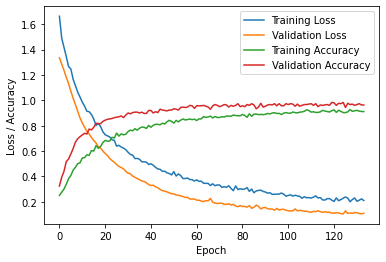

In [36]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss / Accuracy')
plt.legend()
plt.show()

## Pokus cislo 10

Architektura:
- 1 skryta vrstva 
    - aktivacne fukcie: LeakyReLU 
    - pocet neuronov: 32
    - dropout: 0.5
- vystupna vrstva
    - aktivacna fukcia: Softmax
    - pocet neuronov: 4

Hyperparametre:
- optimizer: Adam
- loss: sparse_categorical_crossentropy
- learnig rate: 0.001
    - strategia: ak neklesne loss po 5 epochach lr sa prenasobi 0.8 
- epochy: 300
    - early stop: ak sa po 10 epochach loss nezlepsi vypne sa trenovanie
- velkost batchu: 32

In [37]:
# Initialize WandB
wandb.init(project="neural-network")
wandb.run.name = "Pokus cislo 10"
config = wandb.config
config.learning_rate = 0.001
config.batch_size = 32
config.epochs = 300

# Define the model architecture
model = tf.keras.Sequential([
    tf.keras.layers.Dense(32, activation='LeakyReLU', input_shape=(20,)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(4, activation='softmax')
])

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=config.learning_rate)

model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=5)

history  = model.fit(X_train, y_train, epochs=config.epochs, batch_size=config.batch_size, validation_data=(X_val, y_val), callbacks=[lr_scheduler,early_stop, WandbCallback()])

# Evaluate the model
val_loss, val_acc = model.evaluate(X_val, y_val, verbose=2)
print('Validation accuracy:', val_acc)
print('Validation loss:', val_loss)

# Make predictions
predictions = model.predict(X_val)
print('Predictions:', np.argmax(predictions, axis=1))

# Evaluate the model on the val set and log the results
wandb.log({'Validation loss': val_loss, 'Validation accuracy': val_acc})

Validation accuracy,▁
Validation loss,▁
accuracy,▁▂▃▄▄▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇█████████████████
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▇▆▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr,███████████████████████████████████████▁
val_accuracy,▁▂▄▅▆▆▆▆▇▇▇▇▇▇▇▇████████████████████████
val_loss,█▇▆▅▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation accuracy,0.96333
Validation loss,0.10855
accuracy,0.91118


Epoch 1/300
 1/54 [..............................] - ETA: 43s - loss: 1.4697 - accuracy: 0.2188WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0018s vs `on_train_batch_end` time: 0.0025s). Check your callbacks.


42/54 [======================>.......] - ETA: 0s - loss: 1.4719 - accuracy: 0.2493

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best)... Done. 0.0s


54/54 [==============================] - 3s 33ms/step - loss: 1.4711 - accuracy: 0.2494 - val_loss: 1.3524 - val_accuracy: 0.3467 - lr: 0.0010
Epoch 2/300
48/54 [=========================>....] - ETA: 0s - loss: 1.4080 - accuracy: 0.2715

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 33ms/step - loss: 1.4006 - accuracy: 0.2782 - val_loss: 1.3228 - val_accuracy: 0.3767 - lr: 0.0010
Epoch 3/300
45/54 [========================>.....] - ETA: 0s - loss: 1.3509 - accuracy: 0.3243

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best)... Done. 0.0s


54/54 [==============================] - 1s 28ms/step - loss: 1.3506 - accuracy: 0.3229 - val_loss: 1.2900 - val_accuracy: 0.4467 - lr: 0.0010
Epoch 4/300
49/54 [==========================>...] - ETA: 0s - loss: 1.3194 - accuracy: 0.3501

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 30ms/step - loss: 1.3180 - accuracy: 0.3541 - val_loss: 1.2497 - val_accuracy: 0.4833 - lr: 0.0010
Epoch 5/300
49/54 [==========================>...] - ETA: 0s - loss: 1.2688 - accuracy: 0.4062

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 35ms/step - loss: 1.2671 - accuracy: 0.4082 - val_loss: 1.2054 - val_accuracy: 0.5200 - lr: 0.0010
Epoch 6/300
48/54 [=========================>....] - ETA: 0s - loss: 1.2308 - accuracy: 0.4375

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 31ms/step - loss: 1.2307 - accuracy: 0.4365 - val_loss: 1.1598 - val_accuracy: 0.5667 - lr: 0.0010
Epoch 7/300
47/54 [=========================>....] - ETA: 0s - loss: 1.1811 - accuracy: 0.4714

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 31ms/step - loss: 1.1746 - accuracy: 0.4759 - val_loss: 1.1103 - val_accuracy: 0.6233 - lr: 0.0010
Epoch 8/300
47/54 [=========================>....] - ETA: 0s - loss: 1.1377 - accuracy: 0.4973

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 47ms/step - loss: 1.1363 - accuracy: 0.4953 - val_loss: 1.0601 - val_accuracy: 0.6433 - lr: 0.0010
Epoch 9/300
46/54 [========================>.....] - ETA: 0s - loss: 1.1032 - accuracy: 0.5000

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 32ms/step - loss: 1.1082 - accuracy: 0.4953 - val_loss: 1.0132 - val_accuracy: 0.6800 - lr: 0.0010
Epoch 10/300
38/54 [====================>.........] - ETA: 0s - loss: 1.0716 - accuracy: 0.5354

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best)... Done. 0.0s


54/54 [==============================] - 3s 48ms/step - loss: 1.0548 - accuracy: 0.5400 - val_loss: 0.9619 - val_accuracy: 0.6900 - lr: 0.0010
Epoch 11/300
43/54 [======================>.......] - ETA: 0s - loss: 1.0107 - accuracy: 0.5647

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 31ms/step - loss: 1.0100 - accuracy: 0.5682 - val_loss: 0.9237 - val_accuracy: 0.7100 - lr: 0.0010
Epoch 12/300
46/54 [========================>.....] - ETA: 0s - loss: 0.9721 - accuracy: 0.5768

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 32ms/step - loss: 0.9798 - accuracy: 0.5753 - val_loss: 0.8837 - val_accuracy: 0.7400 - lr: 0.0010
Epoch 13/300
40/54 [=====================>........] - ETA: 0s - loss: 0.9370 - accuracy: 0.6023

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 39ms/step - loss: 0.9350 - accuracy: 0.6018 - val_loss: 0.8453 - val_accuracy: 0.7567 - lr: 0.0010
Epoch 14/300
36/54 [===================>..........] - ETA: 0s - loss: 0.9036 - accuracy: 0.6128

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 32ms/step - loss: 0.9157 - accuracy: 0.6024 - val_loss: 0.8189 - val_accuracy: 0.7700 - lr: 0.0010
Epoch 15/300
46/54 [========================>.....] - ETA: 0s - loss: 0.8903 - accuracy: 0.6121

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 32ms/step - loss: 0.8914 - accuracy: 0.6106 - val_loss: 0.7951 - val_accuracy: 0.7633 - lr: 0.0010
Epoch 16/300
45/54 [========================>.....] - ETA: 0s - loss: 0.8544 - accuracy: 0.6375

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 30ms/step - loss: 0.8532 - accuracy: 0.6376 - val_loss: 0.7614 - val_accuracy: 0.7733 - lr: 0.0010
Epoch 17/300
50/54 [==========================>...] - ETA: 0s - loss: 0.8390 - accuracy: 0.6350

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 37ms/step - loss: 0.8401 - accuracy: 0.6335 - val_loss: 0.7377 - val_accuracy: 0.7933 - lr: 0.0010
Epoch 18/300
42/54 [======================>.......] - ETA: 0s - loss: 0.8151 - accuracy: 0.6726

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 29ms/step - loss: 0.8094 - accuracy: 0.6647 - val_loss: 0.7127 - val_accuracy: 0.8000 - lr: 0.0010
Epoch 19/300
40/54 [=====================>........] - ETA: 0s - loss: 0.7865 - accuracy: 0.6633

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 31ms/step - loss: 0.7899 - accuracy: 0.6624 - val_loss: 0.6921 - val_accuracy: 0.8100 - lr: 0.0010
Epoch 20/300
51/54 [===========================>..] - ETA: 0s - loss: 0.7732 - accuracy: 0.6716

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 40ms/step - loss: 0.7719 - accuracy: 0.6700 - val_loss: 0.6760 - val_accuracy: 0.8233 - lr: 0.0010
Epoch 21/300
39/54 [====================>.........] - ETA: 0s - loss: 0.7502 - accuracy: 0.7003

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 34ms/step - loss: 0.7470 - accuracy: 0.7047 - val_loss: 0.6505 - val_accuracy: 0.8367 - lr: 0.0010
Epoch 22/300
38/54 [====================>.........] - ETA: 0s - loss: 0.7408 - accuracy: 0.6998

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 34ms/step - loss: 0.7415 - accuracy: 0.6924 - val_loss: 0.6372 - val_accuracy: 0.8333 - lr: 0.0010
Epoch 23/300
37/54 [===================>..........] - ETA: 0s - loss: 0.7193 - accuracy: 0.7137

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 29ms/step - loss: 0.7147 - accuracy: 0.7106 - val_loss: 0.6198 - val_accuracy: 0.8400 - lr: 0.0010
Epoch 24/300
48/54 [=========================>....] - ETA: 0s - loss: 0.6964 - accuracy: 0.7357

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 29ms/step - loss: 0.6975 - accuracy: 0.7341 - val_loss: 0.6065 - val_accuracy: 0.8367 - lr: 0.0010
Epoch 25/300
50/54 [==========================>...] - ETA: 0s - loss: 0.6869 - accuracy: 0.7169

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 40ms/step - loss: 0.6901 - accuracy: 0.7141 - val_loss: 0.5921 - val_accuracy: 0.8400 - lr: 0.0010
Epoch 26/300
44/54 [=======================>......] - ETA: 0s - loss: 0.6800 - accuracy: 0.7202

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 30ms/step - loss: 0.6732 - accuracy: 0.7294 - val_loss: 0.5771 - val_accuracy: 0.8467 - lr: 0.0010
Epoch 27/300
46/54 [========================>.....] - ETA: 0s - loss: 0.6641 - accuracy: 0.7330

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 29ms/step - loss: 0.6634 - accuracy: 0.7306 - val_loss: 0.5617 - val_accuracy: 0.8533 - lr: 0.0010
Epoch 28/300
46/54 [========================>.....] - ETA: 0s - loss: 0.6384 - accuracy: 0.7412

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 36ms/step - loss: 0.6325 - accuracy: 0.7465 - val_loss: 0.5494 - val_accuracy: 0.8533 - lr: 0.0010
Epoch 29/300
50/54 [==========================>...] - ETA: 0s - loss: 0.6281 - accuracy: 0.7450

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 29ms/step - loss: 0.6257 - accuracy: 0.7471 - val_loss: 0.5337 - val_accuracy: 0.8600 - lr: 0.0010
Epoch 30/300
49/54 [==========================>...] - ETA: 0s - loss: 0.6054 - accuracy: 0.7602

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 29ms/step - loss: 0.6075 - accuracy: 0.7576 - val_loss: 0.5248 - val_accuracy: 0.8533 - lr: 0.0010
Epoch 31/300
41/54 [=====================>........] - ETA: 0s - loss: 0.6231 - accuracy: 0.7355

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 37ms/step - loss: 0.6109 - accuracy: 0.7441 - val_loss: 0.5143 - val_accuracy: 0.8633 - lr: 0.0010
Epoch 32/300
51/54 [===========================>..] - ETA: 0s - loss: 0.5990 - accuracy: 0.7512

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 34ms/step - loss: 0.5981 - accuracy: 0.7518 - val_loss: 0.5037 - val_accuracy: 0.8667 - lr: 0.0010
Epoch 33/300
42/54 [======================>.......] - ETA: 0s - loss: 0.6008 - accuracy: 0.7455

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best)... Done. 0.0s


54/54 [==============================] - 3s 56ms/step - loss: 0.5953 - accuracy: 0.7518 - val_loss: 0.5037 - val_accuracy: 0.8767 - lr: 0.0010
Epoch 34/300
41/54 [=====================>........] - ETA: 0s - loss: 0.5848 - accuracy: 0.7721

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 40ms/step - loss: 0.5692 - accuracy: 0.7818 - val_loss: 0.4884 - val_accuracy: 0.8800 - lr: 0.0010
Epoch 35/300
45/54 [========================>.....] - ETA: 0s - loss: 0.5698 - accuracy: 0.7847

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best)... Done. 0.0s


54/54 [==============================] - 1s 28ms/step - loss: 0.5627 - accuracy: 0.7871 - val_loss: 0.4802 - val_accuracy: 0.8567 - lr: 0.0010
Epoch 36/300
46/54 [========================>.....] - ETA: 0s - loss: 0.5581 - accuracy: 0.7677

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 28ms/step - loss: 0.5602 - accuracy: 0.7682 - val_loss: 0.4697 - val_accuracy: 0.8900 - lr: 0.0010
Epoch 37/300
48/54 [=========================>....] - ETA: 0s - loss: 0.5456 - accuracy: 0.7962

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 35ms/step - loss: 0.5469 - accuracy: 0.7929 - val_loss: 0.4587 - val_accuracy: 0.8900 - lr: 0.0010
Epoch 38/300
51/54 [===========================>..] - ETA: 0s - loss: 0.5363 - accuracy: 0.7923

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 31ms/step - loss: 0.5344 - accuracy: 0.7941 - val_loss: 0.4518 - val_accuracy: 0.8933 - lr: 0.0010
Epoch 39/300
42/54 [======================>.......] - ETA: 0s - loss: 0.5284 - accuracy: 0.7872

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 29ms/step - loss: 0.5251 - accuracy: 0.7888 - val_loss: 0.4428 - val_accuracy: 0.8900 - lr: 0.0010
Epoch 40/300
47/54 [=========================>....] - ETA: 0s - loss: 0.5149 - accuracy: 0.8039

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best)... Done. 0.0s


54/54 [==============================] - 4s 69ms/step - loss: 0.5100 - accuracy: 0.8106 - val_loss: 0.4348 - val_accuracy: 0.8900 - lr: 0.0010
Epoch 41/300
29/54 [===============>..............] - ETA: 0s - loss: 0.5058 - accuracy: 0.7985

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 29ms/step - loss: 0.5125 - accuracy: 0.8000 - val_loss: 0.4252 - val_accuracy: 0.8867 - lr: 0.0010
Epoch 42/300
51/54 [===========================>..] - ETA: 0s - loss: 0.5029 - accuracy: 0.8070

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 37ms/step - loss: 0.5029 - accuracy: 0.8053 - val_loss: 0.4193 - val_accuracy: 0.8900 - lr: 0.0010
Epoch 43/300
47/54 [=========================>....] - ETA: 0s - loss: 0.4928 - accuracy: 0.8172

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 31ms/step - loss: 0.4947 - accuracy: 0.8112 - val_loss: 0.4137 - val_accuracy: 0.8900 - lr: 0.0010
Epoch 44/300
50/54 [==========================>...] - ETA: 0s - loss: 0.4993 - accuracy: 0.8056

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 47ms/step - loss: 0.4944 - accuracy: 0.8076 - val_loss: 0.4114 - val_accuracy: 0.8833 - lr: 0.0010
Epoch 45/300
47/54 [=========================>....] - ETA: 0s - loss: 0.4778 - accuracy: 0.8258

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 31ms/step - loss: 0.4755 - accuracy: 0.8300 - val_loss: 0.3989 - val_accuracy: 0.8933 - lr: 0.0010
Epoch 46/300
47/54 [=========================>....] - ETA: 0s - loss: 0.4775 - accuracy: 0.8152

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 32ms/step - loss: 0.4782 - accuracy: 0.8194 - val_loss: 0.3940 - val_accuracy: 0.8967 - lr: 0.0010
Epoch 47/300
39/54 [====================>.........] - ETA: 0s - loss: 0.4698 - accuracy: 0.8413

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 29ms/step - loss: 0.4699 - accuracy: 0.8335 - val_loss: 0.3893 - val_accuracy: 0.9033 - lr: 0.0010
Epoch 48/300
44/54 [=======================>......] - ETA: 0s - loss: 0.4572 - accuracy: 0.8423

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 36ms/step - loss: 0.4596 - accuracy: 0.8382 - val_loss: 0.3816 - val_accuracy: 0.8967 - lr: 0.0010
Epoch 49/300
54/54 [==============================] - 0s 4ms/step - loss: 0.4496 - accuracy: 0.8400 - val_loss: 0.3823 - val_accuracy: 0.9000 - lr: 0.0010
Epoch 50/300
45/54 [========================>.....] - ETA: 0s - loss: 0.4291 - accuracy: 0.8438

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 32ms/step - loss: 0.4335 - accuracy: 0.8447 - val_loss: 0.3684 - val_accuracy: 0.9067 - lr: 0.0010
Epoch 51/300
45/54 [========================>.....] - ETA: 0s - loss: 0.4343 - accuracy: 0.8410

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 38ms/step - loss: 0.4317 - accuracy: 0.8424 - val_loss: 0.3610 - val_accuracy: 0.9067 - lr: 0.0010
Epoch 52/300
37/54 [===================>..........] - ETA: 0s - loss: 0.4309 - accuracy: 0.8370

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 37ms/step - loss: 0.4303 - accuracy: 0.8371 - val_loss: 0.3579 - val_accuracy: 0.9033 - lr: 0.0010
Epoch 53/300
36/54 [===================>..........] - ETA: 0s - loss: 0.4211 - accuracy: 0.8490

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 34ms/step - loss: 0.4254 - accuracy: 0.8441 - val_loss: 0.3539 - val_accuracy: 0.9167 - lr: 0.0010
Epoch 54/300
40/54 [=====================>........] - ETA: 0s - loss: 0.4210 - accuracy: 0.8453

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 40ms/step - loss: 0.4232 - accuracy: 0.8453 - val_loss: 0.3505 - val_accuracy: 0.9133 - lr: 0.0010
Epoch 55/300
48/54 [=========================>....] - ETA: 0s - loss: 0.4135 - accuracy: 0.8548

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 34ms/step - loss: 0.4167 - accuracy: 0.8518 - val_loss: 0.3437 - val_accuracy: 0.9167 - lr: 0.0010
Epoch 56/300
48/54 [=========================>....] - ETA: 0s - loss: 0.4166 - accuracy: 0.8379

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 34ms/step - loss: 0.4166 - accuracy: 0.8382 - val_loss: 0.3390 - val_accuracy: 0.9167 - lr: 0.0010
Epoch 57/300
48/54 [=========================>....] - ETA: 0s - loss: 0.4113 - accuracy: 0.8503

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best)... Done. 0.0s


54/54 [==============================] - 3s 54ms/step - loss: 0.4135 - accuracy: 0.8506 - val_loss: 0.3356 - val_accuracy: 0.9067 - lr: 0.0010
Epoch 58/300
48/54 [=========================>....] - ETA: 0s - loss: 0.3939 - accuracy: 0.8633

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 28ms/step - loss: 0.3948 - accuracy: 0.8629 - val_loss: 0.3256 - val_accuracy: 0.9233 - lr: 0.0010
Epoch 59/300
54/54 [==============================] - 0s 3ms/step - loss: 0.3914 - accuracy: 0.8571 - val_loss: 0.3330 - val_accuracy: 0.8900 - lr: 0.0010
Epoch 60/300
53/54 [============================>.] - ETA: 0s - loss: 0.3992 - accuracy: 0.8355

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 35ms/step - loss: 0.3993 - accuracy: 0.8353 - val_loss: 0.3205 - val_accuracy: 0.9200 - lr: 0.0010
Epoch 61/300
53/54 [============================>.] - ETA: 0s - loss: 0.3855 - accuracy: 0.8567

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 31ms/step - loss: 0.3852 - accuracy: 0.8571 - val_loss: 0.3150 - val_accuracy: 0.9233 - lr: 0.0010
Epoch 62/300
51/54 [===========================>..] - ETA: 0s - loss: 0.3811 - accuracy: 0.8621

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 29ms/step - loss: 0.3804 - accuracy: 0.8624 - val_loss: 0.3128 - val_accuracy: 0.9233 - lr: 0.0010
Epoch 63/300
43/54 [======================>.......] - ETA: 0s - loss: 0.3863 - accuracy: 0.8488

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 43ms/step - loss: 0.3851 - accuracy: 0.8547 - val_loss: 0.3108 - val_accuracy: 0.9233 - lr: 0.0010
Epoch 64/300
46/54 [========================>.....] - ETA: 0s - loss: 0.3690 - accuracy: 0.8702

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 29ms/step - loss: 0.3705 - accuracy: 0.8682 - val_loss: 0.3040 - val_accuracy: 0.9200 - lr: 0.0010
Epoch 65/300
51/54 [===========================>..] - ETA: 0s - loss: 0.3655 - accuracy: 0.8646

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 35ms/step - loss: 0.3662 - accuracy: 0.8629 - val_loss: 0.2962 - val_accuracy: 0.9167 - lr: 0.0010
Epoch 66/300
50/54 [==========================>...] - ETA: 0s - loss: 0.3662 - accuracy: 0.8619

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 29ms/step - loss: 0.3634 - accuracy: 0.8641 - val_loss: 0.2953 - val_accuracy: 0.9267 - lr: 0.0010
Epoch 67/300
44/54 [=======================>......] - ETA: 0s - loss: 0.3649 - accuracy: 0.8686

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 30ms/step - loss: 0.3649 - accuracy: 0.8676 - val_loss: 0.2916 - val_accuracy: 0.9267 - lr: 0.0010
Epoch 68/300
50/54 [==========================>...] - ETA: 0s - loss: 0.3570 - accuracy: 0.8712

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 34ms/step - loss: 0.3560 - accuracy: 0.8712 - val_loss: 0.2866 - val_accuracy: 0.9267 - lr: 0.0010
Epoch 69/300
45/54 [========================>.....] - ETA: 0s - loss: 0.3484 - accuracy: 0.8743

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 32ms/step - loss: 0.3470 - accuracy: 0.8741 - val_loss: 0.2820 - val_accuracy: 0.9233 - lr: 0.0010
Epoch 70/300
45/54 [========================>.....] - ETA: 0s - loss: 0.3448 - accuracy: 0.8687

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 32ms/step - loss: 0.3472 - accuracy: 0.8682 - val_loss: 0.2809 - val_accuracy: 0.9300 - lr: 0.0010
Epoch 71/300
39/54 [====================>.........] - ETA: 0s - loss: 0.3425 - accuracy: 0.8838

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 33ms/step - loss: 0.3416 - accuracy: 0.8794 - val_loss: 0.2802 - val_accuracy: 0.9233 - lr: 0.0010
Epoch 72/300
50/54 [==========================>...] - ETA: 0s - loss: 0.3344 - accuracy: 0.8788

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 30ms/step - loss: 0.3330 - accuracy: 0.8782 - val_loss: 0.2732 - val_accuracy: 0.9267 - lr: 0.0010
Epoch 73/300
51/54 [===========================>..] - ETA: 0s - loss: 0.3340 - accuracy: 0.8762

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 31ms/step - loss: 0.3342 - accuracy: 0.8753 - val_loss: 0.2717 - val_accuracy: 0.9333 - lr: 0.0010
Epoch 74/300
54/54 [==============================] - 0s 4ms/step - loss: 0.3285 - accuracy: 0.8876 - val_loss: 0.2730 - val_accuracy: 0.9233 - lr: 0.0010
Epoch 75/300
53/54 [============================>.] - ETA: 0s - loss: 0.3206 - accuracy: 0.8909

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 30ms/step - loss: 0.3208 - accuracy: 0.8906 - val_loss: 0.2626 - val_accuracy: 0.9300 - lr: 0.0010
Epoch 76/300
48/54 [=========================>....] - ETA: 0s - loss: 0.3180 - accuracy: 0.8893

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 35ms/step - loss: 0.3178 - accuracy: 0.8876 - val_loss: 0.2618 - val_accuracy: 0.9300 - lr: 0.0010
Epoch 77/300
44/54 [=======================>......] - ETA: 0s - loss: 0.3397 - accuracy: 0.8700

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 31ms/step - loss: 0.3346 - accuracy: 0.8735 - val_loss: 0.2602 - val_accuracy: 0.9333 - lr: 0.0010
Epoch 78/300
47/54 [=========================>....] - ETA: 0s - loss: 0.3270 - accuracy: 0.8790

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 29ms/step - loss: 0.3311 - accuracy: 0.8753 - val_loss: 0.2593 - val_accuracy: 0.9333 - lr: 0.0010
Epoch 79/300
50/54 [==========================>...] - ETA: 0s - loss: 0.3020 - accuracy: 0.8981

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 33ms/step - loss: 0.3047 - accuracy: 0.8982 - val_loss: 0.2546 - val_accuracy: 0.9333 - lr: 0.0010
Epoch 80/300
53/54 [============================>.] - ETA: 0s - loss: 0.3228 - accuracy: 0.8880

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 28ms/step - loss: 0.3230 - accuracy: 0.8876 - val_loss: 0.2490 - val_accuracy: 0.9367 - lr: 0.0010
Epoch 81/300
50/54 [==========================>...] - ETA: 0s - loss: 0.3085 - accuracy: 0.8894

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 44ms/step - loss: 0.3086 - accuracy: 0.8912 - val_loss: 0.2475 - val_accuracy: 0.9400 - lr: 0.0010
Epoch 82/300
53/54 [============================>.] - ETA: 0s - loss: 0.3031 - accuracy: 0.8880

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 37ms/step - loss: 0.3036 - accuracy: 0.8871 - val_loss: 0.2440 - val_accuracy: 0.9333 - lr: 0.0010
Epoch 83/300
39/54 [====================>.........] - ETA: 0s - loss: 0.3073 - accuracy: 0.8926

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 31ms/step - loss: 0.3022 - accuracy: 0.8965 - val_loss: 0.2403 - val_accuracy: 0.9400 - lr: 0.0010
Epoch 84/300
50/54 [==========================>...] - ETA: 0s - loss: 0.2990 - accuracy: 0.8913

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 33ms/step - loss: 0.3011 - accuracy: 0.8894 - val_loss: 0.2376 - val_accuracy: 0.9433 - lr: 0.0010
Epoch 85/300
48/54 [=========================>....] - ETA: 0s - loss: 0.2990 - accuracy: 0.8939

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 29ms/step - loss: 0.2957 - accuracy: 0.8953 - val_loss: 0.2359 - val_accuracy: 0.9333 - lr: 0.0010
Epoch 86/300
54/54 [==============================] - 0s 3ms/step - loss: 0.2984 - accuracy: 0.8953 - val_loss: 0.2380 - val_accuracy: 0.9300 - lr: 0.0010
Epoch 87/300
54/54 [==============================] - 0s 4ms/step - loss: 0.2892 - accuracy: 0.8959 - val_loss: 0.2372 - val_accuracy: 0.9400 - lr: 0.0010
Epoch 88/300
47/54 [=========================>....] - ETA: 0s - loss: 0.2876 - accuracy: 0.8989

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 29ms/step - loss: 0.2903 - accuracy: 0.8941 - val_loss: 0.2276 - val_accuracy: 0.9500 - lr: 0.0010
Epoch 89/300
54/54 [==============================] - 0s 4ms/step - loss: 0.2862 - accuracy: 0.8971 - val_loss: 0.2278 - val_accuracy: 0.9433 - lr: 0.0010
Epoch 90/300
52/54 [===========================>..] - ETA: 0s - loss: 0.2792 - accuracy: 0.9002

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best)... Done. 0.0s


54/54 [==============================] - 1s 28ms/step - loss: 0.2805 - accuracy: 0.8994 - val_loss: 0.2219 - val_accuracy: 0.9467 - lr: 0.0010
Epoch 91/300
48/54 [=========================>....] - ETA: 0s - loss: 0.2826 - accuracy: 0.8997

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 34ms/step - loss: 0.2861 - accuracy: 0.8994 - val_loss: 0.2205 - val_accuracy: 0.9533 - lr: 0.0010
Epoch 92/300
49/54 [==========================>...] - ETA: 0s - loss: 0.2673 - accuracy: 0.9120

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 30ms/step - loss: 0.2720 - accuracy: 0.9088 - val_loss: 0.2173 - val_accuracy: 0.9433 - lr: 0.0010
Epoch 93/300
38/54 [====================>.........] - ETA: 0s - loss: 0.2728 - accuracy: 0.9013

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 30ms/step - loss: 0.2711 - accuracy: 0.8982 - val_loss: 0.2160 - val_accuracy: 0.9500 - lr: 0.0010
Epoch 94/300
48/54 [=========================>....] - ETA: 0s - loss: 0.2729 - accuracy: 0.9004

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 34ms/step - loss: 0.2743 - accuracy: 0.8994 - val_loss: 0.2144 - val_accuracy: 0.9500 - lr: 0.0010
Epoch 95/300
54/54 [==============================] - 0s 3ms/step - loss: 0.2719 - accuracy: 0.9059 - val_loss: 0.2159 - val_accuracy: 0.9400 - lr: 0.0010
Epoch 96/300
52/54 [===========================>..] - ETA: 0s - loss: 0.2679 - accuracy: 0.9038

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 28ms/step - loss: 0.2678 - accuracy: 0.9047 - val_loss: 0.2099 - val_accuracy: 0.9533 - lr: 0.0010
Epoch 97/300
47/54 [=========================>....] - ETA: 0s - loss: 0.2622 - accuracy: 0.9062

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 30ms/step - loss: 0.2620 - accuracy: 0.9071 - val_loss: 0.2027 - val_accuracy: 0.9567 - lr: 0.0010
Epoch 98/300
54/54 [==============================] - 0s 4ms/step - loss: 0.2602 - accuracy: 0.9071 - val_loss: 0.2051 - val_accuracy: 0.9433 - lr: 0.0010
Epoch 99/300
54/54 [==============================] - 0s 3ms/step - loss: 0.2548 - accuracy: 0.9153 - val_loss: 0.2035 - val_accuracy: 0.9433 - lr: 0.0010
Epoch 100/300
54/54 [==============================] - 0s 3ms/step - loss: 0.2615 - accuracy: 0.9024 - val_loss: 0.2030 - val_accuracy: 0.9600 - lr: 0.0010
Epoch 101/300
54/54 [==============================] - 0s 3ms/step - loss: 0.2639 - accuracy: 0.9024 - val_loss: 0.2087 - val_accuracy: 0.9567 - lr: 0.0010
Epoch 102/300
46/54 [========================>.....] - ETA: 0s - loss: 0.2716 - accuracy: 0.8947

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 34ms/step - loss: 0.2719 - accuracy: 0.8959 - val_loss: 0.2006 - val_accuracy: 0.9567 - lr: 0.0010
Epoch 103/300
47/54 [=========================>....] - ETA: 0s - loss: 0.2532 - accuracy: 0.9096

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 30ms/step - loss: 0.2565 - accuracy: 0.9082 - val_loss: 0.1992 - val_accuracy: 0.9533 - lr: 0.0010
Epoch 104/300
41/54 [=====================>........] - ETA: 0s - loss: 0.2367 - accuracy: 0.9299

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 35ms/step - loss: 0.2424 - accuracy: 0.9235 - val_loss: 0.1952 - val_accuracy: 0.9567 - lr: 0.0010
Epoch 105/300
37/54 [===================>..........] - ETA: 0s - loss: 0.2462 - accuracy: 0.9198

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 30ms/step - loss: 0.2472 - accuracy: 0.9200 - val_loss: 0.1941 - val_accuracy: 0.9567 - lr: 0.0010
Epoch 106/300
50/54 [==========================>...] - ETA: 0s - loss: 0.2402 - accuracy: 0.9194

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 40ms/step - loss: 0.2403 - accuracy: 0.9206 - val_loss: 0.1934 - val_accuracy: 0.9533 - lr: 0.0010
Epoch 107/300
50/54 [==========================>...] - ETA: 0s - loss: 0.2443 - accuracy: 0.9169

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 35ms/step - loss: 0.2432 - accuracy: 0.9159 - val_loss: 0.1893 - val_accuracy: 0.9567 - lr: 0.0010
Epoch 108/300
50/54 [==========================>...] - ETA: 0s - loss: 0.2388 - accuracy: 0.9094

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 30ms/step - loss: 0.2423 - accuracy: 0.9088 - val_loss: 0.1878 - val_accuracy: 0.9633 - lr: 0.0010
Epoch 109/300
54/54 [==============================] - 0s 4ms/step - loss: 0.2426 - accuracy: 0.9159 - val_loss: 0.1897 - val_accuracy: 0.9567 - lr: 0.0010
Epoch 110/300
52/54 [===========================>..] - ETA: 0s - loss: 0.2337 - accuracy: 0.9177

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 29ms/step - loss: 0.2328 - accuracy: 0.9176 - val_loss: 0.1838 - val_accuracy: 0.9667 - lr: 0.0010
Epoch 111/300
54/54 [==============================] - 0s 4ms/step - loss: 0.2325 - accuracy: 0.9153 - val_loss: 0.1858 - val_accuracy: 0.9667 - lr: 0.0010
Epoch 112/300
54/54 [==============================] - 0s 4ms/step - loss: 0.2345 - accuracy: 0.9118 - val_loss: 0.1927 - val_accuracy: 0.9567 - lr: 0.0010
Epoch 113/300
50/54 [==========================>...] - ETA: 0s - loss: 0.2242 - accuracy: 0.9262

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 34ms/step - loss: 0.2229 - accuracy: 0.9271 - val_loss: 0.1810 - val_accuracy: 0.9600 - lr: 0.0010
Epoch 114/300
48/54 [=========================>....] - ETA: 0s - loss: 0.2373 - accuracy: 0.9115

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 28ms/step - loss: 0.2348 - accuracy: 0.9153 - val_loss: 0.1806 - val_accuracy: 0.9600 - lr: 0.0010
Epoch 115/300
46/54 [========================>.....] - ETA: 0s - loss: 0.2397 - accuracy: 0.9130

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 30ms/step - loss: 0.2352 - accuracy: 0.9171 - val_loss: 0.1794 - val_accuracy: 0.9667 - lr: 0.0010
Epoch 116/300
50/54 [==========================>...] - ETA: 0s - loss: 0.2288 - accuracy: 0.9169

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 29ms/step - loss: 0.2313 - accuracy: 0.9147 - val_loss: 0.1784 - val_accuracy: 0.9633 - lr: 0.0010
Epoch 117/300
52/54 [===========================>..] - ETA: 0s - loss: 0.2345 - accuracy: 0.9159

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 34ms/step - loss: 0.2365 - accuracy: 0.9141 - val_loss: 0.1752 - val_accuracy: 0.9667 - lr: 0.0010
Epoch 118/300
48/54 [=========================>....] - ETA: 0s - loss: 0.2166 - accuracy: 0.9284

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 37ms/step - loss: 0.2176 - accuracy: 0.9282 - val_loss: 0.1717 - val_accuracy: 0.9733 - lr: 0.0010
Epoch 119/300
54/54 [==============================] - 0s 4ms/step - loss: 0.2127 - accuracy: 0.9318 - val_loss: 0.1733 - val_accuracy: 0.9700 - lr: 0.0010
Epoch 120/300
54/54 [==============================] - 0s 4ms/step - loss: 0.2189 - accuracy: 0.9265 - val_loss: 0.1775 - val_accuracy: 0.9633 - lr: 0.0010
Epoch 121/300
41/54 [=====================>........] - ETA: 0s - loss: 0.2229 - accuracy: 0.9215

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 28ms/step - loss: 0.2211 - accuracy: 0.9229 - val_loss: 0.1716 - val_accuracy: 0.9700 - lr: 0.0010
Epoch 122/300
50/54 [==========================>...] - ETA: 0s - loss: 0.2051 - accuracy: 0.9294

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 32ms/step - loss: 0.2120 - accuracy: 0.9235 - val_loss: 0.1673 - val_accuracy: 0.9733 - lr: 0.0010
Epoch 123/300
48/54 [=========================>....] - ETA: 0s - loss: 0.2189 - accuracy: 0.9258

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 29ms/step - loss: 0.2205 - accuracy: 0.9253 - val_loss: 0.1661 - val_accuracy: 0.9800 - lr: 0.0010
Epoch 124/300
46/54 [========================>.....] - ETA: 0s - loss: 0.2196 - accuracy: 0.9198

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 29ms/step - loss: 0.2183 - accuracy: 0.9212 - val_loss: 0.1636 - val_accuracy: 0.9833 - lr: 0.0010
Epoch 125/300
54/54 [==============================] - 0s 3ms/step - loss: 0.2084 - accuracy: 0.9300 - val_loss: 0.1637 - val_accuracy: 0.9767 - lr: 0.0010
Epoch 126/300
54/54 [==============================] - 0s 3ms/step - loss: 0.2094 - accuracy: 0.9271 - val_loss: 0.1727 - val_accuracy: 0.9367 - lr: 0.0010
Epoch 127/300
54/54 [==============================] - 0s 3ms/step - loss: 0.2086 - accuracy: 0.9276 - val_loss: 0.1646 - val_accuracy: 0.9667 - lr: 0.0010
Epoch 128/300
48/54 [=========================>....] - ETA: 0s - loss: 0.2180 - accuracy: 0.9245

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 33ms/step - loss: 0.2164 - accuracy: 0.9247 - val_loss: 0.1631 - val_accuracy: 0.9700 - lr: 0.0010
Epoch 129/300
54/54 [==============================] - 0s 3ms/step - loss: 0.2054 - accuracy: 0.9288 - val_loss: 0.1643 - val_accuracy: 0.9667 - lr: 0.0010
Epoch 130/300
42/54 [======================>.......] - ETA: 0s - loss: 0.1938 - accuracy: 0.9293

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 30ms/step - loss: 0.2014 - accuracy: 0.9288 - val_loss: 0.1622 - val_accuracy: 0.9567 - lr: 0.0010
Epoch 131/300
45/54 [========================>.....] - ETA: 0s - loss: 0.2155 - accuracy: 0.9194

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 30ms/step - loss: 0.2175 - accuracy: 0.9188 - val_loss: 0.1597 - val_accuracy: 0.9733 - lr: 0.0010
Epoch 132/300
48/54 [=========================>....] - ETA: 0s - loss: 0.1983 - accuracy: 0.9349

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 35ms/step - loss: 0.1965 - accuracy: 0.9371 - val_loss: 0.1550 - val_accuracy: 0.9733 - lr: 0.0010
Epoch 133/300
54/54 [==============================] - 0s 3ms/step - loss: 0.2018 - accuracy: 0.9341 - val_loss: 0.1566 - val_accuracy: 0.9700 - lr: 0.0010
Epoch 134/300
51/54 [===========================>..] - ETA: 0s - loss: 0.2013 - accuracy: 0.9289

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 28ms/step - loss: 0.2011 - accuracy: 0.9300 - val_loss: 0.1545 - val_accuracy: 0.9700 - lr: 0.0010
Epoch 135/300
54/54 [==============================] - 0s 3ms/step - loss: 0.2051 - accuracy: 0.9318 - val_loss: 0.1556 - val_accuracy: 0.9767 - lr: 0.0010
Epoch 136/300
52/54 [===========================>..] - ETA: 0s - loss: 0.1959 - accuracy: 0.9279

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 37ms/step - loss: 0.1973 - accuracy: 0.9265 - val_loss: 0.1517 - val_accuracy: 0.9800 - lr: 0.0010
Epoch 137/300
48/54 [=========================>....] - ETA: 0s - loss: 0.1985 - accuracy: 0.9264

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 35ms/step - loss: 0.1930 - accuracy: 0.9306 - val_loss: 0.1513 - val_accuracy: 0.9767 - lr: 0.0010
Epoch 138/300
54/54 [==============================] - 0s 4ms/step - loss: 0.1938 - accuracy: 0.9259 - val_loss: 0.1561 - val_accuracy: 0.9733 - lr: 0.0010
Epoch 139/300
48/54 [=========================>....] - ETA: 0s - loss: 0.1834 - accuracy: 0.9388

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 29ms/step - loss: 0.1862 - accuracy: 0.9365 - val_loss: 0.1494 - val_accuracy: 0.9767 - lr: 0.0010
Epoch 140/300
40/54 [=====================>........] - ETA: 0s - loss: 0.1822 - accuracy: 0.9359

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 34ms/step - loss: 0.1825 - accuracy: 0.9371 - val_loss: 0.1491 - val_accuracy: 0.9767 - lr: 0.0010
Epoch 141/300
54/54 [==============================] - 0s 3ms/step - loss: 0.1924 - accuracy: 0.9341 - val_loss: 0.1545 - val_accuracy: 0.9400 - lr: 0.0010
Epoch 142/300
48/54 [=========================>....] - ETA: 0s - loss: 0.1939 - accuracy: 0.9290

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 30ms/step - loss: 0.1911 - accuracy: 0.9312 - val_loss: 0.1483 - val_accuracy: 0.9767 - lr: 0.0010
Epoch 143/300
48/54 [=========================>....] - ETA: 0s - loss: 0.1837 - accuracy: 0.9382

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 30ms/step - loss: 0.1839 - accuracy: 0.9365 - val_loss: 0.1462 - val_accuracy: 0.9767 - lr: 0.0010
Epoch 144/300
37/54 [===================>..........] - ETA: 0s - loss: 0.2056 - accuracy: 0.9223

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 30ms/step - loss: 0.1936 - accuracy: 0.9312 - val_loss: 0.1455 - val_accuracy: 0.9800 - lr: 0.0010
Epoch 145/300
43/54 [======================>.......] - ETA: 0s - loss: 0.1918 - accuracy: 0.9281

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 34ms/step - loss: 0.1922 - accuracy: 0.9282 - val_loss: 0.1429 - val_accuracy: 0.9800 - lr: 0.0010
Epoch 146/300
54/54 [==============================] - 0s 4ms/step - loss: 0.1849 - accuracy: 0.9300 - val_loss: 0.1433 - val_accuracy: 0.9733 - lr: 0.0010
Epoch 147/300
54/54 [==============================] - 0s 3ms/step - loss: 0.1897 - accuracy: 0.9359 - val_loss: 0.1431 - val_accuracy: 0.9833 - lr: 0.0010
Epoch 148/300
54/54 [==============================] - 0s 3ms/step - loss: 0.1805 - accuracy: 0.9359 - val_loss: 0.1461 - val_accuracy: 0.9667 - lr: 0.0010
Epoch 149/300
48/54 [=========================>....] - ETA: 0s - loss: 0.1817 - accuracy: 0.9421

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 30ms/step - loss: 0.1782 - accuracy: 0.9435 - val_loss: 0.1422 - val_accuracy: 0.9700 - lr: 0.0010
Epoch 150/300
51/54 [===========================>..] - ETA: 0s - loss: 0.1801 - accuracy: 0.9332

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 36ms/step - loss: 0.1793 - accuracy: 0.9341 - val_loss: 0.1396 - val_accuracy: 0.9767 - lr: 0.0010
Epoch 151/300
54/54 [==============================] - 0s 4ms/step - loss: 0.1777 - accuracy: 0.9447 - val_loss: 0.1406 - val_accuracy: 0.9733 - lr: 0.0010
Epoch 152/300
54/54 [==============================] - 0s 3ms/step - loss: 0.1798 - accuracy: 0.9435 - val_loss: 0.1454 - val_accuracy: 0.9500 - lr: 0.0010
Epoch 153/300
54/54 [==============================] - 0s 3ms/step - loss: 0.1775 - accuracy: 0.9394 - val_loss: 0.1401 - val_accuracy: 0.9767 - lr: 0.0010
Epoch 154/300
50/54 [==========================>...] - ETA: 0s - loss: 0.1712 - accuracy: 0.9431

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best)... Done. 0.0s


54/54 [==============================] - 1s 28ms/step - loss: 0.1733 - accuracy: 0.9412 - val_loss: 0.1373 - val_accuracy: 0.9767 - lr: 0.0010
Epoch 155/300
45/54 [========================>.....] - ETA: 0s - loss: 0.1709 - accuracy: 0.9451

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 29ms/step - loss: 0.1680 - accuracy: 0.9465 - val_loss: 0.1351 - val_accuracy: 0.9700 - lr: 0.0010
Epoch 156/300
54/54 [==============================] - 0s 4ms/step - loss: 0.1725 - accuracy: 0.9418 - val_loss: 0.1351 - val_accuracy: 0.9733 - lr: 0.0010
Epoch 157/300
54/54 [==============================] - 0s 3ms/step - loss: 0.1748 - accuracy: 0.9406 - val_loss: 0.1461 - val_accuracy: 0.9433 - lr: 0.0010
Epoch 158/300
54/54 [==============================] - 0s 4ms/step - loss: 0.1726 - accuracy: 0.9394 - val_loss: 0.1400 - val_accuracy: 0.9667 - lr: 0.0010
Epoch 159/300
51/54 [===========================>..] - ETA: 0s - loss: 0.1717 - accuracy: 0.9430

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 36ms/step - loss: 0.1711 - accuracy: 0.9441 - val_loss: 0.1343 - val_accuracy: 0.9767 - lr: 0.0010
Epoch 160/300
54/54 [==============================] - 0s 3ms/step - loss: 0.1729 - accuracy: 0.9388 - val_loss: 0.1354 - val_accuracy: 0.9700 - lr: 0.0010
Epoch 161/300
54/54 [==============================] - 0s 3ms/step - loss: 0.1718 - accuracy: 0.9406 - val_loss: 0.1347 - val_accuracy: 0.9667 - lr: 0.0010
Epoch 162/300
54/54 [==============================] - 0s 3ms/step - loss: 0.1720 - accuracy: 0.9394 - val_loss: 0.1373 - val_accuracy: 0.9667 - lr: 0.0010
Epoch 163/300
47/54 [=========================>....] - ETA: 0s - loss: 0.1744 - accuracy: 0.9388

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 31ms/step - loss: 0.1742 - accuracy: 0.9394 - val_loss: 0.1309 - val_accuracy: 0.9767 - lr: 0.0010
Epoch 164/300
47/54 [=========================>....] - ETA: 0s - loss: 0.1607 - accuracy: 0.9428

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 30ms/step - loss: 0.1594 - accuracy: 0.9435 - val_loss: 0.1294 - val_accuracy: 0.9667 - lr: 0.0010
Epoch 165/300
50/54 [==========================>...] - ETA: 0s - loss: 0.1619 - accuracy: 0.9438

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 34ms/step - loss: 0.1627 - accuracy: 0.9424 - val_loss: 0.1272 - val_accuracy: 0.9800 - lr: 0.0010
Epoch 166/300
54/54 [==============================] - 0s 3ms/step - loss: 0.1634 - accuracy: 0.9406 - val_loss: 0.1310 - val_accuracy: 0.9700 - lr: 0.0010
Epoch 167/300
54/54 [==============================] - 0s 3ms/step - loss: 0.1690 - accuracy: 0.9400 - val_loss: 0.1336 - val_accuracy: 0.9600 - lr: 0.0010
Epoch 168/300
51/54 [===========================>..] - ETA: 0s - loss: 0.1625 - accuracy: 0.9442

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 29ms/step - loss: 0.1617 - accuracy: 0.9447 - val_loss: 0.1262 - val_accuracy: 0.9733 - lr: 0.0010
Epoch 169/300
54/54 [==============================] - 0s 3ms/step - loss: 0.1630 - accuracy: 0.9465 - val_loss: 0.1311 - val_accuracy: 0.9767 - lr: 0.0010
Epoch 170/300
48/54 [=========================>....] - ETA: 0s - loss: 0.1654 - accuracy: 0.9447

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 33ms/step - loss: 0.1637 - accuracy: 0.9435 - val_loss: 0.1243 - val_accuracy: 0.9833 - lr: 0.0010
Epoch 171/300
54/54 [==============================] - 0s 4ms/step - loss: 0.1598 - accuracy: 0.9429 - val_loss: 0.1272 - val_accuracy: 0.9867 - lr: 0.0010
Epoch 172/300
54/54 [==============================] - 0s 3ms/step - loss: 0.1592 - accuracy: 0.9465 - val_loss: 0.1267 - val_accuracy: 0.9733 - lr: 0.0010
Epoch 173/300
54/54 [==============================] - 0s 3ms/step - loss: 0.1575 - accuracy: 0.9388 - val_loss: 0.1263 - val_accuracy: 0.9833 - lr: 0.0010
Epoch 174/300
54/54 [==============================] - 0s 3ms/step - loss: 0.1662 - accuracy: 0.9388 - val_loss: 0.1252 - val_accuracy: 0.9800 - lr: 0.0010
Epoch 175/300
54/54 [==============================] - 0s 4ms/step - loss: 0.1612 - accuracy: 0.9424 - val_loss: 0.1268 - val_accuracy: 0.9700 - lr: 0.0010
Epoch 176/300
54/54 [==============================] - 0s 4ms/step - loss: 0.

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 42ms/step - loss: 0.1571 - accuracy: 0.9435 - val_loss: 0.1229 - val_accuracy: 0.9800 - lr: 8.0000e-04
Epoch 178/300
54/54 [==============================] - 0s 4ms/step - loss: 0.1600 - accuracy: 0.9471 - val_loss: 0.1235 - val_accuracy: 0.9700 - lr: 8.0000e-04
Epoch 179/300
54/54 [==============================] - 0s 5ms/step - loss: 0.1589 - accuracy: 0.9447 - val_loss: 0.1239 - val_accuracy: 0.9800 - lr: 8.0000e-04
Epoch 180/300
38/54 [====================>.........] - ETA: 0s - loss: 0.1491 - accuracy: 0.9531

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 36ms/step - loss: 0.1463 - accuracy: 0.9553 - val_loss: 0.1219 - val_accuracy: 0.9700 - lr: 8.0000e-04
Epoch 181/300
47/54 [=========================>....] - ETA: 0s - loss: 0.1526 - accuracy: 0.9441

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 30ms/step - loss: 0.1506 - accuracy: 0.9459 - val_loss: 0.1180 - val_accuracy: 0.9800 - lr: 8.0000e-04
Epoch 182/300
46/54 [========================>.....] - ETA: 0s - loss: 0.1516 - accuracy: 0.9511

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 30ms/step - loss: 0.1489 - accuracy: 0.9518 - val_loss: 0.1173 - val_accuracy: 0.9833 - lr: 8.0000e-04
Epoch 183/300
54/54 [==============================] - 0s 3ms/step - loss: 0.1539 - accuracy: 0.9394 - val_loss: 0.1196 - val_accuracy: 0.9800 - lr: 8.0000e-04
Epoch 184/300
52/54 [===========================>..] - ETA: 0s - loss: 0.1539 - accuracy: 0.9477

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 34ms/step - loss: 0.1541 - accuracy: 0.9476 - val_loss: 0.1166 - val_accuracy: 0.9767 - lr: 8.0000e-04
Epoch 185/300
54/54 [==============================] - 0s 4ms/step - loss: 0.1544 - accuracy: 0.9429 - val_loss: 0.1216 - val_accuracy: 0.9733 - lr: 8.0000e-04
Epoch 186/300
54/54 [==============================] - 0s 4ms/step - loss: 0.1511 - accuracy: 0.9406 - val_loss: 0.1176 - val_accuracy: 0.9833 - lr: 8.0000e-04
Epoch 187/300
45/54 [========================>.....] - ETA: 0s - loss: 0.1426 - accuracy: 0.9535

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 33ms/step - loss: 0.1438 - accuracy: 0.9524 - val_loss: 0.1155 - val_accuracy: 0.9833 - lr: 8.0000e-04
Epoch 188/300
54/54 [==============================] - 0s 4ms/step - loss: 0.1460 - accuracy: 0.9488 - val_loss: 0.1169 - val_accuracy: 0.9867 - lr: 8.0000e-04
Epoch 189/300
54/54 [==============================] - 0s 3ms/step - loss: 0.1461 - accuracy: 0.9476 - val_loss: 0.1190 - val_accuracy: 0.9633 - lr: 8.0000e-04
Epoch 190/300
54/54 [==============================] - 0s 3ms/step - loss: 0.1524 - accuracy: 0.9441 - val_loss: 0.1173 - val_accuracy: 0.9867 - lr: 8.0000e-04
Epoch 191/300
54/54 [==============================] - 0s 4ms/step - loss: 0.1482 - accuracy: 0.9447 - val_loss: 0.1197 - val_accuracy: 0.9767 - lr: 8.0000e-04
Epoch 192/300
54/54 [==============================] - 0s 3ms/step - loss: 0.1525 - accuracy: 0.9429 - val_loss: 0.1201 - val_accuracy: 0.9800 - lr: 8.0000e-04
Epoch 193/300
54/54 [==============================] 

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 34ms/step - loss: 0.1482 - accuracy: 0.9529 - val_loss: 0.1152 - val_accuracy: 0.9867 - lr: 6.4000e-04
Epoch 196/300
54/54 [==============================] - 0s 4ms/step - loss: 0.1452 - accuracy: 0.9506 - val_loss: 0.1164 - val_accuracy: 0.9767 - lr: 6.4000e-04
Epoch 197/300
51/54 [===========================>..] - ETA: 0s - loss: 0.1453 - accuracy: 0.9485

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 29ms/step - loss: 0.1439 - accuracy: 0.9500 - val_loss: 0.1135 - val_accuracy: 0.9800 - lr: 6.4000e-04
Epoch 198/300
54/54 [==============================] - 0s 3ms/step - loss: 0.1419 - accuracy: 0.9524 - val_loss: 0.1136 - val_accuracy: 0.9767 - lr: 6.4000e-04
Epoch 199/300
54/54 [==============================] - 0s 3ms/step - loss: 0.1392 - accuracy: 0.9559 - val_loss: 0.1155 - val_accuracy: 0.9867 - lr: 6.4000e-04
Epoch 200/300
48/54 [=========================>....] - ETA: 0s - loss: 0.1432 - accuracy: 0.9486

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 29ms/step - loss: 0.1434 - accuracy: 0.9488 - val_loss: 0.1128 - val_accuracy: 0.9833 - lr: 6.4000e-04
Epoch 201/300
48/54 [=========================>....] - ETA: 0s - loss: 0.1405 - accuracy: 0.9538

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 35ms/step - loss: 0.1415 - accuracy: 0.9541 - val_loss: 0.1115 - val_accuracy: 0.9833 - lr: 6.4000e-04
Epoch 202/300
49/54 [==========================>...] - ETA: 0s - loss: 0.1469 - accuracy: 0.9496

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 31ms/step - loss: 0.1448 - accuracy: 0.9518 - val_loss: 0.1115 - val_accuracy: 0.9800 - lr: 6.4000e-04
Epoch 203/300
54/54 [==============================] - 0s 4ms/step - loss: 0.1385 - accuracy: 0.9524 - val_loss: 0.1143 - val_accuracy: 0.9833 - lr: 6.4000e-04
Epoch 204/300
54/54 [==============================] - 0s 4ms/step - loss: 0.1381 - accuracy: 0.9535 - val_loss: 0.1122 - val_accuracy: 0.9867 - lr: 6.4000e-04
Epoch 205/300
48/54 [=========================>....] - ETA: 0s - loss: 0.1292 - accuracy: 0.9590

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 38ms/step - loss: 0.1325 - accuracy: 0.9571 - val_loss: 0.1110 - val_accuracy: 0.9833 - lr: 6.4000e-04
Epoch 206/300
48/54 [=========================>....] - ETA: 0s - loss: 0.1399 - accuracy: 0.9557

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 29ms/step - loss: 0.1429 - accuracy: 0.9541 - val_loss: 0.1100 - val_accuracy: 0.9767 - lr: 6.4000e-04
Epoch 207/300
48/54 [=========================>....] - ETA: 0s - loss: 0.1364 - accuracy: 0.9570

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 29ms/step - loss: 0.1378 - accuracy: 0.9565 - val_loss: 0.1088 - val_accuracy: 0.9800 - lr: 6.4000e-04
Epoch 208/300
54/54 [==============================] - 0s 3ms/step - loss: 0.1345 - accuracy: 0.9582 - val_loss: 0.1091 - val_accuracy: 0.9733 - lr: 6.4000e-04
Epoch 209/300
54/54 [==============================] - 0s 3ms/step - loss: 0.1360 - accuracy: 0.9518 - val_loss: 0.1109 - val_accuracy: 0.9833 - lr: 6.4000e-04
Epoch 210/300
54/54 [==============================] - 0s 3ms/step - loss: 0.1350 - accuracy: 0.9571 - val_loss: 0.1110 - val_accuracy: 0.9800 - lr: 6.4000e-04
Epoch 211/300
50/54 [==========================>...] - ETA: 0s - loss: 0.1385 - accuracy: 0.9544

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 34ms/step - loss: 0.1375 - accuracy: 0.9559 - val_loss: 0.1085 - val_accuracy: 0.9800 - lr: 6.4000e-04
Epoch 212/300
54/54 [==============================] - 0s 3ms/step - loss: 0.1329 - accuracy: 0.9535 - val_loss: 0.1131 - val_accuracy: 0.9700 - lr: 6.4000e-04
Epoch 213/300
51/54 [===========================>..] - ETA: 0s - loss: 0.1394 - accuracy: 0.9498

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 29ms/step - loss: 0.1379 - accuracy: 0.9512 - val_loss: 0.1070 - val_accuracy: 0.9833 - lr: 6.4000e-04
Epoch 214/300
54/54 [==============================] - 0s 3ms/step - loss: 0.1378 - accuracy: 0.9506 - val_loss: 0.1084 - val_accuracy: 0.9800 - lr: 6.4000e-04
Epoch 215/300
54/54 [==============================] - 0s 3ms/step - loss: 0.1413 - accuracy: 0.9494 - val_loss: 0.1104 - val_accuracy: 0.9767 - lr: 6.4000e-04
Epoch 216/300
54/54 [==============================] - 0s 3ms/step - loss: 0.1379 - accuracy: 0.9535 - val_loss: 0.1121 - val_accuracy: 0.9733 - lr: 6.4000e-04
Epoch 217/300
54/54 [==============================] - 0s 3ms/step - loss: 0.1471 - accuracy: 0.9453 - val_loss: 0.1119 - val_accuracy: 0.9667 - lr: 6.4000e-04
Epoch 218/300
50/54 [==========================>...] - ETA: 0s - loss: 0.1269 - accuracy: 0.9613

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 30ms/step - loss: 0.1302 - accuracy: 0.9582 - val_loss: 0.1064 - val_accuracy: 0.9733 - lr: 6.4000e-04
Epoch 219/300
54/54 [==============================] - 0s 3ms/step - loss: 0.1331 - accuracy: 0.9565 - val_loss: 0.1083 - val_accuracy: 0.9733 - lr: 6.4000e-04
Epoch 220/300
54/54 [==============================] - 0s 3ms/step - loss: 0.1291 - accuracy: 0.9529 - val_loss: 0.1103 - val_accuracy: 0.9767 - lr: 6.4000e-04
Epoch 221/300
51/54 [===========================>..] - ETA: 0s - loss: 0.1354 - accuracy: 0.9504

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 42ms/step - loss: 0.1365 - accuracy: 0.9494 - val_loss: 0.1060 - val_accuracy: 0.9767 - lr: 6.4000e-04
Epoch 222/300
54/54 [==============================] - 0s 3ms/step - loss: 0.1365 - accuracy: 0.9571 - val_loss: 0.1082 - val_accuracy: 0.9833 - lr: 6.4000e-04
Epoch 223/300
54/54 [==============================] - 0s 3ms/step - loss: 0.1293 - accuracy: 0.9594 - val_loss: 0.1091 - val_accuracy: 0.9833 - lr: 6.4000e-04
Epoch 224/300
54/54 [==============================] - 0s 3ms/step - loss: 0.1399 - accuracy: 0.9541 - val_loss: 0.1076 - val_accuracy: 0.9900 - lr: 6.4000e-04
Epoch 225/300
54/54 [==============================] - 0s 3ms/step - loss: 0.1331 - accuracy: 0.9541 - val_loss: 0.1082 - val_accuracy: 0.9733 - lr: 6.4000e-04
Epoch 226/300
54/54 [==============================] - 0s 3ms/step - loss: 0.1234 - accuracy: 0.9600 - val_loss: 0.1079 - val_accuracy: 0.9733 - lr: 6.4000e-04
Epoch 227/300
54/54 [==============================] 

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 30ms/step - loss: 0.1356 - accuracy: 0.9565 - val_loss: 0.1048 - val_accuracy: 0.9833 - lr: 5.1200e-04
Epoch 231/300
54/54 [==============================] - 0s 3ms/step - loss: 0.1337 - accuracy: 0.9471 - val_loss: 0.1076 - val_accuracy: 0.9867 - lr: 5.1200e-04
Epoch 232/300
54/54 [==============================] - 0s 3ms/step - loss: 0.1289 - accuracy: 0.9588 - val_loss: 0.1115 - val_accuracy: 0.9667 - lr: 5.1200e-04
Epoch 233/300
54/54 [==============================] - 0s 3ms/step - loss: 0.1306 - accuracy: 0.9571 - val_loss: 0.1054 - val_accuracy: 0.9833 - lr: 5.1200e-04
Epoch 234/300
54/54 [==============================] - 0s 3ms/step - loss: 0.1339 - accuracy: 0.9529 - val_loss: 0.1057 - val_accuracy: 0.9767 - lr: 5.1200e-04
Epoch 235/300
53/54 [============================>.] - ETA: 0s - loss: 0.1235 - accuracy: 0.9605

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 33ms/step - loss: 0.1246 - accuracy: 0.9594 - val_loss: 0.1037 - val_accuracy: 0.9833 - lr: 5.1200e-04
Epoch 236/300
49/54 [==========================>...] - ETA: 0s - loss: 0.1273 - accuracy: 0.9560

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 29ms/step - loss: 0.1294 - accuracy: 0.9541 - val_loss: 0.1015 - val_accuracy: 0.9800 - lr: 5.1200e-04
Epoch 237/300
54/54 [==============================] - 0s 4ms/step - loss: 0.1234 - accuracy: 0.9606 - val_loss: 0.1071 - val_accuracy: 0.9767 - lr: 5.1200e-04
Epoch 238/300
54/54 [==============================] - 0s 3ms/step - loss: 0.1334 - accuracy: 0.9547 - val_loss: 0.1031 - val_accuracy: 0.9767 - lr: 5.1200e-04
Epoch 239/300
54/54 [==============================] - 0s 3ms/step - loss: 0.1257 - accuracy: 0.9606 - val_loss: 0.1017 - val_accuracy: 0.9833 - lr: 5.1200e-04
Epoch 240/300
54/54 [==============================] - 0s 4ms/step - loss: 0.1383 - accuracy: 0.9476 - val_loss: 0.1031 - val_accuracy: 0.9733 - lr: 5.1200e-04
Epoch 241/300
50/54 [==========================>...] - ETA: 0s - loss: 0.1186 - accuracy: 0.9619

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 33ms/step - loss: 0.1184 - accuracy: 0.9624 - val_loss: 0.1010 - val_accuracy: 0.9800 - lr: 5.1200e-04
Epoch 242/300
54/54 [==============================] - 0s 4ms/step - loss: 0.1344 - accuracy: 0.9518 - val_loss: 0.1034 - val_accuracy: 0.9800 - lr: 5.1200e-04
Epoch 243/300
54/54 [==============================] - 0s 3ms/step - loss: 0.1265 - accuracy: 0.9624 - val_loss: 0.1113 - val_accuracy: 0.9700 - lr: 5.1200e-04
Epoch 244/300
54/54 [==============================] - 0s 3ms/step - loss: 0.1230 - accuracy: 0.9629 - val_loss: 0.1011 - val_accuracy: 0.9767 - lr: 5.1200e-04
Epoch 245/300
54/54 [==============================] - 0s 4ms/step - loss: 0.1263 - accuracy: 0.9582 - val_loss: 0.1026 - val_accuracy: 0.9833 - lr: 5.1200e-04
Epoch 246/300
54/54 [==============================] - 0s 4ms/step - loss: 0.1216 - accuracy: 0.9606 - val_loss: 0.1018 - val_accuracy: 0.9767 - lr: 5.1200e-04
Epoch 247/300
54/54 [==============================] 

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best)... Done. 0.0s


54/54 [==============================] - 1s 27ms/step - loss: 0.1193 - accuracy: 0.9612 - val_loss: 0.1001 - val_accuracy: 0.9800 - lr: 4.0960e-04
Epoch 249/300
54/54 [==============================] - 0s 3ms/step - loss: 0.1287 - accuracy: 0.9541 - val_loss: 0.1012 - val_accuracy: 0.9767 - lr: 4.0960e-04
Epoch 250/300
54/54 [==============================] - 0s 3ms/step - loss: 0.1237 - accuracy: 0.9582 - val_loss: 0.1005 - val_accuracy: 0.9833 - lr: 4.0960e-04
Epoch 251/300
54/54 [==============================] - 0s 3ms/step - loss: 0.1140 - accuracy: 0.9706 - val_loss: 0.1012 - val_accuracy: 0.9767 - lr: 4.0960e-04
Epoch 252/300
50/54 [==========================>...] - ETA: 0s - loss: 0.1147 - accuracy: 0.9669

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 32ms/step - loss: 0.1162 - accuracy: 0.9665 - val_loss: 0.0993 - val_accuracy: 0.9767 - lr: 4.0960e-04
Epoch 253/300
54/54 [==============================] - 0s 3ms/step - loss: 0.1349 - accuracy: 0.9476 - val_loss: 0.1011 - val_accuracy: 0.9767 - lr: 4.0960e-04
Epoch 254/300
54/54 [==============================] - 0s 3ms/step - loss: 0.1163 - accuracy: 0.9682 - val_loss: 0.1002 - val_accuracy: 0.9767 - lr: 4.0960e-04
Epoch 255/300
54/54 [==============================] - 0s 3ms/step - loss: 0.1211 - accuracy: 0.9629 - val_loss: 0.1004 - val_accuracy: 0.9767 - lr: 4.0960e-04
Epoch 256/300
51/54 [===========================>..] - ETA: 0s - loss: 0.1144 - accuracy: 0.9645

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 29ms/step - loss: 0.1168 - accuracy: 0.9635 - val_loss: 0.0981 - val_accuracy: 0.9767 - lr: 4.0960e-04
Epoch 257/300
54/54 [==============================] - 0s 3ms/step - loss: 0.1257 - accuracy: 0.9535 - val_loss: 0.0994 - val_accuracy: 0.9800 - lr: 4.0960e-04
Epoch 258/300
54/54 [==============================] - 0s 3ms/step - loss: 0.1187 - accuracy: 0.9606 - val_loss: 0.1007 - val_accuracy: 0.9800 - lr: 4.0960e-04
Epoch 259/300
54/54 [==============================] - 0s 3ms/step - loss: 0.1253 - accuracy: 0.9600 - val_loss: 0.0983 - val_accuracy: 0.9733 - lr: 4.0960e-04
Epoch 260/300
53/54 [============================>.] - ETA: 0s - loss: 0.1193 - accuracy: 0.9575

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 28ms/step - loss: 0.1191 - accuracy: 0.9576 - val_loss: 0.0975 - val_accuracy: 0.9800 - lr: 4.0960e-04
Epoch 261/300
46/54 [========================>.....] - ETA: 0s - loss: 0.1147 - accuracy: 0.9660

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 33ms/step - loss: 0.1175 - accuracy: 0.9629 - val_loss: 0.0960 - val_accuracy: 0.9833 - lr: 4.0960e-04
Epoch 262/300
54/54 [==============================] - 0s 4ms/step - loss: 0.1215 - accuracy: 0.9588 - val_loss: 0.0980 - val_accuracy: 0.9800 - lr: 4.0960e-04
Epoch 263/300
54/54 [==============================] - 0s 3ms/step - loss: 0.1149 - accuracy: 0.9653 - val_loss: 0.0992 - val_accuracy: 0.9800 - lr: 4.0960e-04
Epoch 264/300
54/54 [==============================] - ETA: 0s - loss: 0.1212 - accuracy: 0.9600

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 28ms/step - loss: 0.1212 - accuracy: 0.9600 - val_loss: 0.0959 - val_accuracy: 0.9833 - lr: 4.0960e-04
Epoch 265/300
54/54 [==============================] - 0s 3ms/step - loss: 0.1220 - accuracy: 0.9576 - val_loss: 0.0996 - val_accuracy: 0.9800 - lr: 4.0960e-04
Epoch 266/300
54/54 [==============================] - 0s 3ms/step - loss: 0.1190 - accuracy: 0.9576 - val_loss: 0.0984 - val_accuracy: 0.9867 - lr: 4.0960e-04
Epoch 267/300
54/54 [==============================] - 0s 3ms/step - loss: 0.1208 - accuracy: 0.9588 - val_loss: 0.0969 - val_accuracy: 0.9767 - lr: 3.2768e-04
Epoch 268/300
54/54 [==============================] - 0s 3ms/step - loss: 0.1150 - accuracy: 0.9612 - val_loss: 0.0968 - val_accuracy: 0.9767 - lr: 3.2768e-04
Epoch 269/300
54/54 [==============================] - 0s 3ms/step - loss: 0.1196 - accuracy: 0.9612 - val_loss: 0.0975 - val_accuracy: 0.9867 - lr: 3.2768e-04
Epoch 270/300
51/54 [===========================>..] 

INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets


INFO:tensorflow:Assets written to: D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best\assets
wandb: Adding directory to artifact (D:\Projects\neuronove_siete\neural-networks\1.zadanie\src\wandb\run-20230329_204544-ewcrx9r6\files\model-best)... Done. 0.0s


54/54 [==============================] - 2s 31ms/step - loss: 0.1251 - accuracy: 0.9535 - val_loss: 0.0937 - val_accuracy: 0.9800 - lr: 3.2768e-04
Epoch 271/300
54/54 [==============================] - 0s 3ms/step - loss: 0.1206 - accuracy: 0.9576 - val_loss: 0.0945 - val_accuracy: 0.9833 - lr: 3.2768e-04
Epoch 272/300
54/54 [==============================] - 0s 4ms/step - loss: 0.1189 - accuracy: 0.9559 - val_loss: 0.0955 - val_accuracy: 0.9800 - lr: 3.2768e-04
Epoch 273/300
54/54 [==============================] - 0s 3ms/step - loss: 0.1199 - accuracy: 0.9612 - val_loss: 0.0961 - val_accuracy: 0.9767 - lr: 3.2768e-04
Epoch 274/300
54/54 [==============================] - 0s 3ms/step - loss: 0.1177 - accuracy: 0.9600 - val_loss: 0.0983 - val_accuracy: 0.9800 - lr: 3.2768e-04
Epoch 275/300
54/54 [==============================] - 0s 3ms/step - loss: 0.1210 - accuracy: 0.9576 - val_loss: 0.0968 - val_accuracy: 0.9833 - lr: 3.2768e-04
Epoch 276/300
54/54 [==============================] 

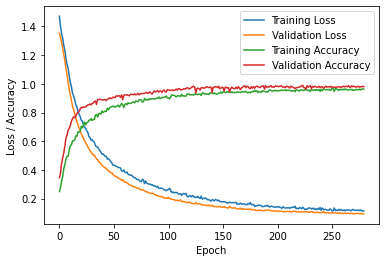

In [38]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss / Accuracy')
plt.legend()
plt.show()

### PyTorch model

## Pokus cislo 1

Architektura:
- 2 skryte vrstvy
    - aktivacne fukcie: ELU 
    - pocet neuronov: 64, 16
- vystupna vrstva
    - aktivacna fukcia: Softmax
    - pocet neuronov: 4

Hyperparametre:
- optimizer: Adam
- loss: CrossEntropyLoss
- learnig rate: 0.001
    - strategia: ak neklesne loss po 6 epochach lr sa prenasobi 0.8 
- epochy: 300
    - early stop: ak sa po 9 epochach loss nezlepsi vypne sa trenovanie
- velkost batchu: 64

Epoch 1/300, Loss: 1.3813, Val Acc: 0.3400, Val Loss: 1.3745
Epoch 2/300, Loss: 1.3457, Val Acc: 0.4300, Val Loss: 1.3347
Epoch 3/300, Loss: 1.2882, Val Acc: 0.4700, Val Loss: 1.2639
Epoch 4/300, Loss: 1.1836, Val Acc: 0.5033, Val Loss: 1.1450
Epoch 5/300, Loss: 1.0312, Val Acc: 0.6000, Val Loss: 0.9981
Epoch 6/300, Loss: 0.8767, Val Acc: 0.6900, Val Loss: 0.8554
Epoch 7/300, Loss: 0.7514, Val Acc: 0.7667, Val Loss: 0.7449
Epoch 8/300, Loss: 0.6557, Val Acc: 0.7867, Val Loss: 0.6597
Epoch 9/300, Loss: 0.5802, Val Acc: 0.8133, Val Loss: 0.5915
Epoch 10/300, Loss: 0.5191, Val Acc: 0.8367, Val Loss: 0.5353
Epoch 11/300, Loss: 0.4686, Val Acc: 0.8533, Val Loss: 0.4883
Epoch 12/300, Loss: 0.4263, Val Acc: 0.8733, Val Loss: 0.4485
Epoch 13/300, Loss: 0.3903, Val Acc: 0.8833, Val Loss: 0.4145
Epoch 14/300, Loss: 0.3594, Val Acc: 0.8900, Val Loss: 0.3851
Epoch 15/300, Loss: 0.3327, Val Acc: 0.9033, Val Loss: 0.3596
Epoch 16/300, Loss: 0.3095, Val Acc: 0.9033, Val Loss: 0.3375
Epoch 17/300, Los

Epoch 134/300, Loss: 0.0472, Val Acc: 0.9633, Val Loss: 0.1039
Epoch 135/300, Loss: 0.0470, Val Acc: 0.9633, Val Loss: 0.1038
Epoch 136/300, Loss: 0.0468, Val Acc: 0.9633, Val Loss: 0.1037
Epoch 137/300, Loss: 0.0466, Val Acc: 0.9633, Val Loss: 0.1035
Epoch 138/300, Loss: 0.0464, Val Acc: 0.9633, Val Loss: 0.1034
Epoch 139/300, Loss: 0.0462, Val Acc: 0.9633, Val Loss: 0.1032
Epoch 140/300, Loss: 0.0460, Val Acc: 0.9633, Val Loss: 0.1030
Epoch 141/300, Loss: 0.0458, Val Acc: 0.9633, Val Loss: 0.1028
Epoch 142/300, Loss: 0.0456, Val Acc: 0.9633, Val Loss: 0.1026
Epoch 143/300, Loss: 0.0454, Val Acc: 0.9633, Val Loss: 0.1024
Epoch 144/300, Loss: 0.0452, Val Acc: 0.9633, Val Loss: 0.1022
Epoch 145/300, Loss: 0.0450, Val Acc: 0.9633, Val Loss: 0.1019
Epoch 146/300, Loss: 0.0448, Val Acc: 0.9633, Val Loss: 0.1017
Epoch 147/300, Loss: 0.0447, Val Acc: 0.9633, Val Loss: 0.1014
Epoch 148/300, Loss: 0.0445, Val Acc: 0.9633, Val Loss: 0.1011
Epoch 149/300, Loss: 0.0443, Val Acc: 0.9633, Val Loss:

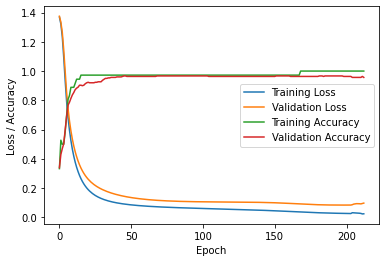

In [6]:
X_train, X_val, y_train, y_val = LoadData()
class EarlyStopping:
    def __init__(self, patience=10, delta=0, checkpoint_path='checkpoint.pt'):
        self.patience = patience
        self.delta = delta
        self.checkpoint_path = checkpoint_path
        self.best_loss = np.Inf
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_loss, model):
        if val_loss > self.best_loss + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            torch.save(model.state_dict(), self.checkpoint_path)
            self.best_loss = val_loss
            self.counter = 0

# Define the model architecture
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(20, 64)
        self.fc2 = nn.Linear(64, 16)
        self.fc3 = nn.Linear(16, 4)
        self.dropout = nn.Dropout(p=0.5)
        self.elu = nn.ELU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.elu(self.fc1(x))
        x = self.elu(self.fc2(x))
        x = self.fc3(x)
        return x

model = Model()

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.8, patience=6)
early_stopping = EarlyStopping(patience=9, delta=0.001, checkpoint_path='checkpoint.pt')

train_losses = []
val_losses = []
train_accs = []
val_accs = []

n_epochs = 300
batch_size = 64

for epoch in range(n_epochs):
    running_loss = 0.0
    model.train()
    for i in range(0, X_train.shape[0], batch_size):
        # Get a batch of data
        X_train_tensor = torch.from_numpy(X_train[i:i+batch_size].to_numpy()).float()
        y_train_tensor = torch.from_numpy(y_train[i:i+batch_size].to_numpy()).long()

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward + backward + optimize
        outputs = model(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        loss.backward()
        optimizer.step()

        # Print statistics
        running_loss += loss.item() * X_train_tensor.size(0)
    epoch_loss = running_loss / X_train.shape[0]
    
    # Evaluate on training data
    with torch.no_grad():
        train_loss = criterion(model(X_train_tensor), y_train_tensor)
        train_acc = torch.sum(torch.argmax(model(X_train_tensor), dim=1) == y_train_tensor) / len(y_train_tensor)
        train_losses.append(train_loss.item())
        train_accs.append(train_acc.item())

    # Evaluate on validation set
    with torch.no_grad():
        model.eval()
        X_val_tensor = torch.from_numpy(X_val.to_numpy()).float()
        y_val_tensor = torch.from_numpy(y_val.to_numpy()).long()
        val_outputs = model(X_val_tensor)
        val_loss = criterion(val_outputs, y_val_tensor).item()
        val_losses.append(val_loss)
        val_preds = torch.argmax(val_outputs, axis=1).numpy()
        val_acc = (val_preds == y_val.to_numpy()).mean()
        val_accs.append(val_acc)

    # Update learning rate
    lr_scheduler.step(val_loss)
    early_stopping(val_loss, model)

    if early_stopping.early_stop:
        print('Early stopping')
        break

    # Print epoch statistics
    print(f'Epoch {epoch+1}/{n_epochs}, Loss: {epoch_loss:.4f}, Val Acc: {val_acc:.4f}, Val Loss: {val_loss:.4f}')

# # Evaluate the model on val set
with torch.no_grad():
    X_val_tensor = torch.from_numpy(X_val.to_numpy()).float()
    y_val_tensor = torch.from_numpy(y_val.to_numpy()).long()
    val_outputs = model(X_val_tensor)
    val_loss = criterion(val_outputs, y_val_tensor).item()
    val_preds = torch.argmax(val_outputs, axis=1).numpy()
    val_acc = (val_preds == y_val.to_numpy()).mean()

print(f'Validation accuracy: {val_acc:.4f}, Validation loss: {val_loss:.4f}')

# Plot the training and validation losses and accuracies
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.plot(train_accs, label='Training Accuracy')
plt.plot(val_accs, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss / Accuracy')
plt.legend()
plt.show()

## Pokus cislo 2

Architektura:
- 2 skryte vrstvy
    - aktivacne fukcie: ELU 
    - pocet neuronov: 64, 16
    - dropout: 0.5
- vystupna vrstva
    - aktivacna fukcia: Softmax
    - pocet neuronov: 4

Hyperparametre:
- optimizer: Adam
- loss: CrossEntropyLoss
- learnig rate: 0.001
    - strategia: ak neklesne loss po 6 epochach lr sa prenasobi 0.8 
- epochy: 300
    - early stop: ak sa po 9 epochach loss nezlepsi vypne sa trenovanie
- velkost batchu: 64

Epoch 1/300, Loss: 1.4093, Val Acc: 0.3500, Val Loss: 1.3691
Epoch 2/300, Loss: 1.3771, Val Acc: 0.4433, Val Loss: 1.3443
Epoch 3/300, Loss: 1.3467, Val Acc: 0.4900, Val Loss: 1.3095
Epoch 4/300, Loss: 1.3125, Val Acc: 0.5267, Val Loss: 1.2560
Epoch 5/300, Loss: 1.2541, Val Acc: 0.5333, Val Loss: 1.1751
Epoch 6/300, Loss: 1.1876, Val Acc: 0.5567, Val Loss: 1.0712
Epoch 7/300, Loss: 1.1015, Val Acc: 0.6067, Val Loss: 0.9654
Epoch 8/300, Loss: 1.0182, Val Acc: 0.6300, Val Loss: 0.8750
Epoch 9/300, Loss: 0.9532, Val Acc: 0.6533, Val Loss: 0.8177
Epoch 10/300, Loss: 0.8834, Val Acc: 0.6900, Val Loss: 0.7540
Epoch 11/300, Loss: 0.8364, Val Acc: 0.7133, Val Loss: 0.7021
Epoch 12/300, Loss: 0.7908, Val Acc: 0.7467, Val Loss: 0.6584
Epoch 13/300, Loss: 0.7686, Val Acc: 0.7600, Val Loss: 0.6234
Epoch 14/300, Loss: 0.7286, Val Acc: 0.7733, Val Loss: 0.5915
Epoch 15/300, Loss: 0.6848, Val Acc: 0.7900, Val Loss: 0.5601
Epoch 16/300, Loss: 0.6765, Val Acc: 0.8033, Val Loss: 0.5371
Epoch 17/300, Los

Epoch 117/300, Loss: 0.2072, Val Acc: 0.9633, Val Loss: 0.1105
EarlyStopping counter: 1 out of 9
Epoch 118/300, Loss: 0.1863, Val Acc: 0.9667, Val Loss: 0.1126
Epoch 119/300, Loss: 0.1869, Val Acc: 0.9667, Val Loss: 0.1079
Epoch 120/300, Loss: 0.2032, Val Acc: 0.9600, Val Loss: 0.1088
Epoch 121/300, Loss: 0.1986, Val Acc: 0.9600, Val Loss: 0.1066
Epoch 122/300, Loss: 0.1847, Val Acc: 0.9633, Val Loss: 0.1050
EarlyStopping counter: 1 out of 9
Epoch 123/300, Loss: 0.1834, Val Acc: 0.9633, Val Loss: 0.1086
EarlyStopping counter: 2 out of 9
Epoch 124/300, Loss: 0.1980, Val Acc: 0.9667, Val Loss: 0.1061
EarlyStopping counter: 3 out of 9
Epoch 125/300, Loss: 0.1947, Val Acc: 0.9600, Val Loss: 0.1082
Epoch 126/300, Loss: 0.1838, Val Acc: 0.9633, Val Loss: 0.1039
EarlyStopping counter: 1 out of 9
Epoch 127/300, Loss: 0.1827, Val Acc: 0.9600, Val Loss: 0.1136
Epoch 128/300, Loss: 0.1829, Val Acc: 0.9633, Val Loss: 0.1032
EarlyStopping counter: 1 out of 9
Epoch 129/300, Loss: 0.1837, Val Acc: 0.

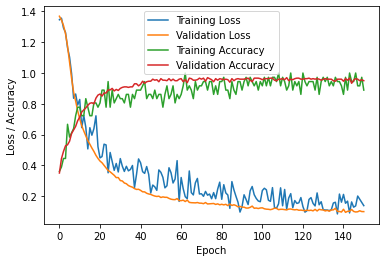

In [41]:
X_train, X_val, y_train, y_val = LoadData()
class EarlyStopping:
    def __init__(self, patience=10, delta=0, checkpoint_path='checkpoint.pt'):
        self.patience = patience
        self.delta = delta
        self.checkpoint_path = checkpoint_path
        self.best_loss = np.Inf
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_loss, model):
        if val_loss > self.best_loss + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            torch.save(model.state_dict(), self.checkpoint_path)
            self.best_loss = val_loss
            self.counter = 0

# Define the model architecture
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(20, 64)
        self.fc2 = nn.Linear(64, 16)
        self.fc3 = nn.Linear(16, 4)
        self.dropout = nn.Dropout(p=0.5)
        self.elu = nn.ELU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.elu(self.fc1(x))
        x = self.dropout(x)
        x = self.elu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

model = Model()

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.8, patience=6)
early_stopping = EarlyStopping(patience=9, delta=0.001, checkpoint_path='checkpoint.pt')

train_losses = []
val_losses = []
train_accs = []
val_accs = []

n_epochs = 300
batch_size = 64

for epoch in range(n_epochs):
    running_loss = 0.0
    model.train()
    for i in range(0, X_train.shape[0], batch_size):
        # Get a batch of data
        X_train_tensor = torch.from_numpy(X_train[i:i+batch_size].to_numpy()).float()
        y_train_tensor = torch.from_numpy(y_train[i:i+batch_size].to_numpy()).long()

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward + backward + optimize
        outputs = model(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        loss.backward()
        optimizer.step()

        # Print statistics
        running_loss += loss.item() * X_train_tensor.size(0)
    epoch_loss = running_loss / X_train.shape[0]
    
    # Evaluate on training data
    with torch.no_grad():
        train_loss = criterion(model(X_train_tensor), y_train_tensor)
        train_acc = torch.sum(torch.argmax(model(X_train_tensor), dim=1) == y_train_tensor) / len(y_train_tensor)
        train_losses.append(train_loss.item())
        train_accs.append(train_acc.item())

    # Evaluate on validation set
    with torch.no_grad():
        model.eval()
        X_val_tensor = torch.from_numpy(X_val.to_numpy()).float()
        y_val_tensor = torch.from_numpy(y_val.to_numpy()).long()
        val_outputs = model(X_val_tensor)
        val_loss = criterion(val_outputs, y_val_tensor).item()
        val_losses.append(val_loss)
        val_preds = torch.argmax(val_outputs, axis=1).numpy()
        val_acc = (val_preds == y_val.to_numpy()).mean()
        val_accs.append(val_acc)

    # Update learning rate
    lr_scheduler.step(val_loss)
    early_stopping(val_loss, model)

    if early_stopping.early_stop:
        print('Early stopping')
        break

    # Print epoch statistics
    print(f'Epoch {epoch+1}/{n_epochs}, Loss: {epoch_loss:.4f}, Val Acc: {val_acc:.4f}, Val Loss: {val_loss:.4f}')

# # Evaluate the model on val set
with torch.no_grad():
    X_val_tensor = torch.from_numpy(X_val.to_numpy()).float()
    y_val_tensor = torch.from_numpy(y_val.to_numpy()).long()
    val_outputs = model(X_val_tensor)
    val_loss = criterion(val_outputs, y_val_tensor).item()
    val_preds = torch.argmax(val_outputs, axis=1).numpy()
    val_acc = (val_preds == y_val.to_numpy()).mean()

print(f'Validation accuracy: {val_acc:.4f}, Validation loss: {val_loss:.4f}')

# Plot the training and validation losses and accuracies
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.plot(train_accs, label='Training Accuracy')
plt.plot(val_accs, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss / Accuracy')
plt.legend()
plt.show()

## Pokus cislo 3

Architektura:
- 2 skryte vrstvy
    - aktivacne fukcie: Tanh 
    - pocet neuronov: 64, 16
    - dropout: 0.5
- vystupna vrstva
    - aktivacna fukcia: Softmax
    - pocet neuronov: 4

Hyperparametre:
- optimizer: Adam
- loss: CrossEntropyLoss
- learnig rate: 0.001
    - strategia: ak neklesne loss po 6 epochach lr sa prenasobi 0.8 
- epochy: 300
    - early stop: ak sa po 9 epochach loss nezlepsi vypne sa trenovanie
- velkost batchu: 64

Epoch 1/300, Loss: 1.3946, Val Acc: 0.4433, Val Loss: 1.3629
Epoch 2/300, Loss: 1.3613, Val Acc: 0.5133, Val Loss: 1.3312
Epoch 3/300, Loss: 1.3260, Val Acc: 0.5500, Val Loss: 1.2812
Epoch 4/300, Loss: 1.2737, Val Acc: 0.5300, Val Loss: 1.2064
Epoch 5/300, Loss: 1.2022, Val Acc: 0.5567, Val Loss: 1.1047
Epoch 6/300, Loss: 1.1161, Val Acc: 0.5733, Val Loss: 0.9973
Epoch 7/300, Loss: 1.0338, Val Acc: 0.6033, Val Loss: 0.9058
Epoch 8/300, Loss: 0.9651, Val Acc: 0.6267, Val Loss: 0.8374
Epoch 9/300, Loss: 0.9118, Val Acc: 0.6600, Val Loss: 0.7876
Epoch 10/300, Loss: 0.8521, Val Acc: 0.7267, Val Loss: 0.7315
Epoch 11/300, Loss: 0.8081, Val Acc: 0.7500, Val Loss: 0.6868
Epoch 12/300, Loss: 0.7699, Val Acc: 0.7600, Val Loss: 0.6520
Epoch 13/300, Loss: 0.7376, Val Acc: 0.7867, Val Loss: 0.6164
Epoch 14/300, Loss: 0.7076, Val Acc: 0.7800, Val Loss: 0.5908
Epoch 15/300, Loss: 0.6693, Val Acc: 0.8100, Val Loss: 0.5608
Epoch 16/300, Loss: 0.6584, Val Acc: 0.8200, Val Loss: 0.5245
Epoch 17/300, Los

EarlyStopping counter: 2 out of 10
Epoch 116/300, Loss: 0.2076, Val Acc: 0.9433, Val Loss: 0.1288
EarlyStopping counter: 3 out of 10
Epoch 117/300, Loss: 0.1888, Val Acc: 0.9400, Val Loss: 0.1220
EarlyStopping counter: 4 out of 10
Epoch 118/300, Loss: 0.1996, Val Acc: 0.9567, Val Loss: 0.1157
Epoch 119/300, Loss: 0.1845, Val Acc: 0.9500, Val Loss: 0.1124
Epoch 120/300, Loss: 0.2107, Val Acc: 0.9500, Val Loss: 0.1100
Epoch 121/300, Loss: 0.1978, Val Acc: 0.9700, Val Loss: 0.1049
Epoch 122/300, Loss: 0.2075, Val Acc: 0.9667, Val Loss: 0.1016
EarlyStopping counter: 1 out of 10
Epoch 123/300, Loss: 0.1873, Val Acc: 0.9567, Val Loss: 0.1041
EarlyStopping counter: 2 out of 10
Epoch 124/300, Loss: 0.1933, Val Acc: 0.9600, Val Loss: 0.1026
Epoch 125/300, Loss: 0.1892, Val Acc: 0.9533, Val Loss: 0.1020
Epoch 126/300, Loss: 0.1855, Val Acc: 0.9600, Val Loss: 0.1022
EarlyStopping counter: 1 out of 10
Epoch 127/300, Loss: 0.1909, Val Acc: 0.9533, Val Loss: 0.1066
EarlyStopping counter: 2 out of 10

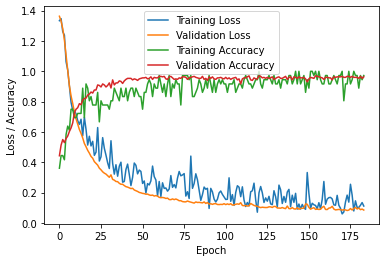

In [42]:
class EarlyStopping:
    def __init__(self, patience=10, delta=0, checkpoint_path='checkpoint.pt'):
        self.patience = patience
        self.delta = delta
        self.checkpoint_path = checkpoint_path
        self.best_loss = np.Inf
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_loss, model):
        if val_loss > self.best_loss + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            torch.save(model.state_dict(), self.checkpoint_path)
            self.best_loss = val_loss
            self.counter = 0

# Define the model architecture
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(20, 64)
        self.fc2 = nn.Linear(64, 16)
        self.fc3 = nn.Linear(16, 4)
        self.dropout = nn.Dropout(p=0.5)
        self.tanh = nn.Tanh()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.tanh(self.fc1(x))
        x = self.dropout(x)
        x = self.tanh(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

model = Model()

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.8, patience=6)
early_stopping = EarlyStopping(patience=10, delta=0.001, checkpoint_path='checkpoint.pt')

train_losses = []
val_losses = []
train_accs = []
val_accs = []

n_epochs = 300
batch_size = 64

for epoch in range(n_epochs):
    running_loss = 0.0
    model.train()
    for i in range(0, X_train.shape[0], batch_size):
        # Get a batch of data
        X_train_tensor = torch.from_numpy(X_train[i:i+batch_size].to_numpy()).float()
        y_train_tensor = torch.from_numpy(y_train[i:i+batch_size].to_numpy()).long()

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward + backward + optimize
        outputs = model(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        loss.backward()
        optimizer.step()

        # Print statistics
        running_loss += loss.item() * X_train_tensor.size(0)
    epoch_loss = running_loss / X_train.shape[0]
    
    # Evaluate on training data
    with torch.no_grad():
        train_loss = criterion(model(X_train_tensor), y_train_tensor)
        train_acc = torch.sum(torch.argmax(model(X_train_tensor), dim=1) == y_train_tensor) / len(y_train_tensor)
        train_losses.append(train_loss.item())
        train_accs.append(train_acc.item())

    # Evaluate on validation set
    with torch.no_grad():
        model.eval()
        X_val_tensor = torch.from_numpy(X_val.to_numpy()).float()
        y_val_tensor = torch.from_numpy(y_val.to_numpy()).long()
        val_outputs = model(X_val_tensor)
        val_loss = criterion(val_outputs, y_val_tensor).item()
        val_losses.append(val_loss)
        val_preds = torch.argmax(val_outputs, axis=1).numpy()
        val_acc = (val_preds == y_val.to_numpy()).mean()
        val_accs.append(val_acc)

    # Update learning rate
    lr_scheduler.step(val_loss)
    early_stopping(val_loss, model)

    if early_stopping.early_stop:
        print('Early stopping')
        break

    # Print epoch statistics
    print(f'Epoch {epoch+1}/{n_epochs}, Loss: {epoch_loss:.4f}, Val Acc: {val_acc:.4f}, Val Loss: {val_loss:.4f}')

# # Evaluate the model on val set
with torch.no_grad():
    X_val_tensor = torch.from_numpy(X_val.to_numpy()).float()
    y_val_tensor = torch.from_numpy(y_val.to_numpy()).long()
    val_outputs = model(X_val_tensor)
    val_loss = criterion(val_outputs, y_val_tensor).item()
    val_preds = torch.argmax(val_outputs, axis=1).numpy()
    val_acc = (val_preds == y_val.to_numpy()).mean()

print(f'Validation accuracy: {val_acc:.4f}, Validation loss: {val_loss:.4f}')

# Plot the training and validation losses and accuracies
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.plot(train_accs, label='Training Accuracy')
plt.plot(val_accs, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss / Accuracy')
plt.legend()
plt.show()


## Pokus cislo 4

Architektura:
- 2 skryte vrstvy
    - aktivacne fukcie: LeakyReLU 
    - pocet neuronov: 64, 16
    - dropout: 0.5
- vystupna vrstva
    - aktivacna fukcia: Softmax
    - pocet neuronov: 4

Hyperparametre:
- optimizer: Adam
- loss: CrossEntropyLoss
- learnig rate: 0.001
    - strategia: ak neklesne loss po 6 epochach lr sa prenasobi 0.8 
- epochy: 300
    - early stop: ak sa po 9 epochach loss nezlepsi vypne sa trenovanie
- velkost batchu: 64

Epoch 1/300, Loss: 1.3985, Val Acc: 0.2167, Val Loss: 1.4010
Epoch 2/300, Loss: 1.3859, Val Acc: 0.2100, Val Loss: 1.3910
Epoch 3/300, Loss: 1.3752, Val Acc: 0.3233, Val Loss: 1.3695
Epoch 4/300, Loss: 1.3655, Val Acc: 0.4367, Val Loss: 1.3483
Epoch 5/300, Loss: 1.3350, Val Acc: 0.4467, Val Loss: 1.3099
Epoch 6/300, Loss: 1.2993, Val Acc: 0.4533, Val Loss: 1.2541
Epoch 7/300, Loss: 1.2448, Val Acc: 0.4633, Val Loss: 1.1737
Epoch 8/300, Loss: 1.1777, Val Acc: 0.5167, Val Loss: 1.0881
Epoch 9/300, Loss: 1.1204, Val Acc: 0.5433, Val Loss: 1.0158
Epoch 10/300, Loss: 1.0627, Val Acc: 0.6000, Val Loss: 0.9436
Epoch 11/300, Loss: 1.0093, Val Acc: 0.6033, Val Loss: 0.8859
Epoch 12/300, Loss: 0.9631, Val Acc: 0.7000, Val Loss: 0.8257
Epoch 13/300, Loss: 0.9301, Val Acc: 0.7067, Val Loss: 0.7948
Epoch 14/300, Loss: 0.8818, Val Acc: 0.7367, Val Loss: 0.7473
Epoch 15/300, Loss: 0.8398, Val Acc: 0.7467, Val Loss: 0.7064
Epoch 16/300, Loss: 0.8294, Val Acc: 0.7767, Val Loss: 0.6759
Epoch 17/300, Los

EarlyStopping counter: 4 out of 10
Epoch 114/300, Loss: 0.2988, Val Acc: 0.9467, Val Loss: 0.1778
Epoch 115/300, Loss: 0.2764, Val Acc: 0.9467, Val Loss: 0.1683
Epoch 116/300, Loss: 0.2775, Val Acc: 0.9400, Val Loss: 0.1676
EarlyStopping counter: 1 out of 10
Epoch 117/300, Loss: 0.2794, Val Acc: 0.9400, Val Loss: 0.1764
Epoch 118/300, Loss: 0.2681, Val Acc: 0.9533, Val Loss: 0.1635
EarlyStopping counter: 1 out of 10
Epoch 119/300, Loss: 0.2553, Val Acc: 0.9467, Val Loss: 0.1652
EarlyStopping counter: 2 out of 10
Epoch 120/300, Loss: 0.2617, Val Acc: 0.9333, Val Loss: 0.1814
EarlyStopping counter: 3 out of 10
Epoch 121/300, Loss: 0.2586, Val Acc: 0.9433, Val Loss: 0.1698
EarlyStopping counter: 4 out of 10
Epoch 122/300, Loss: 0.2612, Val Acc: 0.9167, Val Loss: 0.1801
EarlyStopping counter: 5 out of 10
Epoch 123/300, Loss: 0.2838, Val Acc: 0.9367, Val Loss: 0.1731
EarlyStopping counter: 6 out of 10
Epoch 124/300, Loss: 0.2900, Val Acc: 0.9300, Val Loss: 0.1803
EarlyStopping counter: 7 ou

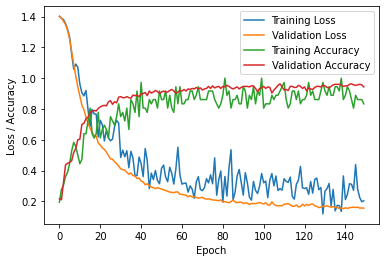

In [8]:
class EarlyStopping:
    def __init__(self, patience=10, delta=0, checkpoint_path='checkpoint.pt'):
        self.patience = patience
        self.delta = delta
        self.checkpoint_path = checkpoint_path
        self.best_loss = np.Inf
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_loss, model):
        if val_loss > self.best_loss + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            torch.save(model.state_dict(), self.checkpoint_path)
            self.best_loss = val_loss
            self.counter = 0

# Define the model architecture
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(20, 64)
        self.fc2 = nn.Linear(64, 16)
        self.fc3 = nn.Linear(16, 4)
        self.dropout = nn.Dropout(p=0.5)
        self.leakyrelu = nn.LeakyReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.leakyrelu(self.fc1(x))
        x = self.dropout(x)
        x = self.leakyrelu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

model = Model()

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.8, patience=6)
early_stopping = EarlyStopping(patience=10, delta=0.001, checkpoint_path='checkpoint.pt')

train_losses = []
val_losses = []
train_accs = []
val_accs = []

n_epochs = 300
batch_size = 64

for epoch in range(n_epochs):
    running_loss = 0.0
    model.train()
    for i in range(0, X_train.shape[0], batch_size):
        # Get a batch of data
        X_train_tensor = torch.from_numpy(X_train[i:i+batch_size].to_numpy()).float()
        y_train_tensor = torch.from_numpy(y_train[i:i+batch_size].to_numpy()).long()

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward + backward + optimize
        outputs = model(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        loss.backward()
        optimizer.step()

        # Print statistics
        running_loss += loss.item() * X_train_tensor.size(0)
    epoch_loss = running_loss / X_train.shape[0]
    
    # Evaluate on training data
    with torch.no_grad():
        train_loss = criterion(model(X_train_tensor), y_train_tensor)
        train_acc = torch.sum(torch.argmax(model(X_train_tensor), dim=1) == y_train_tensor) / len(y_train_tensor)
        train_losses.append(train_loss.item())
        train_accs.append(train_acc.item())

    # Evaluate on validation set
    with torch.no_grad():
        model.eval()
        X_val_tensor = torch.from_numpy(X_val.to_numpy()).float()
        y_val_tensor = torch.from_numpy(y_val.to_numpy()).long()
        val_outputs = model(X_val_tensor)
        val_loss = criterion(val_outputs, y_val_tensor).item()
        val_losses.append(val_loss)
        val_preds = torch.argmax(val_outputs, axis=1).numpy()
        val_acc = (val_preds == y_val.to_numpy()).mean()
        val_accs.append(val_acc)

    # Update learning rate
    lr_scheduler.step(val_loss)
    early_stopping(val_loss, model)

    if early_stopping.early_stop:
        print('Early stopping')
        break

    # Print epoch statistics
    print(f'Epoch {epoch+1}/{n_epochs}, Loss: {epoch_loss:.4f}, Val Acc: {val_acc:.4f}, Val Loss: {val_loss:.4f}')

# # Evaluate the model on val set
with torch.no_grad():
    X_val_tensor = torch.from_numpy(X_val.to_numpy()).float()
    y_val_tensor = torch.from_numpy(y_val.to_numpy()).long()
    val_outputs = model(X_val_tensor)
    val_loss = criterion(val_outputs, y_val_tensor).item()
    val_preds = torch.argmax(val_outputs, axis=1).numpy()
    val_acc = (val_preds == y_val.to_numpy()).mean()

print(f'Validation accuracy: {val_acc:.4f}, Validation loss: {val_loss:.4f}')

# Plot the training and validation losses and accuracies
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.plot(train_accs, label='Training Accuracy')
plt.plot(val_accs, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss / Accuracy')
plt.legend()
plt.show()


## Pokus cislo 5

Architektura:
- 2 skryte vrstvy
    - aktivacne fukcie: ELU 
    - pocet neuronov: 32
    - dropout: 0.5
- vystupna vrstva
    - aktivacna fukcia: Softmax
    - pocet neuronov: 4

Hyperparametre:
- optimizer: Adam
- loss: CrossEntropyLoss
- learnig rate: 0.001
    - strategia: ak neklesne loss po 6 epochach lr sa prenasobi 0.8 
- epochy: 500
    - early stop: ak sa po 9 epochach loss nezlepsi vypne sa trenovanie
- velkost batchu: 64

Epoch 1/500, Loss: 1.3861, Val Acc: 0.2967, Val Loss: 1.3625
Epoch 2/500, Loss: 1.3632, Val Acc: 0.3467, Val Loss: 1.3493
Epoch 3/500, Loss: 1.3477, Val Acc: 0.4200, Val Loss: 1.3305
Epoch 4/500, Loss: 1.3187, Val Acc: 0.4600, Val Loss: 1.3110
Epoch 5/500, Loss: 1.3016, Val Acc: 0.4833, Val Loss: 1.2870
Epoch 6/500, Loss: 1.2693, Val Acc: 0.5133, Val Loss: 1.2607
Epoch 7/500, Loss: 1.2347, Val Acc: 0.5400, Val Loss: 1.2288
Epoch 8/500, Loss: 1.2014, Val Acc: 0.5533, Val Loss: 1.1942
Epoch 9/500, Loss: 1.1656, Val Acc: 0.5700, Val Loss: 1.1581
Epoch 10/500, Loss: 1.1310, Val Acc: 0.5933, Val Loss: 1.1218
Epoch 11/500, Loss: 1.0836, Val Acc: 0.6000, Val Loss: 1.0834
Epoch 12/500, Loss: 1.0450, Val Acc: 0.6233, Val Loss: 1.0462
Epoch 13/500, Loss: 1.0064, Val Acc: 0.6400, Val Loss: 1.0113
Epoch 14/500, Loss: 0.9673, Val Acc: 0.6467, Val Loss: 0.9779
Epoch 15/500, Loss: 0.9415, Val Acc: 0.6567, Val Loss: 0.9469
Epoch 16/500, Loss: 0.9150, Val Acc: 0.6600, Val Loss: 0.9181
Epoch 17/500, Los

Epoch 134/500, Loss: 0.2219, Val Acc: 0.9633, Val Loss: 0.2121
Epoch 135/500, Loss: 0.2209, Val Acc: 0.9633, Val Loss: 0.2123
Epoch 136/500, Loss: 0.2197, Val Acc: 0.9567, Val Loss: 0.2105
Epoch 137/500, Loss: 0.2176, Val Acc: 0.9567, Val Loss: 0.2088
Epoch 138/500, Loss: 0.2167, Val Acc: 0.9600, Val Loss: 0.2071
Epoch 139/500, Loss: 0.2104, Val Acc: 0.9667, Val Loss: 0.2069
Epoch 140/500, Loss: 0.2111, Val Acc: 0.9633, Val Loss: 0.2044
Epoch 141/500, Loss: 0.2098, Val Acc: 0.9600, Val Loss: 0.2037
Epoch 142/500, Loss: 0.2069, Val Acc: 0.9633, Val Loss: 0.2019
Epoch 143/500, Loss: 0.2061, Val Acc: 0.9633, Val Loss: 0.1999
EarlyStopping counter: 1 out of 10
Epoch 144/500, Loss: 0.2043, Val Acc: 0.9633, Val Loss: 0.2013
Epoch 145/500, Loss: 0.2011, Val Acc: 0.9633, Val Loss: 0.1986
Epoch 146/500, Loss: 0.1943, Val Acc: 0.9667, Val Loss: 0.1969
EarlyStopping counter: 1 out of 10
Epoch 147/500, Loss: 0.1937, Val Acc: 0.9567, Val Loss: 0.2007
Epoch 148/500, Loss: 0.2073, Val Acc: 0.9633, Va

EarlyStopping counter: 1 out of 10
Epoch 253/500, Loss: 0.1233, Val Acc: 0.9600, Val Loss: 0.1328
Epoch 254/500, Loss: 0.1267, Val Acc: 0.9600, Val Loss: 0.1321
EarlyStopping counter: 1 out of 10
Epoch 255/500, Loss: 0.1215, Val Acc: 0.9600, Val Loss: 0.1343
EarlyStopping counter: 2 out of 10
Epoch 256/500, Loss: 0.1252, Val Acc: 0.9567, Val Loss: 0.1348
Epoch 257/500, Loss: 0.1208, Val Acc: 0.9567, Val Loss: 0.1310
Epoch 258/500, Loss: 0.1230, Val Acc: 0.9600, Val Loss: 0.1300
EarlyStopping counter: 1 out of 10
Epoch 259/500, Loss: 0.1251, Val Acc: 0.9600, Val Loss: 0.1322
Epoch 260/500, Loss: 0.1259, Val Acc: 0.9567, Val Loss: 0.1297
Epoch 261/500, Loss: 0.1186, Val Acc: 0.9600, Val Loss: 0.1291
Epoch 262/500, Loss: 0.1240, Val Acc: 0.9633, Val Loss: 0.1296
Epoch 263/500, Loss: 0.1202, Val Acc: 0.9667, Val Loss: 0.1280
Epoch 264/500, Loss: 0.1233, Val Acc: 0.9633, Val Loss: 0.1283
Epoch 265/500, Loss: 0.1227, Val Acc: 0.9600, Val Loss: 0.1275
Epoch 266/500, Loss: 0.1192, Val Acc: 0.9

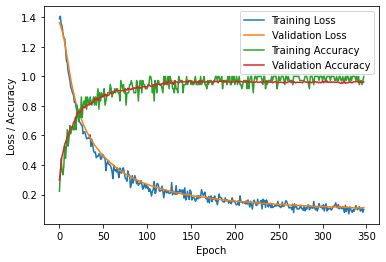

In [13]:
class EarlyStopping:
    def __init__(self, patience=10, delta=0, checkpoint_path='checkpoint.pt'):
        self.patience = patience
        self.delta = delta
        self.checkpoint_path = checkpoint_path
        self.best_loss = np.Inf
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_loss, model):
        if val_loss > self.best_loss + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            torch.save(model.state_dict(), self.checkpoint_path)
            self.best_loss = val_loss
            self.counter = 0

# Define the model architecture
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(20, 32)
        self.fc2 = nn.Linear(32, 4)
        self.dropout = nn.Dropout(p=0.5)
        self.tanh = nn.Tanh()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.tanh(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

model = Model()

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.8, patience=6)
early_stopping = EarlyStopping(patience=10, delta=0.001, checkpoint_path='checkpoint.pt')

train_losses = []
val_losses = []
train_accs = []
val_accs = []

n_epochs = 500
batch_size = 64

for epoch in range(n_epochs):
    running_loss = 0.0
    model.train()
    for i in range(0, X_train.shape[0], batch_size):
        # Get a batch of data
        X_train_tensor = torch.from_numpy(X_train[i:i+batch_size].to_numpy()).float()
        y_train_tensor = torch.from_numpy(y_train[i:i+batch_size].to_numpy()).long()

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward + backward + optimize
        outputs = model(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        loss.backward()
        optimizer.step()

        # Print statistics
        running_loss += loss.item() * X_train_tensor.size(0)
    epoch_loss = running_loss / X_train.shape[0]
    
    # Evaluate on training data
    with torch.no_grad():
        train_loss = criterion(model(X_train_tensor), y_train_tensor)
        train_acc = torch.sum(torch.argmax(model(X_train_tensor), dim=1) == y_train_tensor) / len(y_train_tensor)
        train_losses.append(train_loss.item())
        train_accs.append(train_acc.item())

    # Evaluate on validation set
    with torch.no_grad():
        model.eval()
        X_val_tensor = torch.from_numpy(X_val.to_numpy()).float()
        y_val_tensor = torch.from_numpy(y_val.to_numpy()).long()
        val_outputs = model(X_val_tensor)
        val_loss = criterion(val_outputs, y_val_tensor).item()
        val_losses.append(val_loss)
        val_preds = torch.argmax(val_outputs, axis=1).numpy()
        val_acc = (val_preds == y_val.to_numpy()).mean()
        val_accs.append(val_acc)

    # Update learning rate
    lr_scheduler.step(val_loss)
    early_stopping(val_loss, model)

    if early_stopping.early_stop:
        print('Early stopping')
        break

    # Print epoch statistics
    print(f'Epoch {epoch+1}/{n_epochs}, Loss: {epoch_loss:.4f}, Val Acc: {val_acc:.4f}, Val Loss: {val_loss:.4f}')

# # Evaluate the model on val set
with torch.no_grad():
    X_val_tensor = torch.from_numpy(X_val.to_numpy()).float()
    y_val_tensor = torch.from_numpy(y_val.to_numpy()).long()
    val_outputs = model(X_val_tensor)
    val_loss = criterion(val_outputs, y_val_tensor).item()
    val_preds = torch.argmax(val_outputs, axis=1).numpy()
    val_acc = (val_preds == y_val.to_numpy()).mean()

print(f'Validation accuracy: {val_acc:.4f}, Validation loss: {val_loss:.4f}')

# Plot the training and validation losses and accuracies
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.plot(train_accs, label='Training Accuracy')
plt.plot(val_accs, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss / Accuracy')
plt.legend()
plt.show()
